##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.


Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

Note: As of **TensorFlow 2.2** the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [12]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compile the Keras model to configure the training process:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6937 - accuracy: 0.4688

  2/391 [..............................] - ETA: 59s - loss: 0.6936 - accuracy: 0.4688

  3/391 [..............................] - ETA: 50s - loss: 0.6935 - accuracy: 0.4688

  4/391 [..............................] - ETA: 47s - loss: 0.6934 - accuracy: 0.4805

  5/391 [..............................] - ETA: 44s - loss: 0.6933 - accuracy: 0.4906

  6/391 [..............................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4974

  7/391 [..............................] - ETA: 41s - loss: 0.6933 - accuracy: 0.4955

  8/391 [..............................] - ETA: 41s - loss: 0.6933 - accuracy: 0.4883

  9/391 [..............................] - ETA: 40s - loss: 0.6933 - accuracy: 0.4913

 10/391 [..............................] - ETA: 39s - loss: 0.6932 - accuracy: 0.5016

 11/391 [..............................] - ETA: 38s - loss: 0.6932 - accuracy: 0.4986

 12/391 [..............................] - ETA: 39s - loss: 0.6932 - accuracy: 0.4909

 13/391 [..............................] - ETA: 39s - loss: 0.6932 - accuracy: 0.4964

 14/391 [>.............................] - ETA: 38s - loss: 0.6931 - accuracy: 0.4978

 15/391 [>.............................] - ETA: 39s - loss: 0.6932 - accuracy: 0.4948

 16/391 [>.............................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5020

 17/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.4972

 18/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4905

 19/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.4901

 20/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.4945

 21/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.4940

 22/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4936

 23/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4932

 24/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4915

 25/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4900

 26/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4898

 27/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4890

 28/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4933

 29/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4935

 30/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4958

 31/391 [=>............................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4985

 32/391 [=>............................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4990

 33/391 [=>............................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4991

 34/391 [=>............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.5009

 35/391 [=>............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.5004

 36/391 [=>............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4991

 37/391 [=>............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.5000

 38/391 [=>............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.5025

 39/391 [=>............................] - ETA: 34s - loss: 0.6931 - accuracy: 0.5032

 40/391 [==>...........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.5035

 41/391 [==>...........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.5034

 42/391 [==>...........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.5037

 43/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5029

 44/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5046

 45/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5045

 46/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5034

 47/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5050

 48/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5042

 49/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5029

 50/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5031

 51/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5034

 52/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5021

 53/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5032

 54/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5017

 55/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5023

 56/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5011

 57/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5030

 58/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5024

 59/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5026

 60/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5031

 61/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5044

 62/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5050

 63/391 [===>..........................] - ETA: 32s - loss: 0.6930 - accuracy: 0.5055

 64/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5078

 65/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5082

 66/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5076

 67/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5072

 68/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5067

 69/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5061

 70/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5038

 71/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5044

 72/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5050

 73/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5045

 74/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5040

 75/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5040

 76/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5037

 77/391 [====>.........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5047

 78/391 [====>.........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5048

 79/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5045

 80/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5049

 81/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5050

 82/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5063

 83/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5062

 84/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5056

 85/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5053

 86/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5045

 87/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5040

 88/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5039

 89/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5044

 90/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5033

 91/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5034

 92/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5036

 93/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5045

 94/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5037

 95/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5046

 96/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5050

 97/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5063

 98/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5061

 99/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.5058

100/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5055

101/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5054

102/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5049

103/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5041

104/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5042

105/391 [=======>......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5054

106/391 [=======>......................] - ETA: 28s - loss: 0.6929 - accuracy: 0.5060

107/391 [=======>......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5053

108/391 [=======>......................] - ETA: 28s - loss: 0.6929 - accuracy: 0.5058

109/391 [=======>......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5054

110/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5044

111/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5042

112/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5036

113/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5037

114/391 [=======>......................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5044

115/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5052

116/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5044

117/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5040

118/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5037

119/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5038

120/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5040

121/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5045

122/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5041

123/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5034

124/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5034

125/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5026

126/391 [========>.....................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5022

127/391 [========>.....................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5026

128/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5032

129/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5036

130/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5031

131/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5025

132/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5019

133/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5016

134/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5017

135/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5016

136/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5014

137/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5013

138/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5017

139/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5017

140/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5012

141/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5012

142/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5019

143/391 [=========>....................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5021

144/391 [==========>...................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5024

145/391 [==========>...................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5026

146/391 [==========>...................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5025

147/391 [==========>...................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5021

148/391 [==========>...................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5032

149/391 [==========>...................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5038

150/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5034

151/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5039

152/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5043

153/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5037

154/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5042

155/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5042

156/391 [==========>...................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5036

157/391 [===========>..................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5043

158/391 [===========>..................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5042

159/391 [===========>..................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5044

160/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5048

161/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5048

162/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5049

163/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5051

164/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5049

165/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5041

166/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5040

167/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5044

168/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5041

169/391 [===========>..................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5033

170/391 [============>.................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5032

171/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5037

172/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5036

173/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5036

174/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5036

175/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5032

176/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5034

177/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5033

178/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5027

179/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5026

180/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5024

181/391 [============>.................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5020

182/391 [============>.................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5020

183/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5018

184/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5024

185/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5022

186/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5022

187/391 [=============>................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5018

188/391 [=============>................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5018

189/391 [=============>................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5021

190/391 [=============>................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5023

191/391 [=============>................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5016

192/391 [=============>................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5011

193/391 [=============>................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5005

194/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5004

195/391 [=============>................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5002

196/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.4998

197/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.5001

198/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.4994

199/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.4994

200/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.4998

201/391 [==============>...............] - ETA: 19s - loss: 0.6926 - accuracy: 0.4997

202/391 [==============>...............] - ETA: 19s - loss: 0.6927 - accuracy: 0.5007

203/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5008

204/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5006

205/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5005

206/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5004

207/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5004

208/391 [==============>...............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5006

209/391 [===============>..............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5010

210/391 [===============>..............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5007

211/391 [===============>..............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5007

212/391 [===============>..............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5005

213/391 [===============>..............] - ETA: 18s - loss: 0.6926 - accuracy: 0.5009

214/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.5002

215/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.5004

216/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.5004

217/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.5002

218/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.5001

219/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.4996

220/391 [===============>..............] - ETA: 17s - loss: 0.6924 - accuracy: 0.4994

221/391 [===============>..............] - ETA: 17s - loss: 0.6924 - accuracy: 0.4989

222/391 [================>.............] - ETA: 17s - loss: 0.6924 - accuracy: 0.4989

223/391 [================>.............] - ETA: 17s - loss: 0.6924 - accuracy: 0.4985

224/391 [================>.............] - ETA: 16s - loss: 0.6923 - accuracy: 0.4984

225/391 [================>.............] - ETA: 16s - loss: 0.6923 - accuracy: 0.4983

226/391 [================>.............] - ETA: 16s - loss: 0.6923 - accuracy: 0.4983

227/391 [================>.............] - ETA: 16s - loss: 0.6923 - accuracy: 0.4981

228/391 [================>.............] - ETA: 16s - loss: 0.6922 - accuracy: 0.4979

229/391 [================>.............] - ETA: 16s - loss: 0.6922 - accuracy: 0.4980

230/391 [================>.............] - ETA: 16s - loss: 0.6922 - accuracy: 0.4980

231/391 [================>.............] - ETA: 16s - loss: 0.6922 - accuracy: 0.4981

232/391 [================>.............] - ETA: 16s - loss: 0.6922 - accuracy: 0.4983

233/391 [================>.............] - ETA: 16s - loss: 0.6922 - accuracy: 0.4986

234/391 [================>.............] - ETA: 15s - loss: 0.6922 - accuracy: 0.4986

235/391 [=================>............] - ETA: 15s - loss: 0.6921 - accuracy: 0.4983

236/391 [=================>............] - ETA: 15s - loss: 0.6921 - accuracy: 0.4985

237/391 [=================>............] - ETA: 15s - loss: 0.6921 - accuracy: 0.4982

238/391 [=================>............] - ETA: 15s - loss: 0.6921 - accuracy: 0.4981

239/391 [=================>............] - ETA: 15s - loss: 0.6920 - accuracy: 0.4981

240/391 [=================>............] - ETA: 15s - loss: 0.6919 - accuracy: 0.4980

241/391 [=================>............] - ETA: 15s - loss: 0.6919 - accuracy: 0.4981

242/391 [=================>............] - ETA: 15s - loss: 0.6918 - accuracy: 0.4981

243/391 [=================>............] - ETA: 15s - loss: 0.6917 - accuracy: 0.4983

244/391 [=================>............] - ETA: 14s - loss: 0.6916 - accuracy: 0.4985

245/391 [=================>............] - ETA: 14s - loss: 0.6915 - accuracy: 0.4987

246/391 [=================>............] - ETA: 14s - loss: 0.6913 - accuracy: 0.4990

247/391 [=================>............] - ETA: 14s - loss: 0.6912 - accuracy: 0.4992

248/391 [==================>...........] - ETA: 14s - loss: 0.6912 - accuracy: 0.4994

249/391 [==================>...........] - ETA: 14s - loss: 0.6909 - accuracy: 0.5000

250/391 [==================>...........] - ETA: 14s - loss: 0.6907 - accuracy: 0.5006

251/391 [==================>...........] - ETA: 14s - loss: 0.6905 - accuracy: 0.5011

252/391 [==================>...........] - ETA: 14s - loss: 0.6904 - accuracy: 0.5015

253/391 [==================>...........] - ETA: 13s - loss: 0.6903 - accuracy: 0.5016

254/391 [==================>...........] - ETA: 13s - loss: 0.6902 - accuracy: 0.5020

255/391 [==================>...........] - ETA: 13s - loss: 0.6903 - accuracy: 0.5021

256/391 [==================>...........] - ETA: 13s - loss: 0.6902 - accuracy: 0.5024

257/391 [==================>...........] - ETA: 13s - loss: 0.6904 - accuracy: 0.5028

258/391 [==================>...........] - ETA: 13s - loss: 0.6905 - accuracy: 0.5027

259/391 [==================>...........] - ETA: 13s - loss: 0.6904 - accuracy: 0.5031

260/391 [==================>...........] - ETA: 13s - loss: 0.6903 - accuracy: 0.5031

261/391 [===================>..........] - ETA: 13s - loss: 0.6901 - accuracy: 0.5038

262/391 [===================>..........] - ETA: 13s - loss: 0.6899 - accuracy: 0.5041

263/391 [===================>..........] - ETA: 12s - loss: 0.6896 - accuracy: 0.5045

264/391 [===================>..........] - ETA: 12s - loss: 0.6894 - accuracy: 0.5049

265/391 [===================>..........] - ETA: 12s - loss: 0.6893 - accuracy: 0.5051

266/391 [===================>..........] - ETA: 12s - loss: 0.6891 - accuracy: 0.5053

267/391 [===================>..........] - ETA: 12s - loss: 0.6890 - accuracy: 0.5056

268/391 [===================>..........] - ETA: 12s - loss: 0.6889 - accuracy: 0.5057

269/391 [===================>..........] - ETA: 12s - loss: 0.6886 - accuracy: 0.5060

270/391 [===================>..........] - ETA: 12s - loss: 0.6884 - accuracy: 0.5070

271/391 [===================>..........] - ETA: 12s - loss: 0.6882 - accuracy: 0.5071

272/391 [===================>..........] - ETA: 12s - loss: 0.6881 - accuracy: 0.5075

273/391 [===================>..........] - ETA: 11s - loss: 0.6878 - accuracy: 0.5081

274/391 [====================>.........] - ETA: 11s - loss: 0.6877 - accuracy: 0.5085

275/391 [====================>.........] - ETA: 11s - loss: 0.6877 - accuracy: 0.5086

276/391 [====================>.........] - ETA: 11s - loss: 0.6875 - accuracy: 0.5091

277/391 [====================>.........] - ETA: 11s - loss: 0.6873 - accuracy: 0.5094

278/391 [====================>.........] - ETA: 11s - loss: 0.6871 - accuracy: 0.5094

279/391 [====================>.........] - ETA: 11s - loss: 0.6868 - accuracy: 0.5100

280/391 [====================>.........] - ETA: 11s - loss: 0.6867 - accuracy: 0.5102

281/391 [====================>.........] - ETA: 11s - loss: 0.6866 - accuracy: 0.5104

282/391 [====================>.........] - ETA: 11s - loss: 0.6863 - accuracy: 0.5107

283/391 [====================>.........] - ETA: 10s - loss: 0.6863 - accuracy: 0.5105

284/391 [====================>.........] - ETA: 10s - loss: 0.6859 - accuracy: 0.5109

285/391 [====================>.........] - ETA: 10s - loss: 0.6855 - accuracy: 0.5118

286/391 [====================>.........] - ETA: 10s - loss: 0.6850 - accuracy: 0.5126

287/391 [=====================>........] - ETA: 10s - loss: 0.6848 - accuracy: 0.5130

288/391 [=====================>........] - ETA: 10s - loss: 0.6846 - accuracy: 0.5133

289/391 [=====================>........] - ETA: 10s - loss: 0.6845 - accuracy: 0.5136

290/391 [=====================>........] - ETA: 10s - loss: 0.6842 - accuracy: 0.5140

291/391 [=====================>........] - ETA: 10s - loss: 0.6846 - accuracy: 0.5140

292/391 [=====================>........] - ETA: 9s - loss: 0.6852 - accuracy: 0.5137 

293/391 [=====================>........] - ETA: 9s - loss: 0.6858 - accuracy: 0.5134

294/391 [=====================>........] - ETA: 9s - loss: 0.6862 - accuracy: 0.5133

295/391 [=====================>........] - ETA: 9s - loss: 0.6863 - accuracy: 0.5135

296/391 [=====================>........] - ETA: 9s - loss: 0.6865 - accuracy: 0.5134

297/391 [=====================>........] - ETA: 9s - loss: 0.6866 - accuracy: 0.5135

298/391 [=====================>........] - ETA: 9s - loss: 0.6867 - accuracy: 0.5138

299/391 [=====================>........] - ETA: 9s - loss: 0.6865 - accuracy: 0.5144

300/391 [======================>.......] - ETA: 9s - loss: 0.6863 - accuracy: 0.5143

301/391 [======================>.......] - ETA: 9s - loss: 0.6862 - accuracy: 0.5141

302/391 [======================>.......] - ETA: 8s - loss: 0.6861 - accuracy: 0.5143

303/391 [======================>.......] - ETA: 8s - loss: 0.6860 - accuracy: 0.5140

304/391 [======================>.......] - ETA: 8s - loss: 0.6860 - accuracy: 0.5137

305/391 [======================>.......] - ETA: 8s - loss: 0.6858 - accuracy: 0.5137

306/391 [======================>.......] - ETA: 8s - loss: 0.6858 - accuracy: 0.5136

307/391 [======================>.......] - ETA: 8s - loss: 0.6858 - accuracy: 0.5132

308/391 [======================>.......] - ETA: 8s - loss: 0.6858 - accuracy: 0.5131

309/391 [======================>.......] - ETA: 8s - loss: 0.6856 - accuracy: 0.5134

310/391 [======================>.......] - ETA: 8s - loss: 0.6855 - accuracy: 0.5134

311/391 [======================>.......] - ETA: 8s - loss: 0.6854 - accuracy: 0.5132

312/391 [======================>.......] - ETA: 7s - loss: 0.6854 - accuracy: 0.5128

313/391 [=======================>......] - ETA: 7s - loss: 0.6852 - accuracy: 0.5128

314/391 [=======================>......] - ETA: 7s - loss: 0.6851 - accuracy: 0.5132

315/391 [=======================>......] - ETA: 7s - loss: 0.6850 - accuracy: 0.5132

316/391 [=======================>......] - ETA: 7s - loss: 0.6849 - accuracy: 0.5131

317/391 [=======================>......] - ETA: 7s - loss: 0.6847 - accuracy: 0.5133

318/391 [=======================>......] - ETA: 7s - loss: 0.6846 - accuracy: 0.5134

319/391 [=======================>......] - ETA: 7s - loss: 0.6845 - accuracy: 0.5132

320/391 [=======================>......] - ETA: 7s - loss: 0.6843 - accuracy: 0.5135

321/391 [=======================>......] - ETA: 7s - loss: 0.6842 - accuracy: 0.5136

322/391 [=======================>......] - ETA: 6s - loss: 0.6841 - accuracy: 0.5138

323/391 [=======================>......] - ETA: 6s - loss: 0.6840 - accuracy: 0.5140

324/391 [=======================>......] - ETA: 6s - loss: 0.6838 - accuracy: 0.5142

325/391 [=======================>......] - ETA: 6s - loss: 0.6837 - accuracy: 0.5142

326/391 [========================>.....] - ETA: 6s - loss: 0.6836 - accuracy: 0.5140

327/391 [========================>.....] - ETA: 6s - loss: 0.6834 - accuracy: 0.5142

328/391 [========================>.....] - ETA: 6s - loss: 0.6833 - accuracy: 0.5141

329/391 [========================>.....] - ETA: 6s - loss: 0.6831 - accuracy: 0.5142

330/391 [========================>.....] - ETA: 6s - loss: 0.6830 - accuracy: 0.5138

331/391 [========================>.....] - ETA: 6s - loss: 0.6827 - accuracy: 0.5138

332/391 [========================>.....] - ETA: 5s - loss: 0.6826 - accuracy: 0.5136

333/391 [========================>.....] - ETA: 5s - loss: 0.6824 - accuracy: 0.5135

334/391 [========================>.....] - ETA: 5s - loss: 0.6821 - accuracy: 0.5131

335/391 [========================>.....] - ETA: 5s - loss: 0.6821 - accuracy: 0.5135

336/391 [========================>.....] - ETA: 5s - loss: 0.6820 - accuracy: 0.5136

337/391 [========================>.....] - ETA: 5s - loss: 0.6818 - accuracy: 0.5135

338/391 [========================>.....] - ETA: 5s - loss: 0.6817 - accuracy: 0.5138

339/391 [=========================>....] - ETA: 5s - loss: 0.6815 - accuracy: 0.5135

340/391 [=========================>....] - ETA: 5s - loss: 0.6813 - accuracy: 0.5136

341/391 [=========================>....] - ETA: 5s - loss: 0.6811 - accuracy: 0.5134

342/391 [=========================>....] - ETA: 4s - loss: 0.6809 - accuracy: 0.5137

343/391 [=========================>....] - ETA: 4s - loss: 0.6807 - accuracy: 0.5136

344/391 [=========================>....] - ETA: 4s - loss: 0.6804 - accuracy: 0.5138

345/391 [=========================>....] - ETA: 4s - loss: 0.6802 - accuracy: 0.5136

346/391 [=========================>....] - ETA: 4s - loss: 0.6799 - accuracy: 0.5136

347/391 [=========================>....] - ETA: 4s - loss: 0.6795 - accuracy: 0.5138

348/391 [=========================>....] - ETA: 4s - loss: 0.6794 - accuracy: 0.5140

349/391 [=========================>....] - ETA: 4s - loss: 0.6792 - accuracy: 0.5144

350/391 [=========================>....] - ETA: 4s - loss: 0.6790 - accuracy: 0.5143

351/391 [=========================>....] - ETA: 4s - loss: 0.6786 - accuracy: 0.5146

352/391 [==========================>...] - ETA: 3s - loss: 0.6782 - accuracy: 0.5150

353/391 [==========================>...] - ETA: 3s - loss: 0.6779 - accuracy: 0.5153

354/391 [==========================>...] - ETA: 3s - loss: 0.6778 - accuracy: 0.5157

355/391 [==========================>...] - ETA: 3s - loss: 0.6774 - accuracy: 0.5164

356/391 [==========================>...] - ETA: 3s - loss: 0.6774 - accuracy: 0.5163

357/391 [==========================>...] - ETA: 3s - loss: 0.6774 - accuracy: 0.5163

358/391 [==========================>...] - ETA: 3s - loss: 0.6772 - accuracy: 0.5165

359/391 [==========================>...] - ETA: 3s - loss: 0.6769 - accuracy: 0.5168

360/391 [==========================>...] - ETA: 3s - loss: 0.6766 - accuracy: 0.5175

361/391 [==========================>...] - ETA: 3s - loss: 0.6762 - accuracy: 0.5184

362/391 [==========================>...] - ETA: 2s - loss: 0.6759 - accuracy: 0.5192

363/391 [==========================>...] - ETA: 2s - loss: 0.6755 - accuracy: 0.5200

364/391 [==========================>...] - ETA: 2s - loss: 0.6752 - accuracy: 0.5206

365/391 [===========================>..] - ETA: 2s - loss: 0.6751 - accuracy: 0.5210

366/391 [===========================>..] - ETA: 2s - loss: 0.6748 - accuracy: 0.5216

367/391 [===========================>..] - ETA: 2s - loss: 0.6744 - accuracy: 0.5218

368/391 [===========================>..] - ETA: 2s - loss: 0.6741 - accuracy: 0.5220

369/391 [===========================>..] - ETA: 2s - loss: 0.6739 - accuracy: 0.5222

370/391 [===========================>..] - ETA: 2s - loss: 0.6735 - accuracy: 0.5222

371/391 [===========================>..] - ETA: 2s - loss: 0.6734 - accuracy: 0.5220

372/391 [===========================>..] - ETA: 1s - loss: 0.6731 - accuracy: 0.5222

373/391 [===========================>..] - ETA: 1s - loss: 0.6727 - accuracy: 0.5227

374/391 [===========================>..] - ETA: 1s - loss: 0.6724 - accuracy: 0.5230

375/391 [===========================>..] - ETA: 1s - loss: 0.6720 - accuracy: 0.5237

376/391 [===========================>..] - ETA: 1s - loss: 0.6718 - accuracy: 0.5243

377/391 [===========================>..] - ETA: 1s - loss: 0.6714 - accuracy: 0.5251

378/391 [============================>.] - ETA: 1s - loss: 0.6710 - accuracy: 0.5258

379/391 [============================>.] - ETA: 1s - loss: 0.6706 - accuracy: 0.5264

380/391 [============================>.] - ETA: 1s - loss: 0.6702 - accuracy: 0.5271

381/391 [============================>.] - ETA: 1s - loss: 0.6699 - accuracy: 0.5275

382/391 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.5281

383/391 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.5283

384/391 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.5288

385/391 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.5292

386/391 [============================>.] - ETA: 0s - loss: 0.6681 - accuracy: 0.5296

387/391 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.5301

388/391 [============================>.] - ETA: 0s - loss: 0.6676 - accuracy: 0.5306

389/391 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.5315

390/391 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.5322

391/391 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.5326

391/391 [==============================] - 41s 106ms/step - loss: 0.6662 - accuracy: 0.5326 - val_loss: 0.5195 - val_accuracy: 0.7193


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.4638 - accuracy: 0.7969

  2/391 [..............................] - ETA: 12s - loss: 0.4805 - accuracy: 0.7578

  3/391 [..............................] - ETA: 23s - loss: 0.4794 - accuracy: 0.7292

  4/391 [..............................] - ETA: 27s - loss: 0.4815 - accuracy: 0.7188

  5/391 [..............................] - ETA: 28s - loss: 0.4829 - accuracy: 0.7250

  6/391 [..............................] - ETA: 29s - loss: 0.4861 - accuracy: 0.7240

  7/391 [..............................] - ETA: 30s - loss: 0.4908 - accuracy: 0.7188

  8/391 [..............................] - ETA: 31s - loss: 0.4828 - accuracy: 0.7324

  9/391 [..............................] - ETA: 32s - loss: 0.4816 - accuracy: 0.7431

 10/391 [..............................] - ETA: 33s - loss: 0.4816 - accuracy: 0.7437

 11/391 [..............................] - ETA: 33s - loss: 0.4941 - accuracy: 0.7358

 12/391 [..............................] - ETA: 34s - loss: 0.4942 - accuracy: 0.7422

 13/391 [..............................] - ETA: 34s - loss: 0.4913 - accuracy: 0.7488

 14/391 [>.............................] - ETA: 34s - loss: 0.4850 - accuracy: 0.7567

 15/391 [>.............................] - ETA: 34s - loss: 0.4811 - accuracy: 0.7625

 16/391 [>.............................] - ETA: 35s - loss: 0.4828 - accuracy: 0.7617

 17/391 [>.............................] - ETA: 35s - loss: 0.4774 - accuracy: 0.7684

 18/391 [>.............................] - ETA: 35s - loss: 0.4749 - accuracy: 0.7708

 19/391 [>.............................] - ETA: 38s - loss: 0.4716 - accuracy: 0.7738

 20/391 [>.............................] - ETA: 38s - loss: 0.4689 - accuracy: 0.7742

 21/391 [>.............................] - ETA: 39s - loss: 0.4706 - accuracy: 0.7746

 22/391 [>.............................] - ETA: 38s - loss: 0.4706 - accuracy: 0.7770

 23/391 [>.............................] - ETA: 38s - loss: 0.4710 - accuracy: 0.7751

 24/391 [>.............................] - ETA: 38s - loss: 0.4658 - accuracy: 0.7767

 25/391 [>.............................] - ETA: 38s - loss: 0.4639 - accuracy: 0.7781

 26/391 [>.............................] - ETA: 37s - loss: 0.4626 - accuracy: 0.7794

 27/391 [=>............................] - ETA: 38s - loss: 0.4609 - accuracy: 0.7807

 28/391 [=>............................] - ETA: 37s - loss: 0.4587 - accuracy: 0.7829

 29/391 [=>............................] - ETA: 37s - loss: 0.4616 - accuracy: 0.7812

 30/391 [=>............................] - ETA: 37s - loss: 0.4615 - accuracy: 0.7818

 31/391 [=>............................] - ETA: 37s - loss: 0.4596 - accuracy: 0.7828

 32/391 [=>............................] - ETA: 36s - loss: 0.4615 - accuracy: 0.7822

 33/391 [=>............................] - ETA: 36s - loss: 0.4611 - accuracy: 0.7841

 34/391 [=>............................] - ETA: 37s - loss: 0.4612 - accuracy: 0.7849

 35/391 [=>............................] - ETA: 37s - loss: 0.4598 - accuracy: 0.7871

 36/391 [=>............................] - ETA: 37s - loss: 0.4577 - accuracy: 0.7878

 37/391 [=>............................] - ETA: 36s - loss: 0.4572 - accuracy: 0.7893

 38/391 [=>............................] - ETA: 36s - loss: 0.4563 - accuracy: 0.7903

 39/391 [=>............................] - ETA: 36s - loss: 0.4554 - accuracy: 0.7921

 40/391 [==>...........................] - ETA: 36s - loss: 0.4530 - accuracy: 0.7945

 41/391 [==>...........................] - ETA: 36s - loss: 0.4515 - accuracy: 0.7954

 42/391 [==>...........................] - ETA: 35s - loss: 0.4508 - accuracy: 0.7954

 43/391 [==>...........................] - ETA: 35s - loss: 0.4483 - accuracy: 0.7969

 44/391 [==>...........................] - ETA: 35s - loss: 0.4466 - accuracy: 0.7994

 45/391 [==>...........................] - ETA: 35s - loss: 0.4445 - accuracy: 0.8021

 46/391 [==>...........................] - ETA: 35s - loss: 0.4425 - accuracy: 0.8037

 47/391 [==>...........................] - ETA: 35s - loss: 0.4418 - accuracy: 0.8042

 48/391 [==>...........................] - ETA: 35s - loss: 0.4400 - accuracy: 0.8060

 49/391 [==>...........................] - ETA: 35s - loss: 0.4418 - accuracy: 0.8045

 50/391 [==>...........................] - ETA: 35s - loss: 0.4420 - accuracy: 0.8034

 51/391 [==>...........................] - ETA: 35s - loss: 0.4405 - accuracy: 0.8042

 52/391 [==>...........................] - ETA: 35s - loss: 0.4388 - accuracy: 0.8044

 53/391 [===>..........................] - ETA: 34s - loss: 0.4385 - accuracy: 0.8045

 54/391 [===>..........................] - ETA: 34s - loss: 0.4391 - accuracy: 0.8044

 55/391 [===>..........................] - ETA: 34s - loss: 0.4374 - accuracy: 0.8054

 56/391 [===>..........................] - ETA: 34s - loss: 0.4379 - accuracy: 0.8052

 57/391 [===>..........................] - ETA: 34s - loss: 0.4393 - accuracy: 0.8043

 58/391 [===>..........................] - ETA: 34s - loss: 0.4379 - accuracy: 0.8052

 59/391 [===>..........................] - ETA: 34s - loss: 0.4365 - accuracy: 0.8061

 60/391 [===>..........................] - ETA: 33s - loss: 0.4356 - accuracy: 0.8065

 61/391 [===>..........................] - ETA: 33s - loss: 0.4356 - accuracy: 0.8069

 62/391 [===>..........................] - ETA: 33s - loss: 0.4352 - accuracy: 0.8067

 63/391 [===>..........................] - ETA: 33s - loss: 0.4345 - accuracy: 0.8068

 64/391 [===>..........................] - ETA: 33s - loss: 0.4321 - accuracy: 0.8088

 65/391 [===>..........................] - ETA: 33s - loss: 0.4304 - accuracy: 0.8096

 66/391 [====>.........................] - ETA: 33s - loss: 0.4298 - accuracy: 0.8101

 67/391 [====>.........................] - ETA: 33s - loss: 0.4283 - accuracy: 0.8106

 68/391 [====>.........................] - ETA: 32s - loss: 0.4279 - accuracy: 0.8118

 69/391 [====>.........................] - ETA: 32s - loss: 0.4282 - accuracy: 0.8114

 70/391 [====>.........................] - ETA: 32s - loss: 0.4292 - accuracy: 0.8105

 71/391 [====>.........................] - ETA: 32s - loss: 0.4309 - accuracy: 0.8101

 72/391 [====>.........................] - ETA: 32s - loss: 0.4310 - accuracy: 0.8105

 73/391 [====>.........................] - ETA: 32s - loss: 0.4312 - accuracy: 0.8104

 74/391 [====>.........................] - ETA: 32s - loss: 0.4297 - accuracy: 0.8114

 75/391 [====>.........................] - ETA: 32s - loss: 0.4296 - accuracy: 0.8112

 76/391 [====>.........................] - ETA: 32s - loss: 0.4300 - accuracy: 0.8109

 77/391 [====>.........................] - ETA: 32s - loss: 0.4318 - accuracy: 0.8097

 78/391 [====>.........................] - ETA: 32s - loss: 0.4316 - accuracy: 0.8093

 79/391 [=====>........................] - ETA: 31s - loss: 0.4308 - accuracy: 0.8103

 80/391 [=====>........................] - ETA: 31s - loss: 0.4323 - accuracy: 0.8082

 81/391 [=====>........................] - ETA: 31s - loss: 0.4327 - accuracy: 0.8079

 82/391 [=====>........................] - ETA: 31s - loss: 0.4332 - accuracy: 0.8072

 83/391 [=====>........................] - ETA: 31s - loss: 0.4323 - accuracy: 0.8082

 84/391 [=====>........................] - ETA: 31s - loss: 0.4319 - accuracy: 0.8080

 85/391 [=====>........................] - ETA: 31s - loss: 0.4314 - accuracy: 0.8085

 86/391 [=====>........................] - ETA: 31s - loss: 0.4318 - accuracy: 0.8080

 87/391 [=====>........................] - ETA: 31s - loss: 0.4318 - accuracy: 0.8075

 88/391 [=====>........................] - ETA: 31s - loss: 0.4309 - accuracy: 0.8082

 89/391 [=====>........................] - ETA: 30s - loss: 0.4307 - accuracy: 0.8086

 90/391 [=====>........................] - ETA: 30s - loss: 0.4295 - accuracy: 0.8092

 91/391 [=====>........................] - ETA: 30s - loss: 0.4296 - accuracy: 0.8089

 92/391 [======>.......................] - ETA: 30s - loss: 0.4291 - accuracy: 0.8093

 93/391 [======>.......................] - ETA: 30s - loss: 0.4274 - accuracy: 0.8100

 94/391 [======>.......................] - ETA: 30s - loss: 0.4272 - accuracy: 0.8100

 95/391 [======>.......................] - ETA: 30s - loss: 0.4271 - accuracy: 0.8102

 96/391 [======>.......................] - ETA: 30s - loss: 0.4272 - accuracy: 0.8102

 97/391 [======>.......................] - ETA: 30s - loss: 0.4267 - accuracy: 0.8107

 98/391 [======>.......................] - ETA: 30s - loss: 0.4271 - accuracy: 0.8109

 99/391 [======>.......................] - ETA: 29s - loss: 0.4270 - accuracy: 0.8109

100/391 [======>.......................] - ETA: 29s - loss: 0.4265 - accuracy: 0.8108

101/391 [======>.......................] - ETA: 29s - loss: 0.4276 - accuracy: 0.8097

102/391 [======>.......................] - ETA: 29s - loss: 0.4278 - accuracy: 0.8090

103/391 [======>.......................] - ETA: 29s - loss: 0.4282 - accuracy: 0.8081

104/391 [======>.......................] - ETA: 29s - loss: 0.4293 - accuracy: 0.8069

105/391 [=======>......................] - ETA: 29s - loss: 0.4296 - accuracy: 0.8064

106/391 [=======>......................] - ETA: 29s - loss: 0.4296 - accuracy: 0.8060

107/391 [=======>......................] - ETA: 29s - loss: 0.4296 - accuracy: 0.8053

108/391 [=======>......................] - ETA: 29s - loss: 0.4297 - accuracy: 0.8056

109/391 [=======>......................] - ETA: 28s - loss: 0.4296 - accuracy: 0.8056

110/391 [=======>......................] - ETA: 28s - loss: 0.4297 - accuracy: 0.8060

111/391 [=======>......................] - ETA: 28s - loss: 0.4294 - accuracy: 0.8064

112/391 [=======>......................] - ETA: 28s - loss: 0.4296 - accuracy: 0.8064

113/391 [=======>......................] - ETA: 28s - loss: 0.4296 - accuracy: 0.8074

114/391 [=======>......................] - ETA: 28s - loss: 0.4296 - accuracy: 0.8081

115/391 [=======>......................] - ETA: 28s - loss: 0.4296 - accuracy: 0.8083

116/391 [=======>......................] - ETA: 28s - loss: 0.4294 - accuracy: 0.8085

117/391 [=======>......................] - ETA: 28s - loss: 0.4292 - accuracy: 0.8086

118/391 [========>.....................] - ETA: 27s - loss: 0.4295 - accuracy: 0.8087

119/391 [========>.....................] - ETA: 27s - loss: 0.4292 - accuracy: 0.8087

120/391 [========>.....................] - ETA: 27s - loss: 0.4283 - accuracy: 0.8091

121/391 [========>.....................] - ETA: 27s - loss: 0.4283 - accuracy: 0.8090

122/391 [========>.....................] - ETA: 27s - loss: 0.4275 - accuracy: 0.8096

123/391 [========>.....................] - ETA: 27s - loss: 0.4263 - accuracy: 0.8102

124/391 [========>.....................] - ETA: 27s - loss: 0.4252 - accuracy: 0.8109

125/391 [========>.....................] - ETA: 27s - loss: 0.4254 - accuracy: 0.8110

126/391 [========>.....................] - ETA: 27s - loss: 0.4248 - accuracy: 0.8115

127/391 [========>.....................] - ETA: 27s - loss: 0.4250 - accuracy: 0.8114

128/391 [========>.....................] - ETA: 26s - loss: 0.4245 - accuracy: 0.8120

129/391 [========>.....................] - ETA: 26s - loss: 0.4241 - accuracy: 0.8125

130/391 [========>.....................] - ETA: 26s - loss: 0.4237 - accuracy: 0.8125

131/391 [=========>....................] - ETA: 26s - loss: 0.4231 - accuracy: 0.8131

132/391 [=========>....................] - ETA: 26s - loss: 0.4228 - accuracy: 0.8136

133/391 [=========>....................] - ETA: 26s - loss: 0.4226 - accuracy: 0.8138

134/391 [=========>....................] - ETA: 26s - loss: 0.4223 - accuracy: 0.8139

135/391 [=========>....................] - ETA: 26s - loss: 0.4219 - accuracy: 0.8144

136/391 [=========>....................] - ETA: 26s - loss: 0.4218 - accuracy: 0.8145

137/391 [=========>....................] - ETA: 25s - loss: 0.4211 - accuracy: 0.8148

138/391 [=========>....................] - ETA: 25s - loss: 0.4212 - accuracy: 0.8145

139/391 [=========>....................] - ETA: 25s - loss: 0.4212 - accuracy: 0.8144

140/391 [=========>....................] - ETA: 25s - loss: 0.4210 - accuracy: 0.8145

141/391 [=========>....................] - ETA: 25s - loss: 0.4214 - accuracy: 0.8138

142/391 [=========>....................] - ETA: 25s - loss: 0.4205 - accuracy: 0.8145

143/391 [=========>....................] - ETA: 25s - loss: 0.4201 - accuracy: 0.8145

144/391 [==========>...................] - ETA: 25s - loss: 0.4199 - accuracy: 0.8145

145/391 [==========>...................] - ETA: 25s - loss: 0.4198 - accuracy: 0.8144

146/391 [==========>...................] - ETA: 25s - loss: 0.4199 - accuracy: 0.8145

147/391 [==========>...................] - ETA: 24s - loss: 0.4199 - accuracy: 0.8144

148/391 [==========>...................] - ETA: 24s - loss: 0.4188 - accuracy: 0.8151

149/391 [==========>...................] - ETA: 24s - loss: 0.4188 - accuracy: 0.8154

150/391 [==========>...................] - ETA: 24s - loss: 0.4182 - accuracy: 0.8159

151/391 [==========>...................] - ETA: 24s - loss: 0.4177 - accuracy: 0.8163

152/391 [==========>...................] - ETA: 24s - loss: 0.4166 - accuracy: 0.8172

153/391 [==========>...................] - ETA: 24s - loss: 0.4163 - accuracy: 0.8172

154/391 [==========>...................] - ETA: 24s - loss: 0.4160 - accuracy: 0.8174

155/391 [==========>...................] - ETA: 24s - loss: 0.4154 - accuracy: 0.8177

156/391 [==========>...................] - ETA: 24s - loss: 0.4152 - accuracy: 0.8179

157/391 [===========>..................] - ETA: 24s - loss: 0.4148 - accuracy: 0.8180

158/391 [===========>..................] - ETA: 23s - loss: 0.4142 - accuracy: 0.8182

159/391 [===========>..................] - ETA: 23s - loss: 0.4136 - accuracy: 0.8184

160/391 [===========>..................] - ETA: 23s - loss: 0.4134 - accuracy: 0.8186

161/391 [===========>..................] - ETA: 23s - loss: 0.4129 - accuracy: 0.8188

162/391 [===========>..................] - ETA: 23s - loss: 0.4125 - accuracy: 0.8191

163/391 [===========>..................] - ETA: 23s - loss: 0.4124 - accuracy: 0.8193

164/391 [===========>..................] - ETA: 23s - loss: 0.4124 - accuracy: 0.8194

165/391 [===========>..................] - ETA: 23s - loss: 0.4132 - accuracy: 0.8187

166/391 [===========>..................] - ETA: 23s - loss: 0.4130 - accuracy: 0.8188

167/391 [===========>..................] - ETA: 22s - loss: 0.4127 - accuracy: 0.8188

168/391 [===========>..................] - ETA: 22s - loss: 0.4137 - accuracy: 0.8177

169/391 [===========>..................] - ETA: 22s - loss: 0.4135 - accuracy: 0.8173

170/391 [============>.................] - ETA: 22s - loss: 0.4137 - accuracy: 0.8165

171/391 [============>.................] - ETA: 22s - loss: 0.4143 - accuracy: 0.8151

172/391 [============>.................] - ETA: 22s - loss: 0.4144 - accuracy: 0.8147

173/391 [============>.................] - ETA: 22s - loss: 0.4147 - accuracy: 0.8139

174/391 [============>.................] - ETA: 22s - loss: 0.4151 - accuracy: 0.8133

175/391 [============>.................] - ETA: 22s - loss: 0.4152 - accuracy: 0.8127

176/391 [============>.................] - ETA: 22s - loss: 0.4153 - accuracy: 0.8122

177/391 [============>.................] - ETA: 21s - loss: 0.4155 - accuracy: 0.8114

178/391 [============>.................] - ETA: 21s - loss: 0.4155 - accuracy: 0.8110

179/391 [============>.................] - ETA: 21s - loss: 0.4158 - accuracy: 0.8107

180/391 [============>.................] - ETA: 21s - loss: 0.4162 - accuracy: 0.8102

181/391 [============>.................] - ETA: 21s - loss: 0.4158 - accuracy: 0.8105

182/391 [============>.................] - ETA: 21s - loss: 0.4160 - accuracy: 0.8104

183/391 [=============>................] - ETA: 21s - loss: 0.4163 - accuracy: 0.8100

184/391 [=============>................] - ETA: 21s - loss: 0.4163 - accuracy: 0.8097

185/391 [=============>................] - ETA: 21s - loss: 0.4161 - accuracy: 0.8101

186/391 [=============>................] - ETA: 20s - loss: 0.4162 - accuracy: 0.8099

187/391 [=============>................] - ETA: 20s - loss: 0.4162 - accuracy: 0.8100

188/391 [=============>................] - ETA: 20s - loss: 0.4158 - accuracy: 0.8103

189/391 [=============>................] - ETA: 20s - loss: 0.4156 - accuracy: 0.8105

190/391 [=============>................] - ETA: 20s - loss: 0.4151 - accuracy: 0.8110

191/391 [=============>................] - ETA: 20s - loss: 0.4149 - accuracy: 0.8112

192/391 [=============>................] - ETA: 20s - loss: 0.4148 - accuracy: 0.8113

193/391 [=============>................] - ETA: 20s - loss: 0.4145 - accuracy: 0.8114

194/391 [=============>................] - ETA: 20s - loss: 0.4145 - accuracy: 0.8113

195/391 [=============>................] - ETA: 19s - loss: 0.4146 - accuracy: 0.8111

196/391 [==============>...............] - ETA: 19s - loss: 0.4136 - accuracy: 0.8116

197/391 [==============>...............] - ETA: 19s - loss: 0.4131 - accuracy: 0.8120

198/391 [==============>...............] - ETA: 19s - loss: 0.4135 - accuracy: 0.8118

199/391 [==============>...............] - ETA: 19s - loss: 0.4138 - accuracy: 0.8120

200/391 [==============>...............] - ETA: 19s - loss: 0.4140 - accuracy: 0.8121

201/391 [==============>...............] - ETA: 19s - loss: 0.4139 - accuracy: 0.8123

202/391 [==============>...............] - ETA: 19s - loss: 0.4133 - accuracy: 0.8127

203/391 [==============>...............] - ETA: 19s - loss: 0.4129 - accuracy: 0.8129

204/391 [==============>...............] - ETA: 19s - loss: 0.4125 - accuracy: 0.8131

205/391 [==============>...............] - ETA: 18s - loss: 0.4120 - accuracy: 0.8136

206/391 [==============>...............] - ETA: 18s - loss: 0.4114 - accuracy: 0.8138

207/391 [==============>...............] - ETA: 18s - loss: 0.4117 - accuracy: 0.8136

208/391 [==============>...............] - ETA: 18s - loss: 0.4117 - accuracy: 0.8136

209/391 [===============>..............] - ETA: 18s - loss: 0.4109 - accuracy: 0.8141

210/391 [===============>..............] - ETA: 18s - loss: 0.4110 - accuracy: 0.8141

211/391 [===============>..............] - ETA: 18s - loss: 0.4105 - accuracy: 0.8144

212/391 [===============>..............] - ETA: 18s - loss: 0.4101 - accuracy: 0.8146

213/391 [===============>..............] - ETA: 18s - loss: 0.4093 - accuracy: 0.8151

214/391 [===============>..............] - ETA: 18s - loss: 0.4085 - accuracy: 0.8157

215/391 [===============>..............] - ETA: 17s - loss: 0.4083 - accuracy: 0.8156

216/391 [===============>..............] - ETA: 17s - loss: 0.4083 - accuracy: 0.8156

217/391 [===============>..............] - ETA: 17s - loss: 0.4081 - accuracy: 0.8157

218/391 [===============>..............] - ETA: 17s - loss: 0.4077 - accuracy: 0.8162

219/391 [===============>..............] - ETA: 17s - loss: 0.4074 - accuracy: 0.8162

220/391 [===============>..............] - ETA: 17s - loss: 0.4074 - accuracy: 0.8161

221/391 [===============>..............] - ETA: 17s - loss: 0.4072 - accuracy: 0.8162

222/391 [================>.............] - ETA: 17s - loss: 0.4068 - accuracy: 0.8164

223/391 [================>.............] - ETA: 17s - loss: 0.4066 - accuracy: 0.8165

224/391 [================>.............] - ETA: 17s - loss: 0.4068 - accuracy: 0.8165

225/391 [================>.............] - ETA: 16s - loss: 0.4067 - accuracy: 0.8166

226/391 [================>.............] - ETA: 16s - loss: 0.4067 - accuracy: 0.8164

227/391 [================>.............] - ETA: 16s - loss: 0.4062 - accuracy: 0.8168

228/391 [================>.............] - ETA: 16s - loss: 0.4061 - accuracy: 0.8167

229/391 [================>.............] - ETA: 16s - loss: 0.4057 - accuracy: 0.8169

230/391 [================>.............] - ETA: 16s - loss: 0.4057 - accuracy: 0.8169

231/391 [================>.............] - ETA: 16s - loss: 0.4061 - accuracy: 0.8168

232/391 [================>.............] - ETA: 16s - loss: 0.4059 - accuracy: 0.8169

233/391 [================>.............] - ETA: 16s - loss: 0.4055 - accuracy: 0.8173

234/391 [================>.............] - ETA: 16s - loss: 0.4054 - accuracy: 0.8175

235/391 [=================>............] - ETA: 15s - loss: 0.4050 - accuracy: 0.8180

236/391 [=================>............] - ETA: 15s - loss: 0.4048 - accuracy: 0.8181

237/391 [=================>............] - ETA: 15s - loss: 0.4046 - accuracy: 0.8184

238/391 [=================>............] - ETA: 15s - loss: 0.4043 - accuracy: 0.8185

239/391 [=================>............] - ETA: 15s - loss: 0.4040 - accuracy: 0.8186

240/391 [=================>............] - ETA: 15s - loss: 0.4033 - accuracy: 0.8190

241/391 [=================>............] - ETA: 15s - loss: 0.4033 - accuracy: 0.8190

242/391 [=================>............] - ETA: 15s - loss: 0.4032 - accuracy: 0.8191

243/391 [=================>............] - ETA: 15s - loss: 0.4027 - accuracy: 0.8193

244/391 [=================>............] - ETA: 15s - loss: 0.4021 - accuracy: 0.8197

245/391 [=================>............] - ETA: 14s - loss: 0.4014 - accuracy: 0.8200

246/391 [=================>............] - ETA: 14s - loss: 0.4020 - accuracy: 0.8199

247/391 [=================>............] - ETA: 14s - loss: 0.4014 - accuracy: 0.8202

248/391 [==================>...........] - ETA: 14s - loss: 0.4009 - accuracy: 0.8205

249/391 [==================>...........] - ETA: 14s - loss: 0.4005 - accuracy: 0.8208

250/391 [==================>...........] - ETA: 14s - loss: 0.4000 - accuracy: 0.8213

251/391 [==================>...........] - ETA: 14s - loss: 0.3995 - accuracy: 0.8215

252/391 [==================>...........] - ETA: 14s - loss: 0.3993 - accuracy: 0.8217

253/391 [==================>...........] - ETA: 14s - loss: 0.3991 - accuracy: 0.8219

254/391 [==================>...........] - ETA: 14s - loss: 0.3991 - accuracy: 0.8220

255/391 [==================>...........] - ETA: 13s - loss: 0.3987 - accuracy: 0.8223

256/391 [==================>...........] - ETA: 13s - loss: 0.3982 - accuracy: 0.8226

257/391 [==================>...........] - ETA: 13s - loss: 0.3986 - accuracy: 0.8226

258/391 [==================>...........] - ETA: 13s - loss: 0.3985 - accuracy: 0.8227

259/391 [==================>...........] - ETA: 13s - loss: 0.3980 - accuracy: 0.8230

260/391 [==================>...........] - ETA: 13s - loss: 0.3977 - accuracy: 0.8232

261/391 [===================>..........] - ETA: 13s - loss: 0.3978 - accuracy: 0.8232

262/391 [===================>..........] - ETA: 13s - loss: 0.3976 - accuracy: 0.8232

263/391 [===================>..........] - ETA: 13s - loss: 0.3975 - accuracy: 0.8232

264/391 [===================>..........] - ETA: 13s - loss: 0.3971 - accuracy: 0.8233

265/391 [===================>..........] - ETA: 12s - loss: 0.3966 - accuracy: 0.8235

266/391 [===================>..........] - ETA: 12s - loss: 0.3967 - accuracy: 0.8232

267/391 [===================>..........] - ETA: 12s - loss: 0.3967 - accuracy: 0.8232

268/391 [===================>..........] - ETA: 12s - loss: 0.3964 - accuracy: 0.8233

269/391 [===================>..........] - ETA: 12s - loss: 0.3961 - accuracy: 0.8237

270/391 [===================>..........] - ETA: 12s - loss: 0.3960 - accuracy: 0.8237

271/391 [===================>..........] - ETA: 12s - loss: 0.3959 - accuracy: 0.8237

272/391 [===================>..........] - ETA: 12s - loss: 0.3956 - accuracy: 0.8240

273/391 [===================>..........] - ETA: 12s - loss: 0.3955 - accuracy: 0.8241

274/391 [====================>.........] - ETA: 11s - loss: 0.3954 - accuracy: 0.8241

275/391 [====================>.........] - ETA: 11s - loss: 0.3951 - accuracy: 0.8243

276/391 [====================>.........] - ETA: 11s - loss: 0.3946 - accuracy: 0.8245

277/391 [====================>.........] - ETA: 11s - loss: 0.3949 - accuracy: 0.8244

278/391 [====================>.........] - ETA: 11s - loss: 0.3948 - accuracy: 0.8244

279/391 [====================>.........] - ETA: 11s - loss: 0.3944 - accuracy: 0.8244

280/391 [====================>.........] - ETA: 11s - loss: 0.3942 - accuracy: 0.8245

281/391 [====================>.........] - ETA: 11s - loss: 0.3940 - accuracy: 0.8246

282/391 [====================>.........] - ETA: 11s - loss: 0.3940 - accuracy: 0.8246

283/391 [====================>.........] - ETA: 11s - loss: 0.3939 - accuracy: 0.8247

284/391 [====================>.........] - ETA: 10s - loss: 0.3939 - accuracy: 0.8248

285/391 [====================>.........] - ETA: 10s - loss: 0.3937 - accuracy: 0.8248

286/391 [====================>.........] - ETA: 10s - loss: 0.3938 - accuracy: 0.8248

287/391 [=====================>........] - ETA: 10s - loss: 0.3936 - accuracy: 0.8250

288/391 [=====================>........] - ETA: 10s - loss: 0.3938 - accuracy: 0.8251

289/391 [=====================>........] - ETA: 10s - loss: 0.3935 - accuracy: 0.8254

290/391 [=====================>........] - ETA: 10s - loss: 0.3934 - accuracy: 0.8255

291/391 [=====================>........] - ETA: 10s - loss: 0.3932 - accuracy: 0.8257

292/391 [=====================>........] - ETA: 10s - loss: 0.3928 - accuracy: 0.8260

293/391 [=====================>........] - ETA: 9s - loss: 0.3924 - accuracy: 0.8263 

294/391 [=====================>........] - ETA: 9s - loss: 0.3927 - accuracy: 0.8262

295/391 [=====================>........] - ETA: 9s - loss: 0.3922 - accuracy: 0.8265

296/391 [=====================>........] - ETA: 9s - loss: 0.3917 - accuracy: 0.8268

297/391 [=====================>........] - ETA: 9s - loss: 0.3913 - accuracy: 0.8269

298/391 [=====================>........] - ETA: 9s - loss: 0.3911 - accuracy: 0.8271

299/391 [=====================>........] - ETA: 9s - loss: 0.3911 - accuracy: 0.8270

300/391 [======================>.......] - ETA: 9s - loss: 0.3909 - accuracy: 0.8271

301/391 [======================>.......] - ETA: 9s - loss: 0.3906 - accuracy: 0.8270

302/391 [======================>.......] - ETA: 9s - loss: 0.3902 - accuracy: 0.8273

303/391 [======================>.......] - ETA: 8s - loss: 0.3897 - accuracy: 0.8276

304/391 [======================>.......] - ETA: 8s - loss: 0.3895 - accuracy: 0.8277

305/391 [======================>.......] - ETA: 8s - loss: 0.3890 - accuracy: 0.8280

306/391 [======================>.......] - ETA: 8s - loss: 0.3889 - accuracy: 0.8281

307/391 [======================>.......] - ETA: 8s - loss: 0.3888 - accuracy: 0.8283

308/391 [======================>.......] - ETA: 8s - loss: 0.3881 - accuracy: 0.8287

309/391 [======================>.......] - ETA: 8s - loss: 0.3879 - accuracy: 0.8288

310/391 [======================>.......] - ETA: 8s - loss: 0.3875 - accuracy: 0.8290

311/391 [======================>.......] - ETA: 8s - loss: 0.3872 - accuracy: 0.8292

312/391 [======================>.......] - ETA: 8s - loss: 0.3868 - accuracy: 0.8293

313/391 [=======================>......] - ETA: 7s - loss: 0.3863 - accuracy: 0.8296

314/391 [=======================>......] - ETA: 7s - loss: 0.3862 - accuracy: 0.8295

315/391 [=======================>......] - ETA: 7s - loss: 0.3860 - accuracy: 0.8296

316/391 [=======================>......] - ETA: 7s - loss: 0.3863 - accuracy: 0.8296

317/391 [=======================>......] - ETA: 7s - loss: 0.3858 - accuracy: 0.8298

318/391 [=======================>......] - ETA: 7s - loss: 0.3855 - accuracy: 0.8299

319/391 [=======================>......] - ETA: 7s - loss: 0.3854 - accuracy: 0.8301

320/391 [=======================>......] - ETA: 7s - loss: 0.3851 - accuracy: 0.8302

321/391 [=======================>......] - ETA: 7s - loss: 0.3854 - accuracy: 0.8302

322/391 [=======================>......] - ETA: 7s - loss: 0.3851 - accuracy: 0.8304

323/391 [=======================>......] - ETA: 6s - loss: 0.3850 - accuracy: 0.8303

324/391 [=======================>......] - ETA: 6s - loss: 0.3856 - accuracy: 0.8299

325/391 [=======================>......] - ETA: 6s - loss: 0.3854 - accuracy: 0.8300

326/391 [========================>.....] - ETA: 6s - loss: 0.3850 - accuracy: 0.8304

327/391 [========================>.....] - ETA: 6s - loss: 0.3846 - accuracy: 0.8306

328/391 [========================>.....] - ETA: 6s - loss: 0.3844 - accuracy: 0.8307

329/391 [========================>.....] - ETA: 6s - loss: 0.3843 - accuracy: 0.8307

330/391 [========================>.....] - ETA: 6s - loss: 0.3838 - accuracy: 0.8310

331/391 [========================>.....] - ETA: 6s - loss: 0.3834 - accuracy: 0.8312

332/391 [========================>.....] - ETA: 6s - loss: 0.3834 - accuracy: 0.8313

333/391 [========================>.....] - ETA: 5s - loss: 0.3831 - accuracy: 0.8313

334/391 [========================>.....] - ETA: 5s - loss: 0.3827 - accuracy: 0.8316

335/391 [========================>.....] - ETA: 5s - loss: 0.3823 - accuracy: 0.8319

336/391 [========================>.....] - ETA: 5s - loss: 0.3818 - accuracy: 0.8321

337/391 [========================>.....] - ETA: 5s - loss: 0.3816 - accuracy: 0.8323

338/391 [========================>.....] - ETA: 5s - loss: 0.3810 - accuracy: 0.8326

339/391 [=========================>....] - ETA: 5s - loss: 0.3811 - accuracy: 0.8327

340/391 [=========================>....] - ETA: 5s - loss: 0.3807 - accuracy: 0.8329

341/391 [=========================>....] - ETA: 5s - loss: 0.3811 - accuracy: 0.8327

342/391 [=========================>....] - ETA: 5s - loss: 0.3812 - accuracy: 0.8326

343/391 [=========================>....] - ETA: 4s - loss: 0.3811 - accuracy: 0.8326

344/391 [=========================>....] - ETA: 4s - loss: 0.3809 - accuracy: 0.8326

345/391 [=========================>....] - ETA: 4s - loss: 0.3805 - accuracy: 0.8328

346/391 [=========================>....] - ETA: 4s - loss: 0.3804 - accuracy: 0.8330

347/391 [=========================>....] - ETA: 4s - loss: 0.3801 - accuracy: 0.8332

348/391 [=========================>....] - ETA: 4s - loss: 0.3800 - accuracy: 0.8333

349/391 [=========================>....] - ETA: 4s - loss: 0.3798 - accuracy: 0.8335

350/391 [=========================>....] - ETA: 4s - loss: 0.3800 - accuracy: 0.8334

351/391 [=========================>....] - ETA: 4s - loss: 0.3801 - accuracy: 0.8334

352/391 [==========================>...] - ETA: 3s - loss: 0.3798 - accuracy: 0.8336

353/391 [==========================>...] - ETA: 3s - loss: 0.3799 - accuracy: 0.8336

354/391 [==========================>...] - ETA: 3s - loss: 0.3800 - accuracy: 0.8336

355/391 [==========================>...] - ETA: 3s - loss: 0.3798 - accuracy: 0.8335

356/391 [==========================>...] - ETA: 3s - loss: 0.3793 - accuracy: 0.8338

357/391 [==========================>...] - ETA: 3s - loss: 0.3790 - accuracy: 0.8339

358/391 [==========================>...] - ETA: 3s - loss: 0.3784 - accuracy: 0.8341

359/391 [==========================>...] - ETA: 3s - loss: 0.3783 - accuracy: 0.8342

360/391 [==========================>...] - ETA: 3s - loss: 0.3779 - accuracy: 0.8342

361/391 [==========================>...] - ETA: 3s - loss: 0.3776 - accuracy: 0.8344

362/391 [==========================>...] - ETA: 2s - loss: 0.3774 - accuracy: 0.8343

363/391 [==========================>...] - ETA: 2s - loss: 0.3773 - accuracy: 0.8344

364/391 [==========================>...] - ETA: 2s - loss: 0.3774 - accuracy: 0.8343

365/391 [===========================>..] - ETA: 2s - loss: 0.3771 - accuracy: 0.8345

366/391 [===========================>..] - ETA: 2s - loss: 0.3771 - accuracy: 0.8344

367/391 [===========================>..] - ETA: 2s - loss: 0.3770 - accuracy: 0.8345

368/391 [===========================>..] - ETA: 2s - loss: 0.3769 - accuracy: 0.8345

369/391 [===========================>..] - ETA: 2s - loss: 0.3772 - accuracy: 0.8344

370/391 [===========================>..] - ETA: 2s - loss: 0.3772 - accuracy: 0.8344

371/391 [===========================>..] - ETA: 2s - loss: 0.3773 - accuracy: 0.8344

372/391 [===========================>..] - ETA: 1s - loss: 0.3773 - accuracy: 0.8344

373/391 [===========================>..] - ETA: 1s - loss: 0.3770 - accuracy: 0.8347

374/391 [===========================>..] - ETA: 1s - loss: 0.3766 - accuracy: 0.8350

375/391 [===========================>..] - ETA: 1s - loss: 0.3766 - accuracy: 0.8350

376/391 [===========================>..] - ETA: 1s - loss: 0.3762 - accuracy: 0.8351

377/391 [===========================>..] - ETA: 1s - loss: 0.3761 - accuracy: 0.8353

378/391 [============================>.] - ETA: 1s - loss: 0.3760 - accuracy: 0.8354

379/391 [============================>.] - ETA: 1s - loss: 0.3762 - accuracy: 0.8353

380/391 [============================>.] - ETA: 1s - loss: 0.3759 - accuracy: 0.8355

381/391 [============================>.] - ETA: 1s - loss: 0.3760 - accuracy: 0.8353

382/391 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8352

383/391 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8352

384/391 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.8354

385/391 [============================>.] - ETA: 0s - loss: 0.3748 - accuracy: 0.8357

386/391 [============================>.] - ETA: 0s - loss: 0.3746 - accuracy: 0.8359

387/391 [============================>.] - ETA: 0s - loss: 0.3742 - accuracy: 0.8360

388/391 [============================>.] - ETA: 0s - loss: 0.3743 - accuracy: 0.8361

389/391 [============================>.] - ETA: 0s - loss: 0.3739 - accuracy: 0.8364

390/391 [============================>.] - ETA: 0s - loss: 0.3742 - accuracy: 0.8364

391/391 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.8362

391/391 [==============================] - 41s 106ms/step - loss: 0.3744 - accuracy: 0.8362 - val_loss: 0.3596 - val_accuracy: 0.8583


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.3973 - accuracy: 0.8281

  2/391 [..............................] - ETA: 24s - loss: 0.2877 - accuracy: 0.8984

  3/391 [..............................] - ETA: 30s - loss: 0.2967 - accuracy: 0.9010

  4/391 [..............................] - ETA: 33s - loss: 0.3142 - accuracy: 0.8867

  5/391 [..............................] - ETA: 34s - loss: 0.3318 - accuracy: 0.8781

  6/391 [..............................] - ETA: 34s - loss: 0.3287 - accuracy: 0.8802

  7/391 [..............................] - ETA: 44s - loss: 0.3237 - accuracy: 0.8884

  8/391 [..............................] - ETA: 44s - loss: 0.3265 - accuracy: 0.8848

  9/391 [..............................] - ETA: 44s - loss: 0.3212 - accuracy: 0.8819

 10/391 [..............................] - ETA: 43s - loss: 0.3120 - accuracy: 0.8875

 11/391 [..............................] - ETA: 41s - loss: 0.3186 - accuracy: 0.8849

 12/391 [..............................] - ETA: 40s - loss: 0.3107 - accuracy: 0.8880

 13/391 [..............................] - ETA: 40s - loss: 0.3056 - accuracy: 0.8906

 14/391 [>.............................] - ETA: 40s - loss: 0.2997 - accuracy: 0.8929

 15/391 [>.............................] - ETA: 40s - loss: 0.2952 - accuracy: 0.8948

 16/391 [>.............................] - ETA: 39s - loss: 0.2929 - accuracy: 0.8926

 17/391 [>.............................] - ETA: 38s - loss: 0.2940 - accuracy: 0.8897

 18/391 [>.............................] - ETA: 38s - loss: 0.2913 - accuracy: 0.8915

 19/391 [>.............................] - ETA: 38s - loss: 0.3030 - accuracy: 0.8865

 20/391 [>.............................] - ETA: 37s - loss: 0.3007 - accuracy: 0.8867

 21/391 [>.............................] - ETA: 37s - loss: 0.3019 - accuracy: 0.8862

 22/391 [>.............................] - ETA: 37s - loss: 0.2987 - accuracy: 0.8885

 23/391 [>.............................] - ETA: 37s - loss: 0.2996 - accuracy: 0.8872

 24/391 [>.............................] - ETA: 37s - loss: 0.2998 - accuracy: 0.8861

 25/391 [>.............................] - ETA: 37s - loss: 0.2934 - accuracy: 0.8900

 26/391 [>.............................] - ETA: 37s - loss: 0.2891 - accuracy: 0.8912

 27/391 [=>............................] - ETA: 37s - loss: 0.2861 - accuracy: 0.8929

 28/391 [=>............................] - ETA: 37s - loss: 0.2869 - accuracy: 0.8929

 29/391 [=>............................] - ETA: 37s - loss: 0.2871 - accuracy: 0.8933

 30/391 [=>............................] - ETA: 37s - loss: 0.2840 - accuracy: 0.8948

 31/391 [=>............................] - ETA: 37s - loss: 0.2860 - accuracy: 0.8926

 32/391 [=>............................] - ETA: 37s - loss: 0.2854 - accuracy: 0.8936

 33/391 [=>............................] - ETA: 37s - loss: 0.2837 - accuracy: 0.8930

 34/391 [=>............................] - ETA: 36s - loss: 0.2806 - accuracy: 0.8943

 35/391 [=>............................] - ETA: 36s - loss: 0.2796 - accuracy: 0.8942

 36/391 [=>............................] - ETA: 36s - loss: 0.2787 - accuracy: 0.8941

 37/391 [=>............................] - ETA: 36s - loss: 0.2795 - accuracy: 0.8944

 38/391 [=>............................] - ETA: 36s - loss: 0.2773 - accuracy: 0.8956

 39/391 [=>............................] - ETA: 36s - loss: 0.2791 - accuracy: 0.8950

 40/391 [==>...........................] - ETA: 36s - loss: 0.2775 - accuracy: 0.8957

 41/391 [==>...........................] - ETA: 36s - loss: 0.2791 - accuracy: 0.8937

 42/391 [==>...........................] - ETA: 36s - loss: 0.2800 - accuracy: 0.8925

 43/391 [==>...........................] - ETA: 35s - loss: 0.2791 - accuracy: 0.8939

 44/391 [==>...........................] - ETA: 35s - loss: 0.2778 - accuracy: 0.8945

 45/391 [==>...........................] - ETA: 35s - loss: 0.2783 - accuracy: 0.8938

 46/391 [==>...........................] - ETA: 35s - loss: 0.2819 - accuracy: 0.8916

 47/391 [==>...........................] - ETA: 35s - loss: 0.2805 - accuracy: 0.8916

 48/391 [==>...........................] - ETA: 35s - loss: 0.2799 - accuracy: 0.8919

 49/391 [==>...........................] - ETA: 35s - loss: 0.2794 - accuracy: 0.8916

 50/391 [==>...........................] - ETA: 35s - loss: 0.2786 - accuracy: 0.8919

 51/391 [==>...........................] - ETA: 35s - loss: 0.2792 - accuracy: 0.8919

 52/391 [==>...........................] - ETA: 34s - loss: 0.2792 - accuracy: 0.8912

 53/391 [===>..........................] - ETA: 34s - loss: 0.2796 - accuracy: 0.8912

 54/391 [===>..........................] - ETA: 34s - loss: 0.2795 - accuracy: 0.8909

 55/391 [===>..........................] - ETA: 34s - loss: 0.2794 - accuracy: 0.8906

 56/391 [===>..........................] - ETA: 34s - loss: 0.2798 - accuracy: 0.8901

 57/391 [===>..........................] - ETA: 34s - loss: 0.2808 - accuracy: 0.8893

 58/391 [===>..........................] - ETA: 34s - loss: 0.2794 - accuracy: 0.8901

 59/391 [===>..........................] - ETA: 34s - loss: 0.2783 - accuracy: 0.8906

 60/391 [===>..........................] - ETA: 34s - loss: 0.2777 - accuracy: 0.8906

 61/391 [===>..........................] - ETA: 34s - loss: 0.2769 - accuracy: 0.8906

 62/391 [===>..........................] - ETA: 34s - loss: 0.2755 - accuracy: 0.8911

 63/391 [===>..........................] - ETA: 34s - loss: 0.2779 - accuracy: 0.8909

 64/391 [===>..........................] - ETA: 34s - loss: 0.2755 - accuracy: 0.8923

 65/391 [===>..........................] - ETA: 33s - loss: 0.2758 - accuracy: 0.8921

 66/391 [====>.........................] - ETA: 33s - loss: 0.2764 - accuracy: 0.8918

 67/391 [====>.........................] - ETA: 33s - loss: 0.2767 - accuracy: 0.8916

 68/391 [====>.........................] - ETA: 33s - loss: 0.2763 - accuracy: 0.8915

 69/391 [====>.........................] - ETA: 33s - loss: 0.2761 - accuracy: 0.8922

 70/391 [====>.........................] - ETA: 33s - loss: 0.2763 - accuracy: 0.8924

 71/391 [====>.........................] - ETA: 33s - loss: 0.2768 - accuracy: 0.8926

 72/391 [====>.........................] - ETA: 33s - loss: 0.2753 - accuracy: 0.8937

 73/391 [====>.........................] - ETA: 33s - loss: 0.2739 - accuracy: 0.8940

 74/391 [====>.........................] - ETA: 33s - loss: 0.2728 - accuracy: 0.8944

 75/391 [====>.........................] - ETA: 33s - loss: 0.2726 - accuracy: 0.8946

 76/391 [====>.........................] - ETA: 33s - loss: 0.2731 - accuracy: 0.8943

 77/391 [====>.........................] - ETA: 33s - loss: 0.2748 - accuracy: 0.8933

 78/391 [====>.........................] - ETA: 33s - loss: 0.2738 - accuracy: 0.8934

 79/391 [=====>........................] - ETA: 32s - loss: 0.2729 - accuracy: 0.8940

 80/391 [=====>........................] - ETA: 32s - loss: 0.2747 - accuracy: 0.8930

 81/391 [=====>........................] - ETA: 32s - loss: 0.2744 - accuracy: 0.8927

 82/391 [=====>........................] - ETA: 32s - loss: 0.2758 - accuracy: 0.8918

 83/391 [=====>........................] - ETA: 32s - loss: 0.2755 - accuracy: 0.8916

 84/391 [=====>........................] - ETA: 32s - loss: 0.2754 - accuracy: 0.8919

 85/391 [=====>........................] - ETA: 32s - loss: 0.2751 - accuracy: 0.8923

 86/391 [=====>........................] - ETA: 32s - loss: 0.2743 - accuracy: 0.8924

 87/391 [=====>........................] - ETA: 32s - loss: 0.2738 - accuracy: 0.8933

 88/391 [=====>........................] - ETA: 32s - loss: 0.2743 - accuracy: 0.8933

 89/391 [=====>........................] - ETA: 31s - loss: 0.2734 - accuracy: 0.8940

 90/391 [=====>........................] - ETA: 31s - loss: 0.2730 - accuracy: 0.8941

 91/391 [=====>........................] - ETA: 31s - loss: 0.2728 - accuracy: 0.8941

 92/391 [======>.......................] - ETA: 31s - loss: 0.2717 - accuracy: 0.8947

 93/391 [======>.......................] - ETA: 31s - loss: 0.2713 - accuracy: 0.8948

 94/391 [======>.......................] - ETA: 31s - loss: 0.2732 - accuracy: 0.8941

 95/391 [======>.......................] - ETA: 31s - loss: 0.2713 - accuracy: 0.8951

 96/391 [======>.......................] - ETA: 31s - loss: 0.2714 - accuracy: 0.8950

 97/391 [======>.......................] - ETA: 31s - loss: 0.2704 - accuracy: 0.8956

 98/391 [======>.......................] - ETA: 30s - loss: 0.2700 - accuracy: 0.8959

 99/391 [======>.......................] - ETA: 30s - loss: 0.2701 - accuracy: 0.8957

100/391 [======>.......................] - ETA: 30s - loss: 0.2712 - accuracy: 0.8952

101/391 [======>.......................] - ETA: 30s - loss: 0.2711 - accuracy: 0.8953

102/391 [======>.......................] - ETA: 30s - loss: 0.2703 - accuracy: 0.8957

103/391 [======>.......................] - ETA: 30s - loss: 0.2705 - accuracy: 0.8956

104/391 [======>.......................] - ETA: 30s - loss: 0.2706 - accuracy: 0.8956

105/391 [=======>......................] - ETA: 30s - loss: 0.2714 - accuracy: 0.8957

106/391 [=======>......................] - ETA: 30s - loss: 0.2723 - accuracy: 0.8955

107/391 [=======>......................] - ETA: 30s - loss: 0.2721 - accuracy: 0.8952

108/391 [=======>......................] - ETA: 29s - loss: 0.2719 - accuracy: 0.8954

109/391 [=======>......................] - ETA: 29s - loss: 0.2729 - accuracy: 0.8949

110/391 [=======>......................] - ETA: 29s - loss: 0.2729 - accuracy: 0.8949

111/391 [=======>......................] - ETA: 29s - loss: 0.2726 - accuracy: 0.8950

112/391 [=======>......................] - ETA: 29s - loss: 0.2715 - accuracy: 0.8954

113/391 [=======>......................] - ETA: 29s - loss: 0.2708 - accuracy: 0.8955

114/391 [=======>......................] - ETA: 29s - loss: 0.2703 - accuracy: 0.8958

115/391 [=======>......................] - ETA: 29s - loss: 0.2703 - accuracy: 0.8957

116/391 [=======>......................] - ETA: 29s - loss: 0.2702 - accuracy: 0.8959

117/391 [=======>......................] - ETA: 29s - loss: 0.2688 - accuracy: 0.8965

118/391 [========>.....................] - ETA: 28s - loss: 0.2688 - accuracy: 0.8962

119/391 [========>.....................] - ETA: 28s - loss: 0.2695 - accuracy: 0.8959

120/391 [========>.....................] - ETA: 28s - loss: 0.2693 - accuracy: 0.8961

121/391 [========>.....................] - ETA: 28s - loss: 0.2690 - accuracy: 0.8963

122/391 [========>.....................] - ETA: 28s - loss: 0.2684 - accuracy: 0.8966

123/391 [========>.....................] - ETA: 28s - loss: 0.2683 - accuracy: 0.8963

124/391 [========>.....................] - ETA: 28s - loss: 0.2681 - accuracy: 0.8962

125/391 [========>.....................] - ETA: 28s - loss: 0.2687 - accuracy: 0.8961

126/391 [========>.....................] - ETA: 27s - loss: 0.2691 - accuracy: 0.8957

127/391 [========>.....................] - ETA: 27s - loss: 0.2690 - accuracy: 0.8957

128/391 [========>.....................] - ETA: 27s - loss: 0.2694 - accuracy: 0.8955

129/391 [========>.....................] - ETA: 27s - loss: 0.2694 - accuracy: 0.8957

130/391 [========>.....................] - ETA: 27s - loss: 0.2687 - accuracy: 0.8962

131/391 [=========>....................] - ETA: 27s - loss: 0.2681 - accuracy: 0.8965

132/391 [=========>....................] - ETA: 27s - loss: 0.2677 - accuracy: 0.8967

133/391 [=========>....................] - ETA: 27s - loss: 0.2679 - accuracy: 0.8965

134/391 [=========>....................] - ETA: 26s - loss: 0.2680 - accuracy: 0.8962

135/391 [=========>....................] - ETA: 26s - loss: 0.2684 - accuracy: 0.8961

136/391 [=========>....................] - ETA: 26s - loss: 0.2687 - accuracy: 0.8959

137/391 [=========>....................] - ETA: 26s - loss: 0.2689 - accuracy: 0.8960

138/391 [=========>....................] - ETA: 26s - loss: 0.2685 - accuracy: 0.8963

139/391 [=========>....................] - ETA: 26s - loss: 0.2674 - accuracy: 0.8969

140/391 [=========>....................] - ETA: 26s - loss: 0.2680 - accuracy: 0.8969

141/391 [=========>....................] - ETA: 26s - loss: 0.2678 - accuracy: 0.8972

142/391 [=========>....................] - ETA: 26s - loss: 0.2682 - accuracy: 0.8970

143/391 [=========>....................] - ETA: 26s - loss: 0.2676 - accuracy: 0.8972

144/391 [==========>...................] - ETA: 26s - loss: 0.2672 - accuracy: 0.8976

145/391 [==========>...................] - ETA: 25s - loss: 0.2676 - accuracy: 0.8976

146/391 [==========>...................] - ETA: 25s - loss: 0.2678 - accuracy: 0.8977

147/391 [==========>...................] - ETA: 25s - loss: 0.2669 - accuracy: 0.8981

148/391 [==========>...................] - ETA: 25s - loss: 0.2666 - accuracy: 0.8981

149/391 [==========>...................] - ETA: 25s - loss: 0.2662 - accuracy: 0.8982

150/391 [==========>...................] - ETA: 25s - loss: 0.2667 - accuracy: 0.8978

151/391 [==========>...................] - ETA: 25s - loss: 0.2668 - accuracy: 0.8978

152/391 [==========>...................] - ETA: 25s - loss: 0.2660 - accuracy: 0.8982

153/391 [==========>...................] - ETA: 25s - loss: 0.2649 - accuracy: 0.8988

154/391 [==========>...................] - ETA: 25s - loss: 0.2653 - accuracy: 0.8987

155/391 [==========>...................] - ETA: 24s - loss: 0.2652 - accuracy: 0.8986

156/391 [==========>...................] - ETA: 24s - loss: 0.2652 - accuracy: 0.8986

157/391 [===========>..................] - ETA: 24s - loss: 0.2654 - accuracy: 0.8982

158/391 [===========>..................] - ETA: 24s - loss: 0.2649 - accuracy: 0.8984

159/391 [===========>..................] - ETA: 24s - loss: 0.2647 - accuracy: 0.8984

160/391 [===========>..................] - ETA: 24s - loss: 0.2648 - accuracy: 0.8981

161/391 [===========>..................] - ETA: 24s - loss: 0.2652 - accuracy: 0.8976

162/391 [===========>..................] - ETA: 24s - loss: 0.2650 - accuracy: 0.8977

163/391 [===========>..................] - ETA: 24s - loss: 0.2650 - accuracy: 0.8976

164/391 [===========>..................] - ETA: 23s - loss: 0.2647 - accuracy: 0.8976

165/391 [===========>..................] - ETA: 23s - loss: 0.2646 - accuracy: 0.8977

166/391 [===========>..................] - ETA: 23s - loss: 0.2645 - accuracy: 0.8977

167/391 [===========>..................] - ETA: 23s - loss: 0.2641 - accuracy: 0.8978

168/391 [===========>..................] - ETA: 23s - loss: 0.2646 - accuracy: 0.8974

169/391 [===========>..................] - ETA: 23s - loss: 0.2652 - accuracy: 0.8974

170/391 [============>.................] - ETA: 23s - loss: 0.2647 - accuracy: 0.8974

171/391 [============>.................] - ETA: 23s - loss: 0.2645 - accuracy: 0.8976

172/391 [============>.................] - ETA: 23s - loss: 0.2650 - accuracy: 0.8976

173/391 [============>.................] - ETA: 22s - loss: 0.2652 - accuracy: 0.8973

174/391 [============>.................] - ETA: 22s - loss: 0.2649 - accuracy: 0.8974

175/391 [============>.................] - ETA: 22s - loss: 0.2653 - accuracy: 0.8973

176/391 [============>.................] - ETA: 22s - loss: 0.2648 - accuracy: 0.8975

177/391 [============>.................] - ETA: 22s - loss: 0.2651 - accuracy: 0.8974

178/391 [============>.................] - ETA: 22s - loss: 0.2648 - accuracy: 0.8973

179/391 [============>.................] - ETA: 22s - loss: 0.2641 - accuracy: 0.8976

180/391 [============>.................] - ETA: 22s - loss: 0.2646 - accuracy: 0.8971

181/391 [============>.................] - ETA: 22s - loss: 0.2657 - accuracy: 0.8965

182/391 [============>.................] - ETA: 22s - loss: 0.2661 - accuracy: 0.8959

183/391 [=============>................] - ETA: 21s - loss: 0.2662 - accuracy: 0.8958

184/391 [=============>................] - ETA: 21s - loss: 0.2663 - accuracy: 0.8956

185/391 [=============>................] - ETA: 21s - loss: 0.2661 - accuracy: 0.8957

186/391 [=============>................] - ETA: 21s - loss: 0.2663 - accuracy: 0.8953

187/391 [=============>................] - ETA: 21s - loss: 0.2663 - accuracy: 0.8949

188/391 [=============>................] - ETA: 21s - loss: 0.2665 - accuracy: 0.8949

189/391 [=============>................] - ETA: 21s - loss: 0.2663 - accuracy: 0.8949

190/391 [=============>................] - ETA: 21s - loss: 0.2667 - accuracy: 0.8948

191/391 [=============>................] - ETA: 21s - loss: 0.2668 - accuracy: 0.8947

192/391 [=============>................] - ETA: 21s - loss: 0.2667 - accuracy: 0.8949

193/391 [=============>................] - ETA: 20s - loss: 0.2673 - accuracy: 0.8949

194/391 [=============>................] - ETA: 20s - loss: 0.2676 - accuracy: 0.8947

195/391 [=============>................] - ETA: 20s - loss: 0.2671 - accuracy: 0.8951

196/391 [==============>...............] - ETA: 20s - loss: 0.2668 - accuracy: 0.8951

197/391 [==============>...............] - ETA: 20s - loss: 0.2673 - accuracy: 0.8948

198/391 [==============>...............] - ETA: 20s - loss: 0.2670 - accuracy: 0.8949

199/391 [==============>...............] - ETA: 20s - loss: 0.2675 - accuracy: 0.8947

200/391 [==============>...............] - ETA: 20s - loss: 0.2671 - accuracy: 0.8949

201/391 [==============>...............] - ETA: 20s - loss: 0.2669 - accuracy: 0.8951

202/391 [==============>...............] - ETA: 20s - loss: 0.2663 - accuracy: 0.8953

203/391 [==============>...............] - ETA: 19s - loss: 0.2667 - accuracy: 0.8948

204/391 [==============>...............] - ETA: 19s - loss: 0.2665 - accuracy: 0.8948

205/391 [==============>...............] - ETA: 19s - loss: 0.2662 - accuracy: 0.8948

206/391 [==============>...............] - ETA: 19s - loss: 0.2665 - accuracy: 0.8947

207/391 [==============>...............] - ETA: 19s - loss: 0.2668 - accuracy: 0.8945

208/391 [==============>...............] - ETA: 19s - loss: 0.2668 - accuracy: 0.8946

209/391 [===============>..............] - ETA: 19s - loss: 0.2670 - accuracy: 0.8947

210/391 [===============>..............] - ETA: 19s - loss: 0.2667 - accuracy: 0.8946

211/391 [===============>..............] - ETA: 19s - loss: 0.2662 - accuracy: 0.8949

212/391 [===============>..............] - ETA: 18s - loss: 0.2668 - accuracy: 0.8948

213/391 [===============>..............] - ETA: 18s - loss: 0.2673 - accuracy: 0.8947

214/391 [===============>..............] - ETA: 18s - loss: 0.2670 - accuracy: 0.8949

215/391 [===============>..............] - ETA: 18s - loss: 0.2676 - accuracy: 0.8948

216/391 [===============>..............] - ETA: 18s - loss: 0.2681 - accuracy: 0.8944

217/391 [===============>..............] - ETA: 18s - loss: 0.2680 - accuracy: 0.8946

218/391 [===============>..............] - ETA: 18s - loss: 0.2678 - accuracy: 0.8946

219/391 [===============>..............] - ETA: 18s - loss: 0.2683 - accuracy: 0.8944

220/391 [===============>..............] - ETA: 18s - loss: 0.2679 - accuracy: 0.8946

221/391 [===============>..............] - ETA: 18s - loss: 0.2679 - accuracy: 0.8944

222/391 [================>.............] - ETA: 17s - loss: 0.2677 - accuracy: 0.8945

223/391 [================>.............] - ETA: 17s - loss: 0.2672 - accuracy: 0.8948

224/391 [================>.............] - ETA: 17s - loss: 0.2670 - accuracy: 0.8949

225/391 [================>.............] - ETA: 17s - loss: 0.2668 - accuracy: 0.8951

226/391 [================>.............] - ETA: 17s - loss: 0.2672 - accuracy: 0.8950

227/391 [================>.............] - ETA: 17s - loss: 0.2671 - accuracy: 0.8953

228/391 [================>.............] - ETA: 17s - loss: 0.2666 - accuracy: 0.8954

229/391 [================>.............] - ETA: 17s - loss: 0.2664 - accuracy: 0.8954

230/391 [================>.............] - ETA: 17s - loss: 0.2659 - accuracy: 0.8957

231/391 [================>.............] - ETA: 17s - loss: 0.2656 - accuracy: 0.8957

232/391 [================>.............] - ETA: 16s - loss: 0.2656 - accuracy: 0.8955

233/391 [================>.............] - ETA: 16s - loss: 0.2652 - accuracy: 0.8957

234/391 [================>.............] - ETA: 16s - loss: 0.2648 - accuracy: 0.8958

235/391 [=================>............] - ETA: 16s - loss: 0.2647 - accuracy: 0.8959

236/391 [=================>............] - ETA: 16s - loss: 0.2652 - accuracy: 0.8958

237/391 [=================>............] - ETA: 16s - loss: 0.2652 - accuracy: 0.8958

238/391 [=================>............] - ETA: 16s - loss: 0.2646 - accuracy: 0.8961

239/391 [=================>............] - ETA: 16s - loss: 0.2648 - accuracy: 0.8960

240/391 [=================>............] - ETA: 15s - loss: 0.2649 - accuracy: 0.8960

241/391 [=================>............] - ETA: 15s - loss: 0.2647 - accuracy: 0.8961

242/391 [=================>............] - ETA: 15s - loss: 0.2645 - accuracy: 0.8964

243/391 [=================>............] - ETA: 15s - loss: 0.2646 - accuracy: 0.8965

244/391 [=================>............] - ETA: 15s - loss: 0.2645 - accuracy: 0.8965

245/391 [=================>............] - ETA: 15s - loss: 0.2644 - accuracy: 0.8967

246/391 [=================>............] - ETA: 15s - loss: 0.2644 - accuracy: 0.8967

247/391 [=================>............] - ETA: 15s - loss: 0.2649 - accuracy: 0.8966

248/391 [==================>...........] - ETA: 15s - loss: 0.2645 - accuracy: 0.8970

249/391 [==================>...........] - ETA: 15s - loss: 0.2646 - accuracy: 0.8970

250/391 [==================>...........] - ETA: 14s - loss: 0.2646 - accuracy: 0.8969

251/391 [==================>...........] - ETA: 14s - loss: 0.2641 - accuracy: 0.8971

252/391 [==================>...........] - ETA: 14s - loss: 0.2640 - accuracy: 0.8971

253/391 [==================>...........] - ETA: 14s - loss: 0.2641 - accuracy: 0.8969

254/391 [==================>...........] - ETA: 14s - loss: 0.2642 - accuracy: 0.8969

255/391 [==================>...........] - ETA: 14s - loss: 0.2639 - accuracy: 0.8970

256/391 [==================>...........] - ETA: 14s - loss: 0.2642 - accuracy: 0.8969

257/391 [==================>...........] - ETA: 14s - loss: 0.2640 - accuracy: 0.8969

258/391 [==================>...........] - ETA: 14s - loss: 0.2641 - accuracy: 0.8969

259/391 [==================>...........] - ETA: 14s - loss: 0.2635 - accuracy: 0.8971

260/391 [==================>...........] - ETA: 13s - loss: 0.2639 - accuracy: 0.8969

261/391 [===================>..........] - ETA: 13s - loss: 0.2637 - accuracy: 0.8970

262/391 [===================>..........] - ETA: 13s - loss: 0.2636 - accuracy: 0.8971

263/391 [===================>..........] - ETA: 13s - loss: 0.2632 - accuracy: 0.8972

264/391 [===================>..........] - ETA: 13s - loss: 0.2626 - accuracy: 0.8974

265/391 [===================>..........] - ETA: 13s - loss: 0.2624 - accuracy: 0.8975

266/391 [===================>..........] - ETA: 13s - loss: 0.2623 - accuracy: 0.8976

267/391 [===================>..........] - ETA: 13s - loss: 0.2628 - accuracy: 0.8975

268/391 [===================>..........] - ETA: 13s - loss: 0.2629 - accuracy: 0.8973

269/391 [===================>..........] - ETA: 12s - loss: 0.2630 - accuracy: 0.8974

270/391 [===================>..........] - ETA: 12s - loss: 0.2629 - accuracy: 0.8973

271/391 [===================>..........] - ETA: 12s - loss: 0.2630 - accuracy: 0.8971

272/391 [===================>..........] - ETA: 12s - loss: 0.2630 - accuracy: 0.8972

273/391 [===================>..........] - ETA: 12s - loss: 0.2625 - accuracy: 0.8975

274/391 [====================>.........] - ETA: 12s - loss: 0.2629 - accuracy: 0.8974

275/391 [====================>.........] - ETA: 12s - loss: 0.2627 - accuracy: 0.8976

276/391 [====================>.........] - ETA: 12s - loss: 0.2629 - accuracy: 0.8976

277/391 [====================>.........] - ETA: 12s - loss: 0.2629 - accuracy: 0.8977

278/391 [====================>.........] - ETA: 11s - loss: 0.2629 - accuracy: 0.8979

279/391 [====================>.........] - ETA: 11s - loss: 0.2631 - accuracy: 0.8978

280/391 [====================>.........] - ETA: 11s - loss: 0.2634 - accuracy: 0.8977

281/391 [====================>.........] - ETA: 11s - loss: 0.2635 - accuracy: 0.8975

282/391 [====================>.........] - ETA: 11s - loss: 0.2632 - accuracy: 0.8977

283/391 [====================>.........] - ETA: 11s - loss: 0.2635 - accuracy: 0.8976

284/391 [====================>.........] - ETA: 11s - loss: 0.2630 - accuracy: 0.8978

285/391 [====================>.........] - ETA: 11s - loss: 0.2631 - accuracy: 0.8976

286/391 [====================>.........] - ETA: 11s - loss: 0.2634 - accuracy: 0.8975

287/391 [=====================>........] - ETA: 10s - loss: 0.2631 - accuracy: 0.8975

288/391 [=====================>........] - ETA: 10s - loss: 0.2630 - accuracy: 0.8976

289/391 [=====================>........] - ETA: 10s - loss: 0.2626 - accuracy: 0.8977

290/391 [=====================>........] - ETA: 10s - loss: 0.2626 - accuracy: 0.8977

291/391 [=====================>........] - ETA: 10s - loss: 0.2625 - accuracy: 0.8978

292/391 [=====================>........] - ETA: 10s - loss: 0.2626 - accuracy: 0.8978

293/391 [=====================>........] - ETA: 10s - loss: 0.2630 - accuracy: 0.8976

294/391 [=====================>........] - ETA: 10s - loss: 0.2625 - accuracy: 0.8978

295/391 [=====================>........] - ETA: 10s - loss: 0.2631 - accuracy: 0.8976

296/391 [=====================>........] - ETA: 10s - loss: 0.2634 - accuracy: 0.8974

297/391 [=====================>........] - ETA: 9s - loss: 0.2631 - accuracy: 0.8976 

298/391 [=====================>........] - ETA: 9s - loss: 0.2630 - accuracy: 0.8975

299/391 [=====================>........] - ETA: 9s - loss: 0.2626 - accuracy: 0.8977

300/391 [======================>.......] - ETA: 9s - loss: 0.2627 - accuracy: 0.8977

301/391 [======================>.......] - ETA: 9s - loss: 0.2626 - accuracy: 0.8978

302/391 [======================>.......] - ETA: 9s - loss: 0.2626 - accuracy: 0.8978

303/391 [======================>.......] - ETA: 9s - loss: 0.2632 - accuracy: 0.8973

304/391 [======================>.......] - ETA: 9s - loss: 0.2634 - accuracy: 0.8972

305/391 [======================>.......] - ETA: 9s - loss: 0.2633 - accuracy: 0.8972

306/391 [======================>.......] - ETA: 8s - loss: 0.2637 - accuracy: 0.8970

307/391 [======================>.......] - ETA: 8s - loss: 0.2639 - accuracy: 0.8969

308/391 [======================>.......] - ETA: 8s - loss: 0.2639 - accuracy: 0.8970

309/391 [======================>.......] - ETA: 8s - loss: 0.2638 - accuracy: 0.8969

310/391 [======================>.......] - ETA: 8s - loss: 0.2636 - accuracy: 0.8970

311/391 [======================>.......] - ETA: 8s - loss: 0.2632 - accuracy: 0.8973

312/391 [======================>.......] - ETA: 8s - loss: 0.2635 - accuracy: 0.8971

313/391 [=======================>......] - ETA: 8s - loss: 0.2635 - accuracy: 0.8972

314/391 [=======================>......] - ETA: 8s - loss: 0.2634 - accuracy: 0.8971

315/391 [=======================>......] - ETA: 8s - loss: 0.2634 - accuracy: 0.8970

316/391 [=======================>......] - ETA: 7s - loss: 0.2634 - accuracy: 0.8970

317/391 [=======================>......] - ETA: 7s - loss: 0.2635 - accuracy: 0.8971

318/391 [=======================>......] - ETA: 7s - loss: 0.2637 - accuracy: 0.8969

319/391 [=======================>......] - ETA: 7s - loss: 0.2636 - accuracy: 0.8968

320/391 [=======================>......] - ETA: 7s - loss: 0.2636 - accuracy: 0.8968

321/391 [=======================>......] - ETA: 7s - loss: 0.2640 - accuracy: 0.8968

322/391 [=======================>......] - ETA: 7s - loss: 0.2639 - accuracy: 0.8968

323/391 [=======================>......] - ETA: 7s - loss: 0.2638 - accuracy: 0.8969

324/391 [=======================>......] - ETA: 7s - loss: 0.2638 - accuracy: 0.8968

325/391 [=======================>......] - ETA: 6s - loss: 0.2636 - accuracy: 0.8970

326/391 [========================>.....] - ETA: 6s - loss: 0.2639 - accuracy: 0.8969

327/391 [========================>.....] - ETA: 6s - loss: 0.2637 - accuracy: 0.8970

328/391 [========================>.....] - ETA: 6s - loss: 0.2638 - accuracy: 0.8969

329/391 [========================>.....] - ETA: 6s - loss: 0.2640 - accuracy: 0.8967

330/391 [========================>.....] - ETA: 6s - loss: 0.2638 - accuracy: 0.8967

331/391 [========================>.....] - ETA: 6s - loss: 0.2640 - accuracy: 0.8966

332/391 [========================>.....] - ETA: 6s - loss: 0.2638 - accuracy: 0.8968

333/391 [========================>.....] - ETA: 6s - loss: 0.2638 - accuracy: 0.8968

334/391 [========================>.....] - ETA: 6s - loss: 0.2638 - accuracy: 0.8967

335/391 [========================>.....] - ETA: 5s - loss: 0.2636 - accuracy: 0.8967

336/391 [========================>.....] - ETA: 5s - loss: 0.2636 - accuracy: 0.8969

337/391 [========================>.....] - ETA: 5s - loss: 0.2634 - accuracy: 0.8969

338/391 [========================>.....] - ETA: 5s - loss: 0.2635 - accuracy: 0.8970

339/391 [=========================>....] - ETA: 5s - loss: 0.2633 - accuracy: 0.8971

340/391 [=========================>....] - ETA: 5s - loss: 0.2630 - accuracy: 0.8972

341/391 [=========================>....] - ETA: 5s - loss: 0.2629 - accuracy: 0.8973

342/391 [=========================>....] - ETA: 5s - loss: 0.2627 - accuracy: 0.8974

343/391 [=========================>....] - ETA: 5s - loss: 0.2623 - accuracy: 0.8975

344/391 [=========================>....] - ETA: 4s - loss: 0.2623 - accuracy: 0.8974

345/391 [=========================>....] - ETA: 4s - loss: 0.2622 - accuracy: 0.8975

346/391 [=========================>....] - ETA: 4s - loss: 0.2620 - accuracy: 0.8976

347/391 [=========================>....] - ETA: 4s - loss: 0.2621 - accuracy: 0.8976

348/391 [=========================>....] - ETA: 4s - loss: 0.2623 - accuracy: 0.8975

349/391 [=========================>....] - ETA: 4s - loss: 0.2619 - accuracy: 0.8977

350/391 [=========================>....] - ETA: 4s - loss: 0.2621 - accuracy: 0.8976

351/391 [=========================>....] - ETA: 4s - loss: 0.2621 - accuracy: 0.8976

352/391 [==========================>...] - ETA: 4s - loss: 0.2621 - accuracy: 0.8975

353/391 [==========================>...] - ETA: 3s - loss: 0.2618 - accuracy: 0.8977

354/391 [==========================>...] - ETA: 3s - loss: 0.2616 - accuracy: 0.8978

355/391 [==========================>...] - ETA: 3s - loss: 0.2613 - accuracy: 0.8978

356/391 [==========================>...] - ETA: 3s - loss: 0.2614 - accuracy: 0.8977

357/391 [==========================>...] - ETA: 3s - loss: 0.2614 - accuracy: 0.8977

358/391 [==========================>...] - ETA: 3s - loss: 0.2614 - accuracy: 0.8978

359/391 [==========================>...] - ETA: 3s - loss: 0.2611 - accuracy: 0.8978

360/391 [==========================>...] - ETA: 3s - loss: 0.2615 - accuracy: 0.8978

361/391 [==========================>...] - ETA: 3s - loss: 0.2617 - accuracy: 0.8978

362/391 [==========================>...] - ETA: 3s - loss: 0.2617 - accuracy: 0.8978

363/391 [==========================>...] - ETA: 2s - loss: 0.2617 - accuracy: 0.8978

364/391 [==========================>...] - ETA: 2s - loss: 0.2618 - accuracy: 0.8979

365/391 [===========================>..] - ETA: 2s - loss: 0.2620 - accuracy: 0.8978

366/391 [===========================>..] - ETA: 2s - loss: 0.2619 - accuracy: 0.8978

367/391 [===========================>..] - ETA: 2s - loss: 0.2617 - accuracy: 0.8979

368/391 [===========================>..] - ETA: 2s - loss: 0.2619 - accuracy: 0.8978

369/391 [===========================>..] - ETA: 2s - loss: 0.2618 - accuracy: 0.8979

370/391 [===========================>..] - ETA: 2s - loss: 0.2615 - accuracy: 0.8979

371/391 [===========================>..] - ETA: 2s - loss: 0.2616 - accuracy: 0.8979

372/391 [===========================>..] - ETA: 1s - loss: 0.2614 - accuracy: 0.8979

373/391 [===========================>..] - ETA: 1s - loss: 0.2618 - accuracy: 0.8978

374/391 [===========================>..] - ETA: 1s - loss: 0.2620 - accuracy: 0.8978

375/391 [===========================>..] - ETA: 1s - loss: 0.2618 - accuracy: 0.8978

376/391 [===========================>..] - ETA: 1s - loss: 0.2618 - accuracy: 0.8978

377/391 [===========================>..] - ETA: 1s - loss: 0.2618 - accuracy: 0.8978

378/391 [============================>.] - ETA: 1s - loss: 0.2614 - accuracy: 0.8980

379/391 [============================>.] - ETA: 1s - loss: 0.2611 - accuracy: 0.8982

380/391 [============================>.] - ETA: 1s - loss: 0.2614 - accuracy: 0.8980

381/391 [============================>.] - ETA: 1s - loss: 0.2616 - accuracy: 0.8980

382/391 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.8979

383/391 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.8979

384/391 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.8979

385/391 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.8978

386/391 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.8978

387/391 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.8977

388/391 [============================>.] - ETA: 0s - loss: 0.2620 - accuracy: 0.8978

389/391 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.8979

390/391 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.8978

391/391 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.8978

391/391 [==============================] - 42s 107ms/step - loss: 0.2616 - accuracy: 0.8978 - val_loss: 0.3334 - val_accuracy: 0.8568


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.3573 - accuracy: 0.8750

  2/391 [..............................] - ETA: 22s - loss: 0.2533 - accuracy: 0.9219

  3/391 [..............................] - ETA: 27s - loss: 0.2357 - accuracy: 0.9219

  4/391 [..............................] - ETA: 32s - loss: 0.2164 - accuracy: 0.9336

  5/391 [..............................] - ETA: 34s - loss: 0.2069 - accuracy: 0.9312

  6/391 [..............................] - ETA: 34s - loss: 0.1978 - accuracy: 0.9323

  7/391 [..............................] - ETA: 36s - loss: 0.2221 - accuracy: 0.9174

  8/391 [..............................] - ETA: 35s - loss: 0.2260 - accuracy: 0.9160

  9/391 [..............................] - ETA: 43s - loss: 0.2169 - accuracy: 0.9201

 10/391 [..............................] - ETA: 43s - loss: 0.2178 - accuracy: 0.9172

 11/391 [..............................] - ETA: 42s - loss: 0.2079 - accuracy: 0.9219

 12/391 [..............................] - ETA: 42s - loss: 0.2108 - accuracy: 0.9193

 13/391 [..............................] - ETA: 42s - loss: 0.2073 - accuracy: 0.9231

 14/391 [>.............................] - ETA: 42s - loss: 0.2032 - accuracy: 0.9263

 15/391 [>.............................] - ETA: 43s - loss: 0.1994 - accuracy: 0.9292

 16/391 [>.............................] - ETA: 43s - loss: 0.2007 - accuracy: 0.9297

 17/391 [>.............................] - ETA: 42s - loss: 0.1987 - accuracy: 0.9311

 18/391 [>.............................] - ETA: 42s - loss: 0.1956 - accuracy: 0.9332

 19/391 [>.............................] - ETA: 42s - loss: 0.1955 - accuracy: 0.9334

 20/391 [>.............................] - ETA: 41s - loss: 0.1933 - accuracy: 0.9344

 21/391 [>.............................] - ETA: 41s - loss: 0.1960 - accuracy: 0.9338

 22/391 [>.............................] - ETA: 40s - loss: 0.1950 - accuracy: 0.9332

 23/391 [>.............................] - ETA: 40s - loss: 0.1924 - accuracy: 0.9341

 24/391 [>.............................] - ETA: 40s - loss: 0.1948 - accuracy: 0.9329

 25/391 [>.............................] - ETA: 40s - loss: 0.1973 - accuracy: 0.9306

 26/391 [>.............................] - ETA: 39s - loss: 0.1996 - accuracy: 0.9297

 27/391 [=>............................] - ETA: 39s - loss: 0.1988 - accuracy: 0.9288

 28/391 [=>............................] - ETA: 39s - loss: 0.1983 - accuracy: 0.9291

 29/391 [=>............................] - ETA: 39s - loss: 0.1984 - accuracy: 0.9283

 30/391 [=>............................] - ETA: 39s - loss: 0.1971 - accuracy: 0.9286

 31/391 [=>............................] - ETA: 39s - loss: 0.1964 - accuracy: 0.9289

 32/391 [=>............................] - ETA: 38s - loss: 0.1952 - accuracy: 0.9297

 33/391 [=>............................] - ETA: 38s - loss: 0.1930 - accuracy: 0.9309

 34/391 [=>............................] - ETA: 38s - loss: 0.1943 - accuracy: 0.9306

 35/391 [=>............................] - ETA: 38s - loss: 0.1973 - accuracy: 0.9295

 36/391 [=>............................] - ETA: 38s - loss: 0.1995 - accuracy: 0.9288

 37/391 [=>............................] - ETA: 38s - loss: 0.2006 - accuracy: 0.9295

 38/391 [=>............................] - ETA: 38s - loss: 0.2044 - accuracy: 0.9285

 39/391 [=>............................] - ETA: 38s - loss: 0.2034 - accuracy: 0.9291

 40/391 [==>...........................] - ETA: 37s - loss: 0.2049 - accuracy: 0.9281

 41/391 [==>...........................] - ETA: 37s - loss: 0.2031 - accuracy: 0.9287

 42/391 [==>...........................] - ETA: 37s - loss: 0.2053 - accuracy: 0.9278

 43/391 [==>...........................] - ETA: 37s - loss: 0.2075 - accuracy: 0.9262

 44/391 [==>...........................] - ETA: 37s - loss: 0.2098 - accuracy: 0.9254

 45/391 [==>...........................] - ETA: 37s - loss: 0.2127 - accuracy: 0.9233

 46/391 [==>...........................] - ETA: 37s - loss: 0.2108 - accuracy: 0.9249

 47/391 [==>...........................] - ETA: 37s - loss: 0.2112 - accuracy: 0.9249

 48/391 [==>...........................] - ETA: 36s - loss: 0.2127 - accuracy: 0.9251

 49/391 [==>...........................] - ETA: 36s - loss: 0.2135 - accuracy: 0.9247

 50/391 [==>...........................] - ETA: 36s - loss: 0.2141 - accuracy: 0.9244

 51/391 [==>...........................] - ETA: 36s - loss: 0.2138 - accuracy: 0.9237

 52/391 [==>...........................] - ETA: 36s - loss: 0.2146 - accuracy: 0.9234

 53/391 [===>..........................] - ETA: 36s - loss: 0.2184 - accuracy: 0.9213

 54/391 [===>..........................] - ETA: 36s - loss: 0.2180 - accuracy: 0.9222

 55/391 [===>..........................] - ETA: 35s - loss: 0.2180 - accuracy: 0.9224

 56/391 [===>..........................] - ETA: 35s - loss: 0.2199 - accuracy: 0.9216

 57/391 [===>..........................] - ETA: 35s - loss: 0.2208 - accuracy: 0.9211

 58/391 [===>..........................] - ETA: 35s - loss: 0.2202 - accuracy: 0.9216

 59/391 [===>..........................] - ETA: 35s - loss: 0.2188 - accuracy: 0.9221

 60/391 [===>..........................] - ETA: 35s - loss: 0.2177 - accuracy: 0.9224

 61/391 [===>..........................] - ETA: 35s - loss: 0.2175 - accuracy: 0.9224

 62/391 [===>..........................] - ETA: 34s - loss: 0.2181 - accuracy: 0.9221

 63/391 [===>..........................] - ETA: 34s - loss: 0.2172 - accuracy: 0.9226

 64/391 [===>..........................] - ETA: 34s - loss: 0.2158 - accuracy: 0.9224

 65/391 [===>..........................] - ETA: 34s - loss: 0.2142 - accuracy: 0.9228

 66/391 [====>.........................] - ETA: 34s - loss: 0.2156 - accuracy: 0.9226

 67/391 [====>.........................] - ETA: 34s - loss: 0.2162 - accuracy: 0.9226

 68/391 [====>.........................] - ETA: 34s - loss: 0.2176 - accuracy: 0.9219

 69/391 [====>.........................] - ETA: 34s - loss: 0.2188 - accuracy: 0.9212

 70/391 [====>.........................] - ETA: 34s - loss: 0.2200 - accuracy: 0.9208

 71/391 [====>.........................] - ETA: 34s - loss: 0.2197 - accuracy: 0.9208

 72/391 [====>.........................] - ETA: 34s - loss: 0.2188 - accuracy: 0.9212

 73/391 [====>.........................] - ETA: 34s - loss: 0.2193 - accuracy: 0.9210

 74/391 [====>.........................] - ETA: 33s - loss: 0.2189 - accuracy: 0.9215

 75/391 [====>.........................] - ETA: 33s - loss: 0.2191 - accuracy: 0.9204

 76/391 [====>.........................] - ETA: 33s - loss: 0.2201 - accuracy: 0.9200

 77/391 [====>.........................] - ETA: 33s - loss: 0.2193 - accuracy: 0.9198

 78/391 [====>.........................] - ETA: 33s - loss: 0.2191 - accuracy: 0.9195

 79/391 [=====>........................] - ETA: 33s - loss: 0.2187 - accuracy: 0.9191

 80/391 [=====>........................] - ETA: 33s - loss: 0.2189 - accuracy: 0.9186

 81/391 [=====>........................] - ETA: 33s - loss: 0.2181 - accuracy: 0.9192

 82/391 [=====>........................] - ETA: 33s - loss: 0.2180 - accuracy: 0.9192

 83/391 [=====>........................] - ETA: 32s - loss: 0.2202 - accuracy: 0.9185

 84/391 [=====>........................] - ETA: 32s - loss: 0.2202 - accuracy: 0.9182

 85/391 [=====>........................] - ETA: 32s - loss: 0.2196 - accuracy: 0.9186

 86/391 [=====>........................] - ETA: 32s - loss: 0.2195 - accuracy: 0.9181

 87/391 [=====>........................] - ETA: 32s - loss: 0.2184 - accuracy: 0.9185

 88/391 [=====>........................] - ETA: 32s - loss: 0.2179 - accuracy: 0.9187

 89/391 [=====>........................] - ETA: 31s - loss: 0.2198 - accuracy: 0.9182

 90/391 [=====>........................] - ETA: 31s - loss: 0.2188 - accuracy: 0.9187

 91/391 [=====>........................] - ETA: 31s - loss: 0.2177 - accuracy: 0.9195

 92/391 [======>.......................] - ETA: 31s - loss: 0.2195 - accuracy: 0.9192

 93/391 [======>.......................] - ETA: 31s - loss: 0.2202 - accuracy: 0.9189

 94/391 [======>.......................] - ETA: 31s - loss: 0.2195 - accuracy: 0.9190

 95/391 [======>.......................] - ETA: 31s - loss: 0.2193 - accuracy: 0.9194

 96/391 [======>.......................] - ETA: 31s - loss: 0.2189 - accuracy: 0.9196

 97/391 [======>.......................] - ETA: 30s - loss: 0.2185 - accuracy: 0.9195

 98/391 [======>.......................] - ETA: 30s - loss: 0.2182 - accuracy: 0.9193

 99/391 [======>.......................] - ETA: 30s - loss: 0.2184 - accuracy: 0.9187

100/391 [======>.......................] - ETA: 30s - loss: 0.2187 - accuracy: 0.9189

101/391 [======>.......................] - ETA: 30s - loss: 0.2189 - accuracy: 0.9186

102/391 [======>.......................] - ETA: 30s - loss: 0.2180 - accuracy: 0.9188

103/391 [======>.......................] - ETA: 30s - loss: 0.2187 - accuracy: 0.9190

104/391 [======>.......................] - ETA: 29s - loss: 0.2187 - accuracy: 0.9190

105/391 [=======>......................] - ETA: 29s - loss: 0.2193 - accuracy: 0.9186

106/391 [=======>......................] - ETA: 29s - loss: 0.2195 - accuracy: 0.9186

107/391 [=======>......................] - ETA: 29s - loss: 0.2188 - accuracy: 0.9190

108/391 [=======>......................] - ETA: 29s - loss: 0.2177 - accuracy: 0.9193

109/391 [=======>......................] - ETA: 29s - loss: 0.2186 - accuracy: 0.9193

110/391 [=======>......................] - ETA: 29s - loss: 0.2182 - accuracy: 0.9195

111/391 [=======>......................] - ETA: 29s - loss: 0.2178 - accuracy: 0.9195

112/391 [=======>......................] - ETA: 29s - loss: 0.2172 - accuracy: 0.9196

113/391 [=======>......................] - ETA: 29s - loss: 0.2164 - accuracy: 0.9199

114/391 [=======>......................] - ETA: 29s - loss: 0.2167 - accuracy: 0.9195

115/391 [=======>......................] - ETA: 28s - loss: 0.2170 - accuracy: 0.9196

116/391 [=======>......................] - ETA: 28s - loss: 0.2165 - accuracy: 0.9197

117/391 [=======>......................] - ETA: 28s - loss: 0.2167 - accuracy: 0.9197

118/391 [========>.....................] - ETA: 28s - loss: 0.2166 - accuracy: 0.9198

119/391 [========>.....................] - ETA: 28s - loss: 0.2168 - accuracy: 0.9196

120/391 [========>.....................] - ETA: 28s - loss: 0.2171 - accuracy: 0.9195

121/391 [========>.....................] - ETA: 28s - loss: 0.2168 - accuracy: 0.9197

122/391 [========>.....................] - ETA: 28s - loss: 0.2185 - accuracy: 0.9192

123/391 [========>.....................] - ETA: 28s - loss: 0.2182 - accuracy: 0.9191

124/391 [========>.....................] - ETA: 28s - loss: 0.2181 - accuracy: 0.9194

125/391 [========>.....................] - ETA: 27s - loss: 0.2176 - accuracy: 0.9199

126/391 [========>.....................] - ETA: 27s - loss: 0.2182 - accuracy: 0.9198

127/391 [========>.....................] - ETA: 27s - loss: 0.2188 - accuracy: 0.9193

128/391 [========>.....................] - ETA: 27s - loss: 0.2189 - accuracy: 0.9192

129/391 [========>.....................] - ETA: 27s - loss: 0.2187 - accuracy: 0.9193

130/391 [========>.....................] - ETA: 27s - loss: 0.2192 - accuracy: 0.9190

131/391 [=========>....................] - ETA: 27s - loss: 0.2191 - accuracy: 0.9190

132/391 [=========>....................] - ETA: 26s - loss: 0.2188 - accuracy: 0.9192

133/391 [=========>....................] - ETA: 26s - loss: 0.2191 - accuracy: 0.9191

134/391 [=========>....................] - ETA: 26s - loss: 0.2185 - accuracy: 0.9195

135/391 [=========>....................] - ETA: 26s - loss: 0.2185 - accuracy: 0.9198

136/391 [=========>....................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9200

137/391 [=========>....................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9201

138/391 [=========>....................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9200

139/391 [=========>....................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9202

140/391 [=========>....................] - ETA: 26s - loss: 0.2173 - accuracy: 0.9204

141/391 [=========>....................] - ETA: 26s - loss: 0.2165 - accuracy: 0.9208

142/391 [=========>....................] - ETA: 25s - loss: 0.2160 - accuracy: 0.9208

143/391 [=========>....................] - ETA: 25s - loss: 0.2161 - accuracy: 0.9207

144/391 [==========>...................] - ETA: 25s - loss: 0.2155 - accuracy: 0.9207

145/391 [==========>...................] - ETA: 25s - loss: 0.2151 - accuracy: 0.9208

146/391 [==========>...................] - ETA: 25s - loss: 0.2153 - accuracy: 0.9209

147/391 [==========>...................] - ETA: 25s - loss: 0.2157 - accuracy: 0.9207

148/391 [==========>...................] - ETA: 25s - loss: 0.2159 - accuracy: 0.9206

149/391 [==========>...................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9207

150/391 [==========>...................] - ETA: 25s - loss: 0.2150 - accuracy: 0.9209

151/391 [==========>...................] - ETA: 25s - loss: 0.2151 - accuracy: 0.9209

152/391 [==========>...................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9206

153/391 [==========>...................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9210

154/391 [==========>...................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9208

155/391 [==========>...................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9207

156/391 [==========>...................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9204

157/391 [===========>..................] - ETA: 24s - loss: 0.2164 - accuracy: 0.9200

158/391 [===========>..................] - ETA: 24s - loss: 0.2162 - accuracy: 0.9200

159/391 [===========>..................] - ETA: 24s - loss: 0.2162 - accuracy: 0.9199

160/391 [===========>..................] - ETA: 24s - loss: 0.2157 - accuracy: 0.9202

161/391 [===========>..................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9204

162/391 [===========>..................] - ETA: 23s - loss: 0.2160 - accuracy: 0.9201

163/391 [===========>..................] - ETA: 23s - loss: 0.2160 - accuracy: 0.9201

164/391 [===========>..................] - ETA: 23s - loss: 0.2160 - accuracy: 0.9201

165/391 [===========>..................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9202

166/391 [===========>..................] - ETA: 23s - loss: 0.2153 - accuracy: 0.9203

167/391 [===========>..................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9201

168/391 [===========>..................] - ETA: 23s - loss: 0.2164 - accuracy: 0.9199

169/391 [===========>..................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9202

170/391 [============>.................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9205

171/391 [============>.................] - ETA: 22s - loss: 0.2157 - accuracy: 0.9206

172/391 [============>.................] - ETA: 22s - loss: 0.2157 - accuracy: 0.9208

173/391 [============>.................] - ETA: 22s - loss: 0.2158 - accuracy: 0.9207

174/391 [============>.................] - ETA: 22s - loss: 0.2157 - accuracy: 0.9205

175/391 [============>.................] - ETA: 22s - loss: 0.2164 - accuracy: 0.9204

176/391 [============>.................] - ETA: 22s - loss: 0.2159 - accuracy: 0.9205

177/391 [============>.................] - ETA: 22s - loss: 0.2160 - accuracy: 0.9206

178/391 [============>.................] - ETA: 22s - loss: 0.2158 - accuracy: 0.9206

179/391 [============>.................] - ETA: 22s - loss: 0.2155 - accuracy: 0.9208

180/391 [============>.................] - ETA: 22s - loss: 0.2158 - accuracy: 0.9209

181/391 [============>.................] - ETA: 22s - loss: 0.2161 - accuracy: 0.9208

182/391 [============>.................] - ETA: 21s - loss: 0.2162 - accuracy: 0.9208

183/391 [=============>................] - ETA: 21s - loss: 0.2159 - accuracy: 0.9209

184/391 [=============>................] - ETA: 21s - loss: 0.2158 - accuracy: 0.9208

185/391 [=============>................] - ETA: 21s - loss: 0.2155 - accuracy: 0.9209

186/391 [=============>................] - ETA: 21s - loss: 0.2153 - accuracy: 0.9210

187/391 [=============>................] - ETA: 21s - loss: 0.2157 - accuracy: 0.9208

188/391 [=============>................] - ETA: 21s - loss: 0.2153 - accuracy: 0.9210

189/391 [=============>................] - ETA: 21s - loss: 0.2156 - accuracy: 0.9208

190/391 [=============>................] - ETA: 21s - loss: 0.2165 - accuracy: 0.9203

191/391 [=============>................] - ETA: 20s - loss: 0.2160 - accuracy: 0.9206

192/391 [=============>................] - ETA: 20s - loss: 0.2157 - accuracy: 0.9206

193/391 [=============>................] - ETA: 20s - loss: 0.2154 - accuracy: 0.9207

194/391 [=============>................] - ETA: 20s - loss: 0.2159 - accuracy: 0.9207

195/391 [=============>................] - ETA: 20s - loss: 0.2156 - accuracy: 0.9209

196/391 [==============>...............] - ETA: 20s - loss: 0.2154 - accuracy: 0.9209

197/391 [==============>...............] - ETA: 20s - loss: 0.2149 - accuracy: 0.9211

198/391 [==============>...............] - ETA: 20s - loss: 0.2143 - accuracy: 0.9212

199/391 [==============>...............] - ETA: 20s - loss: 0.2148 - accuracy: 0.9208

200/391 [==============>...............] - ETA: 19s - loss: 0.2152 - accuracy: 0.9207

201/391 [==============>...............] - ETA: 19s - loss: 0.2156 - accuracy: 0.9206

202/391 [==============>...............] - ETA: 19s - loss: 0.2157 - accuracy: 0.9205

203/391 [==============>...............] - ETA: 19s - loss: 0.2152 - accuracy: 0.9208

204/391 [==============>...............] - ETA: 19s - loss: 0.2155 - accuracy: 0.9207

205/391 [==============>...............] - ETA: 19s - loss: 0.2152 - accuracy: 0.9208

206/391 [==============>...............] - ETA: 19s - loss: 0.2153 - accuracy: 0.9209

207/391 [==============>...............] - ETA: 19s - loss: 0.2151 - accuracy: 0.9210

208/391 [==============>...............] - ETA: 19s - loss: 0.2149 - accuracy: 0.9210

209/391 [===============>..............] - ETA: 19s - loss: 0.2151 - accuracy: 0.9208

210/391 [===============>..............] - ETA: 18s - loss: 0.2150 - accuracy: 0.9207

211/391 [===============>..............] - ETA: 18s - loss: 0.2151 - accuracy: 0.9205

212/391 [===============>..............] - ETA: 18s - loss: 0.2156 - accuracy: 0.9202

213/391 [===============>..............] - ETA: 18s - loss: 0.2159 - accuracy: 0.9200

214/391 [===============>..............] - ETA: 18s - loss: 0.2160 - accuracy: 0.9200

215/391 [===============>..............] - ETA: 18s - loss: 0.2162 - accuracy: 0.9199

216/391 [===============>..............] - ETA: 18s - loss: 0.2159 - accuracy: 0.9201

217/391 [===============>..............] - ETA: 18s - loss: 0.2157 - accuracy: 0.9201

218/391 [===============>..............] - ETA: 18s - loss: 0.2154 - accuracy: 0.9202

219/391 [===============>..............] - ETA: 17s - loss: 0.2157 - accuracy: 0.9202

220/391 [===============>..............] - ETA: 17s - loss: 0.2153 - accuracy: 0.9203

221/391 [===============>..............] - ETA: 17s - loss: 0.2152 - accuracy: 0.9203

222/391 [================>.............] - ETA: 17s - loss: 0.2152 - accuracy: 0.9203

223/391 [================>.............] - ETA: 17s - loss: 0.2160 - accuracy: 0.9200

224/391 [================>.............] - ETA: 17s - loss: 0.2159 - accuracy: 0.9199

225/391 [================>.............] - ETA: 17s - loss: 0.2155 - accuracy: 0.9201

226/391 [================>.............] - ETA: 17s - loss: 0.2158 - accuracy: 0.9201

227/391 [================>.............] - ETA: 17s - loss: 0.2157 - accuracy: 0.9201

228/391 [================>.............] - ETA: 16s - loss: 0.2158 - accuracy: 0.9200

229/391 [================>.............] - ETA: 16s - loss: 0.2160 - accuracy: 0.9198

230/391 [================>.............] - ETA: 16s - loss: 0.2162 - accuracy: 0.9196

231/391 [================>.............] - ETA: 16s - loss: 0.2158 - accuracy: 0.9197

232/391 [================>.............] - ETA: 16s - loss: 0.2156 - accuracy: 0.9199

233/391 [================>.............] - ETA: 16s - loss: 0.2152 - accuracy: 0.9200

234/391 [================>.............] - ETA: 16s - loss: 0.2150 - accuracy: 0.9202

235/391 [=================>............] - ETA: 16s - loss: 0.2152 - accuracy: 0.9201

236/391 [=================>............] - ETA: 16s - loss: 0.2146 - accuracy: 0.9205

237/391 [=================>............] - ETA: 16s - loss: 0.2149 - accuracy: 0.9203

238/391 [=================>............] - ETA: 16s - loss: 0.2144 - accuracy: 0.9206

239/391 [=================>............] - ETA: 15s - loss: 0.2145 - accuracy: 0.9206

240/391 [=================>............] - ETA: 15s - loss: 0.2141 - accuracy: 0.9206

241/391 [=================>............] - ETA: 15s - loss: 0.2136 - accuracy: 0.9209

242/391 [=================>............] - ETA: 15s - loss: 0.2139 - accuracy: 0.9209

243/391 [=================>............] - ETA: 15s - loss: 0.2140 - accuracy: 0.9210

244/391 [=================>............] - ETA: 15s - loss: 0.2134 - accuracy: 0.9212

245/391 [=================>............] - ETA: 15s - loss: 0.2134 - accuracy: 0.9211

246/391 [=================>............] - ETA: 15s - loss: 0.2135 - accuracy: 0.9209

247/391 [=================>............] - ETA: 15s - loss: 0.2133 - accuracy: 0.9209

248/391 [==================>...........] - ETA: 14s - loss: 0.2134 - accuracy: 0.9207

249/391 [==================>...........] - ETA: 14s - loss: 0.2136 - accuracy: 0.9206

250/391 [==================>...........] - ETA: 14s - loss: 0.2138 - accuracy: 0.9206

251/391 [==================>...........] - ETA: 14s - loss: 0.2142 - accuracy: 0.9205

252/391 [==================>...........] - ETA: 14s - loss: 0.2144 - accuracy: 0.9204

253/391 [==================>...........] - ETA: 14s - loss: 0.2144 - accuracy: 0.9202

254/391 [==================>...........] - ETA: 14s - loss: 0.2150 - accuracy: 0.9201

255/391 [==================>...........] - ETA: 14s - loss: 0.2154 - accuracy: 0.9201

256/391 [==================>...........] - ETA: 14s - loss: 0.2157 - accuracy: 0.9199

257/391 [==================>...........] - ETA: 13s - loss: 0.2159 - accuracy: 0.9199

258/391 [==================>...........] - ETA: 13s - loss: 0.2160 - accuracy: 0.9198

259/391 [==================>...........] - ETA: 13s - loss: 0.2161 - accuracy: 0.9198

260/391 [==================>...........] - ETA: 13s - loss: 0.2159 - accuracy: 0.9199

261/391 [===================>..........] - ETA: 13s - loss: 0.2162 - accuracy: 0.9197

262/391 [===================>..........] - ETA: 13s - loss: 0.2163 - accuracy: 0.9195

263/391 [===================>..........] - ETA: 13s - loss: 0.2162 - accuracy: 0.9195

264/391 [===================>..........] - ETA: 13s - loss: 0.2164 - accuracy: 0.9195

265/391 [===================>..........] - ETA: 13s - loss: 0.2162 - accuracy: 0.9196

266/391 [===================>..........] - ETA: 12s - loss: 0.2159 - accuracy: 0.9197

267/391 [===================>..........] - ETA: 12s - loss: 0.2160 - accuracy: 0.9197

268/391 [===================>..........] - ETA: 12s - loss: 0.2162 - accuracy: 0.9195

269/391 [===================>..........] - ETA: 12s - loss: 0.2159 - accuracy: 0.9196

270/391 [===================>..........] - ETA: 12s - loss: 0.2156 - accuracy: 0.9197

271/391 [===================>..........] - ETA: 12s - loss: 0.2155 - accuracy: 0.9199

272/391 [===================>..........] - ETA: 12s - loss: 0.2154 - accuracy: 0.9199

273/391 [===================>..........] - ETA: 12s - loss: 0.2152 - accuracy: 0.9199

274/391 [====================>.........] - ETA: 12s - loss: 0.2152 - accuracy: 0.9198

275/391 [====================>.........] - ETA: 12s - loss: 0.2151 - accuracy: 0.9199

276/391 [====================>.........] - ETA: 11s - loss: 0.2148 - accuracy: 0.9201

277/391 [====================>.........] - ETA: 11s - loss: 0.2145 - accuracy: 0.9202

278/391 [====================>.........] - ETA: 11s - loss: 0.2141 - accuracy: 0.9204

279/391 [====================>.........] - ETA: 11s - loss: 0.2146 - accuracy: 0.9201

280/391 [====================>.........] - ETA: 11s - loss: 0.2142 - accuracy: 0.9204

281/391 [====================>.........] - ETA: 11s - loss: 0.2144 - accuracy: 0.9203

282/391 [====================>.........] - ETA: 11s - loss: 0.2142 - accuracy: 0.9204

283/391 [====================>.........] - ETA: 11s - loss: 0.2141 - accuracy: 0.9204

284/391 [====================>.........] - ETA: 11s - loss: 0.2146 - accuracy: 0.9202

285/391 [====================>.........] - ETA: 10s - loss: 0.2151 - accuracy: 0.9199

286/391 [====================>.........] - ETA: 10s - loss: 0.2152 - accuracy: 0.9199

287/391 [=====================>........] - ETA: 10s - loss: 0.2151 - accuracy: 0.9200

288/391 [=====================>........] - ETA: 10s - loss: 0.2155 - accuracy: 0.9200

289/391 [=====================>........] - ETA: 10s - loss: 0.2156 - accuracy: 0.9200

290/391 [=====================>........] - ETA: 10s - loss: 0.2158 - accuracy: 0.9200

291/391 [=====================>........] - ETA: 10s - loss: 0.2161 - accuracy: 0.9200

292/391 [=====================>........] - ETA: 10s - loss: 0.2160 - accuracy: 0.9201

293/391 [=====================>........] - ETA: 10s - loss: 0.2158 - accuracy: 0.9202

294/391 [=====================>........] - ETA: 10s - loss: 0.2156 - accuracy: 0.9202

295/391 [=====================>........] - ETA: 9s - loss: 0.2157 - accuracy: 0.9202 

296/391 [=====================>........] - ETA: 9s - loss: 0.2155 - accuracy: 0.9203

297/391 [=====================>........] - ETA: 9s - loss: 0.2152 - accuracy: 0.9205

298/391 [=====================>........] - ETA: 9s - loss: 0.2150 - accuracy: 0.9206

299/391 [=====================>........] - ETA: 9s - loss: 0.2152 - accuracy: 0.9206

300/391 [======================>.......] - ETA: 9s - loss: 0.2152 - accuracy: 0.9204

301/391 [======================>.......] - ETA: 9s - loss: 0.2153 - accuracy: 0.9204

302/391 [======================>.......] - ETA: 9s - loss: 0.2155 - accuracy: 0.9203

303/391 [======================>.......] - ETA: 9s - loss: 0.2152 - accuracy: 0.9204

304/391 [======================>.......] - ETA: 9s - loss: 0.2151 - accuracy: 0.9204

305/391 [======================>.......] - ETA: 8s - loss: 0.2154 - accuracy: 0.9201

306/391 [======================>.......] - ETA: 8s - loss: 0.2157 - accuracy: 0.9201

307/391 [======================>.......] - ETA: 8s - loss: 0.2162 - accuracy: 0.9198

308/391 [======================>.......] - ETA: 8s - loss: 0.2160 - accuracy: 0.9199

309/391 [======================>.......] - ETA: 8s - loss: 0.2159 - accuracy: 0.9198

310/391 [======================>.......] - ETA: 8s - loss: 0.2158 - accuracy: 0.9199

311/391 [======================>.......] - ETA: 8s - loss: 0.2161 - accuracy: 0.9198

312/391 [======================>.......] - ETA: 8s - loss: 0.2159 - accuracy: 0.9199

313/391 [=======================>......] - ETA: 8s - loss: 0.2158 - accuracy: 0.9199

314/391 [=======================>......] - ETA: 7s - loss: 0.2159 - accuracy: 0.9199

315/391 [=======================>......] - ETA: 7s - loss: 0.2158 - accuracy: 0.9199

316/391 [=======================>......] - ETA: 7s - loss: 0.2160 - accuracy: 0.9198

317/391 [=======================>......] - ETA: 7s - loss: 0.2165 - accuracy: 0.9198

318/391 [=======================>......] - ETA: 7s - loss: 0.2162 - accuracy: 0.9199

319/391 [=======================>......] - ETA: 7s - loss: 0.2160 - accuracy: 0.9200

320/391 [=======================>......] - ETA: 7s - loss: 0.2163 - accuracy: 0.9198

321/391 [=======================>......] - ETA: 7s - loss: 0.2162 - accuracy: 0.9199

322/391 [=======================>......] - ETA: 7s - loss: 0.2162 - accuracy: 0.9200

323/391 [=======================>......] - ETA: 7s - loss: 0.2160 - accuracy: 0.9200

324/391 [=======================>......] - ETA: 6s - loss: 0.2161 - accuracy: 0.9200

325/391 [=======================>......] - ETA: 6s - loss: 0.2162 - accuracy: 0.9201

326/391 [========================>.....] - ETA: 6s - loss: 0.2165 - accuracy: 0.9201

327/391 [========================>.....] - ETA: 6s - loss: 0.2165 - accuracy: 0.9201

328/391 [========================>.....] - ETA: 6s - loss: 0.2163 - accuracy: 0.9202

329/391 [========================>.....] - ETA: 6s - loss: 0.2162 - accuracy: 0.9203

330/391 [========================>.....] - ETA: 6s - loss: 0.2162 - accuracy: 0.9201

331/391 [========================>.....] - ETA: 6s - loss: 0.2162 - accuracy: 0.9201

332/391 [========================>.....] - ETA: 6s - loss: 0.2162 - accuracy: 0.9200

333/391 [========================>.....] - ETA: 5s - loss: 0.2161 - accuracy: 0.9199

334/391 [========================>.....] - ETA: 5s - loss: 0.2165 - accuracy: 0.9197

335/391 [========================>.....] - ETA: 5s - loss: 0.2164 - accuracy: 0.9198

336/391 [========================>.....] - ETA: 5s - loss: 0.2165 - accuracy: 0.9198

337/391 [========================>.....] - ETA: 5s - loss: 0.2165 - accuracy: 0.9197

338/391 [========================>.....] - ETA: 5s - loss: 0.2166 - accuracy: 0.9197

339/391 [=========================>....] - ETA: 5s - loss: 0.2165 - accuracy: 0.9198

340/391 [=========================>....] - ETA: 5s - loss: 0.2162 - accuracy: 0.9199

341/391 [=========================>....] - ETA: 5s - loss: 0.2161 - accuracy: 0.9200

342/391 [=========================>....] - ETA: 5s - loss: 0.2160 - accuracy: 0.9201

343/391 [=========================>....] - ETA: 4s - loss: 0.2165 - accuracy: 0.9199

344/391 [=========================>....] - ETA: 4s - loss: 0.2164 - accuracy: 0.9199

345/391 [=========================>....] - ETA: 4s - loss: 0.2163 - accuracy: 0.9199

346/391 [=========================>....] - ETA: 4s - loss: 0.2162 - accuracy: 0.9200

347/391 [=========================>....] - ETA: 4s - loss: 0.2160 - accuracy: 0.9201

348/391 [=========================>....] - ETA: 4s - loss: 0.2161 - accuracy: 0.9200

349/391 [=========================>....] - ETA: 4s - loss: 0.2158 - accuracy: 0.9200

350/391 [=========================>....] - ETA: 4s - loss: 0.2159 - accuracy: 0.9200

351/391 [=========================>....] - ETA: 4s - loss: 0.2162 - accuracy: 0.9198

352/391 [==========================>...] - ETA: 4s - loss: 0.2161 - accuracy: 0.9198

353/391 [==========================>...] - ETA: 3s - loss: 0.2159 - accuracy: 0.9198

354/391 [==========================>...] - ETA: 3s - loss: 0.2158 - accuracy: 0.9198

355/391 [==========================>...] - ETA: 3s - loss: 0.2159 - accuracy: 0.9198

356/391 [==========================>...] - ETA: 3s - loss: 0.2162 - accuracy: 0.9198

357/391 [==========================>...] - ETA: 3s - loss: 0.2161 - accuracy: 0.9199

358/391 [==========================>...] - ETA: 3s - loss: 0.2163 - accuracy: 0.9198

359/391 [==========================>...] - ETA: 3s - loss: 0.2159 - accuracy: 0.9199

360/391 [==========================>...] - ETA: 3s - loss: 0.2158 - accuracy: 0.9200

361/391 [==========================>...] - ETA: 3s - loss: 0.2159 - accuracy: 0.9200

362/391 [==========================>...] - ETA: 2s - loss: 0.2157 - accuracy: 0.9200

363/391 [==========================>...] - ETA: 2s - loss: 0.2155 - accuracy: 0.9201

364/391 [==========================>...] - ETA: 2s - loss: 0.2157 - accuracy: 0.9201

365/391 [===========================>..] - ETA: 2s - loss: 0.2155 - accuracy: 0.9202

366/391 [===========================>..] - ETA: 2s - loss: 0.2154 - accuracy: 0.9201

367/391 [===========================>..] - ETA: 2s - loss: 0.2154 - accuracy: 0.9200

368/391 [===========================>..] - ETA: 2s - loss: 0.2156 - accuracy: 0.9200

369/391 [===========================>..] - ETA: 2s - loss: 0.2154 - accuracy: 0.9200

370/391 [===========================>..] - ETA: 2s - loss: 0.2157 - accuracy: 0.9200

371/391 [===========================>..] - ETA: 2s - loss: 0.2155 - accuracy: 0.9201

372/391 [===========================>..] - ETA: 1s - loss: 0.2155 - accuracy: 0.9202

373/391 [===========================>..] - ETA: 1s - loss: 0.2154 - accuracy: 0.9201

374/391 [===========================>..] - ETA: 1s - loss: 0.2155 - accuracy: 0.9201

375/391 [===========================>..] - ETA: 1s - loss: 0.2153 - accuracy: 0.9202

376/391 [===========================>..] - ETA: 1s - loss: 0.2160 - accuracy: 0.9200

377/391 [===========================>..] - ETA: 1s - loss: 0.2160 - accuracy: 0.9200

378/391 [============================>.] - ETA: 1s - loss: 0.2160 - accuracy: 0.9200

379/391 [============================>.] - ETA: 1s - loss: 0.2160 - accuracy: 0.9200

380/391 [============================>.] - ETA: 1s - loss: 0.2162 - accuracy: 0.9199

381/391 [============================>.] - ETA: 1s - loss: 0.2162 - accuracy: 0.9198

382/391 [============================>.] - ETA: 0s - loss: 0.2165 - accuracy: 0.9195

383/391 [============================>.] - ETA: 0s - loss: 0.2165 - accuracy: 0.9195

384/391 [============================>.] - ETA: 0s - loss: 0.2166 - accuracy: 0.9194

385/391 [============================>.] - ETA: 0s - loss: 0.2167 - accuracy: 0.9194

386/391 [============================>.] - ETA: 0s - loss: 0.2165 - accuracy: 0.9195

387/391 [============================>.] - ETA: 0s - loss: 0.2167 - accuracy: 0.9195

388/391 [============================>.] - ETA: 0s - loss: 0.2166 - accuracy: 0.9195

389/391 [============================>.] - ETA: 0s - loss: 0.2167 - accuracy: 0.9195

390/391 [============================>.] - ETA: 0s - loss: 0.2168 - accuracy: 0.9194

391/391 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9195

391/391 [==============================] - 42s 106ms/step - loss: 0.2166 - accuracy: 0.9195 - val_loss: 0.3423 - val_accuracy: 0.8630


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.1024 - accuracy: 0.9844

  2/391 [..............................] - ETA: 14s - loss: 0.1119 - accuracy: 0.9609

  3/391 [..............................] - ETA: 19s - loss: 0.1370 - accuracy: 0.9375

  4/391 [..............................] - ETA: 22s - loss: 0.1458 - accuracy: 0.9414

  5/391 [..............................] - ETA: 26s - loss: 0.1473 - accuracy: 0.9375

  6/391 [..............................] - ETA: 29s - loss: 0.1382 - accuracy: 0.9427

  7/391 [..............................] - ETA: 30s - loss: 0.1414 - accuracy: 0.9420

  8/391 [..............................] - ETA: 30s - loss: 0.1612 - accuracy: 0.9355

  9/391 [..............................] - ETA: 32s - loss: 0.1583 - accuracy: 0.9392

 10/391 [..............................] - ETA: 33s - loss: 0.1555 - accuracy: 0.9406

 11/391 [..............................] - ETA: 33s - loss: 0.1495 - accuracy: 0.9446

 12/391 [..............................] - ETA: 34s - loss: 0.1527 - accuracy: 0.9440

 13/391 [..............................] - ETA: 34s - loss: 0.1469 - accuracy: 0.9459

 14/391 [>.............................] - ETA: 35s - loss: 0.1541 - accuracy: 0.9453

 15/391 [>.............................] - ETA: 35s - loss: 0.1562 - accuracy: 0.9448

 16/391 [>.............................] - ETA: 36s - loss: 0.1625 - accuracy: 0.9443

 17/391 [>.............................] - ETA: 36s - loss: 0.1585 - accuracy: 0.9458

 18/391 [>.............................] - ETA: 36s - loss: 0.1614 - accuracy: 0.9462

 19/391 [>.............................] - ETA: 36s - loss: 0.1592 - accuracy: 0.9482

 20/391 [>.............................] - ETA: 36s - loss: 0.1584 - accuracy: 0.9484

 21/391 [>.............................] - ETA: 36s - loss: 0.1577 - accuracy: 0.9479

 22/391 [>.............................] - ETA: 36s - loss: 0.1583 - accuracy: 0.9482

 23/391 [>.............................] - ETA: 36s - loss: 0.1555 - accuracy: 0.9484

 24/391 [>.............................] - ETA: 36s - loss: 0.1551 - accuracy: 0.9492

 25/391 [>.............................] - ETA: 36s - loss: 0.1615 - accuracy: 0.9456

 26/391 [>.............................] - ETA: 36s - loss: 0.1603 - accuracy: 0.9459

 27/391 [=>............................] - ETA: 36s - loss: 0.1592 - accuracy: 0.9456

 28/391 [=>............................] - ETA: 36s - loss: 0.1594 - accuracy: 0.9459

 29/391 [=>............................] - ETA: 36s - loss: 0.1597 - accuracy: 0.9456

 30/391 [=>............................] - ETA: 36s - loss: 0.1585 - accuracy: 0.9464

 31/391 [=>............................] - ETA: 36s - loss: 0.1598 - accuracy: 0.9466

 32/391 [=>............................] - ETA: 36s - loss: 0.1587 - accuracy: 0.9478

 33/391 [=>............................] - ETA: 36s - loss: 0.1592 - accuracy: 0.9479

 34/391 [=>............................] - ETA: 36s - loss: 0.1589 - accuracy: 0.9476

 35/391 [=>............................] - ETA: 36s - loss: 0.1571 - accuracy: 0.9487

 36/391 [=>............................] - ETA: 36s - loss: 0.1554 - accuracy: 0.9497

 37/391 [=>............................] - ETA: 35s - loss: 0.1563 - accuracy: 0.9493

 38/391 [=>............................] - ETA: 35s - loss: 0.1559 - accuracy: 0.9494

 39/391 [=>............................] - ETA: 35s - loss: 0.1570 - accuracy: 0.9491

 40/391 [==>...........................] - ETA: 35s - loss: 0.1592 - accuracy: 0.9484

 41/391 [==>...........................] - ETA: 35s - loss: 0.1612 - accuracy: 0.9459

 42/391 [==>...........................] - ETA: 35s - loss: 0.1604 - accuracy: 0.9461

 43/391 [==>...........................] - ETA: 35s - loss: 0.1603 - accuracy: 0.9459

 44/391 [==>...........................] - ETA: 35s - loss: 0.1633 - accuracy: 0.9446

 45/391 [==>...........................] - ETA: 35s - loss: 0.1644 - accuracy: 0.9444

 46/391 [==>...........................] - ETA: 35s - loss: 0.1633 - accuracy: 0.9446

 47/391 [==>...........................] - ETA: 34s - loss: 0.1623 - accuracy: 0.9451

 48/391 [==>...........................] - ETA: 34s - loss: 0.1640 - accuracy: 0.9437

 49/391 [==>...........................] - ETA: 34s - loss: 0.1642 - accuracy: 0.9429

 50/391 [==>...........................] - ETA: 34s - loss: 0.1636 - accuracy: 0.9434

 51/391 [==>...........................] - ETA: 34s - loss: 0.1648 - accuracy: 0.9436

 52/391 [==>...........................] - ETA: 34s - loss: 0.1649 - accuracy: 0.9441

 53/391 [===>..........................] - ETA: 34s - loss: 0.1656 - accuracy: 0.9440

 54/391 [===>..........................] - ETA: 34s - loss: 0.1657 - accuracy: 0.9439

 55/391 [===>..........................] - ETA: 34s - loss: 0.1659 - accuracy: 0.9440

 56/391 [===>..........................] - ETA: 34s - loss: 0.1653 - accuracy: 0.9445

 57/391 [===>..........................] - ETA: 33s - loss: 0.1647 - accuracy: 0.9446

 58/391 [===>..........................] - ETA: 33s - loss: 0.1654 - accuracy: 0.9445

 59/391 [===>..........................] - ETA: 33s - loss: 0.1641 - accuracy: 0.9449

 60/391 [===>..........................] - ETA: 33s - loss: 0.1639 - accuracy: 0.9440

 61/391 [===>..........................] - ETA: 33s - loss: 0.1657 - accuracy: 0.9434

 62/391 [===>..........................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9425

 63/391 [===>..........................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9422

 64/391 [===>..........................] - ETA: 33s - loss: 0.1686 - accuracy: 0.9419

 65/391 [===>..........................] - ETA: 32s - loss: 0.1696 - accuracy: 0.9418

 66/391 [====>.........................] - ETA: 32s - loss: 0.1725 - accuracy: 0.9411

 67/391 [====>.........................] - ETA: 32s - loss: 0.1722 - accuracy: 0.9410

 68/391 [====>.........................] - ETA: 32s - loss: 0.1721 - accuracy: 0.9412

 69/391 [====>.........................] - ETA: 32s - loss: 0.1718 - accuracy: 0.9411

 70/391 [====>.........................] - ETA: 32s - loss: 0.1721 - accuracy: 0.9411

 71/391 [====>.........................] - ETA: 32s - loss: 0.1723 - accuracy: 0.9406

 72/391 [====>.........................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9410

 73/391 [====>.........................] - ETA: 32s - loss: 0.1718 - accuracy: 0.9407

 74/391 [====>.........................] - ETA: 32s - loss: 0.1725 - accuracy: 0.9402

 75/391 [====>.........................] - ETA: 32s - loss: 0.1740 - accuracy: 0.9390

 76/391 [====>.........................] - ETA: 32s - loss: 0.1737 - accuracy: 0.9394

 77/391 [====>.........................] - ETA: 32s - loss: 0.1741 - accuracy: 0.9391

 78/391 [====>.........................] - ETA: 31s - loss: 0.1749 - accuracy: 0.9393

 79/391 [=====>........................] - ETA: 31s - loss: 0.1759 - accuracy: 0.9391

 80/391 [=====>........................] - ETA: 31s - loss: 0.1750 - accuracy: 0.9396

 81/391 [=====>........................] - ETA: 31s - loss: 0.1744 - accuracy: 0.9400

 82/391 [=====>........................] - ETA: 31s - loss: 0.1731 - accuracy: 0.9404

 83/391 [=====>........................] - ETA: 31s - loss: 0.1733 - accuracy: 0.9401

 84/391 [=====>........................] - ETA: 31s - loss: 0.1732 - accuracy: 0.9401

 85/391 [=====>........................] - ETA: 31s - loss: 0.1750 - accuracy: 0.9392

 86/391 [=====>........................] - ETA: 31s - loss: 0.1750 - accuracy: 0.9388

 87/391 [=====>........................] - ETA: 30s - loss: 0.1744 - accuracy: 0.9386

 88/391 [=====>........................] - ETA: 31s - loss: 0.1749 - accuracy: 0.9384

 89/391 [=====>........................] - ETA: 30s - loss: 0.1748 - accuracy: 0.9386

 90/391 [=====>........................] - ETA: 30s - loss: 0.1741 - accuracy: 0.9389

 91/391 [=====>........................] - ETA: 30s - loss: 0.1744 - accuracy: 0.9389

 92/391 [======>.......................] - ETA: 30s - loss: 0.1748 - accuracy: 0.9387

 93/391 [======>.......................] - ETA: 30s - loss: 0.1763 - accuracy: 0.9383

 94/391 [======>.......................] - ETA: 30s - loss: 0.1769 - accuracy: 0.9383

 95/391 [======>.......................] - ETA: 30s - loss: 0.1768 - accuracy: 0.9385

 96/391 [======>.......................] - ETA: 30s - loss: 0.1778 - accuracy: 0.9380

 97/391 [======>.......................] - ETA: 30s - loss: 0.1779 - accuracy: 0.9383

 98/391 [======>.......................] - ETA: 30s - loss: 0.1782 - accuracy: 0.9381

 99/391 [======>.......................] - ETA: 30s - loss: 0.1787 - accuracy: 0.9375

100/391 [======>.......................] - ETA: 30s - loss: 0.1784 - accuracy: 0.9375

101/391 [======>.......................] - ETA: 29s - loss: 0.1789 - accuracy: 0.9373

102/391 [======>.......................] - ETA: 29s - loss: 0.1789 - accuracy: 0.9370

103/391 [======>.......................] - ETA: 29s - loss: 0.1790 - accuracy: 0.9369

104/391 [======>.......................] - ETA: 29s - loss: 0.1802 - accuracy: 0.9364

105/391 [=======>......................] - ETA: 29s - loss: 0.1804 - accuracy: 0.9365

106/391 [=======>......................] - ETA: 29s - loss: 0.1801 - accuracy: 0.9368

107/391 [=======>......................] - ETA: 29s - loss: 0.1795 - accuracy: 0.9368

108/391 [=======>......................] - ETA: 29s - loss: 0.1813 - accuracy: 0.9362

109/391 [=======>......................] - ETA: 29s - loss: 0.1825 - accuracy: 0.9355

110/391 [=======>......................] - ETA: 29s - loss: 0.1834 - accuracy: 0.9352

111/391 [=======>......................] - ETA: 28s - loss: 0.1824 - accuracy: 0.9357

112/391 [=======>......................] - ETA: 28s - loss: 0.1825 - accuracy: 0.9355

113/391 [=======>......................] - ETA: 28s - loss: 0.1823 - accuracy: 0.9356

114/391 [=======>......................] - ETA: 28s - loss: 0.1826 - accuracy: 0.9357

115/391 [=======>......................] - ETA: 28s - loss: 0.1822 - accuracy: 0.9359

116/391 [=======>......................] - ETA: 28s - loss: 0.1819 - accuracy: 0.9362

117/391 [=======>......................] - ETA: 28s - loss: 0.1816 - accuracy: 0.9360

118/391 [========>.....................] - ETA: 28s - loss: 0.1828 - accuracy: 0.9356

119/391 [========>.....................] - ETA: 28s - loss: 0.1825 - accuracy: 0.9357

120/391 [========>.....................] - ETA: 28s - loss: 0.1825 - accuracy: 0.9355

121/391 [========>.....................] - ETA: 27s - loss: 0.1818 - accuracy: 0.9357

122/391 [========>.....................] - ETA: 27s - loss: 0.1831 - accuracy: 0.9355

123/391 [========>.....................] - ETA: 27s - loss: 0.1826 - accuracy: 0.9356

124/391 [========>.....................] - ETA: 27s - loss: 0.1831 - accuracy: 0.9355

125/391 [========>.....................] - ETA: 27s - loss: 0.1833 - accuracy: 0.9352

126/391 [========>.....................] - ETA: 27s - loss: 0.1826 - accuracy: 0.9354

127/391 [========>.....................] - ETA: 27s - loss: 0.1824 - accuracy: 0.9355

128/391 [========>.....................] - ETA: 27s - loss: 0.1826 - accuracy: 0.9355

129/391 [========>.....................] - ETA: 27s - loss: 0.1828 - accuracy: 0.9356

130/391 [========>.....................] - ETA: 26s - loss: 0.1828 - accuracy: 0.9356

131/391 [=========>....................] - ETA: 26s - loss: 0.1829 - accuracy: 0.9356

132/391 [=========>....................] - ETA: 26s - loss: 0.1827 - accuracy: 0.9357

133/391 [=========>....................] - ETA: 26s - loss: 0.1829 - accuracy: 0.9357

134/391 [=========>....................] - ETA: 26s - loss: 0.1837 - accuracy: 0.9355

135/391 [=========>....................] - ETA: 26s - loss: 0.1841 - accuracy: 0.9353

136/391 [=========>....................] - ETA: 26s - loss: 0.1844 - accuracy: 0.9353

137/391 [=========>....................] - ETA: 26s - loss: 0.1848 - accuracy: 0.9350

138/391 [=========>....................] - ETA: 26s - loss: 0.1847 - accuracy: 0.9352

139/391 [=========>....................] - ETA: 25s - loss: 0.1844 - accuracy: 0.9351

140/391 [=========>....................] - ETA: 25s - loss: 0.1838 - accuracy: 0.9354

141/391 [=========>....................] - ETA: 25s - loss: 0.1843 - accuracy: 0.9352

142/391 [=========>....................] - ETA: 25s - loss: 0.1844 - accuracy: 0.9351

143/391 [=========>....................] - ETA: 25s - loss: 0.1844 - accuracy: 0.9351

144/391 [==========>...................] - ETA: 25s - loss: 0.1840 - accuracy: 0.9352

145/391 [==========>...................] - ETA: 25s - loss: 0.1838 - accuracy: 0.9355

146/391 [==========>...................] - ETA: 25s - loss: 0.1837 - accuracy: 0.9355

147/391 [==========>...................] - ETA: 25s - loss: 0.1841 - accuracy: 0.9355

148/391 [==========>...................] - ETA: 25s - loss: 0.1835 - accuracy: 0.9357

149/391 [==========>...................] - ETA: 24s - loss: 0.1830 - accuracy: 0.9359

150/391 [==========>...................] - ETA: 24s - loss: 0.1833 - accuracy: 0.9360

151/391 [==========>...................] - ETA: 24s - loss: 0.1832 - accuracy: 0.9361

152/391 [==========>...................] - ETA: 24s - loss: 0.1827 - accuracy: 0.9363

153/391 [==========>...................] - ETA: 24s - loss: 0.1828 - accuracy: 0.9363

154/391 [==========>...................] - ETA: 24s - loss: 0.1827 - accuracy: 0.9362

155/391 [==========>...................] - ETA: 24s - loss: 0.1826 - accuracy: 0.9361

156/391 [==========>...................] - ETA: 24s - loss: 0.1831 - accuracy: 0.9359

157/391 [===========>..................] - ETA: 24s - loss: 0.1833 - accuracy: 0.9359

158/391 [===========>..................] - ETA: 24s - loss: 0.1825 - accuracy: 0.9362

159/391 [===========>..................] - ETA: 23s - loss: 0.1823 - accuracy: 0.9362

160/391 [===========>..................] - ETA: 23s - loss: 0.1824 - accuracy: 0.9361

161/391 [===========>..................] - ETA: 23s - loss: 0.1823 - accuracy: 0.9362

162/391 [===========>..................] - ETA: 23s - loss: 0.1827 - accuracy: 0.9362

163/391 [===========>..................] - ETA: 23s - loss: 0.1822 - accuracy: 0.9365

164/391 [===========>..................] - ETA: 23s - loss: 0.1821 - accuracy: 0.9365

165/391 [===========>..................] - ETA: 23s - loss: 0.1821 - accuracy: 0.9365

166/391 [===========>..................] - ETA: 23s - loss: 0.1823 - accuracy: 0.9363

167/391 [===========>..................] - ETA: 23s - loss: 0.1819 - accuracy: 0.9364

168/391 [===========>..................] - ETA: 22s - loss: 0.1819 - accuracy: 0.9364

169/391 [===========>..................] - ETA: 22s - loss: 0.1821 - accuracy: 0.9364

170/391 [============>.................] - ETA: 22s - loss: 0.1818 - accuracy: 0.9364

171/391 [============>.................] - ETA: 22s - loss: 0.1822 - accuracy: 0.9362

172/391 [============>.................] - ETA: 22s - loss: 0.1822 - accuracy: 0.9362

173/391 [============>.................] - ETA: 22s - loss: 0.1821 - accuracy: 0.9362

174/391 [============>.................] - ETA: 22s - loss: 0.1820 - accuracy: 0.9362

175/391 [============>.................] - ETA: 22s - loss: 0.1818 - accuracy: 0.9363

176/391 [============>.................] - ETA: 22s - loss: 0.1813 - accuracy: 0.9365

177/391 [============>.................] - ETA: 21s - loss: 0.1811 - accuracy: 0.9365

178/391 [============>.................] - ETA: 21s - loss: 0.1813 - accuracy: 0.9365

179/391 [============>.................] - ETA: 21s - loss: 0.1811 - accuracy: 0.9366

180/391 [============>.................] - ETA: 21s - loss: 0.1814 - accuracy: 0.9364

181/391 [============>.................] - ETA: 21s - loss: 0.1815 - accuracy: 0.9365

182/391 [============>.................] - ETA: 21s - loss: 0.1821 - accuracy: 0.9363

183/391 [=============>................] - ETA: 21s - loss: 0.1822 - accuracy: 0.9363

184/391 [=============>................] - ETA: 21s - loss: 0.1827 - accuracy: 0.9361

185/391 [=============>................] - ETA: 21s - loss: 0.1823 - accuracy: 0.9362

186/391 [=============>................] - ETA: 21s - loss: 0.1819 - accuracy: 0.9364

187/391 [=============>................] - ETA: 21s - loss: 0.1814 - accuracy: 0.9366

188/391 [=============>................] - ETA: 20s - loss: 0.1812 - accuracy: 0.9367

189/391 [=============>................] - ETA: 20s - loss: 0.1812 - accuracy: 0.9368

190/391 [=============>................] - ETA: 20s - loss: 0.1807 - accuracy: 0.9368

191/391 [=============>................] - ETA: 20s - loss: 0.1810 - accuracy: 0.9368

192/391 [=============>................] - ETA: 20s - loss: 0.1809 - accuracy: 0.9368

193/391 [=============>................] - ETA: 20s - loss: 0.1806 - accuracy: 0.9370

194/391 [=============>................] - ETA: 20s - loss: 0.1809 - accuracy: 0.9370

195/391 [=============>................] - ETA: 20s - loss: 0.1813 - accuracy: 0.9369

196/391 [==============>...............] - ETA: 20s - loss: 0.1812 - accuracy: 0.9369

197/391 [==============>...............] - ETA: 20s - loss: 0.1812 - accuracy: 0.9368

198/391 [==============>...............] - ETA: 19s - loss: 0.1808 - accuracy: 0.9370

199/391 [==============>...............] - ETA: 19s - loss: 0.1805 - accuracy: 0.9370

200/391 [==============>...............] - ETA: 19s - loss: 0.1802 - accuracy: 0.9370

201/391 [==============>...............] - ETA: 19s - loss: 0.1813 - accuracy: 0.9366

202/391 [==============>...............] - ETA: 19s - loss: 0.1808 - accuracy: 0.9368

203/391 [==============>...............] - ETA: 19s - loss: 0.1818 - accuracy: 0.9366

204/391 [==============>...............] - ETA: 19s - loss: 0.1827 - accuracy: 0.9361

205/391 [==============>...............] - ETA: 19s - loss: 0.1826 - accuracy: 0.9362

206/391 [==============>...............] - ETA: 19s - loss: 0.1835 - accuracy: 0.9359

207/391 [==============>...............] - ETA: 19s - loss: 0.1840 - accuracy: 0.9359

208/391 [==============>...............] - ETA: 18s - loss: 0.1841 - accuracy: 0.9359

209/391 [===============>..............] - ETA: 18s - loss: 0.1840 - accuracy: 0.9361

210/391 [===============>..............] - ETA: 18s - loss: 0.1843 - accuracy: 0.9359

211/391 [===============>..............] - ETA: 18s - loss: 0.1850 - accuracy: 0.9356

212/391 [===============>..............] - ETA: 18s - loss: 0.1861 - accuracy: 0.9354

213/391 [===============>..............] - ETA: 18s - loss: 0.1866 - accuracy: 0.9350

214/391 [===============>..............] - ETA: 18s - loss: 0.1868 - accuracy: 0.9350

215/391 [===============>..............] - ETA: 18s - loss: 0.1873 - accuracy: 0.9350

216/391 [===============>..............] - ETA: 18s - loss: 0.1876 - accuracy: 0.9349

217/391 [===============>..............] - ETA: 17s - loss: 0.1880 - accuracy: 0.9346

218/391 [===============>..............] - ETA: 17s - loss: 0.1886 - accuracy: 0.9346

219/391 [===============>..............] - ETA: 17s - loss: 0.1889 - accuracy: 0.9344

220/391 [===============>..............] - ETA: 17s - loss: 0.1894 - accuracy: 0.9341

221/391 [===============>..............] - ETA: 17s - loss: 0.1897 - accuracy: 0.9339

222/391 [================>.............] - ETA: 17s - loss: 0.1902 - accuracy: 0.9337

223/391 [================>.............] - ETA: 17s - loss: 0.1901 - accuracy: 0.9337

224/391 [================>.............] - ETA: 17s - loss: 0.1903 - accuracy: 0.9335

225/391 [================>.............] - ETA: 17s - loss: 0.1904 - accuracy: 0.9333

226/391 [================>.............] - ETA: 17s - loss: 0.1905 - accuracy: 0.9332

227/391 [================>.............] - ETA: 16s - loss: 0.1906 - accuracy: 0.9332

228/391 [================>.............] - ETA: 16s - loss: 0.1904 - accuracy: 0.9333

229/391 [================>.............] - ETA: 16s - loss: 0.1905 - accuracy: 0.9333

230/391 [================>.............] - ETA: 16s - loss: 0.1908 - accuracy: 0.9333

231/391 [================>.............] - ETA: 16s - loss: 0.1911 - accuracy: 0.9332

232/391 [================>.............] - ETA: 16s - loss: 0.1915 - accuracy: 0.9329

233/391 [================>.............] - ETA: 16s - loss: 0.1913 - accuracy: 0.9329

234/391 [================>.............] - ETA: 16s - loss: 0.1913 - accuracy: 0.9329

235/391 [=================>............] - ETA: 16s - loss: 0.1913 - accuracy: 0.9329

236/391 [=================>............] - ETA: 16s - loss: 0.1915 - accuracy: 0.9329

237/391 [=================>............] - ETA: 15s - loss: 0.1915 - accuracy: 0.9327

238/391 [=================>............] - ETA: 15s - loss: 0.1915 - accuracy: 0.9327

239/391 [=================>............] - ETA: 15s - loss: 0.1919 - accuracy: 0.9327

240/391 [=================>............] - ETA: 15s - loss: 0.1918 - accuracy: 0.9327

241/391 [=================>............] - ETA: 15s - loss: 0.1916 - accuracy: 0.9328

242/391 [=================>............] - ETA: 15s - loss: 0.1918 - accuracy: 0.9325

243/391 [=================>............] - ETA: 15s - loss: 0.1917 - accuracy: 0.9325

244/391 [=================>............] - ETA: 15s - loss: 0.1920 - accuracy: 0.9324

245/391 [=================>............] - ETA: 15s - loss: 0.1923 - accuracy: 0.9322

246/391 [=================>............] - ETA: 14s - loss: 0.1923 - accuracy: 0.9323

247/391 [=================>............] - ETA: 14s - loss: 0.1922 - accuracy: 0.9322

248/391 [==================>...........] - ETA: 14s - loss: 0.1919 - accuracy: 0.9323

249/391 [==================>...........] - ETA: 14s - loss: 0.1917 - accuracy: 0.9325

250/391 [==================>...........] - ETA: 14s - loss: 0.1915 - accuracy: 0.9326

251/391 [==================>...........] - ETA: 14s - loss: 0.1912 - accuracy: 0.9326

252/391 [==================>...........] - ETA: 14s - loss: 0.1910 - accuracy: 0.9327

253/391 [==================>...........] - ETA: 14s - loss: 0.1909 - accuracy: 0.9326

254/391 [==================>...........] - ETA: 14s - loss: 0.1908 - accuracy: 0.9325

255/391 [==================>...........] - ETA: 14s - loss: 0.1910 - accuracy: 0.9324

256/391 [==================>...........] - ETA: 13s - loss: 0.1910 - accuracy: 0.9324

257/391 [==================>...........] - ETA: 13s - loss: 0.1911 - accuracy: 0.9324

258/391 [==================>...........] - ETA: 13s - loss: 0.1908 - accuracy: 0.9325

259/391 [==================>...........] - ETA: 13s - loss: 0.1913 - accuracy: 0.9320

260/391 [==================>...........] - ETA: 13s - loss: 0.1914 - accuracy: 0.9317

261/391 [===================>..........] - ETA: 13s - loss: 0.1911 - accuracy: 0.9319

262/391 [===================>..........] - ETA: 13s - loss: 0.1916 - accuracy: 0.9317

263/391 [===================>..........] - ETA: 13s - loss: 0.1919 - accuracy: 0.9316

264/391 [===================>..........] - ETA: 13s - loss: 0.1917 - accuracy: 0.9316

265/391 [===================>..........] - ETA: 12s - loss: 0.1917 - accuracy: 0.9315

266/391 [===================>..........] - ETA: 12s - loss: 0.1914 - accuracy: 0.9316

267/391 [===================>..........] - ETA: 12s - loss: 0.1914 - accuracy: 0.9318

268/391 [===================>..........] - ETA: 12s - loss: 0.1915 - accuracy: 0.9318

269/391 [===================>..........] - ETA: 12s - loss: 0.1917 - accuracy: 0.9317

270/391 [===================>..........] - ETA: 12s - loss: 0.1920 - accuracy: 0.9317

271/391 [===================>..........] - ETA: 12s - loss: 0.1919 - accuracy: 0.9317

272/391 [===================>..........] - ETA: 12s - loss: 0.1921 - accuracy: 0.9317

273/391 [===================>..........] - ETA: 12s - loss: 0.1919 - accuracy: 0.9318

274/391 [====================>.........] - ETA: 12s - loss: 0.1922 - accuracy: 0.9317

275/391 [====================>.........] - ETA: 11s - loss: 0.1922 - accuracy: 0.9317

276/391 [====================>.........] - ETA: 11s - loss: 0.1927 - accuracy: 0.9314

277/391 [====================>.........] - ETA: 11s - loss: 0.1926 - accuracy: 0.9314

278/391 [====================>.........] - ETA: 11s - loss: 0.1926 - accuracy: 0.9315

279/391 [====================>.........] - ETA: 11s - loss: 0.1925 - accuracy: 0.9314

280/391 [====================>.........] - ETA: 11s - loss: 0.1928 - accuracy: 0.9311

281/391 [====================>.........] - ETA: 11s - loss: 0.1928 - accuracy: 0.9312

282/391 [====================>.........] - ETA: 11s - loss: 0.1924 - accuracy: 0.9315

283/391 [====================>.........] - ETA: 11s - loss: 0.1923 - accuracy: 0.9315

284/391 [====================>.........] - ETA: 10s - loss: 0.1924 - accuracy: 0.9314

285/391 [====================>.........] - ETA: 10s - loss: 0.1925 - accuracy: 0.9314

286/391 [====================>.........] - ETA: 10s - loss: 0.1930 - accuracy: 0.9312

287/391 [=====================>........] - ETA: 10s - loss: 0.1930 - accuracy: 0.9311

288/391 [=====================>........] - ETA: 10s - loss: 0.1934 - accuracy: 0.9310

289/391 [=====================>........] - ETA: 10s - loss: 0.1932 - accuracy: 0.9311

290/391 [=====================>........] - ETA: 10s - loss: 0.1928 - accuracy: 0.9313

291/391 [=====================>........] - ETA: 10s - loss: 0.1929 - accuracy: 0.9313

292/391 [=====================>........] - ETA: 10s - loss: 0.1930 - accuracy: 0.9312

293/391 [=====================>........] - ETA: 10s - loss: 0.1929 - accuracy: 0.9313

294/391 [=====================>........] - ETA: 9s - loss: 0.1928 - accuracy: 0.9313 

295/391 [=====================>........] - ETA: 9s - loss: 0.1931 - accuracy: 0.9314

296/391 [=====================>........] - ETA: 9s - loss: 0.1931 - accuracy: 0.9314

297/391 [=====================>........] - ETA: 9s - loss: 0.1935 - accuracy: 0.9313

298/391 [=====================>........] - ETA: 9s - loss: 0.1936 - accuracy: 0.9313

299/391 [=====================>........] - ETA: 9s - loss: 0.1933 - accuracy: 0.9313

300/391 [======================>.......] - ETA: 9s - loss: 0.1936 - accuracy: 0.9312

301/391 [======================>.......] - ETA: 9s - loss: 0.1933 - accuracy: 0.9312

302/391 [======================>.......] - ETA: 9s - loss: 0.1933 - accuracy: 0.9311

303/391 [======================>.......] - ETA: 9s - loss: 0.1932 - accuracy: 0.9311

304/391 [======================>.......] - ETA: 8s - loss: 0.1932 - accuracy: 0.9311

305/391 [======================>.......] - ETA: 8s - loss: 0.1929 - accuracy: 0.9313

306/391 [======================>.......] - ETA: 8s - loss: 0.1929 - accuracy: 0.9313

307/391 [======================>.......] - ETA: 8s - loss: 0.1929 - accuracy: 0.9313

308/391 [======================>.......] - ETA: 8s - loss: 0.1925 - accuracy: 0.9314

309/391 [======================>.......] - ETA: 8s - loss: 0.1924 - accuracy: 0.9315

310/391 [======================>.......] - ETA: 8s - loss: 0.1924 - accuracy: 0.9313

311/391 [======================>.......] - ETA: 8s - loss: 0.1927 - accuracy: 0.9313

312/391 [======================>.......] - ETA: 8s - loss: 0.1926 - accuracy: 0.9313

313/391 [=======================>......] - ETA: 8s - loss: 0.1926 - accuracy: 0.9312

314/391 [=======================>......] - ETA: 7s - loss: 0.1924 - accuracy: 0.9312

315/391 [=======================>......] - ETA: 7s - loss: 0.1924 - accuracy: 0.9312

316/391 [=======================>......] - ETA: 7s - loss: 0.1926 - accuracy: 0.9310

317/391 [=======================>......] - ETA: 7s - loss: 0.1929 - accuracy: 0.9309

318/391 [=======================>......] - ETA: 7s - loss: 0.1926 - accuracy: 0.9310

319/391 [=======================>......] - ETA: 7s - loss: 0.1927 - accuracy: 0.9308

320/391 [=======================>......] - ETA: 7s - loss: 0.1928 - accuracy: 0.9308

321/391 [=======================>......] - ETA: 7s - loss: 0.1926 - accuracy: 0.9309

322/391 [=======================>......] - ETA: 7s - loss: 0.1923 - accuracy: 0.9310

323/391 [=======================>......] - ETA: 7s - loss: 0.1923 - accuracy: 0.9309

324/391 [=======================>......] - ETA: 6s - loss: 0.1921 - accuracy: 0.9310

325/391 [=======================>......] - ETA: 6s - loss: 0.1918 - accuracy: 0.9312

326/391 [========================>.....] - ETA: 6s - loss: 0.1921 - accuracy: 0.9311

327/391 [========================>.....] - ETA: 6s - loss: 0.1919 - accuracy: 0.9312

328/391 [========================>.....] - ETA: 6s - loss: 0.1918 - accuracy: 0.9313

329/391 [========================>.....] - ETA: 6s - loss: 0.1915 - accuracy: 0.9313

330/391 [========================>.....] - ETA: 6s - loss: 0.1912 - accuracy: 0.9314

331/391 [========================>.....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9316

332/391 [========================>.....] - ETA: 6s - loss: 0.1909 - accuracy: 0.9316

333/391 [========================>.....] - ETA: 5s - loss: 0.1907 - accuracy: 0.9317

334/391 [========================>.....] - ETA: 5s - loss: 0.1907 - accuracy: 0.9318

335/391 [========================>.....] - ETA: 5s - loss: 0.1907 - accuracy: 0.9319

336/391 [========================>.....] - ETA: 5s - loss: 0.1905 - accuracy: 0.9319

337/391 [========================>.....] - ETA: 5s - loss: 0.1903 - accuracy: 0.9320

338/391 [========================>.....] - ETA: 5s - loss: 0.1903 - accuracy: 0.9319

339/391 [=========================>....] - ETA: 5s - loss: 0.1905 - accuracy: 0.9318

340/391 [=========================>....] - ETA: 5s - loss: 0.1907 - accuracy: 0.9318

341/391 [=========================>....] - ETA: 5s - loss: 0.1908 - accuracy: 0.9318

342/391 [=========================>....] - ETA: 5s - loss: 0.1906 - accuracy: 0.9318

343/391 [=========================>....] - ETA: 4s - loss: 0.1905 - accuracy: 0.9318

344/391 [=========================>....] - ETA: 4s - loss: 0.1904 - accuracy: 0.9318

345/391 [=========================>....] - ETA: 4s - loss: 0.1905 - accuracy: 0.9317

346/391 [=========================>....] - ETA: 4s - loss: 0.1902 - accuracy: 0.9319

347/391 [=========================>....] - ETA: 4s - loss: 0.1901 - accuracy: 0.9319

348/391 [=========================>....] - ETA: 4s - loss: 0.1901 - accuracy: 0.9319

349/391 [=========================>....] - ETA: 4s - loss: 0.1901 - accuracy: 0.9319

350/391 [=========================>....] - ETA: 4s - loss: 0.1898 - accuracy: 0.9321

351/391 [=========================>....] - ETA: 4s - loss: 0.1897 - accuracy: 0.9321

352/391 [==========================>...] - ETA: 4s - loss: 0.1896 - accuracy: 0.9321

353/391 [==========================>...] - ETA: 3s - loss: 0.1900 - accuracy: 0.9320

354/391 [==========================>...] - ETA: 3s - loss: 0.1898 - accuracy: 0.9320

355/391 [==========================>...] - ETA: 3s - loss: 0.1900 - accuracy: 0.9320

356/391 [==========================>...] - ETA: 3s - loss: 0.1901 - accuracy: 0.9319

357/391 [==========================>...] - ETA: 3s - loss: 0.1903 - accuracy: 0.9319

358/391 [==========================>...] - ETA: 3s - loss: 0.1906 - accuracy: 0.9318

359/391 [==========================>...] - ETA: 3s - loss: 0.1905 - accuracy: 0.9318

360/391 [==========================>...] - ETA: 3s - loss: 0.1903 - accuracy: 0.9319

361/391 [==========================>...] - ETA: 3s - loss: 0.1902 - accuracy: 0.9319

362/391 [==========================>...] - ETA: 2s - loss: 0.1899 - accuracy: 0.9320

363/391 [==========================>...] - ETA: 2s - loss: 0.1896 - accuracy: 0.9321

364/391 [==========================>...] - ETA: 2s - loss: 0.1896 - accuracy: 0.9321

365/391 [===========================>..] - ETA: 2s - loss: 0.1896 - accuracy: 0.9320

366/391 [===========================>..] - ETA: 2s - loss: 0.1900 - accuracy: 0.9319

367/391 [===========================>..] - ETA: 2s - loss: 0.1897 - accuracy: 0.9321

368/391 [===========================>..] - ETA: 2s - loss: 0.1894 - accuracy: 0.9321

369/391 [===========================>..] - ETA: 2s - loss: 0.1895 - accuracy: 0.9322

370/391 [===========================>..] - ETA: 2s - loss: 0.1895 - accuracy: 0.9322

371/391 [===========================>..] - ETA: 2s - loss: 0.1893 - accuracy: 0.9322

372/391 [===========================>..] - ETA: 1s - loss: 0.1892 - accuracy: 0.9320

373/391 [===========================>..] - ETA: 1s - loss: 0.1896 - accuracy: 0.9320

374/391 [===========================>..] - ETA: 1s - loss: 0.1898 - accuracy: 0.9319

375/391 [===========================>..] - ETA: 1s - loss: 0.1897 - accuracy: 0.9320

376/391 [===========================>..] - ETA: 1s - loss: 0.1897 - accuracy: 0.9319

377/391 [===========================>..] - ETA: 1s - loss: 0.1899 - accuracy: 0.9319

378/391 [============================>.] - ETA: 1s - loss: 0.1898 - accuracy: 0.9320

379/391 [============================>.] - ETA: 1s - loss: 0.1900 - accuracy: 0.9319

380/391 [============================>.] - ETA: 1s - loss: 0.1900 - accuracy: 0.9319

381/391 [============================>.] - ETA: 1s - loss: 0.1899 - accuracy: 0.9319

382/391 [============================>.] - ETA: 0s - loss: 0.1898 - accuracy: 0.9319

383/391 [============================>.] - ETA: 0s - loss: 0.1897 - accuracy: 0.9320

384/391 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9320

385/391 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9321

386/391 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9322

387/391 [============================>.] - ETA: 0s - loss: 0.1890 - accuracy: 0.9323

388/391 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9323

389/391 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9323

390/391 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9324

391/391 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9322

391/391 [==============================] - 42s 106ms/step - loss: 0.1896 - accuracy: 0.9322 - val_loss: 0.3727 - val_accuracy: 0.8625


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9531

  2/391 [..............................] - ETA: 22s - loss: 0.1635 - accuracy: 0.9375

  3/391 [..............................] - ETA: 27s - loss: 0.1858 - accuracy: 0.9427

  4/391 [..............................] - ETA: 31s - loss: 0.1793 - accuracy: 0.9453

  5/391 [..............................] - ETA: 33s - loss: 0.1605 - accuracy: 0.9531

  6/391 [..............................] - ETA: 34s - loss: 0.1634 - accuracy: 0.9505

  7/391 [..............................] - ETA: 35s - loss: 0.1490 - accuracy: 0.9576

  8/391 [..............................] - ETA: 34s - loss: 0.1421 - accuracy: 0.9570

  9/391 [..............................] - ETA: 35s - loss: 0.1413 - accuracy: 0.9566

 10/391 [..............................] - ETA: 35s - loss: 0.1416 - accuracy: 0.9563

 11/391 [..............................] - ETA: 35s - loss: 0.1365 - accuracy: 0.9588

 12/391 [..............................] - ETA: 34s - loss: 0.1397 - accuracy: 0.9557

 13/391 [..............................] - ETA: 35s - loss: 0.1359 - accuracy: 0.9579

 14/391 [>.............................] - ETA: 34s - loss: 0.1351 - accuracy: 0.9587

 15/391 [>.............................] - ETA: 34s - loss: 0.1346 - accuracy: 0.9594

 16/391 [>.............................] - ETA: 34s - loss: 0.1396 - accuracy: 0.9551

 17/391 [>.............................] - ETA: 34s - loss: 0.1414 - accuracy: 0.9540

 18/391 [>.............................] - ETA: 35s - loss: 0.1401 - accuracy: 0.9540

 19/391 [>.............................] - ETA: 35s - loss: 0.1377 - accuracy: 0.9556

 20/391 [>.............................] - ETA: 35s - loss: 0.1446 - accuracy: 0.9531

 21/391 [>.............................] - ETA: 35s - loss: 0.1450 - accuracy: 0.9531

 22/391 [>.............................] - ETA: 35s - loss: 0.1457 - accuracy: 0.9531

 23/391 [>.............................] - ETA: 35s - loss: 0.1463 - accuracy: 0.9531

 24/391 [>.............................] - ETA: 35s - loss: 0.1465 - accuracy: 0.9538

 25/391 [>.............................] - ETA: 34s - loss: 0.1460 - accuracy: 0.9544

 26/391 [>.............................] - ETA: 34s - loss: 0.1456 - accuracy: 0.9537

 27/391 [=>............................] - ETA: 34s - loss: 0.1426 - accuracy: 0.9554

 28/391 [=>............................] - ETA: 34s - loss: 0.1412 - accuracy: 0.9554

 29/391 [=>............................] - ETA: 34s - loss: 0.1431 - accuracy: 0.9537

 30/391 [=>............................] - ETA: 34s - loss: 0.1430 - accuracy: 0.9531

 31/391 [=>............................] - ETA: 34s - loss: 0.1432 - accuracy: 0.9526

 32/391 [=>............................] - ETA: 34s - loss: 0.1454 - accuracy: 0.9521

 33/391 [=>............................] - ETA: 34s - loss: 0.1448 - accuracy: 0.9517

 34/391 [=>............................] - ETA: 34s - loss: 0.1437 - accuracy: 0.9517

 35/391 [=>............................] - ETA: 34s - loss: 0.1430 - accuracy: 0.9518

 36/391 [=>............................] - ETA: 34s - loss: 0.1433 - accuracy: 0.9518

 37/391 [=>............................] - ETA: 33s - loss: 0.1446 - accuracy: 0.9514

 38/391 [=>............................] - ETA: 34s - loss: 0.1455 - accuracy: 0.9511

 39/391 [=>............................] - ETA: 34s - loss: 0.1467 - accuracy: 0.9507

 40/391 [==>...........................] - ETA: 33s - loss: 0.1458 - accuracy: 0.9512

 41/391 [==>...........................] - ETA: 34s - loss: 0.1464 - accuracy: 0.9516

 42/391 [==>...........................] - ETA: 33s - loss: 0.1456 - accuracy: 0.9524

 43/391 [==>...........................] - ETA: 33s - loss: 0.1450 - accuracy: 0.9524

 44/391 [==>...........................] - ETA: 34s - loss: 0.1434 - accuracy: 0.9528

 45/391 [==>...........................] - ETA: 34s - loss: 0.1416 - accuracy: 0.9535

 46/391 [==>...........................] - ETA: 34s - loss: 0.1421 - accuracy: 0.9524

 47/391 [==>...........................] - ETA: 34s - loss: 0.1415 - accuracy: 0.9531

 48/391 [==>...........................] - ETA: 34s - loss: 0.1444 - accuracy: 0.9521

 49/391 [==>...........................] - ETA: 34s - loss: 0.1464 - accuracy: 0.9503

 50/391 [==>...........................] - ETA: 34s - loss: 0.1459 - accuracy: 0.9506

 51/391 [==>...........................] - ETA: 34s - loss: 0.1450 - accuracy: 0.9510

 52/391 [==>...........................] - ETA: 34s - loss: 0.1453 - accuracy: 0.9507

 53/391 [===>..........................] - ETA: 34s - loss: 0.1452 - accuracy: 0.9505

 54/391 [===>..........................] - ETA: 33s - loss: 0.1464 - accuracy: 0.9502

 55/391 [===>..........................] - ETA: 33s - loss: 0.1468 - accuracy: 0.9503

 56/391 [===>..........................] - ETA: 33s - loss: 0.1483 - accuracy: 0.9501

 57/391 [===>..........................] - ETA: 33s - loss: 0.1484 - accuracy: 0.9498

 58/391 [===>..........................] - ETA: 33s - loss: 0.1502 - accuracy: 0.9499

 59/391 [===>..........................] - ETA: 33s - loss: 0.1511 - accuracy: 0.9497

 60/391 [===>..........................] - ETA: 33s - loss: 0.1518 - accuracy: 0.9500

 61/391 [===>..........................] - ETA: 33s - loss: 0.1507 - accuracy: 0.9503

 62/391 [===>..........................] - ETA: 33s - loss: 0.1516 - accuracy: 0.9496

 63/391 [===>..........................] - ETA: 33s - loss: 0.1507 - accuracy: 0.9499

 64/391 [===>..........................] - ETA: 32s - loss: 0.1548 - accuracy: 0.9473

 65/391 [===>..........................] - ETA: 32s - loss: 0.1535 - accuracy: 0.9478

 66/391 [====>.........................] - ETA: 32s - loss: 0.1528 - accuracy: 0.9482

 67/391 [====>.........................] - ETA: 32s - loss: 0.1523 - accuracy: 0.9482

 68/391 [====>.........................] - ETA: 32s - loss: 0.1518 - accuracy: 0.9485

 69/391 [====>.........................] - ETA: 32s - loss: 0.1511 - accuracy: 0.9486

 70/391 [====>.........................] - ETA: 32s - loss: 0.1514 - accuracy: 0.9484

 71/391 [====>.........................] - ETA: 32s - loss: 0.1503 - accuracy: 0.9489

 72/391 [====>.........................] - ETA: 31s - loss: 0.1507 - accuracy: 0.9484

 73/391 [====>.........................] - ETA: 31s - loss: 0.1511 - accuracy: 0.9484

 74/391 [====>.........................] - ETA: 31s - loss: 0.1519 - accuracy: 0.9483

 75/391 [====>.........................] - ETA: 31s - loss: 0.1514 - accuracy: 0.9485

 76/391 [====>.........................] - ETA: 31s - loss: 0.1538 - accuracy: 0.9480

 77/391 [====>.........................] - ETA: 31s - loss: 0.1537 - accuracy: 0.9481

 78/391 [====>.........................] - ETA: 31s - loss: 0.1546 - accuracy: 0.9479

 79/391 [=====>........................] - ETA: 31s - loss: 0.1546 - accuracy: 0.9476

 80/391 [=====>........................] - ETA: 31s - loss: 0.1541 - accuracy: 0.9479

 81/391 [=====>........................] - ETA: 31s - loss: 0.1540 - accuracy: 0.9479

 82/391 [=====>........................] - ETA: 31s - loss: 0.1543 - accuracy: 0.9476

 83/391 [=====>........................] - ETA: 31s - loss: 0.1541 - accuracy: 0.9477

 84/391 [=====>........................] - ETA: 31s - loss: 0.1535 - accuracy: 0.9481

 85/391 [=====>........................] - ETA: 31s - loss: 0.1557 - accuracy: 0.9467

 86/391 [=====>........................] - ETA: 31s - loss: 0.1546 - accuracy: 0.9471

 87/391 [=====>........................] - ETA: 31s - loss: 0.1542 - accuracy: 0.9472

 88/391 [=====>........................] - ETA: 31s - loss: 0.1540 - accuracy: 0.9467

 89/391 [=====>........................] - ETA: 31s - loss: 0.1532 - accuracy: 0.9470

 90/391 [=====>........................] - ETA: 30s - loss: 0.1537 - accuracy: 0.9467

 91/391 [=====>........................] - ETA: 30s - loss: 0.1530 - accuracy: 0.9469

 92/391 [======>.......................] - ETA: 30s - loss: 0.1539 - accuracy: 0.9467

 93/391 [======>.......................] - ETA: 30s - loss: 0.1546 - accuracy: 0.9466

 94/391 [======>.......................] - ETA: 30s - loss: 0.1548 - accuracy: 0.9466

 95/391 [======>.......................] - ETA: 30s - loss: 0.1566 - accuracy: 0.9464

 96/391 [======>.......................] - ETA: 30s - loss: 0.1560 - accuracy: 0.9468

 97/391 [======>.......................] - ETA: 30s - loss: 0.1560 - accuracy: 0.9470

 98/391 [======>.......................] - ETA: 30s - loss: 0.1567 - accuracy: 0.9467

 99/391 [======>.......................] - ETA: 30s - loss: 0.1558 - accuracy: 0.9471

100/391 [======>.......................] - ETA: 30s - loss: 0.1572 - accuracy: 0.9469

101/391 [======>.......................] - ETA: 29s - loss: 0.1564 - accuracy: 0.9471

102/391 [======>.......................] - ETA: 29s - loss: 0.1558 - accuracy: 0.9473

103/391 [======>.......................] - ETA: 29s - loss: 0.1549 - accuracy: 0.9477

104/391 [======>.......................] - ETA: 29s - loss: 0.1545 - accuracy: 0.9479

105/391 [=======>......................] - ETA: 29s - loss: 0.1548 - accuracy: 0.9479

106/391 [=======>......................] - ETA: 29s - loss: 0.1550 - accuracy: 0.9475

107/391 [=======>......................] - ETA: 29s - loss: 0.1557 - accuracy: 0.9474

108/391 [=======>......................] - ETA: 29s - loss: 0.1555 - accuracy: 0.9472

109/391 [=======>......................] - ETA: 29s - loss: 0.1550 - accuracy: 0.9475

110/391 [=======>......................] - ETA: 29s - loss: 0.1556 - accuracy: 0.9474

111/391 [=======>......................] - ETA: 29s - loss: 0.1561 - accuracy: 0.9475

112/391 [=======>......................] - ETA: 28s - loss: 0.1567 - accuracy: 0.9474

113/391 [=======>......................] - ETA: 28s - loss: 0.1571 - accuracy: 0.9473

114/391 [=======>......................] - ETA: 28s - loss: 0.1567 - accuracy: 0.9474

115/391 [=======>......................] - ETA: 28s - loss: 0.1568 - accuracy: 0.9476

116/391 [=======>......................] - ETA: 28s - loss: 0.1565 - accuracy: 0.9477

117/391 [=======>......................] - ETA: 28s - loss: 0.1568 - accuracy: 0.9472

118/391 [========>.....................] - ETA: 28s - loss: 0.1570 - accuracy: 0.9470

119/391 [========>.....................] - ETA: 28s - loss: 0.1577 - accuracy: 0.9468

120/391 [========>.....................] - ETA: 28s - loss: 0.1580 - accuracy: 0.9467

121/391 [========>.....................] - ETA: 28s - loss: 0.1583 - accuracy: 0.9467

122/391 [========>.....................] - ETA: 28s - loss: 0.1586 - accuracy: 0.9465

123/391 [========>.....................] - ETA: 27s - loss: 0.1592 - accuracy: 0.9464

124/391 [========>.....................] - ETA: 27s - loss: 0.1593 - accuracy: 0.9464

125/391 [========>.....................] - ETA: 27s - loss: 0.1592 - accuracy: 0.9466

126/391 [========>.....................] - ETA: 27s - loss: 0.1592 - accuracy: 0.9466

127/391 [========>.....................] - ETA: 27s - loss: 0.1595 - accuracy: 0.9466

128/391 [========>.....................] - ETA: 27s - loss: 0.1593 - accuracy: 0.9468

129/391 [========>.....................] - ETA: 27s - loss: 0.1587 - accuracy: 0.9471

130/391 [========>.....................] - ETA: 27s - loss: 0.1600 - accuracy: 0.9464

131/391 [=========>....................] - ETA: 26s - loss: 0.1598 - accuracy: 0.9464

132/391 [=========>....................] - ETA: 26s - loss: 0.1597 - accuracy: 0.9466

133/391 [=========>....................] - ETA: 26s - loss: 0.1601 - accuracy: 0.9463

134/391 [=========>....................] - ETA: 26s - loss: 0.1598 - accuracy: 0.9464

135/391 [=========>....................] - ETA: 26s - loss: 0.1597 - accuracy: 0.9464

136/391 [=========>....................] - ETA: 26s - loss: 0.1600 - accuracy: 0.9462

137/391 [=========>....................] - ETA: 26s - loss: 0.1595 - accuracy: 0.9464

138/391 [=========>....................] - ETA: 26s - loss: 0.1596 - accuracy: 0.9463

139/391 [=========>....................] - ETA: 26s - loss: 0.1593 - accuracy: 0.9462

140/391 [=========>....................] - ETA: 26s - loss: 0.1590 - accuracy: 0.9463

141/391 [=========>....................] - ETA: 25s - loss: 0.1588 - accuracy: 0.9466

142/391 [=========>....................] - ETA: 25s - loss: 0.1587 - accuracy: 0.9467

143/391 [=========>....................] - ETA: 25s - loss: 0.1582 - accuracy: 0.9469

144/391 [==========>...................] - ETA: 25s - loss: 0.1576 - accuracy: 0.9472

145/391 [==========>...................] - ETA: 25s - loss: 0.1577 - accuracy: 0.9471

146/391 [==========>...................] - ETA: 25s - loss: 0.1570 - accuracy: 0.9473

147/391 [==========>...................] - ETA: 25s - loss: 0.1566 - accuracy: 0.9473

148/391 [==========>...................] - ETA: 25s - loss: 0.1569 - accuracy: 0.9470

149/391 [==========>...................] - ETA: 25s - loss: 0.1563 - accuracy: 0.9473

150/391 [==========>...................] - ETA: 24s - loss: 0.1566 - accuracy: 0.9472

151/391 [==========>...................] - ETA: 24s - loss: 0.1571 - accuracy: 0.9471

152/391 [==========>...................] - ETA: 24s - loss: 0.1573 - accuracy: 0.9471

153/391 [==========>...................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9471

154/391 [==========>...................] - ETA: 24s - loss: 0.1571 - accuracy: 0.9472

155/391 [==========>...................] - ETA: 24s - loss: 0.1579 - accuracy: 0.9470

156/391 [==========>...................] - ETA: 24s - loss: 0.1575 - accuracy: 0.9470

157/391 [===========>..................] - ETA: 24s - loss: 0.1573 - accuracy: 0.9471

158/391 [===========>..................] - ETA: 24s - loss: 0.1573 - accuracy: 0.9472

159/391 [===========>..................] - ETA: 24s - loss: 0.1568 - accuracy: 0.9473

160/391 [===========>..................] - ETA: 23s - loss: 0.1567 - accuracy: 0.9475

161/391 [===========>..................] - ETA: 23s - loss: 0.1569 - accuracy: 0.9474

162/391 [===========>..................] - ETA: 23s - loss: 0.1566 - accuracy: 0.9473

163/391 [===========>..................] - ETA: 23s - loss: 0.1567 - accuracy: 0.9472

164/391 [===========>..................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9472

165/391 [===========>..................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9472

166/391 [===========>..................] - ETA: 23s - loss: 0.1564 - accuracy: 0.9471

167/391 [===========>..................] - ETA: 23s - loss: 0.1572 - accuracy: 0.9467

168/391 [===========>..................] - ETA: 23s - loss: 0.1571 - accuracy: 0.9468

169/391 [===========>..................] - ETA: 22s - loss: 0.1571 - accuracy: 0.9468

170/391 [============>.................] - ETA: 22s - loss: 0.1569 - accuracy: 0.9468

171/391 [============>.................] - ETA: 22s - loss: 0.1573 - accuracy: 0.9467

172/391 [============>.................] - ETA: 22s - loss: 0.1572 - accuracy: 0.9468

173/391 [============>.................] - ETA: 22s - loss: 0.1574 - accuracy: 0.9467

174/391 [============>.................] - ETA: 22s - loss: 0.1585 - accuracy: 0.9465

175/391 [============>.................] - ETA: 22s - loss: 0.1581 - accuracy: 0.9466

176/391 [============>.................] - ETA: 22s - loss: 0.1583 - accuracy: 0.9465

177/391 [============>.................] - ETA: 22s - loss: 0.1582 - accuracy: 0.9466

178/391 [============>.................] - ETA: 22s - loss: 0.1577 - accuracy: 0.9467

179/391 [============>.................] - ETA: 21s - loss: 0.1580 - accuracy: 0.9466

180/391 [============>.................] - ETA: 21s - loss: 0.1579 - accuracy: 0.9464

181/391 [============>.................] - ETA: 21s - loss: 0.1583 - accuracy: 0.9464

182/391 [============>.................] - ETA: 21s - loss: 0.1588 - accuracy: 0.9458

183/391 [=============>................] - ETA: 21s - loss: 0.1591 - accuracy: 0.9457

184/391 [=============>................] - ETA: 21s - loss: 0.1587 - accuracy: 0.9457

185/391 [=============>................] - ETA: 21s - loss: 0.1594 - accuracy: 0.9454

186/391 [=============>................] - ETA: 21s - loss: 0.1598 - accuracy: 0.9453

187/391 [=============>................] - ETA: 21s - loss: 0.1596 - accuracy: 0.9456

188/391 [=============>................] - ETA: 20s - loss: 0.1598 - accuracy: 0.9456

189/391 [=============>................] - ETA: 20s - loss: 0.1599 - accuracy: 0.9454

190/391 [=============>................] - ETA: 20s - loss: 0.1598 - accuracy: 0.9454

191/391 [=============>................] - ETA: 20s - loss: 0.1601 - accuracy: 0.9454

192/391 [=============>................] - ETA: 20s - loss: 0.1600 - accuracy: 0.9456

193/391 [=============>................] - ETA: 20s - loss: 0.1597 - accuracy: 0.9457

194/391 [=============>................] - ETA: 20s - loss: 0.1594 - accuracy: 0.9459

195/391 [=============>................] - ETA: 20s - loss: 0.1598 - accuracy: 0.9459

196/391 [==============>...............] - ETA: 20s - loss: 0.1595 - accuracy: 0.9460

197/391 [==============>...............] - ETA: 20s - loss: 0.1596 - accuracy: 0.9459

198/391 [==============>...............] - ETA: 19s - loss: 0.1598 - accuracy: 0.9459

199/391 [==============>...............] - ETA: 19s - loss: 0.1596 - accuracy: 0.9457

200/391 [==============>...............] - ETA: 19s - loss: 0.1598 - accuracy: 0.9455

201/391 [==============>...............] - ETA: 19s - loss: 0.1598 - accuracy: 0.9454

202/391 [==============>...............] - ETA: 19s - loss: 0.1598 - accuracy: 0.9452

203/391 [==============>...............] - ETA: 19s - loss: 0.1606 - accuracy: 0.9450

204/391 [==============>...............] - ETA: 19s - loss: 0.1603 - accuracy: 0.9451

205/391 [==============>...............] - ETA: 19s - loss: 0.1605 - accuracy: 0.9450

206/391 [==============>...............] - ETA: 19s - loss: 0.1602 - accuracy: 0.9451

207/391 [==============>...............] - ETA: 19s - loss: 0.1601 - accuracy: 0.9450

208/391 [==============>...............] - ETA: 19s - loss: 0.1601 - accuracy: 0.9451

209/391 [===============>..............] - ETA: 18s - loss: 0.1600 - accuracy: 0.9450

210/391 [===============>..............] - ETA: 18s - loss: 0.1598 - accuracy: 0.9449

211/391 [===============>..............] - ETA: 18s - loss: 0.1602 - accuracy: 0.9448

212/391 [===============>..............] - ETA: 18s - loss: 0.1603 - accuracy: 0.9446

213/391 [===============>..............] - ETA: 18s - loss: 0.1600 - accuracy: 0.9447

214/391 [===============>..............] - ETA: 18s - loss: 0.1599 - accuracy: 0.9449

215/391 [===============>..............] - ETA: 18s - loss: 0.1599 - accuracy: 0.9448

216/391 [===============>..............] - ETA: 18s - loss: 0.1597 - accuracy: 0.9449

217/391 [===============>..............] - ETA: 18s - loss: 0.1600 - accuracy: 0.9447

218/391 [===============>..............] - ETA: 17s - loss: 0.1605 - accuracy: 0.9446

219/391 [===============>..............] - ETA: 17s - loss: 0.1606 - accuracy: 0.9445

220/391 [===============>..............] - ETA: 17s - loss: 0.1608 - accuracy: 0.9445

221/391 [===============>..............] - ETA: 17s - loss: 0.1607 - accuracy: 0.9445

222/391 [================>.............] - ETA: 17s - loss: 0.1605 - accuracy: 0.9445

223/391 [================>.............] - ETA: 17s - loss: 0.1605 - accuracy: 0.9446

224/391 [================>.............] - ETA: 17s - loss: 0.1605 - accuracy: 0.9445

225/391 [================>.............] - ETA: 17s - loss: 0.1607 - accuracy: 0.9444

226/391 [================>.............] - ETA: 17s - loss: 0.1609 - accuracy: 0.9443

227/391 [================>.............] - ETA: 16s - loss: 0.1606 - accuracy: 0.9445

228/391 [================>.............] - ETA: 16s - loss: 0.1606 - accuracy: 0.9444

229/391 [================>.............] - ETA: 16s - loss: 0.1601 - accuracy: 0.9446

230/391 [================>.............] - ETA: 16s - loss: 0.1599 - accuracy: 0.9448

231/391 [================>.............] - ETA: 16s - loss: 0.1604 - accuracy: 0.9447

232/391 [================>.............] - ETA: 16s - loss: 0.1604 - accuracy: 0.9447

233/391 [================>.............] - ETA: 16s - loss: 0.1601 - accuracy: 0.9448

234/391 [================>.............] - ETA: 16s - loss: 0.1600 - accuracy: 0.9447

235/391 [=================>............] - ETA: 16s - loss: 0.1597 - accuracy: 0.9447

236/391 [=================>............] - ETA: 16s - loss: 0.1596 - accuracy: 0.9447

237/391 [=================>............] - ETA: 15s - loss: 0.1598 - accuracy: 0.9447

238/391 [=================>............] - ETA: 15s - loss: 0.1595 - accuracy: 0.9447

239/391 [=================>............] - ETA: 15s - loss: 0.1595 - accuracy: 0.9447

240/391 [=================>............] - ETA: 15s - loss: 0.1594 - accuracy: 0.9448

241/391 [=================>............] - ETA: 15s - loss: 0.1597 - accuracy: 0.9446

242/391 [=================>............] - ETA: 15s - loss: 0.1599 - accuracy: 0.9443

243/391 [=================>............] - ETA: 15s - loss: 0.1604 - accuracy: 0.9441

244/391 [=================>............] - ETA: 15s - loss: 0.1607 - accuracy: 0.9437

245/391 [=================>............] - ETA: 15s - loss: 0.1608 - accuracy: 0.9436

246/391 [=================>............] - ETA: 15s - loss: 0.1609 - accuracy: 0.9435

247/391 [=================>............] - ETA: 14s - loss: 0.1610 - accuracy: 0.9433

248/391 [==================>...........] - ETA: 14s - loss: 0.1619 - accuracy: 0.9429

249/391 [==================>...........] - ETA: 14s - loss: 0.1621 - accuracy: 0.9430

250/391 [==================>...........] - ETA: 14s - loss: 0.1622 - accuracy: 0.9429

251/391 [==================>...........] - ETA: 14s - loss: 0.1622 - accuracy: 0.9430

252/391 [==================>...........] - ETA: 14s - loss: 0.1624 - accuracy: 0.9429

253/391 [==================>...........] - ETA: 14s - loss: 0.1626 - accuracy: 0.9429

254/391 [==================>...........] - ETA: 14s - loss: 0.1629 - accuracy: 0.9427

255/391 [==================>...........] - ETA: 14s - loss: 0.1633 - accuracy: 0.9426

256/391 [==================>...........] - ETA: 13s - loss: 0.1634 - accuracy: 0.9427

257/391 [==================>...........] - ETA: 13s - loss: 0.1635 - accuracy: 0.9427

258/391 [==================>...........] - ETA: 13s - loss: 0.1634 - accuracy: 0.9427

259/391 [==================>...........] - ETA: 13s - loss: 0.1636 - accuracy: 0.9426

260/391 [==================>...........] - ETA: 13s - loss: 0.1641 - accuracy: 0.9424

261/391 [===================>..........] - ETA: 13s - loss: 0.1640 - accuracy: 0.9425

262/391 [===================>..........] - ETA: 13s - loss: 0.1642 - accuracy: 0.9422

263/391 [===================>..........] - ETA: 13s - loss: 0.1647 - accuracy: 0.9418

264/391 [===================>..........] - ETA: 13s - loss: 0.1652 - accuracy: 0.9416

265/391 [===================>..........] - ETA: 12s - loss: 0.1655 - accuracy: 0.9415

266/391 [===================>..........] - ETA: 12s - loss: 0.1658 - accuracy: 0.9413

267/391 [===================>..........] - ETA: 12s - loss: 0.1659 - accuracy: 0.9413

268/391 [===================>..........] - ETA: 12s - loss: 0.1660 - accuracy: 0.9412

269/391 [===================>..........] - ETA: 12s - loss: 0.1661 - accuracy: 0.9412

270/391 [===================>..........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9412

271/391 [===================>..........] - ETA: 12s - loss: 0.1660 - accuracy: 0.9413

272/391 [===================>..........] - ETA: 12s - loss: 0.1661 - accuracy: 0.9413

273/391 [===================>..........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9413

274/391 [====================>.........] - ETA: 12s - loss: 0.1665 - accuracy: 0.9413

275/391 [====================>.........] - ETA: 11s - loss: 0.1668 - accuracy: 0.9411

276/391 [====================>.........] - ETA: 11s - loss: 0.1665 - accuracy: 0.9412

277/391 [====================>.........] - ETA: 11s - loss: 0.1667 - accuracy: 0.9412

278/391 [====================>.........] - ETA: 11s - loss: 0.1666 - accuracy: 0.9413

279/391 [====================>.........] - ETA: 11s - loss: 0.1665 - accuracy: 0.9413

280/391 [====================>.........] - ETA: 11s - loss: 0.1667 - accuracy: 0.9413

281/391 [====================>.........] - ETA: 11s - loss: 0.1670 - accuracy: 0.9411

282/391 [====================>.........] - ETA: 11s - loss: 0.1675 - accuracy: 0.9409

283/391 [====================>.........] - ETA: 11s - loss: 0.1673 - accuracy: 0.9409

284/391 [====================>.........] - ETA: 11s - loss: 0.1673 - accuracy: 0.9408

285/391 [====================>.........] - ETA: 10s - loss: 0.1674 - accuracy: 0.9407

286/391 [====================>.........] - ETA: 10s - loss: 0.1674 - accuracy: 0.9408

287/391 [=====================>........] - ETA: 10s - loss: 0.1671 - accuracy: 0.9409

288/391 [=====================>........] - ETA: 10s - loss: 0.1672 - accuracy: 0.9408

289/391 [=====================>........] - ETA: 10s - loss: 0.1670 - accuracy: 0.9409

290/391 [=====================>........] - ETA: 10s - loss: 0.1670 - accuracy: 0.9409

291/391 [=====================>........] - ETA: 10s - loss: 0.1672 - accuracy: 0.9408

292/391 [=====================>........] - ETA: 10s - loss: 0.1672 - accuracy: 0.9409

293/391 [=====================>........] - ETA: 10s - loss: 0.1670 - accuracy: 0.9410

294/391 [=====================>........] - ETA: 10s - loss: 0.1671 - accuracy: 0.9410

295/391 [=====================>........] - ETA: 9s - loss: 0.1672 - accuracy: 0.9409 

296/391 [=====================>........] - ETA: 9s - loss: 0.1671 - accuracy: 0.9410

297/391 [=====================>........] - ETA: 9s - loss: 0.1668 - accuracy: 0.9411

298/391 [=====================>........] - ETA: 9s - loss: 0.1672 - accuracy: 0.9409

299/391 [=====================>........] - ETA: 9s - loss: 0.1674 - accuracy: 0.9408

300/391 [======================>.......] - ETA: 9s - loss: 0.1675 - accuracy: 0.9407

301/391 [======================>.......] - ETA: 9s - loss: 0.1676 - accuracy: 0.9406

302/391 [======================>.......] - ETA: 9s - loss: 0.1679 - accuracy: 0.9406

303/391 [======================>.......] - ETA: 9s - loss: 0.1680 - accuracy: 0.9405

304/391 [======================>.......] - ETA: 8s - loss: 0.1683 - accuracy: 0.9404

305/391 [======================>.......] - ETA: 8s - loss: 0.1683 - accuracy: 0.9404

306/391 [======================>.......] - ETA: 8s - loss: 0.1684 - accuracy: 0.9405

307/391 [======================>.......] - ETA: 8s - loss: 0.1689 - accuracy: 0.9403

308/391 [======================>.......] - ETA: 8s - loss: 0.1693 - accuracy: 0.9400

309/391 [======================>.......] - ETA: 8s - loss: 0.1693 - accuracy: 0.9400

310/391 [======================>.......] - ETA: 8s - loss: 0.1695 - accuracy: 0.9399

311/391 [======================>.......] - ETA: 8s - loss: 0.1693 - accuracy: 0.9401

312/391 [======================>.......] - ETA: 8s - loss: 0.1696 - accuracy: 0.9398

313/391 [=======================>......] - ETA: 8s - loss: 0.1696 - accuracy: 0.9397

314/391 [=======================>......] - ETA: 7s - loss: 0.1701 - accuracy: 0.9395

315/391 [=======================>......] - ETA: 7s - loss: 0.1702 - accuracy: 0.9393

316/391 [=======================>......] - ETA: 7s - loss: 0.1701 - accuracy: 0.9393

317/391 [=======================>......] - ETA: 7s - loss: 0.1703 - accuracy: 0.9391

318/391 [=======================>......] - ETA: 7s - loss: 0.1702 - accuracy: 0.9391

319/391 [=======================>......] - ETA: 7s - loss: 0.1701 - accuracy: 0.9391

320/391 [=======================>......] - ETA: 7s - loss: 0.1702 - accuracy: 0.9389

321/391 [=======================>......] - ETA: 7s - loss: 0.1701 - accuracy: 0.9391

322/391 [=======================>......] - ETA: 7s - loss: 0.1703 - accuracy: 0.9391

323/391 [=======================>......] - ETA: 7s - loss: 0.1701 - accuracy: 0.9392

324/391 [=======================>......] - ETA: 6s - loss: 0.1701 - accuracy: 0.9392

325/391 [=======================>......] - ETA: 6s - loss: 0.1702 - accuracy: 0.9392

326/391 [========================>.....] - ETA: 6s - loss: 0.1708 - accuracy: 0.9390

327/391 [========================>.....] - ETA: 6s - loss: 0.1707 - accuracy: 0.9389

328/391 [========================>.....] - ETA: 6s - loss: 0.1707 - accuracy: 0.9388

329/391 [========================>.....] - ETA: 6s - loss: 0.1708 - accuracy: 0.9388

330/391 [========================>.....] - ETA: 6s - loss: 0.1708 - accuracy: 0.9388

331/391 [========================>.....] - ETA: 6s - loss: 0.1712 - accuracy: 0.9388

332/391 [========================>.....] - ETA: 6s - loss: 0.1710 - accuracy: 0.9388

333/391 [========================>.....] - ETA: 5s - loss: 0.1711 - accuracy: 0.9388

334/391 [========================>.....] - ETA: 5s - loss: 0.1710 - accuracy: 0.9388

335/391 [========================>.....] - ETA: 5s - loss: 0.1712 - accuracy: 0.9386

336/391 [========================>.....] - ETA: 5s - loss: 0.1710 - accuracy: 0.9386

337/391 [========================>.....] - ETA: 5s - loss: 0.1710 - accuracy: 0.9385

338/391 [========================>.....] - ETA: 5s - loss: 0.1708 - accuracy: 0.9386

339/391 [=========================>....] - ETA: 5s - loss: 0.1710 - accuracy: 0.9383

340/391 [=========================>....] - ETA: 5s - loss: 0.1711 - accuracy: 0.9381

341/391 [=========================>....] - ETA: 5s - loss: 0.1709 - accuracy: 0.9382

342/391 [=========================>....] - ETA: 5s - loss: 0.1708 - accuracy: 0.9382

343/391 [=========================>....] - ETA: 4s - loss: 0.1709 - accuracy: 0.9382

344/391 [=========================>....] - ETA: 4s - loss: 0.1708 - accuracy: 0.9383

345/391 [=========================>....] - ETA: 4s - loss: 0.1710 - accuracy: 0.9383

346/391 [=========================>....] - ETA: 4s - loss: 0.1711 - accuracy: 0.9383

347/391 [=========================>....] - ETA: 4s - loss: 0.1712 - accuracy: 0.9383

348/391 [=========================>....] - ETA: 4s - loss: 0.1711 - accuracy: 0.9384

349/391 [=========================>....] - ETA: 4s - loss: 0.1715 - accuracy: 0.9384

350/391 [=========================>....] - ETA: 4s - loss: 0.1713 - accuracy: 0.9384

351/391 [=========================>....] - ETA: 4s - loss: 0.1710 - accuracy: 0.9385

352/391 [==========================>...] - ETA: 4s - loss: 0.1707 - accuracy: 0.9386

353/391 [==========================>...] - ETA: 3s - loss: 0.1705 - accuracy: 0.9387

354/391 [==========================>...] - ETA: 3s - loss: 0.1704 - accuracy: 0.9386

355/391 [==========================>...] - ETA: 3s - loss: 0.1704 - accuracy: 0.9385

356/391 [==========================>...] - ETA: 3s - loss: 0.1706 - accuracy: 0.9385

357/391 [==========================>...] - ETA: 3s - loss: 0.1707 - accuracy: 0.9384

358/391 [==========================>...] - ETA: 3s - loss: 0.1708 - accuracy: 0.9383

359/391 [==========================>...] - ETA: 3s - loss: 0.1710 - accuracy: 0.9383

360/391 [==========================>...] - ETA: 3s - loss: 0.1713 - accuracy: 0.9382

361/391 [==========================>...] - ETA: 3s - loss: 0.1712 - accuracy: 0.9382

362/391 [==========================>...] - ETA: 2s - loss: 0.1713 - accuracy: 0.9382

363/391 [==========================>...] - ETA: 2s - loss: 0.1716 - accuracy: 0.9381

364/391 [==========================>...] - ETA: 2s - loss: 0.1714 - accuracy: 0.9382

365/391 [===========================>..] - ETA: 2s - loss: 0.1716 - accuracy: 0.9381

366/391 [===========================>..] - ETA: 2s - loss: 0.1712 - accuracy: 0.9383

367/391 [===========================>..] - ETA: 2s - loss: 0.1710 - accuracy: 0.9384

368/391 [===========================>..] - ETA: 2s - loss: 0.1707 - accuracy: 0.9385

369/391 [===========================>..] - ETA: 2s - loss: 0.1706 - accuracy: 0.9386

370/391 [===========================>..] - ETA: 2s - loss: 0.1703 - accuracy: 0.9387

371/391 [===========================>..] - ETA: 2s - loss: 0.1705 - accuracy: 0.9387

372/391 [===========================>..] - ETA: 1s - loss: 0.1707 - accuracy: 0.9387

373/391 [===========================>..] - ETA: 1s - loss: 0.1704 - accuracy: 0.9388

374/391 [===========================>..] - ETA: 1s - loss: 0.1704 - accuracy: 0.9388

375/391 [===========================>..] - ETA: 1s - loss: 0.1702 - accuracy: 0.9389

376/391 [===========================>..] - ETA: 1s - loss: 0.1702 - accuracy: 0.9390

377/391 [===========================>..] - ETA: 1s - loss: 0.1707 - accuracy: 0.9388

378/391 [============================>.] - ETA: 1s - loss: 0.1710 - accuracy: 0.9386

379/391 [============================>.] - ETA: 1s - loss: 0.1710 - accuracy: 0.9387

380/391 [============================>.] - ETA: 1s - loss: 0.1710 - accuracy: 0.9387

381/391 [============================>.] - ETA: 1s - loss: 0.1714 - accuracy: 0.9386

382/391 [============================>.] - ETA: 0s - loss: 0.1715 - accuracy: 0.9386

383/391 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9386

384/391 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9386

385/391 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9386

386/391 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9385

387/391 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9385

388/391 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9385

389/391 [============================>.] - ETA: 0s - loss: 0.1720 - accuracy: 0.9385

390/391 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9386

391/391 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9386

391/391 [==============================] - 42s 106ms/step - loss: 0.1717 - accuracy: 0.9386 - val_loss: 0.3637 - val_accuracy: 0.8589


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.0922 - accuracy: 0.9688

  2/391 [..............................] - ETA: 24s - loss: 0.0689 - accuracy: 0.9844

  3/391 [..............................] - ETA: 27s - loss: 0.1052 - accuracy: 0.9583

  4/391 [..............................] - ETA: 29s - loss: 0.0966 - accuracy: 0.9648

  5/391 [..............................] - ETA: 31s - loss: 0.1294 - accuracy: 0.9594

  6/391 [..............................] - ETA: 34s - loss: 0.1287 - accuracy: 0.9609

  7/391 [..............................] - ETA: 35s - loss: 0.1304 - accuracy: 0.9598

  8/391 [..............................] - ETA: 34s - loss: 0.1242 - accuracy: 0.9609

  9/391 [..............................] - ETA: 35s - loss: 0.1290 - accuracy: 0.9601

 10/391 [..............................] - ETA: 35s - loss: 0.1261 - accuracy: 0.9609

 11/391 [..............................] - ETA: 35s - loss: 0.1170 - accuracy: 0.9645

 12/391 [..............................] - ETA: 35s - loss: 0.1198 - accuracy: 0.9622

 13/391 [..............................] - ETA: 35s - loss: 0.1243 - accuracy: 0.9591

 14/391 [>.............................] - ETA: 35s - loss: 0.1224 - accuracy: 0.9598

 15/391 [>.............................] - ETA: 35s - loss: 0.1270 - accuracy: 0.9594

 16/391 [>.............................] - ETA: 35s - loss: 0.1255 - accuracy: 0.9600

 17/391 [>.............................] - ETA: 35s - loss: 0.1274 - accuracy: 0.9605

 18/391 [>.............................] - ETA: 35s - loss: 0.1314 - accuracy: 0.9601

 19/391 [>.............................] - ETA: 35s - loss: 0.1314 - accuracy: 0.9589

 20/391 [>.............................] - ETA: 35s - loss: 0.1367 - accuracy: 0.9547

 21/391 [>.............................] - ETA: 35s - loss: 0.1331 - accuracy: 0.9554

 22/391 [>.............................] - ETA: 35s - loss: 0.1346 - accuracy: 0.9545

 23/391 [>.............................] - ETA: 35s - loss: 0.1340 - accuracy: 0.9545

 24/391 [>.............................] - ETA: 35s - loss: 0.1356 - accuracy: 0.9538

 25/391 [>.............................] - ETA: 35s - loss: 0.1363 - accuracy: 0.9538

 26/391 [>.............................] - ETA: 35s - loss: 0.1371 - accuracy: 0.9531

 27/391 [=>............................] - ETA: 34s - loss: 0.1377 - accuracy: 0.9531

 28/391 [=>............................] - ETA: 34s - loss: 0.1391 - accuracy: 0.9531

 29/391 [=>............................] - ETA: 34s - loss: 0.1379 - accuracy: 0.9537

 30/391 [=>............................] - ETA: 34s - loss: 0.1412 - accuracy: 0.9536

 31/391 [=>............................] - ETA: 34s - loss: 0.1448 - accuracy: 0.9521

 32/391 [=>............................] - ETA: 34s - loss: 0.1485 - accuracy: 0.9502

 33/391 [=>............................] - ETA: 35s - loss: 0.1498 - accuracy: 0.9493

 34/391 [=>............................] - ETA: 35s - loss: 0.1475 - accuracy: 0.9499

 35/391 [=>............................] - ETA: 34s - loss: 0.1492 - accuracy: 0.9491

 36/391 [=>............................] - ETA: 35s - loss: 0.1461 - accuracy: 0.9505

 37/391 [=>............................] - ETA: 34s - loss: 0.1465 - accuracy: 0.9506

 38/391 [=>............................] - ETA: 34s - loss: 0.1451 - accuracy: 0.9515

 39/391 [=>............................] - ETA: 34s - loss: 0.1453 - accuracy: 0.9507

 40/391 [==>...........................] - ETA: 34s - loss: 0.1428 - accuracy: 0.9520

 41/391 [==>...........................] - ETA: 34s - loss: 0.1433 - accuracy: 0.9516

 42/391 [==>...........................] - ETA: 34s - loss: 0.1438 - accuracy: 0.9520

 43/391 [==>...........................] - ETA: 34s - loss: 0.1428 - accuracy: 0.9520

 44/391 [==>...........................] - ETA: 34s - loss: 0.1413 - accuracy: 0.9528

 45/391 [==>...........................] - ETA: 34s - loss: 0.1409 - accuracy: 0.9521

 46/391 [==>...........................] - ETA: 34s - loss: 0.1391 - accuracy: 0.9528

 47/391 [==>...........................] - ETA: 34s - loss: 0.1383 - accuracy: 0.9531

 48/391 [==>...........................] - ETA: 33s - loss: 0.1364 - accuracy: 0.9541

 49/391 [==>...........................] - ETA: 33s - loss: 0.1361 - accuracy: 0.9541

 50/391 [==>...........................] - ETA: 33s - loss: 0.1390 - accuracy: 0.9522

 51/391 [==>...........................] - ETA: 33s - loss: 0.1413 - accuracy: 0.9513

 52/391 [==>...........................] - ETA: 33s - loss: 0.1396 - accuracy: 0.9519

 53/391 [===>..........................] - ETA: 33s - loss: 0.1404 - accuracy: 0.9519

 54/391 [===>..........................] - ETA: 33s - loss: 0.1407 - accuracy: 0.9520

 55/391 [===>..........................] - ETA: 33s - loss: 0.1411 - accuracy: 0.9511

 56/391 [===>..........................] - ETA: 33s - loss: 0.1410 - accuracy: 0.9512

 57/391 [===>..........................] - ETA: 33s - loss: 0.1414 - accuracy: 0.9507

 58/391 [===>..........................] - ETA: 33s - loss: 0.1418 - accuracy: 0.9512

 59/391 [===>..........................] - ETA: 33s - loss: 0.1407 - accuracy: 0.9518

 60/391 [===>..........................] - ETA: 33s - loss: 0.1407 - accuracy: 0.9516

 61/391 [===>..........................] - ETA: 33s - loss: 0.1405 - accuracy: 0.9518

 62/391 [===>..........................] - ETA: 33s - loss: 0.1418 - accuracy: 0.9516

 63/391 [===>..........................] - ETA: 33s - loss: 0.1413 - accuracy: 0.9509

 64/391 [===>..........................] - ETA: 33s - loss: 0.1416 - accuracy: 0.9504

 65/391 [===>..........................] - ETA: 32s - loss: 0.1413 - accuracy: 0.9505

 66/391 [====>.........................] - ETA: 32s - loss: 0.1414 - accuracy: 0.9500

 67/391 [====>.........................] - ETA: 32s - loss: 0.1411 - accuracy: 0.9501

 68/391 [====>.........................] - ETA: 32s - loss: 0.1426 - accuracy: 0.9501

 69/391 [====>.........................] - ETA: 32s - loss: 0.1416 - accuracy: 0.9504

 70/391 [====>.........................] - ETA: 32s - loss: 0.1431 - accuracy: 0.9498

 71/391 [====>.........................] - ETA: 32s - loss: 0.1431 - accuracy: 0.9500

 72/391 [====>.........................] - ETA: 32s - loss: 0.1421 - accuracy: 0.9505

 73/391 [====>.........................] - ETA: 32s - loss: 0.1421 - accuracy: 0.9503

 74/391 [====>.........................] - ETA: 32s - loss: 0.1436 - accuracy: 0.9500

 75/391 [====>.........................] - ETA: 32s - loss: 0.1425 - accuracy: 0.9504

 76/391 [====>.........................] - ETA: 32s - loss: 0.1434 - accuracy: 0.9500

 77/391 [====>.........................] - ETA: 31s - loss: 0.1431 - accuracy: 0.9503

 78/391 [====>.........................] - ETA: 31s - loss: 0.1431 - accuracy: 0.9505

 79/391 [=====>........................] - ETA: 31s - loss: 0.1426 - accuracy: 0.9506

 80/391 [=====>........................] - ETA: 31s - loss: 0.1418 - accuracy: 0.9508

 81/391 [=====>........................] - ETA: 31s - loss: 0.1416 - accuracy: 0.9508

 82/391 [=====>........................] - ETA: 31s - loss: 0.1419 - accuracy: 0.9505

 83/391 [=====>........................] - ETA: 31s - loss: 0.1420 - accuracy: 0.9503

 84/391 [=====>........................] - ETA: 31s - loss: 0.1430 - accuracy: 0.9498

 85/391 [=====>........................] - ETA: 31s - loss: 0.1426 - accuracy: 0.9500

 86/391 [=====>........................] - ETA: 31s - loss: 0.1423 - accuracy: 0.9500

 87/391 [=====>........................] - ETA: 30s - loss: 0.1422 - accuracy: 0.9504

 88/391 [=====>........................] - ETA: 30s - loss: 0.1422 - accuracy: 0.9501

 89/391 [=====>........................] - ETA: 30s - loss: 0.1419 - accuracy: 0.9501

 90/391 [=====>........................] - ETA: 30s - loss: 0.1416 - accuracy: 0.9503

 91/391 [=====>........................] - ETA: 30s - loss: 0.1406 - accuracy: 0.9509

 92/391 [======>.......................] - ETA: 30s - loss: 0.1405 - accuracy: 0.9507

 93/391 [======>.......................] - ETA: 30s - loss: 0.1424 - accuracy: 0.9503

 94/391 [======>.......................] - ETA: 30s - loss: 0.1427 - accuracy: 0.9500

 95/391 [======>.......................] - ETA: 30s - loss: 0.1424 - accuracy: 0.9502

 96/391 [======>.......................] - ETA: 30s - loss: 0.1436 - accuracy: 0.9499

 97/391 [======>.......................] - ETA: 30s - loss: 0.1426 - accuracy: 0.9504

 98/391 [======>.......................] - ETA: 30s - loss: 0.1420 - accuracy: 0.9506

 99/391 [======>.......................] - ETA: 30s - loss: 0.1429 - accuracy: 0.9504

100/391 [======>.......................] - ETA: 29s - loss: 0.1431 - accuracy: 0.9505

101/391 [======>.......................] - ETA: 29s - loss: 0.1425 - accuracy: 0.9506

102/391 [======>.......................] - ETA: 29s - loss: 0.1418 - accuracy: 0.9507

103/391 [======>.......................] - ETA: 29s - loss: 0.1414 - accuracy: 0.9507

104/391 [======>.......................] - ETA: 29s - loss: 0.1413 - accuracy: 0.9509

105/391 [=======>......................] - ETA: 29s - loss: 0.1409 - accuracy: 0.9510

106/391 [=======>......................] - ETA: 29s - loss: 0.1408 - accuracy: 0.9511

107/391 [=======>......................] - ETA: 29s - loss: 0.1410 - accuracy: 0.9508

108/391 [=======>......................] - ETA: 29s - loss: 0.1415 - accuracy: 0.9501

109/391 [=======>......................] - ETA: 29s - loss: 0.1414 - accuracy: 0.9503

110/391 [=======>......................] - ETA: 29s - loss: 0.1411 - accuracy: 0.9506

111/391 [=======>......................] - ETA: 29s - loss: 0.1408 - accuracy: 0.9507

112/391 [=======>......................] - ETA: 28s - loss: 0.1408 - accuracy: 0.9508

113/391 [=======>......................] - ETA: 28s - loss: 0.1408 - accuracy: 0.9506

114/391 [=======>......................] - ETA: 28s - loss: 0.1407 - accuracy: 0.9505

115/391 [=======>......................] - ETA: 28s - loss: 0.1405 - accuracy: 0.9507

116/391 [=======>......................] - ETA: 28s - loss: 0.1402 - accuracy: 0.9507

117/391 [=======>......................] - ETA: 28s - loss: 0.1393 - accuracy: 0.9511

118/391 [========>.....................] - ETA: 28s - loss: 0.1399 - accuracy: 0.9510

119/391 [========>.....................] - ETA: 28s - loss: 0.1395 - accuracy: 0.9512

120/391 [========>.....................] - ETA: 28s - loss: 0.1398 - accuracy: 0.9510

121/391 [========>.....................] - ETA: 28s - loss: 0.1398 - accuracy: 0.9512

122/391 [========>.....................] - ETA: 28s - loss: 0.1396 - accuracy: 0.9512

123/391 [========>.....................] - ETA: 28s - loss: 0.1388 - accuracy: 0.9516

124/391 [========>.....................] - ETA: 27s - loss: 0.1383 - accuracy: 0.9516

125/391 [========>.....................] - ETA: 27s - loss: 0.1385 - accuracy: 0.9516

126/391 [========>.....................] - ETA: 27s - loss: 0.1380 - accuracy: 0.9516

127/391 [========>.....................] - ETA: 27s - loss: 0.1380 - accuracy: 0.9518

128/391 [========>.....................] - ETA: 27s - loss: 0.1380 - accuracy: 0.9519

129/391 [========>.....................] - ETA: 27s - loss: 0.1377 - accuracy: 0.9520

130/391 [========>.....................] - ETA: 27s - loss: 0.1372 - accuracy: 0.9522

131/391 [=========>....................] - ETA: 27s - loss: 0.1373 - accuracy: 0.9521

132/391 [=========>....................] - ETA: 27s - loss: 0.1372 - accuracy: 0.9521

133/391 [=========>....................] - ETA: 27s - loss: 0.1373 - accuracy: 0.9518

134/391 [=========>....................] - ETA: 26s - loss: 0.1374 - accuracy: 0.9518

135/391 [=========>....................] - ETA: 26s - loss: 0.1374 - accuracy: 0.9517

136/391 [=========>....................] - ETA: 26s - loss: 0.1389 - accuracy: 0.9513

137/391 [=========>....................] - ETA: 26s - loss: 0.1394 - accuracy: 0.9512

138/391 [=========>....................] - ETA: 26s - loss: 0.1390 - accuracy: 0.9513

139/391 [=========>....................] - ETA: 26s - loss: 0.1388 - accuracy: 0.9513

140/391 [=========>....................] - ETA: 26s - loss: 0.1394 - accuracy: 0.9511

141/391 [=========>....................] - ETA: 26s - loss: 0.1401 - accuracy: 0.9508

142/391 [=========>....................] - ETA: 26s - loss: 0.1397 - accuracy: 0.9510

143/391 [=========>....................] - ETA: 26s - loss: 0.1399 - accuracy: 0.9509

144/391 [==========>...................] - ETA: 25s - loss: 0.1402 - accuracy: 0.9508

145/391 [==========>...................] - ETA: 25s - loss: 0.1400 - accuracy: 0.9510

146/391 [==========>...................] - ETA: 25s - loss: 0.1405 - accuracy: 0.9507

147/391 [==========>...................] - ETA: 25s - loss: 0.1406 - accuracy: 0.9507

148/391 [==========>...................] - ETA: 25s - loss: 0.1409 - accuracy: 0.9507

149/391 [==========>...................] - ETA: 25s - loss: 0.1406 - accuracy: 0.9508

150/391 [==========>...................] - ETA: 25s - loss: 0.1409 - accuracy: 0.9506

151/391 [==========>...................] - ETA: 25s - loss: 0.1411 - accuracy: 0.9506

152/391 [==========>...................] - ETA: 25s - loss: 0.1415 - accuracy: 0.9505

153/391 [==========>...................] - ETA: 24s - loss: 0.1418 - accuracy: 0.9505

154/391 [==========>...................] - ETA: 24s - loss: 0.1419 - accuracy: 0.9504

155/391 [==========>...................] - ETA: 24s - loss: 0.1422 - accuracy: 0.9502

156/391 [==========>...................] - ETA: 24s - loss: 0.1420 - accuracy: 0.9502

157/391 [===========>..................] - ETA: 24s - loss: 0.1425 - accuracy: 0.9502

158/391 [===========>..................] - ETA: 24s - loss: 0.1426 - accuracy: 0.9504

159/391 [===========>..................] - ETA: 24s - loss: 0.1422 - accuracy: 0.9505

160/391 [===========>..................] - ETA: 24s - loss: 0.1421 - accuracy: 0.9505

161/391 [===========>..................] - ETA: 24s - loss: 0.1420 - accuracy: 0.9505

162/391 [===========>..................] - ETA: 23s - loss: 0.1421 - accuracy: 0.9504

163/391 [===========>..................] - ETA: 23s - loss: 0.1421 - accuracy: 0.9502

164/391 [===========>..................] - ETA: 23s - loss: 0.1423 - accuracy: 0.9500

165/391 [===========>..................] - ETA: 23s - loss: 0.1419 - accuracy: 0.9500

166/391 [===========>..................] - ETA: 23s - loss: 0.1421 - accuracy: 0.9497

167/391 [===========>..................] - ETA: 23s - loss: 0.1420 - accuracy: 0.9499

168/391 [===========>..................] - ETA: 23s - loss: 0.1420 - accuracy: 0.9498

169/391 [===========>..................] - ETA: 23s - loss: 0.1427 - accuracy: 0.9494

170/391 [============>.................] - ETA: 23s - loss: 0.1427 - accuracy: 0.9495

171/391 [============>.................] - ETA: 22s - loss: 0.1423 - accuracy: 0.9497

172/391 [============>.................] - ETA: 22s - loss: 0.1426 - accuracy: 0.9498

173/391 [============>.................] - ETA: 22s - loss: 0.1422 - accuracy: 0.9500

174/391 [============>.................] - ETA: 22s - loss: 0.1418 - accuracy: 0.9503

175/391 [============>.................] - ETA: 22s - loss: 0.1427 - accuracy: 0.9499

176/391 [============>.................] - ETA: 22s - loss: 0.1425 - accuracy: 0.9501

177/391 [============>.................] - ETA: 22s - loss: 0.1421 - accuracy: 0.9504

178/391 [============>.................] - ETA: 22s - loss: 0.1422 - accuracy: 0.9504

179/391 [============>.................] - ETA: 22s - loss: 0.1423 - accuracy: 0.9505

180/391 [============>.................] - ETA: 21s - loss: 0.1421 - accuracy: 0.9507

181/391 [============>.................] - ETA: 21s - loss: 0.1416 - accuracy: 0.9509

182/391 [============>.................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9509

183/391 [=============>................] - ETA: 21s - loss: 0.1416 - accuracy: 0.9510

184/391 [=============>................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9511

185/391 [=============>................] - ETA: 21s - loss: 0.1410 - accuracy: 0.9514

186/391 [=============>................] - ETA: 21s - loss: 0.1415 - accuracy: 0.9513

187/391 [=============>................] - ETA: 21s - loss: 0.1418 - accuracy: 0.9510

188/391 [=============>................] - ETA: 21s - loss: 0.1416 - accuracy: 0.9510

189/391 [=============>................] - ETA: 21s - loss: 0.1419 - accuracy: 0.9508

190/391 [=============>................] - ETA: 20s - loss: 0.1415 - accuracy: 0.9510

191/391 [=============>................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9512

192/391 [=============>................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9512

193/391 [=============>................] - ETA: 20s - loss: 0.1408 - accuracy: 0.9512

194/391 [=============>................] - ETA: 20s - loss: 0.1414 - accuracy: 0.9510

195/391 [=============>................] - ETA: 20s - loss: 0.1414 - accuracy: 0.9510

196/391 [==============>...............] - ETA: 20s - loss: 0.1412 - accuracy: 0.9511

197/391 [==============>...............] - ETA: 20s - loss: 0.1407 - accuracy: 0.9513

198/391 [==============>...............] - ETA: 20s - loss: 0.1410 - accuracy: 0.9513

199/391 [==============>...............] - ETA: 20s - loss: 0.1411 - accuracy: 0.9509

200/391 [==============>...............] - ETA: 19s - loss: 0.1411 - accuracy: 0.9508

201/391 [==============>...............] - ETA: 19s - loss: 0.1414 - accuracy: 0.9506

202/391 [==============>...............] - ETA: 19s - loss: 0.1415 - accuracy: 0.9506

203/391 [==============>...............] - ETA: 19s - loss: 0.1419 - accuracy: 0.9504

204/391 [==============>...............] - ETA: 19s - loss: 0.1424 - accuracy: 0.9504

205/391 [==============>...............] - ETA: 19s - loss: 0.1424 - accuracy: 0.9503

206/391 [==============>...............] - ETA: 19s - loss: 0.1424 - accuracy: 0.9503

207/391 [==============>...............] - ETA: 19s - loss: 0.1424 - accuracy: 0.9503

208/391 [==============>...............] - ETA: 19s - loss: 0.1423 - accuracy: 0.9503

209/391 [===============>..............] - ETA: 18s - loss: 0.1420 - accuracy: 0.9504

210/391 [===============>..............] - ETA: 18s - loss: 0.1417 - accuracy: 0.9505

211/391 [===============>..............] - ETA: 18s - loss: 0.1415 - accuracy: 0.9505

212/391 [===============>..............] - ETA: 18s - loss: 0.1418 - accuracy: 0.9505

213/391 [===============>..............] - ETA: 18s - loss: 0.1421 - accuracy: 0.9505

214/391 [===============>..............] - ETA: 18s - loss: 0.1421 - accuracy: 0.9504

215/391 [===============>..............] - ETA: 18s - loss: 0.1419 - accuracy: 0.9505

216/391 [===============>..............] - ETA: 18s - loss: 0.1416 - accuracy: 0.9506

217/391 [===============>..............] - ETA: 18s - loss: 0.1418 - accuracy: 0.9503

218/391 [===============>..............] - ETA: 18s - loss: 0.1417 - accuracy: 0.9504

219/391 [===============>..............] - ETA: 17s - loss: 0.1419 - accuracy: 0.9502

220/391 [===============>..............] - ETA: 17s - loss: 0.1418 - accuracy: 0.9501

221/391 [===============>..............] - ETA: 17s - loss: 0.1424 - accuracy: 0.9500

222/391 [================>.............] - ETA: 17s - loss: 0.1425 - accuracy: 0.9502

223/391 [================>.............] - ETA: 17s - loss: 0.1424 - accuracy: 0.9503

224/391 [================>.............] - ETA: 17s - loss: 0.1424 - accuracy: 0.9503

225/391 [================>.............] - ETA: 17s - loss: 0.1422 - accuracy: 0.9503

226/391 [================>.............] - ETA: 17s - loss: 0.1422 - accuracy: 0.9504

227/391 [================>.............] - ETA: 17s - loss: 0.1426 - accuracy: 0.9502

228/391 [================>.............] - ETA: 16s - loss: 0.1429 - accuracy: 0.9500

229/391 [================>.............] - ETA: 16s - loss: 0.1427 - accuracy: 0.9501

230/391 [================>.............] - ETA: 16s - loss: 0.1426 - accuracy: 0.9501

231/391 [================>.............] - ETA: 16s - loss: 0.1427 - accuracy: 0.9499

232/391 [================>.............] - ETA: 16s - loss: 0.1428 - accuracy: 0.9500

233/391 [================>.............] - ETA: 16s - loss: 0.1431 - accuracy: 0.9496

234/391 [================>.............] - ETA: 16s - loss: 0.1430 - accuracy: 0.9497

235/391 [=================>............] - ETA: 16s - loss: 0.1428 - accuracy: 0.9499

236/391 [=================>............] - ETA: 16s - loss: 0.1424 - accuracy: 0.9501

237/391 [=================>............] - ETA: 16s - loss: 0.1429 - accuracy: 0.9500

238/391 [=================>............] - ETA: 15s - loss: 0.1429 - accuracy: 0.9498

239/391 [=================>............] - ETA: 15s - loss: 0.1427 - accuracy: 0.9499

240/391 [=================>............] - ETA: 15s - loss: 0.1424 - accuracy: 0.9500

241/391 [=================>............] - ETA: 15s - loss: 0.1424 - accuracy: 0.9501

242/391 [=================>............] - ETA: 15s - loss: 0.1427 - accuracy: 0.9502

243/391 [=================>............] - ETA: 15s - loss: 0.1433 - accuracy: 0.9500

244/391 [=================>............] - ETA: 15s - loss: 0.1436 - accuracy: 0.9499

245/391 [=================>............] - ETA: 15s - loss: 0.1440 - accuracy: 0.9497

246/391 [=================>............] - ETA: 15s - loss: 0.1438 - accuracy: 0.9498

247/391 [=================>............] - ETA: 14s - loss: 0.1438 - accuracy: 0.9498

248/391 [==================>...........] - ETA: 14s - loss: 0.1436 - accuracy: 0.9499

249/391 [==================>...........] - ETA: 14s - loss: 0.1442 - accuracy: 0.9496

250/391 [==================>...........] - ETA: 14s - loss: 0.1444 - accuracy: 0.9495

251/391 [==================>...........] - ETA: 14s - loss: 0.1446 - accuracy: 0.9495

252/391 [==================>...........] - ETA: 14s - loss: 0.1447 - accuracy: 0.9494

253/391 [==================>...........] - ETA: 14s - loss: 0.1447 - accuracy: 0.9494

254/391 [==================>...........] - ETA: 14s - loss: 0.1450 - accuracy: 0.9493

255/391 [==================>...........] - ETA: 14s - loss: 0.1452 - accuracy: 0.9492

256/391 [==================>...........] - ETA: 14s - loss: 0.1457 - accuracy: 0.9488

257/391 [==================>...........] - ETA: 13s - loss: 0.1456 - accuracy: 0.9487

258/391 [==================>...........] - ETA: 13s - loss: 0.1452 - accuracy: 0.9488

259/391 [==================>...........] - ETA: 13s - loss: 0.1449 - accuracy: 0.9490

260/391 [==================>...........] - ETA: 13s - loss: 0.1452 - accuracy: 0.9489

261/391 [===================>..........] - ETA: 13s - loss: 0.1458 - accuracy: 0.9488

262/391 [===================>..........] - ETA: 13s - loss: 0.1459 - accuracy: 0.9488

263/391 [===================>..........] - ETA: 13s - loss: 0.1457 - accuracy: 0.9488

264/391 [===================>..........] - ETA: 13s - loss: 0.1455 - accuracy: 0.9489

265/391 [===================>..........] - ETA: 13s - loss: 0.1454 - accuracy: 0.9490

266/391 [===================>..........] - ETA: 13s - loss: 0.1451 - accuracy: 0.9492

267/391 [===================>..........] - ETA: 12s - loss: 0.1448 - accuracy: 0.9493

268/391 [===================>..........] - ETA: 12s - loss: 0.1445 - accuracy: 0.9494

269/391 [===================>..........] - ETA: 12s - loss: 0.1444 - accuracy: 0.9494

270/391 [===================>..........] - ETA: 12s - loss: 0.1441 - accuracy: 0.9494

271/391 [===================>..........] - ETA: 12s - loss: 0.1439 - accuracy: 0.9494

272/391 [===================>..........] - ETA: 12s - loss: 0.1435 - accuracy: 0.9496

273/391 [===================>..........] - ETA: 12s - loss: 0.1434 - accuracy: 0.9496

274/391 [====================>.........] - ETA: 12s - loss: 0.1437 - accuracy: 0.9495

275/391 [====================>.........] - ETA: 12s - loss: 0.1442 - accuracy: 0.9493

276/391 [====================>.........] - ETA: 11s - loss: 0.1444 - accuracy: 0.9491

277/391 [====================>.........] - ETA: 11s - loss: 0.1447 - accuracy: 0.9489

278/391 [====================>.........] - ETA: 11s - loss: 0.1447 - accuracy: 0.9490

279/391 [====================>.........] - ETA: 11s - loss: 0.1448 - accuracy: 0.9490

280/391 [====================>.........] - ETA: 11s - loss: 0.1448 - accuracy: 0.9490

281/391 [====================>.........] - ETA: 11s - loss: 0.1447 - accuracy: 0.9491

282/391 [====================>.........] - ETA: 11s - loss: 0.1450 - accuracy: 0.9491

283/391 [====================>.........] - ETA: 11s - loss: 0.1451 - accuracy: 0.9491

284/391 [====================>.........] - ETA: 11s - loss: 0.1449 - accuracy: 0.9492

285/391 [====================>.........] - ETA: 11s - loss: 0.1448 - accuracy: 0.9493

286/391 [====================>.........] - ETA: 10s - loss: 0.1446 - accuracy: 0.9494

287/391 [=====================>........] - ETA: 10s - loss: 0.1448 - accuracy: 0.9494

288/391 [=====================>........] - ETA: 10s - loss: 0.1451 - accuracy: 0.9493

289/391 [=====================>........] - ETA: 10s - loss: 0.1450 - accuracy: 0.9493

290/391 [=====================>........] - ETA: 10s - loss: 0.1452 - accuracy: 0.9492

291/391 [=====================>........] - ETA: 10s - loss: 0.1452 - accuracy: 0.9493

292/391 [=====================>........] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

293/391 [=====================>........] - ETA: 10s - loss: 0.1452 - accuracy: 0.9493

294/391 [=====================>........] - ETA: 10s - loss: 0.1451 - accuracy: 0.9494

295/391 [=====================>........] - ETA: 9s - loss: 0.1451 - accuracy: 0.9493 

296/391 [=====================>........] - ETA: 9s - loss: 0.1449 - accuracy: 0.9494

297/391 [=====================>........] - ETA: 9s - loss: 0.1450 - accuracy: 0.9494

298/391 [=====================>........] - ETA: 9s - loss: 0.1451 - accuracy: 0.9493

299/391 [=====================>........] - ETA: 9s - loss: 0.1451 - accuracy: 0.9493

300/391 [======================>.......] - ETA: 9s - loss: 0.1452 - accuracy: 0.9493

301/391 [======================>.......] - ETA: 9s - loss: 0.1451 - accuracy: 0.9494

302/391 [======================>.......] - ETA: 9s - loss: 0.1458 - accuracy: 0.9492

303/391 [======================>.......] - ETA: 9s - loss: 0.1455 - accuracy: 0.9494

304/391 [======================>.......] - ETA: 9s - loss: 0.1455 - accuracy: 0.9494

305/391 [======================>.......] - ETA: 8s - loss: 0.1452 - accuracy: 0.9495

306/391 [======================>.......] - ETA: 8s - loss: 0.1451 - accuracy: 0.9495

307/391 [======================>.......] - ETA: 8s - loss: 0.1451 - accuracy: 0.9495

308/391 [======================>.......] - ETA: 8s - loss: 0.1450 - accuracy: 0.9495

309/391 [======================>.......] - ETA: 8s - loss: 0.1449 - accuracy: 0.9494

310/391 [======================>.......] - ETA: 8s - loss: 0.1449 - accuracy: 0.9494

311/391 [======================>.......] - ETA: 8s - loss: 0.1446 - accuracy: 0.9495

312/391 [======================>.......] - ETA: 8s - loss: 0.1446 - accuracy: 0.9496

313/391 [=======================>......] - ETA: 8s - loss: 0.1449 - accuracy: 0.9495

314/391 [=======================>......] - ETA: 7s - loss: 0.1449 - accuracy: 0.9495

315/391 [=======================>......] - ETA: 7s - loss: 0.1448 - accuracy: 0.9495

316/391 [=======================>......] - ETA: 7s - loss: 0.1449 - accuracy: 0.9495

317/391 [=======================>......] - ETA: 7s - loss: 0.1450 - accuracy: 0.9495

318/391 [=======================>......] - ETA: 7s - loss: 0.1455 - accuracy: 0.9493

319/391 [=======================>......] - ETA: 7s - loss: 0.1455 - accuracy: 0.9494

320/391 [=======================>......] - ETA: 7s - loss: 0.1455 - accuracy: 0.9494

321/391 [=======================>......] - ETA: 7s - loss: 0.1454 - accuracy: 0.9493

322/391 [=======================>......] - ETA: 7s - loss: 0.1453 - accuracy: 0.9493

323/391 [=======================>......] - ETA: 7s - loss: 0.1454 - accuracy: 0.9493

324/391 [=======================>......] - ETA: 6s - loss: 0.1453 - accuracy: 0.9493

325/391 [=======================>......] - ETA: 6s - loss: 0.1453 - accuracy: 0.9493

326/391 [========================>.....] - ETA: 6s - loss: 0.1457 - accuracy: 0.9492

327/391 [========================>.....] - ETA: 6s - loss: 0.1457 - accuracy: 0.9493

328/391 [========================>.....] - ETA: 6s - loss: 0.1458 - accuracy: 0.9492

329/391 [========================>.....] - ETA: 6s - loss: 0.1456 - accuracy: 0.9493

330/391 [========================>.....] - ETA: 6s - loss: 0.1456 - accuracy: 0.9493

331/391 [========================>.....] - ETA: 6s - loss: 0.1456 - accuracy: 0.9494

332/391 [========================>.....] - ETA: 6s - loss: 0.1453 - accuracy: 0.9495

333/391 [========================>.....] - ETA: 5s - loss: 0.1453 - accuracy: 0.9494

334/391 [========================>.....] - ETA: 5s - loss: 0.1453 - accuracy: 0.9495

335/391 [========================>.....] - ETA: 5s - loss: 0.1453 - accuracy: 0.9495

336/391 [========================>.....] - ETA: 5s - loss: 0.1454 - accuracy: 0.9495

337/391 [========================>.....] - ETA: 5s - loss: 0.1454 - accuracy: 0.9496

338/391 [========================>.....] - ETA: 5s - loss: 0.1453 - accuracy: 0.9496

339/391 [=========================>....] - ETA: 5s - loss: 0.1460 - accuracy: 0.9493

340/391 [=========================>....] - ETA: 5s - loss: 0.1462 - accuracy: 0.9492

341/391 [=========================>....] - ETA: 5s - loss: 0.1462 - accuracy: 0.9493

342/391 [=========================>....] - ETA: 5s - loss: 0.1460 - accuracy: 0.9494

343/391 [=========================>....] - ETA: 4s - loss: 0.1458 - accuracy: 0.9493

344/391 [=========================>....] - ETA: 4s - loss: 0.1457 - accuracy: 0.9494

345/391 [=========================>....] - ETA: 4s - loss: 0.1458 - accuracy: 0.9494

346/391 [=========================>....] - ETA: 4s - loss: 0.1459 - accuracy: 0.9493

347/391 [=========================>....] - ETA: 4s - loss: 0.1460 - accuracy: 0.9493

348/391 [=========================>....] - ETA: 4s - loss: 0.1464 - accuracy: 0.9492

349/391 [=========================>....] - ETA: 4s - loss: 0.1462 - accuracy: 0.9492

350/391 [=========================>....] - ETA: 4s - loss: 0.1465 - accuracy: 0.9491

351/391 [=========================>....] - ETA: 4s - loss: 0.1467 - accuracy: 0.9490

352/391 [==========================>...] - ETA: 4s - loss: 0.1466 - accuracy: 0.9491

353/391 [==========================>...] - ETA: 3s - loss: 0.1468 - accuracy: 0.9491

354/391 [==========================>...] - ETA: 3s - loss: 0.1467 - accuracy: 0.9492

355/391 [==========================>...] - ETA: 3s - loss: 0.1467 - accuracy: 0.9492

356/391 [==========================>...] - ETA: 3s - loss: 0.1471 - accuracy: 0.9490

357/391 [==========================>...] - ETA: 3s - loss: 0.1470 - accuracy: 0.9491

358/391 [==========================>...] - ETA: 3s - loss: 0.1471 - accuracy: 0.9490

359/391 [==========================>...] - ETA: 3s - loss: 0.1472 - accuracy: 0.9489

360/391 [==========================>...] - ETA: 3s - loss: 0.1469 - accuracy: 0.9490

361/391 [==========================>...] - ETA: 3s - loss: 0.1470 - accuracy: 0.9489

362/391 [==========================>...] - ETA: 2s - loss: 0.1469 - accuracy: 0.9490

363/391 [==========================>...] - ETA: 2s - loss: 0.1467 - accuracy: 0.9491

364/391 [==========================>...] - ETA: 2s - loss: 0.1466 - accuracy: 0.9491

365/391 [===========================>..] - ETA: 2s - loss: 0.1465 - accuracy: 0.9491

366/391 [===========================>..] - ETA: 2s - loss: 0.1465 - accuracy: 0.9490

367/391 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9491

368/391 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9490

369/391 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9491

370/391 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9491

371/391 [===========================>..] - ETA: 2s - loss: 0.1461 - accuracy: 0.9491

372/391 [===========================>..] - ETA: 1s - loss: 0.1459 - accuracy: 0.9492

373/391 [===========================>..] - ETA: 1s - loss: 0.1465 - accuracy: 0.9490

374/391 [===========================>..] - ETA: 1s - loss: 0.1464 - accuracy: 0.9490

375/391 [===========================>..] - ETA: 1s - loss: 0.1463 - accuracy: 0.9490

376/391 [===========================>..] - ETA: 1s - loss: 0.1464 - accuracy: 0.9489

377/391 [===========================>..] - ETA: 1s - loss: 0.1464 - accuracy: 0.9489

378/391 [============================>.] - ETA: 1s - loss: 0.1466 - accuracy: 0.9487

379/391 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9485

380/391 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9485

381/391 [============================>.] - ETA: 1s - loss: 0.1472 - accuracy: 0.9484

382/391 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.9483

383/391 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.9483

384/391 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9481

385/391 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9480

386/391 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9480

387/391 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9480

388/391 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9481

389/391 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9480

390/391 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9480

391/391 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9479

391/391 [==============================] - 42s 106ms/step - loss: 0.1480 - accuracy: 0.9479 - val_loss: 0.4058 - val_accuracy: 0.8651


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.1421 - accuracy: 0.9844

  2/391 [..............................] - ETA: 18s - loss: 0.1376 - accuracy: 0.9688

  3/391 [..............................] - ETA: 24s - loss: 0.1485 - accuracy: 0.9635

  4/391 [..............................] - ETA: 30s - loss: 0.1319 - accuracy: 0.9648

  5/391 [..............................] - ETA: 31s - loss: 0.1128 - accuracy: 0.9719

  6/391 [..............................] - ETA: 30s - loss: 0.1372 - accuracy: 0.9609

  7/391 [..............................] - ETA: 34s - loss: 0.1319 - accuracy: 0.9621

  8/391 [..............................] - ETA: 34s - loss: 0.1285 - accuracy: 0.9609

  9/391 [..............................] - ETA: 35s - loss: 0.1303 - accuracy: 0.9566

 10/391 [..............................] - ETA: 36s - loss: 0.1388 - accuracy: 0.9547

 11/391 [..............................] - ETA: 35s - loss: 0.1344 - accuracy: 0.9574

 12/391 [..............................] - ETA: 35s - loss: 0.1369 - accuracy: 0.9570

 13/391 [..............................] - ETA: 35s - loss: 0.1401 - accuracy: 0.9567

 14/391 [>.............................] - ETA: 35s - loss: 0.1421 - accuracy: 0.9554

 15/391 [>.............................] - ETA: 34s - loss: 0.1399 - accuracy: 0.9552

 16/391 [>.............................] - ETA: 34s - loss: 0.1419 - accuracy: 0.9551

 17/391 [>.............................] - ETA: 34s - loss: 0.1430 - accuracy: 0.9559

 18/391 [>.............................] - ETA: 35s - loss: 0.1384 - accuracy: 0.9575

 19/391 [>.............................] - ETA: 35s - loss: 0.1388 - accuracy: 0.9581

 20/391 [>.............................] - ETA: 35s - loss: 0.1359 - accuracy: 0.9594

 21/391 [>.............................] - ETA: 35s - loss: 0.1392 - accuracy: 0.9568

 22/391 [>.............................] - ETA: 35s - loss: 0.1353 - accuracy: 0.9588

 23/391 [>.............................] - ETA: 35s - loss: 0.1395 - accuracy: 0.9572

 24/391 [>.............................] - ETA: 34s - loss: 0.1380 - accuracy: 0.9577

 25/391 [>.............................] - ETA: 34s - loss: 0.1394 - accuracy: 0.9569

 26/391 [>.............................] - ETA: 35s - loss: 0.1366 - accuracy: 0.9573

 27/391 [=>............................] - ETA: 35s - loss: 0.1375 - accuracy: 0.9572

 28/391 [=>............................] - ETA: 34s - loss: 0.1347 - accuracy: 0.9576

 29/391 [=>............................] - ETA: 34s - loss: 0.1345 - accuracy: 0.9574

 30/391 [=>............................] - ETA: 34s - loss: 0.1356 - accuracy: 0.9568

 31/391 [=>............................] - ETA: 34s - loss: 0.1377 - accuracy: 0.9561

 32/391 [=>............................] - ETA: 34s - loss: 0.1399 - accuracy: 0.9551

 33/391 [=>............................] - ETA: 34s - loss: 0.1402 - accuracy: 0.9555

 34/391 [=>............................] - ETA: 34s - loss: 0.1395 - accuracy: 0.9554

 35/391 [=>............................] - ETA: 34s - loss: 0.1420 - accuracy: 0.9549

 36/391 [=>............................] - ETA: 34s - loss: 0.1441 - accuracy: 0.9544

 37/391 [=>............................] - ETA: 34s - loss: 0.1428 - accuracy: 0.9544

 38/391 [=>............................] - ETA: 34s - loss: 0.1414 - accuracy: 0.9539

 39/391 [=>............................] - ETA: 34s - loss: 0.1425 - accuracy: 0.9531

 40/391 [==>...........................] - ETA: 34s - loss: 0.1424 - accuracy: 0.9527

 41/391 [==>...........................] - ETA: 34s - loss: 0.1410 - accuracy: 0.9531

 42/391 [==>...........................] - ETA: 34s - loss: 0.1405 - accuracy: 0.9531

 43/391 [==>...........................] - ETA: 33s - loss: 0.1388 - accuracy: 0.9539

 44/391 [==>...........................] - ETA: 33s - loss: 0.1378 - accuracy: 0.9542

 45/391 [==>...........................] - ETA: 33s - loss: 0.1373 - accuracy: 0.9542

 46/391 [==>...........................] - ETA: 33s - loss: 0.1355 - accuracy: 0.9552

 47/391 [==>...........................] - ETA: 33s - loss: 0.1351 - accuracy: 0.9555

 48/391 [==>...........................] - ETA: 33s - loss: 0.1337 - accuracy: 0.9557

 49/391 [==>...........................] - ETA: 33s - loss: 0.1325 - accuracy: 0.9563

 50/391 [==>...........................] - ETA: 33s - loss: 0.1344 - accuracy: 0.9559

 51/391 [==>...........................] - ETA: 33s - loss: 0.1326 - accuracy: 0.9568

 52/391 [==>...........................] - ETA: 33s - loss: 0.1309 - accuracy: 0.9573

 53/391 [===>..........................] - ETA: 32s - loss: 0.1294 - accuracy: 0.9578

 54/391 [===>..........................] - ETA: 32s - loss: 0.1283 - accuracy: 0.9583

 55/391 [===>..........................] - ETA: 32s - loss: 0.1272 - accuracy: 0.9585

 56/391 [===>..........................] - ETA: 32s - loss: 0.1280 - accuracy: 0.9581

 57/391 [===>..........................] - ETA: 32s - loss: 0.1281 - accuracy: 0.9581

 58/391 [===>..........................] - ETA: 33s - loss: 0.1272 - accuracy: 0.9582

 59/391 [===>..........................] - ETA: 33s - loss: 0.1264 - accuracy: 0.9587

 60/391 [===>..........................] - ETA: 33s - loss: 0.1257 - accuracy: 0.9586

 61/391 [===>..........................] - ETA: 33s - loss: 0.1281 - accuracy: 0.9572

 62/391 [===>..........................] - ETA: 33s - loss: 0.1284 - accuracy: 0.9569

 63/391 [===>..........................] - ETA: 32s - loss: 0.1294 - accuracy: 0.9571

 64/391 [===>..........................] - ETA: 32s - loss: 0.1300 - accuracy: 0.9563

 65/391 [===>..........................] - ETA: 32s - loss: 0.1293 - accuracy: 0.9567

 66/391 [====>.........................] - ETA: 32s - loss: 0.1290 - accuracy: 0.9567

 67/391 [====>.........................] - ETA: 32s - loss: 0.1309 - accuracy: 0.9559

 68/391 [====>.........................] - ETA: 32s - loss: 0.1303 - accuracy: 0.9561

 69/391 [====>.........................] - ETA: 32s - loss: 0.1301 - accuracy: 0.9565

 70/391 [====>.........................] - ETA: 32s - loss: 0.1295 - accuracy: 0.9567

 71/391 [====>.........................] - ETA: 32s - loss: 0.1286 - accuracy: 0.9566

 72/391 [====>.........................] - ETA: 32s - loss: 0.1291 - accuracy: 0.9566

 73/391 [====>.........................] - ETA: 32s - loss: 0.1283 - accuracy: 0.9570

 74/391 [====>.........................] - ETA: 32s - loss: 0.1271 - accuracy: 0.9576

 75/391 [====>.........................] - ETA: 32s - loss: 0.1272 - accuracy: 0.9571

 76/391 [====>.........................] - ETA: 32s - loss: 0.1272 - accuracy: 0.9568

 77/391 [====>.........................] - ETA: 31s - loss: 0.1270 - accuracy: 0.9568

 78/391 [====>.........................] - ETA: 31s - loss: 0.1269 - accuracy: 0.9569

 79/391 [=====>........................] - ETA: 31s - loss: 0.1267 - accuracy: 0.9573

 80/391 [=====>........................] - ETA: 31s - loss: 0.1272 - accuracy: 0.9574

 81/391 [=====>........................] - ETA: 31s - loss: 0.1270 - accuracy: 0.9578

 82/391 [=====>........................] - ETA: 31s - loss: 0.1265 - accuracy: 0.9579

 83/391 [=====>........................] - ETA: 31s - loss: 0.1282 - accuracy: 0.9571

 84/391 [=====>........................] - ETA: 31s - loss: 0.1276 - accuracy: 0.9572

 85/391 [=====>........................] - ETA: 30s - loss: 0.1267 - accuracy: 0.9577

 86/391 [=====>........................] - ETA: 30s - loss: 0.1264 - accuracy: 0.9578

 87/391 [=====>........................] - ETA: 30s - loss: 0.1265 - accuracy: 0.9578

 88/391 [=====>........................] - ETA: 30s - loss: 0.1281 - accuracy: 0.9576

 89/391 [=====>........................] - ETA: 30s - loss: 0.1278 - accuracy: 0.9577

 90/391 [=====>........................] - ETA: 30s - loss: 0.1283 - accuracy: 0.9575

 91/391 [=====>........................] - ETA: 30s - loss: 0.1283 - accuracy: 0.9576

 92/391 [======>.......................] - ETA: 30s - loss: 0.1274 - accuracy: 0.9581

 93/391 [======>.......................] - ETA: 30s - loss: 0.1281 - accuracy: 0.9577

 94/391 [======>.......................] - ETA: 29s - loss: 0.1279 - accuracy: 0.9579

 95/391 [======>.......................] - ETA: 29s - loss: 0.1276 - accuracy: 0.9582

 96/391 [======>.......................] - ETA: 29s - loss: 0.1274 - accuracy: 0.9582

 97/391 [======>.......................] - ETA: 29s - loss: 0.1266 - accuracy: 0.9584

 98/391 [======>.......................] - ETA: 29s - loss: 0.1265 - accuracy: 0.9585

 99/391 [======>.......................] - ETA: 29s - loss: 0.1260 - accuracy: 0.9586

100/391 [======>.......................] - ETA: 29s - loss: 0.1262 - accuracy: 0.9586

101/391 [======>.......................] - ETA: 29s - loss: 0.1253 - accuracy: 0.9590

102/391 [======>.......................] - ETA: 29s - loss: 0.1252 - accuracy: 0.9589

103/391 [======>.......................] - ETA: 29s - loss: 0.1251 - accuracy: 0.9589

104/391 [======>.......................] - ETA: 29s - loss: 0.1247 - accuracy: 0.9588

105/391 [=======>......................] - ETA: 28s - loss: 0.1240 - accuracy: 0.9591

106/391 [=======>......................] - ETA: 28s - loss: 0.1236 - accuracy: 0.9593

107/391 [=======>......................] - ETA: 28s - loss: 0.1255 - accuracy: 0.9590

108/391 [=======>......................] - ETA: 28s - loss: 0.1267 - accuracy: 0.9585

109/391 [=======>......................] - ETA: 28s - loss: 0.1265 - accuracy: 0.9587

110/391 [=======>......................] - ETA: 28s - loss: 0.1258 - accuracy: 0.9591

111/391 [=======>......................] - ETA: 28s - loss: 0.1263 - accuracy: 0.9592

112/391 [=======>......................] - ETA: 28s - loss: 0.1274 - accuracy: 0.9587

113/391 [=======>......................] - ETA: 28s - loss: 0.1273 - accuracy: 0.9588

114/391 [=======>......................] - ETA: 28s - loss: 0.1295 - accuracy: 0.9581

115/391 [=======>......................] - ETA: 28s - loss: 0.1300 - accuracy: 0.9580

116/391 [=======>......................] - ETA: 27s - loss: 0.1299 - accuracy: 0.9581

117/391 [=======>......................] - ETA: 27s - loss: 0.1299 - accuracy: 0.9579

118/391 [========>.....................] - ETA: 27s - loss: 0.1295 - accuracy: 0.9583

119/391 [========>.....................] - ETA: 27s - loss: 0.1293 - accuracy: 0.9584

120/391 [========>.....................] - ETA: 27s - loss: 0.1296 - accuracy: 0.9583

121/391 [========>.....................] - ETA: 27s - loss: 0.1293 - accuracy: 0.9585

122/391 [========>.....................] - ETA: 27s - loss: 0.1288 - accuracy: 0.9589

123/391 [========>.....................] - ETA: 27s - loss: 0.1283 - accuracy: 0.9590

124/391 [========>.....................] - ETA: 27s - loss: 0.1279 - accuracy: 0.9590

125/391 [========>.....................] - ETA: 27s - loss: 0.1275 - accuracy: 0.9591

126/391 [========>.....................] - ETA: 26s - loss: 0.1276 - accuracy: 0.9591

127/391 [========>.....................] - ETA: 26s - loss: 0.1269 - accuracy: 0.9593

128/391 [========>.....................] - ETA: 26s - loss: 0.1267 - accuracy: 0.9595

129/391 [========>.....................] - ETA: 26s - loss: 0.1274 - accuracy: 0.9592

130/391 [========>.....................] - ETA: 26s - loss: 0.1270 - accuracy: 0.9594

131/391 [=========>....................] - ETA: 26s - loss: 0.1264 - accuracy: 0.9596

132/391 [=========>....................] - ETA: 26s - loss: 0.1266 - accuracy: 0.9594

133/391 [=========>....................] - ETA: 26s - loss: 0.1282 - accuracy: 0.9592

134/391 [=========>....................] - ETA: 26s - loss: 0.1291 - accuracy: 0.9592

135/391 [=========>....................] - ETA: 26s - loss: 0.1284 - accuracy: 0.9595

136/391 [=========>....................] - ETA: 25s - loss: 0.1279 - accuracy: 0.9597

137/391 [=========>....................] - ETA: 26s - loss: 0.1284 - accuracy: 0.9595

138/391 [=========>....................] - ETA: 25s - loss: 0.1280 - accuracy: 0.9597

139/391 [=========>....................] - ETA: 25s - loss: 0.1281 - accuracy: 0.9596

140/391 [=========>....................] - ETA: 25s - loss: 0.1288 - accuracy: 0.9590

141/391 [=========>....................] - ETA: 25s - loss: 0.1292 - accuracy: 0.9590

142/391 [=========>....................] - ETA: 25s - loss: 0.1287 - accuracy: 0.9593

143/391 [=========>....................] - ETA: 25s - loss: 0.1295 - accuracy: 0.9590

144/391 [==========>...................] - ETA: 25s - loss: 0.1297 - accuracy: 0.9588

145/391 [==========>...................] - ETA: 25s - loss: 0.1295 - accuracy: 0.9588

146/391 [==========>...................] - ETA: 24s - loss: 0.1304 - accuracy: 0.9586

147/391 [==========>...................] - ETA: 24s - loss: 0.1302 - accuracy: 0.9587

148/391 [==========>...................] - ETA: 24s - loss: 0.1297 - accuracy: 0.9588

149/391 [==========>...................] - ETA: 24s - loss: 0.1291 - accuracy: 0.9591

150/391 [==========>...................] - ETA: 24s - loss: 0.1292 - accuracy: 0.9592

151/391 [==========>...................] - ETA: 24s - loss: 0.1294 - accuracy: 0.9592

152/391 [==========>...................] - ETA: 24s - loss: 0.1293 - accuracy: 0.9594

153/391 [==========>...................] - ETA: 24s - loss: 0.1296 - accuracy: 0.9594

154/391 [==========>...................] - ETA: 24s - loss: 0.1292 - accuracy: 0.9593

155/391 [==========>...................] - ETA: 24s - loss: 0.1293 - accuracy: 0.9592

156/391 [==========>...................] - ETA: 24s - loss: 0.1296 - accuracy: 0.9589

157/391 [===========>..................] - ETA: 23s - loss: 0.1298 - accuracy: 0.9588

158/391 [===========>..................] - ETA: 23s - loss: 0.1294 - accuracy: 0.9590

159/391 [===========>..................] - ETA: 23s - loss: 0.1292 - accuracy: 0.9590

160/391 [===========>..................] - ETA: 23s - loss: 0.1287 - accuracy: 0.9593

161/391 [===========>..................] - ETA: 23s - loss: 0.1284 - accuracy: 0.9593

162/391 [===========>..................] - ETA: 23s - loss: 0.1280 - accuracy: 0.9593

163/391 [===========>..................] - ETA: 23s - loss: 0.1278 - accuracy: 0.9595

164/391 [===========>..................] - ETA: 23s - loss: 0.1276 - accuracy: 0.9596

165/391 [===========>..................] - ETA: 23s - loss: 0.1278 - accuracy: 0.9594

166/391 [===========>..................] - ETA: 23s - loss: 0.1278 - accuracy: 0.9592

167/391 [===========>..................] - ETA: 22s - loss: 0.1274 - accuracy: 0.9594

168/391 [===========>..................] - ETA: 22s - loss: 0.1272 - accuracy: 0.9594

169/391 [===========>..................] - ETA: 22s - loss: 0.1274 - accuracy: 0.9594

170/391 [============>.................] - ETA: 22s - loss: 0.1278 - accuracy: 0.9592

171/391 [============>.................] - ETA: 22s - loss: 0.1285 - accuracy: 0.9591

172/391 [============>.................] - ETA: 22s - loss: 0.1280 - accuracy: 0.9593

173/391 [============>.................] - ETA: 22s - loss: 0.1279 - accuracy: 0.9592

174/391 [============>.................] - ETA: 22s - loss: 0.1275 - accuracy: 0.9592

175/391 [============>.................] - ETA: 22s - loss: 0.1272 - accuracy: 0.9592

176/391 [============>.................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9593

177/391 [============>.................] - ETA: 21s - loss: 0.1266 - accuracy: 0.9596

178/391 [============>.................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9595

179/391 [============>.................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9594

180/391 [============>.................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9595

181/391 [============>.................] - ETA: 21s - loss: 0.1270 - accuracy: 0.9594

182/391 [============>.................] - ETA: 21s - loss: 0.1273 - accuracy: 0.9591

183/391 [=============>................] - ETA: 21s - loss: 0.1276 - accuracy: 0.9590

184/391 [=============>................] - ETA: 21s - loss: 0.1273 - accuracy: 0.9592

185/391 [=============>................] - ETA: 20s - loss: 0.1271 - accuracy: 0.9591

186/391 [=============>................] - ETA: 20s - loss: 0.1275 - accuracy: 0.9590

187/391 [=============>................] - ETA: 20s - loss: 0.1274 - accuracy: 0.9591

188/391 [=============>................] - ETA: 20s - loss: 0.1275 - accuracy: 0.9591

189/391 [=============>................] - ETA: 20s - loss: 0.1274 - accuracy: 0.9592

190/391 [=============>................] - ETA: 20s - loss: 0.1277 - accuracy: 0.9591

191/391 [=============>................] - ETA: 20s - loss: 0.1277 - accuracy: 0.9592

192/391 [=============>................] - ETA: 20s - loss: 0.1281 - accuracy: 0.9591

193/391 [=============>................] - ETA: 20s - loss: 0.1279 - accuracy: 0.9590

194/391 [=============>................] - ETA: 20s - loss: 0.1281 - accuracy: 0.9589

195/391 [=============>................] - ETA: 19s - loss: 0.1283 - accuracy: 0.9589

196/391 [==============>...............] - ETA: 19s - loss: 0.1281 - accuracy: 0.9589

197/391 [==============>...............] - ETA: 19s - loss: 0.1283 - accuracy: 0.9588

198/391 [==============>...............] - ETA: 19s - loss: 0.1289 - accuracy: 0.9586

199/391 [==============>...............] - ETA: 19s - loss: 0.1285 - accuracy: 0.9589

200/391 [==============>...............] - ETA: 19s - loss: 0.1285 - accuracy: 0.9589

201/391 [==============>...............] - ETA: 19s - loss: 0.1283 - accuracy: 0.9590

202/391 [==============>...............] - ETA: 19s - loss: 0.1281 - accuracy: 0.9590

203/391 [==============>...............] - ETA: 19s - loss: 0.1283 - accuracy: 0.9590

204/391 [==============>...............] - ETA: 18s - loss: 0.1282 - accuracy: 0.9590

205/391 [==============>...............] - ETA: 18s - loss: 0.1282 - accuracy: 0.9591

206/391 [==============>...............] - ETA: 18s - loss: 0.1285 - accuracy: 0.9588

207/391 [==============>...............] - ETA: 18s - loss: 0.1282 - accuracy: 0.9589

208/391 [==============>...............] - ETA: 18s - loss: 0.1288 - accuracy: 0.9588

209/391 [===============>..............] - ETA: 18s - loss: 0.1293 - accuracy: 0.9587

210/391 [===============>..............] - ETA: 18s - loss: 0.1291 - accuracy: 0.9587

211/391 [===============>..............] - ETA: 18s - loss: 0.1290 - accuracy: 0.9588

212/391 [===============>..............] - ETA: 18s - loss: 0.1289 - accuracy: 0.9589

213/391 [===============>..............] - ETA: 18s - loss: 0.1286 - accuracy: 0.9590

214/391 [===============>..............] - ETA: 18s - loss: 0.1288 - accuracy: 0.9590

215/391 [===============>..............] - ETA: 17s - loss: 0.1288 - accuracy: 0.9589

216/391 [===============>..............] - ETA: 17s - loss: 0.1287 - accuracy: 0.9590

217/391 [===============>..............] - ETA: 17s - loss: 0.1293 - accuracy: 0.9587

218/391 [===============>..............] - ETA: 17s - loss: 0.1290 - accuracy: 0.9586

219/391 [===============>..............] - ETA: 17s - loss: 0.1292 - accuracy: 0.9586

220/391 [===============>..............] - ETA: 17s - loss: 0.1290 - accuracy: 0.9586

221/391 [===============>..............] - ETA: 17s - loss: 0.1289 - accuracy: 0.9586

222/391 [================>.............] - ETA: 17s - loss: 0.1289 - accuracy: 0.9586

223/391 [================>.............] - ETA: 17s - loss: 0.1287 - accuracy: 0.9587

224/391 [================>.............] - ETA: 17s - loss: 0.1284 - accuracy: 0.9589

225/391 [================>.............] - ETA: 16s - loss: 0.1288 - accuracy: 0.9588

226/391 [================>.............] - ETA: 16s - loss: 0.1289 - accuracy: 0.9587

227/391 [================>.............] - ETA: 16s - loss: 0.1286 - accuracy: 0.9588

228/391 [================>.............] - ETA: 16s - loss: 0.1288 - accuracy: 0.9586

229/391 [================>.............] - ETA: 16s - loss: 0.1291 - accuracy: 0.9585

230/391 [================>.............] - ETA: 16s - loss: 0.1290 - accuracy: 0.9586

231/391 [================>.............] - ETA: 16s - loss: 0.1290 - accuracy: 0.9584

232/391 [================>.............] - ETA: 16s - loss: 0.1289 - accuracy: 0.9584

233/391 [================>.............] - ETA: 16s - loss: 0.1288 - accuracy: 0.9582

234/391 [================>.............] - ETA: 16s - loss: 0.1289 - accuracy: 0.9581

235/391 [=================>............] - ETA: 15s - loss: 0.1286 - accuracy: 0.9582

236/391 [=================>............] - ETA: 15s - loss: 0.1284 - accuracy: 0.9582

237/391 [=================>............] - ETA: 15s - loss: 0.1286 - accuracy: 0.9582

238/391 [=================>............] - ETA: 15s - loss: 0.1285 - accuracy: 0.9582

239/391 [=================>............] - ETA: 15s - loss: 0.1287 - accuracy: 0.9582

240/391 [=================>............] - ETA: 15s - loss: 0.1295 - accuracy: 0.9579

241/391 [=================>............] - ETA: 15s - loss: 0.1303 - accuracy: 0.9577

242/391 [=================>............] - ETA: 15s - loss: 0.1308 - accuracy: 0.9575

243/391 [=================>............] - ETA: 15s - loss: 0.1308 - accuracy: 0.9574

244/391 [=================>............] - ETA: 15s - loss: 0.1307 - accuracy: 0.9574

245/391 [=================>............] - ETA: 14s - loss: 0.1307 - accuracy: 0.9575

246/391 [=================>............] - ETA: 14s - loss: 0.1308 - accuracy: 0.9574

247/391 [=================>............] - ETA: 14s - loss: 0.1311 - accuracy: 0.9574

248/391 [==================>...........] - ETA: 14s - loss: 0.1311 - accuracy: 0.9572

249/391 [==================>...........] - ETA: 14s - loss: 0.1310 - accuracy: 0.9573

250/391 [==================>...........] - ETA: 14s - loss: 0.1309 - accuracy: 0.9572

251/391 [==================>...........] - ETA: 14s - loss: 0.1307 - accuracy: 0.9572

252/391 [==================>...........] - ETA: 14s - loss: 0.1305 - accuracy: 0.9573

253/391 [==================>...........] - ETA: 14s - loss: 0.1303 - accuracy: 0.9573

254/391 [==================>...........] - ETA: 14s - loss: 0.1300 - accuracy: 0.9574

255/391 [==================>...........] - ETA: 13s - loss: 0.1299 - accuracy: 0.9574

256/391 [==================>...........] - ETA: 13s - loss: 0.1300 - accuracy: 0.9574

257/391 [==================>...........] - ETA: 13s - loss: 0.1298 - accuracy: 0.9575

258/391 [==================>...........] - ETA: 13s - loss: 0.1297 - accuracy: 0.9574

259/391 [==================>...........] - ETA: 13s - loss: 0.1298 - accuracy: 0.9573

260/391 [==================>...........] - ETA: 13s - loss: 0.1297 - accuracy: 0.9573

261/391 [===================>..........] - ETA: 13s - loss: 0.1299 - accuracy: 0.9573

262/391 [===================>..........] - ETA: 13s - loss: 0.1303 - accuracy: 0.9570

263/391 [===================>..........] - ETA: 13s - loss: 0.1301 - accuracy: 0.9569

264/391 [===================>..........] - ETA: 12s - loss: 0.1304 - accuracy: 0.9567

265/391 [===================>..........] - ETA: 12s - loss: 0.1308 - accuracy: 0.9567

266/391 [===================>..........] - ETA: 12s - loss: 0.1307 - accuracy: 0.9567

267/391 [===================>..........] - ETA: 12s - loss: 0.1308 - accuracy: 0.9567

268/391 [===================>..........] - ETA: 12s - loss: 0.1307 - accuracy: 0.9567

269/391 [===================>..........] - ETA: 12s - loss: 0.1308 - accuracy: 0.9566

270/391 [===================>..........] - ETA: 12s - loss: 0.1308 - accuracy: 0.9567

271/391 [===================>..........] - ETA: 12s - loss: 0.1311 - accuracy: 0.9565

272/391 [===================>..........] - ETA: 12s - loss: 0.1311 - accuracy: 0.9565

273/391 [===================>..........] - ETA: 12s - loss: 0.1316 - accuracy: 0.9564

274/391 [====================>.........] - ETA: 11s - loss: 0.1316 - accuracy: 0.9565

275/391 [====================>.........] - ETA: 11s - loss: 0.1320 - accuracy: 0.9563

276/391 [====================>.........] - ETA: 11s - loss: 0.1323 - accuracy: 0.9562

277/391 [====================>.........] - ETA: 11s - loss: 0.1329 - accuracy: 0.9561

278/391 [====================>.........] - ETA: 11s - loss: 0.1327 - accuracy: 0.9562

279/391 [====================>.........] - ETA: 11s - loss: 0.1328 - accuracy: 0.9561

280/391 [====================>.........] - ETA: 11s - loss: 0.1328 - accuracy: 0.9563

281/391 [====================>.........] - ETA: 11s - loss: 0.1325 - accuracy: 0.9564

282/391 [====================>.........] - ETA: 11s - loss: 0.1328 - accuracy: 0.9562

283/391 [====================>.........] - ETA: 11s - loss: 0.1328 - accuracy: 0.9563

284/391 [====================>.........] - ETA: 10s - loss: 0.1327 - accuracy: 0.9563

285/391 [====================>.........] - ETA: 10s - loss: 0.1329 - accuracy: 0.9562

286/391 [====================>.........] - ETA: 10s - loss: 0.1331 - accuracy: 0.9560

287/391 [=====================>........] - ETA: 10s - loss: 0.1336 - accuracy: 0.9559

288/391 [=====================>........] - ETA: 10s - loss: 0.1336 - accuracy: 0.9559

289/391 [=====================>........] - ETA: 10s - loss: 0.1338 - accuracy: 0.9559

290/391 [=====================>........] - ETA: 10s - loss: 0.1337 - accuracy: 0.9558

291/391 [=====================>........] - ETA: 10s - loss: 0.1334 - accuracy: 0.9559

292/391 [=====================>........] - ETA: 10s - loss: 0.1334 - accuracy: 0.9559

293/391 [=====================>........] - ETA: 10s - loss: 0.1335 - accuracy: 0.9558

294/391 [=====================>........] - ETA: 9s - loss: 0.1335 - accuracy: 0.9558 

295/391 [=====================>........] - ETA: 9s - loss: 0.1333 - accuracy: 0.9559

296/391 [=====================>........] - ETA: 9s - loss: 0.1335 - accuracy: 0.9558

297/391 [=====================>........] - ETA: 9s - loss: 0.1334 - accuracy: 0.9559

298/391 [=====================>........] - ETA: 9s - loss: 0.1331 - accuracy: 0.9559

299/391 [=====================>........] - ETA: 9s - loss: 0.1330 - accuracy: 0.9558

300/391 [======================>.......] - ETA: 9s - loss: 0.1329 - accuracy: 0.9558

301/391 [======================>.......] - ETA: 9s - loss: 0.1333 - accuracy: 0.9556

302/391 [======================>.......] - ETA: 9s - loss: 0.1330 - accuracy: 0.9557

303/391 [======================>.......] - ETA: 9s - loss: 0.1335 - accuracy: 0.9555

304/391 [======================>.......] - ETA: 8s - loss: 0.1333 - accuracy: 0.9556

305/391 [======================>.......] - ETA: 8s - loss: 0.1336 - accuracy: 0.9555

306/391 [======================>.......] - ETA: 8s - loss: 0.1333 - accuracy: 0.9556

307/391 [======================>.......] - ETA: 8s - loss: 0.1333 - accuracy: 0.9556

308/391 [======================>.......] - ETA: 8s - loss: 0.1333 - accuracy: 0.9556

309/391 [======================>.......] - ETA: 8s - loss: 0.1340 - accuracy: 0.9554

310/391 [======================>.......] - ETA: 8s - loss: 0.1343 - accuracy: 0.9552

311/391 [======================>.......] - ETA: 8s - loss: 0.1344 - accuracy: 0.9552

312/391 [======================>.......] - ETA: 8s - loss: 0.1341 - accuracy: 0.9553

313/391 [=======================>......] - ETA: 7s - loss: 0.1339 - accuracy: 0.9554

314/391 [=======================>......] - ETA: 7s - loss: 0.1339 - accuracy: 0.9554

315/391 [=======================>......] - ETA: 7s - loss: 0.1342 - accuracy: 0.9553

316/391 [=======================>......] - ETA: 7s - loss: 0.1339 - accuracy: 0.9554

317/391 [=======================>......] - ETA: 7s - loss: 0.1338 - accuracy: 0.9555

318/391 [=======================>......] - ETA: 7s - loss: 0.1339 - accuracy: 0.9555

319/391 [=======================>......] - ETA: 7s - loss: 0.1344 - accuracy: 0.9551

320/391 [=======================>......] - ETA: 7s - loss: 0.1348 - accuracy: 0.9549

321/391 [=======================>......] - ETA: 7s - loss: 0.1351 - accuracy: 0.9548

322/391 [=======================>......] - ETA: 7s - loss: 0.1351 - accuracy: 0.9547

323/391 [=======================>......] - ETA: 6s - loss: 0.1352 - accuracy: 0.9547

324/391 [=======================>......] - ETA: 6s - loss: 0.1351 - accuracy: 0.9547

325/391 [=======================>......] - ETA: 6s - loss: 0.1350 - accuracy: 0.9547

326/391 [========================>.....] - ETA: 6s - loss: 0.1350 - accuracy: 0.9548

327/391 [========================>.....] - ETA: 6s - loss: 0.1349 - accuracy: 0.9548

328/391 [========================>.....] - ETA: 6s - loss: 0.1349 - accuracy: 0.9547

329/391 [========================>.....] - ETA: 6s - loss: 0.1347 - accuracy: 0.9548

330/391 [========================>.....] - ETA: 6s - loss: 0.1350 - accuracy: 0.9546

331/391 [========================>.....] - ETA: 6s - loss: 0.1350 - accuracy: 0.9546

332/391 [========================>.....] - ETA: 6s - loss: 0.1351 - accuracy: 0.9545

333/391 [========================>.....] - ETA: 5s - loss: 0.1356 - accuracy: 0.9544

334/391 [========================>.....] - ETA: 5s - loss: 0.1358 - accuracy: 0.9542

335/391 [========================>.....] - ETA: 5s - loss: 0.1356 - accuracy: 0.9543

336/391 [========================>.....] - ETA: 5s - loss: 0.1360 - accuracy: 0.9540

337/391 [========================>.....] - ETA: 5s - loss: 0.1359 - accuracy: 0.9540

338/391 [========================>.....] - ETA: 5s - loss: 0.1360 - accuracy: 0.9540

339/391 [=========================>....] - ETA: 5s - loss: 0.1359 - accuracy: 0.9540

340/391 [=========================>....] - ETA: 5s - loss: 0.1360 - accuracy: 0.9540

341/391 [=========================>....] - ETA: 5s - loss: 0.1362 - accuracy: 0.9538

342/391 [=========================>....] - ETA: 5s - loss: 0.1363 - accuracy: 0.9538

343/391 [=========================>....] - ETA: 4s - loss: 0.1367 - accuracy: 0.9535

344/391 [=========================>....] - ETA: 4s - loss: 0.1367 - accuracy: 0.9536

345/391 [=========================>....] - ETA: 4s - loss: 0.1368 - accuracy: 0.9536

346/391 [=========================>....] - ETA: 4s - loss: 0.1368 - accuracy: 0.9537

347/391 [=========================>....] - ETA: 4s - loss: 0.1371 - accuracy: 0.9535

348/391 [=========================>....] - ETA: 4s - loss: 0.1374 - accuracy: 0.9533

349/391 [=========================>....] - ETA: 4s - loss: 0.1374 - accuracy: 0.9534

350/391 [=========================>....] - ETA: 4s - loss: 0.1373 - accuracy: 0.9535

351/391 [=========================>....] - ETA: 4s - loss: 0.1374 - accuracy: 0.9534

352/391 [==========================>...] - ETA: 3s - loss: 0.1376 - accuracy: 0.9533

353/391 [==========================>...] - ETA: 3s - loss: 0.1376 - accuracy: 0.9533

354/391 [==========================>...] - ETA: 3s - loss: 0.1375 - accuracy: 0.9533

355/391 [==========================>...] - ETA: 3s - loss: 0.1374 - accuracy: 0.9533

356/391 [==========================>...] - ETA: 3s - loss: 0.1374 - accuracy: 0.9533

357/391 [==========================>...] - ETA: 3s - loss: 0.1377 - accuracy: 0.9532

358/391 [==========================>...] - ETA: 3s - loss: 0.1379 - accuracy: 0.9532

359/391 [==========================>...] - ETA: 3s - loss: 0.1380 - accuracy: 0.9532

360/391 [==========================>...] - ETA: 3s - loss: 0.1380 - accuracy: 0.9532

361/391 [==========================>...] - ETA: 3s - loss: 0.1381 - accuracy: 0.9532

362/391 [==========================>...] - ETA: 2s - loss: 0.1382 - accuracy: 0.9532

363/391 [==========================>...] - ETA: 2s - loss: 0.1380 - accuracy: 0.9533

364/391 [==========================>...] - ETA: 2s - loss: 0.1385 - accuracy: 0.9531

365/391 [===========================>..] - ETA: 2s - loss: 0.1385 - accuracy: 0.9531

366/391 [===========================>..] - ETA: 2s - loss: 0.1383 - accuracy: 0.9532

367/391 [===========================>..] - ETA: 2s - loss: 0.1381 - accuracy: 0.9533

368/391 [===========================>..] - ETA: 2s - loss: 0.1383 - accuracy: 0.9532

369/391 [===========================>..] - ETA: 2s - loss: 0.1382 - accuracy: 0.9533

370/391 [===========================>..] - ETA: 2s - loss: 0.1382 - accuracy: 0.9532

371/391 [===========================>..] - ETA: 2s - loss: 0.1382 - accuracy: 0.9532

372/391 [===========================>..] - ETA: 1s - loss: 0.1386 - accuracy: 0.9530

373/391 [===========================>..] - ETA: 1s - loss: 0.1387 - accuracy: 0.9530

374/391 [===========================>..] - ETA: 1s - loss: 0.1388 - accuracy: 0.9529

375/391 [===========================>..] - ETA: 1s - loss: 0.1387 - accuracy: 0.9529

376/391 [===========================>..] - ETA: 1s - loss: 0.1392 - accuracy: 0.9528

377/391 [===========================>..] - ETA: 1s - loss: 0.1391 - accuracy: 0.9529

378/391 [============================>.] - ETA: 1s - loss: 0.1389 - accuracy: 0.9530

379/391 [============================>.] - ETA: 1s - loss: 0.1392 - accuracy: 0.9530

380/391 [============================>.] - ETA: 1s - loss: 0.1392 - accuracy: 0.9529

381/391 [============================>.] - ETA: 1s - loss: 0.1391 - accuracy: 0.9529

382/391 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9528

383/391 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9528

384/391 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9528

385/391 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9528

386/391 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9528

387/391 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9528

388/391 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.9527

389/391 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9527

390/391 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9528

391/391 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9528

391/391 [==============================] - 41s 105ms/step - loss: 0.1394 - accuracy: 0.9528 - val_loss: 0.4188 - val_accuracy: 0.8615


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.0548 - accuracy: 0.9844

  2/391 [..............................] - ETA: 20s - loss: 0.0577 - accuracy: 0.9766

  3/391 [..............................] - ETA: 27s - loss: 0.0810 - accuracy: 0.9740

  4/391 [..............................] - ETA: 31s - loss: 0.0938 - accuracy: 0.9688

  5/391 [..............................] - ETA: 34s - loss: 0.1058 - accuracy: 0.9656

  6/391 [..............................] - ETA: 34s - loss: 0.1050 - accuracy: 0.9635

  7/391 [..............................] - ETA: 36s - loss: 0.1029 - accuracy: 0.9621

  8/391 [..............................] - ETA: 36s - loss: 0.1015 - accuracy: 0.9609

  9/391 [..............................] - ETA: 36s - loss: 0.0960 - accuracy: 0.9635

 10/391 [..............................] - ETA: 37s - loss: 0.0976 - accuracy: 0.9641

 11/391 [..............................] - ETA: 37s - loss: 0.0939 - accuracy: 0.9659

 12/391 [..............................] - ETA: 37s - loss: 0.0906 - accuracy: 0.9674

 13/391 [..............................] - ETA: 37s - loss: 0.0881 - accuracy: 0.9700

 14/391 [>.............................] - ETA: 37s - loss: 0.0934 - accuracy: 0.9688

 15/391 [>.............................] - ETA: 38s - loss: 0.0957 - accuracy: 0.9677

 16/391 [>.............................] - ETA: 37s - loss: 0.0921 - accuracy: 0.9697

 17/391 [>.............................] - ETA: 37s - loss: 0.0948 - accuracy: 0.9678

 18/391 [>.............................] - ETA: 37s - loss: 0.0939 - accuracy: 0.9679

 19/391 [>.............................] - ETA: 36s - loss: 0.0922 - accuracy: 0.9688

 20/391 [>.............................] - ETA: 36s - loss: 0.0925 - accuracy: 0.9695

 21/391 [>.............................] - ETA: 36s - loss: 0.0900 - accuracy: 0.9702

 22/391 [>.............................] - ETA: 36s - loss: 0.0961 - accuracy: 0.9680

 23/391 [>.............................] - ETA: 36s - loss: 0.0949 - accuracy: 0.9688

 24/391 [>.............................] - ETA: 36s - loss: 0.0940 - accuracy: 0.9694

 25/391 [>.............................] - ETA: 36s - loss: 0.0946 - accuracy: 0.9700

 26/391 [>.............................] - ETA: 36s - loss: 0.0968 - accuracy: 0.9694

 27/391 [=>............................] - ETA: 36s - loss: 0.1019 - accuracy: 0.9688

 28/391 [=>............................] - ETA: 36s - loss: 0.1044 - accuracy: 0.9676

 29/391 [=>............................] - ETA: 36s - loss: 0.1074 - accuracy: 0.9666

 30/391 [=>............................] - ETA: 36s - loss: 0.1077 - accuracy: 0.9672

 31/391 [=>............................] - ETA: 36s - loss: 0.1087 - accuracy: 0.9672

 32/391 [=>............................] - ETA: 36s - loss: 0.1074 - accuracy: 0.9678

 33/391 [=>............................] - ETA: 36s - loss: 0.1089 - accuracy: 0.9673

 34/391 [=>............................] - ETA: 36s - loss: 0.1133 - accuracy: 0.9660

 35/391 [=>............................] - ETA: 36s - loss: 0.1122 - accuracy: 0.9656

 36/391 [=>............................] - ETA: 36s - loss: 0.1148 - accuracy: 0.9657

 37/391 [=>............................] - ETA: 36s - loss: 0.1144 - accuracy: 0.9658

 38/391 [=>............................] - ETA: 36s - loss: 0.1130 - accuracy: 0.9663

 39/391 [=>............................] - ETA: 36s - loss: 0.1127 - accuracy: 0.9663

 40/391 [==>...........................] - ETA: 36s - loss: 0.1134 - accuracy: 0.9660

 41/391 [==>...........................] - ETA: 36s - loss: 0.1128 - accuracy: 0.9661

 42/391 [==>...........................] - ETA: 36s - loss: 0.1116 - accuracy: 0.9665

 43/391 [==>...........................] - ETA: 35s - loss: 0.1107 - accuracy: 0.9666

 44/391 [==>...........................] - ETA: 35s - loss: 0.1092 - accuracy: 0.9673

 45/391 [==>...........................] - ETA: 35s - loss: 0.1130 - accuracy: 0.9663

 46/391 [==>...........................] - ETA: 35s - loss: 0.1129 - accuracy: 0.9660

 47/391 [==>...........................] - ETA: 35s - loss: 0.1123 - accuracy: 0.9664

 48/391 [==>...........................] - ETA: 35s - loss: 0.1107 - accuracy: 0.9671

 49/391 [==>...........................] - ETA: 35s - loss: 0.1100 - accuracy: 0.9672

 50/391 [==>...........................] - ETA: 34s - loss: 0.1109 - accuracy: 0.9666

 51/391 [==>...........................] - ETA: 34s - loss: 0.1107 - accuracy: 0.9669

 52/391 [==>...........................] - ETA: 34s - loss: 0.1096 - accuracy: 0.9675

 53/391 [===>..........................] - ETA: 34s - loss: 0.1096 - accuracy: 0.9676

 54/391 [===>..........................] - ETA: 34s - loss: 0.1094 - accuracy: 0.9679

 55/391 [===>..........................] - ETA: 34s - loss: 0.1081 - accuracy: 0.9685

 56/391 [===>..........................] - ETA: 34s - loss: 0.1073 - accuracy: 0.9688

 57/391 [===>..........................] - ETA: 34s - loss: 0.1077 - accuracy: 0.9688

 58/391 [===>..........................] - ETA: 34s - loss: 0.1081 - accuracy: 0.9685

 59/391 [===>..........................] - ETA: 33s - loss: 0.1073 - accuracy: 0.9685

 60/391 [===>..........................] - ETA: 33s - loss: 0.1071 - accuracy: 0.9688

 61/391 [===>..........................] - ETA: 33s - loss: 0.1070 - accuracy: 0.9688

 62/391 [===>..........................] - ETA: 33s - loss: 0.1067 - accuracy: 0.9688

 63/391 [===>..........................] - ETA: 33s - loss: 0.1061 - accuracy: 0.9685

 64/391 [===>..........................] - ETA: 33s - loss: 0.1059 - accuracy: 0.9685

 65/391 [===>..........................] - ETA: 33s - loss: 0.1066 - accuracy: 0.9683

 66/391 [====>.........................] - ETA: 33s - loss: 0.1062 - accuracy: 0.9685

 67/391 [====>.........................] - ETA: 33s - loss: 0.1074 - accuracy: 0.9678

 68/391 [====>.........................] - ETA: 33s - loss: 0.1069 - accuracy: 0.9678

 69/391 [====>.........................] - ETA: 32s - loss: 0.1065 - accuracy: 0.9674

 70/391 [====>.........................] - ETA: 32s - loss: 0.1058 - accuracy: 0.9676

 71/391 [====>.........................] - ETA: 32s - loss: 0.1064 - accuracy: 0.9676

 72/391 [====>.........................] - ETA: 32s - loss: 0.1056 - accuracy: 0.9681

 73/391 [====>.........................] - ETA: 32s - loss: 0.1070 - accuracy: 0.9681

 74/391 [====>.........................] - ETA: 32s - loss: 0.1065 - accuracy: 0.9683

 75/391 [====>.........................] - ETA: 32s - loss: 0.1069 - accuracy: 0.9681

 76/391 [====>.........................] - ETA: 32s - loss: 0.1076 - accuracy: 0.9679

 77/391 [====>.........................] - ETA: 32s - loss: 0.1078 - accuracy: 0.9681

 78/391 [====>.........................] - ETA: 32s - loss: 0.1086 - accuracy: 0.9679

 79/391 [=====>........................] - ETA: 32s - loss: 0.1082 - accuracy: 0.9680

 80/391 [=====>........................] - ETA: 32s - loss: 0.1076 - accuracy: 0.9680

 81/391 [=====>........................] - ETA: 31s - loss: 0.1070 - accuracy: 0.9682

 82/391 [=====>........................] - ETA: 31s - loss: 0.1071 - accuracy: 0.9682

 83/391 [=====>........................] - ETA: 31s - loss: 0.1066 - accuracy: 0.9682

 84/391 [=====>........................] - ETA: 31s - loss: 0.1086 - accuracy: 0.9676

 85/391 [=====>........................] - ETA: 31s - loss: 0.1093 - accuracy: 0.9675

 86/391 [=====>........................] - ETA: 31s - loss: 0.1088 - accuracy: 0.9677

 87/391 [=====>........................] - ETA: 30s - loss: 0.1093 - accuracy: 0.9675

 88/391 [=====>........................] - ETA: 30s - loss: 0.1087 - accuracy: 0.9679

 89/391 [=====>........................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9679

 90/391 [=====>........................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9677

 91/391 [=====>........................] - ETA: 30s - loss: 0.1088 - accuracy: 0.9669

 92/391 [======>.......................] - ETA: 30s - loss: 0.1096 - accuracy: 0.9660

 93/391 [======>.......................] - ETA: 30s - loss: 0.1106 - accuracy: 0.9657

 94/391 [======>.......................] - ETA: 30s - loss: 0.1101 - accuracy: 0.9658

 95/391 [======>.......................] - ETA: 30s - loss: 0.1096 - accuracy: 0.9660

 96/391 [======>.......................] - ETA: 30s - loss: 0.1092 - accuracy: 0.9661

 97/391 [======>.......................] - ETA: 30s - loss: 0.1086 - accuracy: 0.9665

 98/391 [======>.......................] - ETA: 30s - loss: 0.1084 - accuracy: 0.9667

 99/391 [======>.......................] - ETA: 30s - loss: 0.1080 - accuracy: 0.9667

100/391 [======>.......................] - ETA: 29s - loss: 0.1078 - accuracy: 0.9669

101/391 [======>.......................] - ETA: 29s - loss: 0.1081 - accuracy: 0.9670

102/391 [======>.......................] - ETA: 29s - loss: 0.1082 - accuracy: 0.9669

103/391 [======>.......................] - ETA: 29s - loss: 0.1098 - accuracy: 0.9663

104/391 [======>.......................] - ETA: 29s - loss: 0.1103 - accuracy: 0.9662

105/391 [=======>......................] - ETA: 29s - loss: 0.1096 - accuracy: 0.9664

106/391 [=======>......................] - ETA: 29s - loss: 0.1094 - accuracy: 0.9665

107/391 [=======>......................] - ETA: 29s - loss: 0.1098 - accuracy: 0.9664

108/391 [=======>......................] - ETA: 28s - loss: 0.1098 - accuracy: 0.9664

109/391 [=======>......................] - ETA: 28s - loss: 0.1098 - accuracy: 0.9666

110/391 [=======>......................] - ETA: 28s - loss: 0.1098 - accuracy: 0.9665

111/391 [=======>......................] - ETA: 28s - loss: 0.1096 - accuracy: 0.9666

112/391 [=======>......................] - ETA: 28s - loss: 0.1104 - accuracy: 0.9662

113/391 [=======>......................] - ETA: 28s - loss: 0.1101 - accuracy: 0.9663

114/391 [=======>......................] - ETA: 28s - loss: 0.1116 - accuracy: 0.9660

115/391 [=======>......................] - ETA: 28s - loss: 0.1114 - accuracy: 0.9660

116/391 [=======>......................] - ETA: 28s - loss: 0.1116 - accuracy: 0.9659

117/391 [=======>......................] - ETA: 27s - loss: 0.1114 - accuracy: 0.9658

118/391 [========>.....................] - ETA: 27s - loss: 0.1114 - accuracy: 0.9660

119/391 [========>.....................] - ETA: 27s - loss: 0.1112 - accuracy: 0.9657

120/391 [========>.....................] - ETA: 27s - loss: 0.1118 - accuracy: 0.9654

121/391 [========>.....................] - ETA: 27s - loss: 0.1117 - accuracy: 0.9654

122/391 [========>.....................] - ETA: 27s - loss: 0.1112 - accuracy: 0.9655

123/391 [========>.....................] - ETA: 27s - loss: 0.1115 - accuracy: 0.9653

124/391 [========>.....................] - ETA: 27s - loss: 0.1116 - accuracy: 0.9653

125/391 [========>.....................] - ETA: 27s - loss: 0.1124 - accuracy: 0.9653

126/391 [========>.....................] - ETA: 26s - loss: 0.1120 - accuracy: 0.9654

127/391 [========>.....................] - ETA: 26s - loss: 0.1118 - accuracy: 0.9654

128/391 [========>.....................] - ETA: 26s - loss: 0.1112 - accuracy: 0.9657

129/391 [========>.....................] - ETA: 26s - loss: 0.1121 - accuracy: 0.9655

130/391 [========>.....................] - ETA: 26s - loss: 0.1115 - accuracy: 0.9657

131/391 [=========>....................] - ETA: 26s - loss: 0.1111 - accuracy: 0.9658

132/391 [=========>....................] - ETA: 26s - loss: 0.1112 - accuracy: 0.9656

133/391 [=========>....................] - ETA: 26s - loss: 0.1110 - accuracy: 0.9656

134/391 [=========>....................] - ETA: 26s - loss: 0.1114 - accuracy: 0.9654

135/391 [=========>....................] - ETA: 26s - loss: 0.1122 - accuracy: 0.9649

136/391 [=========>....................] - ETA: 25s - loss: 0.1120 - accuracy: 0.9650

137/391 [=========>....................] - ETA: 25s - loss: 0.1126 - accuracy: 0.9650

138/391 [=========>....................] - ETA: 25s - loss: 0.1129 - accuracy: 0.9650

139/391 [=========>....................] - ETA: 25s - loss: 0.1126 - accuracy: 0.9652

140/391 [=========>....................] - ETA: 25s - loss: 0.1122 - accuracy: 0.9654

141/391 [=========>....................] - ETA: 25s - loss: 0.1119 - accuracy: 0.9654

142/391 [=========>....................] - ETA: 25s - loss: 0.1125 - accuracy: 0.9652

143/391 [=========>....................] - ETA: 25s - loss: 0.1125 - accuracy: 0.9650

144/391 [==========>...................] - ETA: 25s - loss: 0.1123 - accuracy: 0.9651

145/391 [==========>...................] - ETA: 25s - loss: 0.1119 - accuracy: 0.9651

146/391 [==========>...................] - ETA: 24s - loss: 0.1118 - accuracy: 0.9652

147/391 [==========>...................] - ETA: 24s - loss: 0.1118 - accuracy: 0.9653

148/391 [==========>...................] - ETA: 24s - loss: 0.1132 - accuracy: 0.9649

149/391 [==========>...................] - ETA: 24s - loss: 0.1131 - accuracy: 0.9651

150/391 [==========>...................] - ETA: 24s - loss: 0.1132 - accuracy: 0.9651

151/391 [==========>...................] - ETA: 24s - loss: 0.1139 - accuracy: 0.9649

152/391 [==========>...................] - ETA: 24s - loss: 0.1146 - accuracy: 0.9647

153/391 [==========>...................] - ETA: 24s - loss: 0.1143 - accuracy: 0.9648

154/391 [==========>...................] - ETA: 24s - loss: 0.1140 - accuracy: 0.9648

155/391 [==========>...................] - ETA: 24s - loss: 0.1149 - accuracy: 0.9645

156/391 [==========>...................] - ETA: 24s - loss: 0.1156 - accuracy: 0.9641

157/391 [===========>..................] - ETA: 23s - loss: 0.1162 - accuracy: 0.9639

158/391 [===========>..................] - ETA: 23s - loss: 0.1160 - accuracy: 0.9640

159/391 [===========>..................] - ETA: 23s - loss: 0.1163 - accuracy: 0.9636

160/391 [===========>..................] - ETA: 23s - loss: 0.1165 - accuracy: 0.9637

161/391 [===========>..................] - ETA: 23s - loss: 0.1166 - accuracy: 0.9637

162/391 [===========>..................] - ETA: 23s - loss: 0.1163 - accuracy: 0.9638

163/391 [===========>..................] - ETA: 23s - loss: 0.1162 - accuracy: 0.9638

164/391 [===========>..................] - ETA: 23s - loss: 0.1163 - accuracy: 0.9638

165/391 [===========>..................] - ETA: 23s - loss: 0.1160 - accuracy: 0.9639

166/391 [===========>..................] - ETA: 23s - loss: 0.1156 - accuracy: 0.9640

167/391 [===========>..................] - ETA: 22s - loss: 0.1157 - accuracy: 0.9641

168/391 [===========>..................] - ETA: 22s - loss: 0.1159 - accuracy: 0.9641

169/391 [===========>..................] - ETA: 22s - loss: 0.1155 - accuracy: 0.9642

170/391 [============>.................] - ETA: 22s - loss: 0.1155 - accuracy: 0.9642

171/391 [============>.................] - ETA: 22s - loss: 0.1152 - accuracy: 0.9643

172/391 [============>.................] - ETA: 22s - loss: 0.1153 - accuracy: 0.9644

173/391 [============>.................] - ETA: 22s - loss: 0.1160 - accuracy: 0.9643

174/391 [============>.................] - ETA: 22s - loss: 0.1158 - accuracy: 0.9643

175/391 [============>.................] - ETA: 22s - loss: 0.1156 - accuracy: 0.9645

176/391 [============>.................] - ETA: 21s - loss: 0.1158 - accuracy: 0.9643

177/391 [============>.................] - ETA: 21s - loss: 0.1155 - accuracy: 0.9643

178/391 [============>.................] - ETA: 21s - loss: 0.1157 - accuracy: 0.9643

179/391 [============>.................] - ETA: 21s - loss: 0.1156 - accuracy: 0.9640

180/391 [============>.................] - ETA: 21s - loss: 0.1152 - accuracy: 0.9642

181/391 [============>.................] - ETA: 21s - loss: 0.1153 - accuracy: 0.9643

182/391 [============>.................] - ETA: 21s - loss: 0.1150 - accuracy: 0.9644

183/391 [=============>................] - ETA: 21s - loss: 0.1153 - accuracy: 0.9641

184/391 [=============>................] - ETA: 21s - loss: 0.1153 - accuracy: 0.9642

185/391 [=============>................] - ETA: 21s - loss: 0.1152 - accuracy: 0.9641

186/391 [=============>................] - ETA: 21s - loss: 0.1150 - accuracy: 0.9641

187/391 [=============>................] - ETA: 20s - loss: 0.1151 - accuracy: 0.9641

188/391 [=============>................] - ETA: 20s - loss: 0.1152 - accuracy: 0.9639

189/391 [=============>................] - ETA: 20s - loss: 0.1157 - accuracy: 0.9637

190/391 [=============>................] - ETA: 20s - loss: 0.1164 - accuracy: 0.9633

191/391 [=============>................] - ETA: 20s - loss: 0.1163 - accuracy: 0.9634

192/391 [=============>................] - ETA: 20s - loss: 0.1162 - accuracy: 0.9633

193/391 [=============>................] - ETA: 20s - loss: 0.1165 - accuracy: 0.9632

194/391 [=============>................] - ETA: 20s - loss: 0.1167 - accuracy: 0.9633

195/391 [=============>................] - ETA: 20s - loss: 0.1169 - accuracy: 0.9631

196/391 [==============>...............] - ETA: 20s - loss: 0.1166 - accuracy: 0.9632

197/391 [==============>...............] - ETA: 19s - loss: 0.1164 - accuracy: 0.9633

198/391 [==============>...............] - ETA: 19s - loss: 0.1165 - accuracy: 0.9630

199/391 [==============>...............] - ETA: 19s - loss: 0.1163 - accuracy: 0.9631

200/391 [==============>...............] - ETA: 19s - loss: 0.1162 - accuracy: 0.9631

201/391 [==============>...............] - ETA: 19s - loss: 0.1163 - accuracy: 0.9629

202/391 [==============>...............] - ETA: 19s - loss: 0.1161 - accuracy: 0.9629

203/391 [==============>...............] - ETA: 19s - loss: 0.1159 - accuracy: 0.9631

204/391 [==============>...............] - ETA: 19s - loss: 0.1162 - accuracy: 0.9630

205/391 [==============>...............] - ETA: 19s - loss: 0.1161 - accuracy: 0.9630

206/391 [==============>...............] - ETA: 19s - loss: 0.1163 - accuracy: 0.9629

207/391 [==============>...............] - ETA: 18s - loss: 0.1161 - accuracy: 0.9630

208/391 [==============>...............] - ETA: 18s - loss: 0.1168 - accuracy: 0.9627

209/391 [===============>..............] - ETA: 18s - loss: 0.1168 - accuracy: 0.9628

210/391 [===============>..............] - ETA: 18s - loss: 0.1175 - accuracy: 0.9626

211/391 [===============>..............] - ETA: 18s - loss: 0.1177 - accuracy: 0.9626

212/391 [===============>..............] - ETA: 18s - loss: 0.1176 - accuracy: 0.9626

213/391 [===============>..............] - ETA: 18s - loss: 0.1178 - accuracy: 0.9627

214/391 [===============>..............] - ETA: 18s - loss: 0.1176 - accuracy: 0.9627

215/391 [===============>..............] - ETA: 18s - loss: 0.1179 - accuracy: 0.9627

216/391 [===============>..............] - ETA: 17s - loss: 0.1177 - accuracy: 0.9627

217/391 [===============>..............] - ETA: 17s - loss: 0.1173 - accuracy: 0.9628

218/391 [===============>..............] - ETA: 17s - loss: 0.1174 - accuracy: 0.9629

219/391 [===============>..............] - ETA: 17s - loss: 0.1181 - accuracy: 0.9625

220/391 [===============>..............] - ETA: 17s - loss: 0.1185 - accuracy: 0.9624

221/391 [===============>..............] - ETA: 17s - loss: 0.1189 - accuracy: 0.9622

222/391 [================>.............] - ETA: 17s - loss: 0.1194 - accuracy: 0.9621

223/391 [================>.............] - ETA: 17s - loss: 0.1191 - accuracy: 0.9621

224/391 [================>.............] - ETA: 17s - loss: 0.1190 - accuracy: 0.9621

225/391 [================>.............] - ETA: 17s - loss: 0.1191 - accuracy: 0.9619

226/391 [================>.............] - ETA: 17s - loss: 0.1192 - accuracy: 0.9619

227/391 [================>.............] - ETA: 16s - loss: 0.1198 - accuracy: 0.9617

228/391 [================>.............] - ETA: 16s - loss: 0.1196 - accuracy: 0.9616

229/391 [================>.............] - ETA: 16s - loss: 0.1195 - accuracy: 0.9617

230/391 [================>.............] - ETA: 16s - loss: 0.1197 - accuracy: 0.9617

231/391 [================>.............] - ETA: 16s - loss: 0.1199 - accuracy: 0.9616

232/391 [================>.............] - ETA: 16s - loss: 0.1198 - accuracy: 0.9617

233/391 [================>.............] - ETA: 16s - loss: 0.1197 - accuracy: 0.9618

234/391 [================>.............] - ETA: 16s - loss: 0.1197 - accuracy: 0.9618

235/391 [=================>............] - ETA: 16s - loss: 0.1196 - accuracy: 0.9618

236/391 [=================>............] - ETA: 16s - loss: 0.1197 - accuracy: 0.9619

237/391 [=================>............] - ETA: 15s - loss: 0.1196 - accuracy: 0.9619

238/391 [=================>............] - ETA: 15s - loss: 0.1196 - accuracy: 0.9619

239/391 [=================>............] - ETA: 15s - loss: 0.1194 - accuracy: 0.9618

240/391 [=================>............] - ETA: 15s - loss: 0.1195 - accuracy: 0.9618

241/391 [=================>............] - ETA: 15s - loss: 0.1193 - accuracy: 0.9618

242/391 [=================>............] - ETA: 15s - loss: 0.1190 - accuracy: 0.9618

243/391 [=================>............] - ETA: 15s - loss: 0.1191 - accuracy: 0.9617

244/391 [=================>............] - ETA: 15s - loss: 0.1190 - accuracy: 0.9616

245/391 [=================>............] - ETA: 15s - loss: 0.1186 - accuracy: 0.9617

246/391 [=================>............] - ETA: 15s - loss: 0.1186 - accuracy: 0.9618

247/391 [=================>............] - ETA: 14s - loss: 0.1185 - accuracy: 0.9618

248/391 [==================>...........] - ETA: 14s - loss: 0.1184 - accuracy: 0.9619

249/391 [==================>...........] - ETA: 14s - loss: 0.1186 - accuracy: 0.9618

250/391 [==================>...........] - ETA: 14s - loss: 0.1191 - accuracy: 0.9618

251/391 [==================>...........] - ETA: 14s - loss: 0.1191 - accuracy: 0.9618

252/391 [==================>...........] - ETA: 14s - loss: 0.1192 - accuracy: 0.9619

253/391 [==================>...........] - ETA: 14s - loss: 0.1190 - accuracy: 0.9620

254/391 [==================>...........] - ETA: 14s - loss: 0.1195 - accuracy: 0.9618

255/391 [==================>...........] - ETA: 14s - loss: 0.1196 - accuracy: 0.9617

256/391 [==================>...........] - ETA: 14s - loss: 0.1195 - accuracy: 0.9618

257/391 [==================>...........] - ETA: 13s - loss: 0.1196 - accuracy: 0.9617

258/391 [==================>...........] - ETA: 13s - loss: 0.1195 - accuracy: 0.9617

259/391 [==================>...........] - ETA: 13s - loss: 0.1193 - accuracy: 0.9618

260/391 [==================>...........] - ETA: 13s - loss: 0.1191 - accuracy: 0.9617

261/391 [===================>..........] - ETA: 13s - loss: 0.1195 - accuracy: 0.9616

262/391 [===================>..........] - ETA: 13s - loss: 0.1197 - accuracy: 0.9615

263/391 [===================>..........] - ETA: 13s - loss: 0.1195 - accuracy: 0.9616

264/391 [===================>..........] - ETA: 13s - loss: 0.1196 - accuracy: 0.9616

265/391 [===================>..........] - ETA: 13s - loss: 0.1197 - accuracy: 0.9616

266/391 [===================>..........] - ETA: 13s - loss: 0.1198 - accuracy: 0.9615

267/391 [===================>..........] - ETA: 12s - loss: 0.1200 - accuracy: 0.9615

268/391 [===================>..........] - ETA: 12s - loss: 0.1201 - accuracy: 0.9614

269/391 [===================>..........] - ETA: 12s - loss: 0.1201 - accuracy: 0.9614

270/391 [===================>..........] - ETA: 12s - loss: 0.1201 - accuracy: 0.9613

271/391 [===================>..........] - ETA: 12s - loss: 0.1204 - accuracy: 0.9613

272/391 [===================>..........] - ETA: 12s - loss: 0.1204 - accuracy: 0.9612

273/391 [===================>..........] - ETA: 12s - loss: 0.1205 - accuracy: 0.9612

274/391 [====================>.........] - ETA: 12s - loss: 0.1206 - accuracy: 0.9612

275/391 [====================>.........] - ETA: 12s - loss: 0.1206 - accuracy: 0.9612

276/391 [====================>.........] - ETA: 12s - loss: 0.1205 - accuracy: 0.9613

277/391 [====================>.........] - ETA: 11s - loss: 0.1207 - accuracy: 0.9613

278/391 [====================>.........] - ETA: 11s - loss: 0.1206 - accuracy: 0.9613

279/391 [====================>.........] - ETA: 11s - loss: 0.1205 - accuracy: 0.9614

280/391 [====================>.........] - ETA: 11s - loss: 0.1206 - accuracy: 0.9614

281/391 [====================>.........] - ETA: 11s - loss: 0.1206 - accuracy: 0.9615

282/391 [====================>.........] - ETA: 11s - loss: 0.1204 - accuracy: 0.9616

283/391 [====================>.........] - ETA: 11s - loss: 0.1205 - accuracy: 0.9616

284/391 [====================>.........] - ETA: 11s - loss: 0.1204 - accuracy: 0.9617

285/391 [====================>.........] - ETA: 11s - loss: 0.1205 - accuracy: 0.9615

286/391 [====================>.........] - ETA: 10s - loss: 0.1208 - accuracy: 0.9614

287/391 [=====================>........] - ETA: 10s - loss: 0.1206 - accuracy: 0.9613

288/391 [=====================>........] - ETA: 10s - loss: 0.1204 - accuracy: 0.9614

289/391 [=====================>........] - ETA: 10s - loss: 0.1203 - accuracy: 0.9613

290/391 [=====================>........] - ETA: 10s - loss: 0.1203 - accuracy: 0.9614

291/391 [=====================>........] - ETA: 10s - loss: 0.1203 - accuracy: 0.9614

292/391 [=====================>........] - ETA: 10s - loss: 0.1203 - accuracy: 0.9614

293/391 [=====================>........] - ETA: 10s - loss: 0.1204 - accuracy: 0.9613

294/391 [=====================>........] - ETA: 10s - loss: 0.1206 - accuracy: 0.9613

295/391 [=====================>........] - ETA: 9s - loss: 0.1210 - accuracy: 0.9612 

296/391 [=====================>........] - ETA: 9s - loss: 0.1215 - accuracy: 0.9609

297/391 [=====================>........] - ETA: 9s - loss: 0.1217 - accuracy: 0.9609

298/391 [=====================>........] - ETA: 9s - loss: 0.1216 - accuracy: 0.9608

299/391 [=====================>........] - ETA: 9s - loss: 0.1215 - accuracy: 0.9609

300/391 [======================>.......] - ETA: 9s - loss: 0.1217 - accuracy: 0.9608

301/391 [======================>.......] - ETA: 9s - loss: 0.1218 - accuracy: 0.9609

302/391 [======================>.......] - ETA: 9s - loss: 0.1217 - accuracy: 0.9609

303/391 [======================>.......] - ETA: 9s - loss: 0.1219 - accuracy: 0.9608

304/391 [======================>.......] - ETA: 9s - loss: 0.1218 - accuracy: 0.9607

305/391 [======================>.......] - ETA: 8s - loss: 0.1220 - accuracy: 0.9607

306/391 [======================>.......] - ETA: 8s - loss: 0.1221 - accuracy: 0.9607

307/391 [======================>.......] - ETA: 8s - loss: 0.1218 - accuracy: 0.9608

308/391 [======================>.......] - ETA: 8s - loss: 0.1219 - accuracy: 0.9606

309/391 [======================>.......] - ETA: 8s - loss: 0.1221 - accuracy: 0.9604

310/391 [======================>.......] - ETA: 8s - loss: 0.1221 - accuracy: 0.9604

311/391 [======================>.......] - ETA: 8s - loss: 0.1220 - accuracy: 0.9604

312/391 [======================>.......] - ETA: 8s - loss: 0.1219 - accuracy: 0.9604

313/391 [=======================>......] - ETA: 8s - loss: 0.1224 - accuracy: 0.9603

314/391 [=======================>......] - ETA: 8s - loss: 0.1226 - accuracy: 0.9602

315/391 [=======================>......] - ETA: 7s - loss: 0.1224 - accuracy: 0.9602

316/391 [=======================>......] - ETA: 7s - loss: 0.1228 - accuracy: 0.9599

317/391 [=======================>......] - ETA: 7s - loss: 0.1230 - accuracy: 0.9598

318/391 [=======================>......] - ETA: 7s - loss: 0.1233 - accuracy: 0.9596

319/391 [=======================>......] - ETA: 7s - loss: 0.1234 - accuracy: 0.9594

320/391 [=======================>......] - ETA: 7s - loss: 0.1236 - accuracy: 0.9593

321/391 [=======================>......] - ETA: 7s - loss: 0.1237 - accuracy: 0.9594

322/391 [=======================>......] - ETA: 7s - loss: 0.1238 - accuracy: 0.9593

323/391 [=======================>......] - ETA: 7s - loss: 0.1238 - accuracy: 0.9594

324/391 [=======================>......] - ETA: 6s - loss: 0.1241 - accuracy: 0.9592

325/391 [=======================>......] - ETA: 6s - loss: 0.1243 - accuracy: 0.9590

326/391 [========================>.....] - ETA: 6s - loss: 0.1244 - accuracy: 0.9590

327/391 [========================>.....] - ETA: 6s - loss: 0.1251 - accuracy: 0.9587

328/391 [========================>.....] - ETA: 6s - loss: 0.1253 - accuracy: 0.9586

329/391 [========================>.....] - ETA: 6s - loss: 0.1258 - accuracy: 0.9583

330/391 [========================>.....] - ETA: 6s - loss: 0.1259 - accuracy: 0.9582

331/391 [========================>.....] - ETA: 6s - loss: 0.1259 - accuracy: 0.9582

332/391 [========================>.....] - ETA: 6s - loss: 0.1260 - accuracy: 0.9581

333/391 [========================>.....] - ETA: 6s - loss: 0.1258 - accuracy: 0.9581

334/391 [========================>.....] - ETA: 5s - loss: 0.1259 - accuracy: 0.9581

335/391 [========================>.....] - ETA: 5s - loss: 0.1261 - accuracy: 0.9580

336/391 [========================>.....] - ETA: 5s - loss: 0.1258 - accuracy: 0.9581

337/391 [========================>.....] - ETA: 5s - loss: 0.1256 - accuracy: 0.9582

338/391 [========================>.....] - ETA: 5s - loss: 0.1259 - accuracy: 0.9580

339/391 [=========================>....] - ETA: 5s - loss: 0.1260 - accuracy: 0.9580

340/391 [=========================>....] - ETA: 5s - loss: 0.1257 - accuracy: 0.9580

341/391 [=========================>....] - ETA: 5s - loss: 0.1257 - accuracy: 0.9581

342/391 [=========================>....] - ETA: 5s - loss: 0.1257 - accuracy: 0.9580

343/391 [=========================>....] - ETA: 4s - loss: 0.1254 - accuracy: 0.9581

344/391 [=========================>....] - ETA: 4s - loss: 0.1253 - accuracy: 0.9581

345/391 [=========================>....] - ETA: 4s - loss: 0.1255 - accuracy: 0.9581

346/391 [=========================>....] - ETA: 4s - loss: 0.1256 - accuracy: 0.9580

347/391 [=========================>....] - ETA: 4s - loss: 0.1262 - accuracy: 0.9579

348/391 [=========================>....] - ETA: 4s - loss: 0.1264 - accuracy: 0.9578

349/391 [=========================>....] - ETA: 4s - loss: 0.1263 - accuracy: 0.9578

350/391 [=========================>....] - ETA: 4s - loss: 0.1262 - accuracy: 0.9579

351/391 [=========================>....] - ETA: 4s - loss: 0.1262 - accuracy: 0.9579

352/391 [==========================>...] - ETA: 4s - loss: 0.1262 - accuracy: 0.9580

353/391 [==========================>...] - ETA: 3s - loss: 0.1262 - accuracy: 0.9580

354/391 [==========================>...] - ETA: 3s - loss: 0.1261 - accuracy: 0.9580

355/391 [==========================>...] - ETA: 3s - loss: 0.1262 - accuracy: 0.9580

356/391 [==========================>...] - ETA: 3s - loss: 0.1263 - accuracy: 0.9580

357/391 [==========================>...] - ETA: 3s - loss: 0.1261 - accuracy: 0.9580

358/391 [==========================>...] - ETA: 3s - loss: 0.1261 - accuracy: 0.9581

359/391 [==========================>...] - ETA: 3s - loss: 0.1264 - accuracy: 0.9578

360/391 [==========================>...] - ETA: 3s - loss: 0.1264 - accuracy: 0.9579

361/391 [==========================>...] - ETA: 3s - loss: 0.1262 - accuracy: 0.9580

362/391 [==========================>...] - ETA: 3s - loss: 0.1261 - accuracy: 0.9580

363/391 [==========================>...] - ETA: 2s - loss: 0.1259 - accuracy: 0.9580

364/391 [==========================>...] - ETA: 2s - loss: 0.1260 - accuracy: 0.9580

365/391 [===========================>..] - ETA: 2s - loss: 0.1262 - accuracy: 0.9579

366/391 [===========================>..] - ETA: 2s - loss: 0.1263 - accuracy: 0.9579

367/391 [===========================>..] - ETA: 2s - loss: 0.1262 - accuracy: 0.9579

368/391 [===========================>..] - ETA: 2s - loss: 0.1262 - accuracy: 0.9579

369/391 [===========================>..] - ETA: 2s - loss: 0.1261 - accuracy: 0.9580

370/391 [===========================>..] - ETA: 2s - loss: 0.1265 - accuracy: 0.9579

371/391 [===========================>..] - ETA: 2s - loss: 0.1268 - accuracy: 0.9578

372/391 [===========================>..] - ETA: 1s - loss: 0.1266 - accuracy: 0.9578

373/391 [===========================>..] - ETA: 1s - loss: 0.1264 - accuracy: 0.9579

374/391 [===========================>..] - ETA: 1s - loss: 0.1265 - accuracy: 0.9579

375/391 [===========================>..] - ETA: 1s - loss: 0.1265 - accuracy: 0.9578

376/391 [===========================>..] - ETA: 1s - loss: 0.1263 - accuracy: 0.9579

377/391 [===========================>..] - ETA: 1s - loss: 0.1262 - accuracy: 0.9580

378/391 [============================>.] - ETA: 1s - loss: 0.1262 - accuracy: 0.9580

379/391 [============================>.] - ETA: 1s - loss: 0.1262 - accuracy: 0.9580

380/391 [============================>.] - ETA: 1s - loss: 0.1262 - accuracy: 0.9580

381/391 [============================>.] - ETA: 1s - loss: 0.1260 - accuracy: 0.9580

382/391 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9581

383/391 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9582

384/391 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9583

385/391 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9582

386/391 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9582

387/391 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9582

388/391 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9582

389/391 [============================>.] - ETA: 0s - loss: 0.1259 - accuracy: 0.9581

390/391 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9581

391/391 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9580

391/391 [==============================] - 42s 107ms/step - loss: 0.1261 - accuracy: 0.9580 - val_loss: 0.5506 - val_accuracy: 0.8484


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.1281 - accuracy: 0.9531

  2/391 [..............................] - ETA: 20s - loss: 0.1415 - accuracy: 0.9375

  3/391 [..............................] - ETA: 28s - loss: 0.1162 - accuracy: 0.9531

  4/391 [..............................] - ETA: 29s - loss: 0.1395 - accuracy: 0.9453

  5/391 [..............................] - ETA: 32s - loss: 0.1369 - accuracy: 0.9469

  6/391 [..............................] - ETA: 30s - loss: 0.1596 - accuracy: 0.9427

  7/391 [..............................] - ETA: 31s - loss: 0.1654 - accuracy: 0.9420

  8/391 [..............................] - ETA: 32s - loss: 0.1639 - accuracy: 0.9414

  9/391 [..............................] - ETA: 32s - loss: 0.1606 - accuracy: 0.9462

 10/391 [..............................] - ETA: 33s - loss: 0.1703 - accuracy: 0.9406

 11/391 [..............................] - ETA: 33s - loss: 0.1631 - accuracy: 0.9446

 12/391 [..............................] - ETA: 32s - loss: 0.1661 - accuracy: 0.9427

 13/391 [..............................] - ETA: 33s - loss: 0.1670 - accuracy: 0.9423

 14/391 [>.............................] - ETA: 33s - loss: 0.1728 - accuracy: 0.9364

 15/391 [>.............................] - ETA: 34s - loss: 0.1876 - accuracy: 0.9323

 16/391 [>.............................] - ETA: 34s - loss: 0.1877 - accuracy: 0.9307

 17/391 [>.............................] - ETA: 34s - loss: 0.1899 - accuracy: 0.9274

 18/391 [>.............................] - ETA: 34s - loss: 0.1934 - accuracy: 0.9253

 19/391 [>.............................] - ETA: 34s - loss: 0.1907 - accuracy: 0.9268

 20/391 [>.............................] - ETA: 34s - loss: 0.1885 - accuracy: 0.9281

 21/391 [>.............................] - ETA: 34s - loss: 0.1931 - accuracy: 0.9278

 22/391 [>.............................] - ETA: 34s - loss: 0.1906 - accuracy: 0.9290

 23/391 [>.............................] - ETA: 34s - loss: 0.1845 - accuracy: 0.9314

 24/391 [>.............................] - ETA: 34s - loss: 0.1843 - accuracy: 0.9323

 25/391 [>.............................] - ETA: 34s - loss: 0.1799 - accuracy: 0.9337

 26/391 [>.............................] - ETA: 34s - loss: 0.1763 - accuracy: 0.9357

 27/391 [=>............................] - ETA: 34s - loss: 0.1776 - accuracy: 0.9358

 28/391 [=>............................] - ETA: 34s - loss: 0.1736 - accuracy: 0.9364

 29/391 [=>............................] - ETA: 34s - loss: 0.1688 - accuracy: 0.9386

 30/391 [=>............................] - ETA: 34s - loss: 0.1667 - accuracy: 0.9401

 31/391 [=>............................] - ETA: 34s - loss: 0.1623 - accuracy: 0.9420

 32/391 [=>............................] - ETA: 34s - loss: 0.1615 - accuracy: 0.9429

 33/391 [=>............................] - ETA: 33s - loss: 0.1599 - accuracy: 0.9422

 34/391 [=>............................] - ETA: 34s - loss: 0.1585 - accuracy: 0.9421

 35/391 [=>............................] - ETA: 34s - loss: 0.1555 - accuracy: 0.9433

 36/391 [=>............................] - ETA: 34s - loss: 0.1549 - accuracy: 0.9436

 37/391 [=>............................] - ETA: 34s - loss: 0.1526 - accuracy: 0.9438

 38/391 [=>............................] - ETA: 34s - loss: 0.1502 - accuracy: 0.9449

 39/391 [=>............................] - ETA: 34s - loss: 0.1472 - accuracy: 0.9459

 40/391 [==>...........................] - ETA: 33s - loss: 0.1492 - accuracy: 0.9457

 41/391 [==>...........................] - ETA: 33s - loss: 0.1479 - accuracy: 0.9455

 42/391 [==>...........................] - ETA: 33s - loss: 0.1455 - accuracy: 0.9468

 43/391 [==>...........................] - ETA: 33s - loss: 0.1439 - accuracy: 0.9469

 44/391 [==>...........................] - ETA: 33s - loss: 0.1453 - accuracy: 0.9471

 45/391 [==>...........................] - ETA: 33s - loss: 0.1433 - accuracy: 0.9479

 46/391 [==>...........................] - ETA: 32s - loss: 0.1421 - accuracy: 0.9484

 47/391 [==>...........................] - ETA: 32s - loss: 0.1407 - accuracy: 0.9491

 48/391 [==>...........................] - ETA: 32s - loss: 0.1394 - accuracy: 0.9495

 49/391 [==>...........................] - ETA: 32s - loss: 0.1402 - accuracy: 0.9496

 50/391 [==>...........................] - ETA: 32s - loss: 0.1422 - accuracy: 0.9484

 51/391 [==>...........................] - ETA: 32s - loss: 0.1406 - accuracy: 0.9488

 52/391 [==>...........................] - ETA: 32s - loss: 0.1405 - accuracy: 0.9486

 53/391 [===>..........................] - ETA: 31s - loss: 0.1392 - accuracy: 0.9493

 54/391 [===>..........................] - ETA: 32s - loss: 0.1404 - accuracy: 0.9491

 55/391 [===>..........................] - ETA: 31s - loss: 0.1425 - accuracy: 0.9480

 56/391 [===>..........................] - ETA: 32s - loss: 0.1423 - accuracy: 0.9481

 57/391 [===>..........................] - ETA: 31s - loss: 0.1412 - accuracy: 0.9485

 58/391 [===>..........................] - ETA: 31s - loss: 0.1396 - accuracy: 0.9491

 59/391 [===>..........................] - ETA: 31s - loss: 0.1388 - accuracy: 0.9497

 60/391 [===>..........................] - ETA: 31s - loss: 0.1374 - accuracy: 0.9500

 61/391 [===>..........................] - ETA: 31s - loss: 0.1366 - accuracy: 0.9501

 62/391 [===>..........................] - ETA: 32s - loss: 0.1354 - accuracy: 0.9506

 63/391 [===>..........................] - ETA: 32s - loss: 0.1345 - accuracy: 0.9511

 64/391 [===>..........................] - ETA: 31s - loss: 0.1331 - accuracy: 0.9517

 65/391 [===>..........................] - ETA: 31s - loss: 0.1333 - accuracy: 0.9519

 66/391 [====>.........................] - ETA: 31s - loss: 0.1322 - accuracy: 0.9524

 67/391 [====>.........................] - ETA: 31s - loss: 0.1309 - accuracy: 0.9531

 68/391 [====>.........................] - ETA: 31s - loss: 0.1296 - accuracy: 0.9536

 69/391 [====>.........................] - ETA: 31s - loss: 0.1304 - accuracy: 0.9531

 70/391 [====>.........................] - ETA: 31s - loss: 0.1309 - accuracy: 0.9529

 71/391 [====>.........................] - ETA: 31s - loss: 0.1297 - accuracy: 0.9533

 72/391 [====>.........................] - ETA: 31s - loss: 0.1291 - accuracy: 0.9536

 73/391 [====>.........................] - ETA: 31s - loss: 0.1285 - accuracy: 0.9536

 74/391 [====>.........................] - ETA: 31s - loss: 0.1279 - accuracy: 0.9538

 75/391 [====>.........................] - ETA: 30s - loss: 0.1273 - accuracy: 0.9542

 76/391 [====>.........................] - ETA: 30s - loss: 0.1264 - accuracy: 0.9546

 77/391 [====>.........................] - ETA: 30s - loss: 0.1255 - accuracy: 0.9550

 78/391 [====>.........................] - ETA: 30s - loss: 0.1259 - accuracy: 0.9547

 79/391 [=====>........................] - ETA: 30s - loss: 0.1263 - accuracy: 0.9545

 80/391 [=====>........................] - ETA: 30s - loss: 0.1262 - accuracy: 0.9545

 81/391 [=====>........................] - ETA: 30s - loss: 0.1254 - accuracy: 0.9549

 82/391 [=====>........................] - ETA: 30s - loss: 0.1257 - accuracy: 0.9550

 83/391 [=====>........................] - ETA: 30s - loss: 0.1250 - accuracy: 0.9552

 84/391 [=====>........................] - ETA: 30s - loss: 0.1246 - accuracy: 0.9554

 85/391 [=====>........................] - ETA: 30s - loss: 0.1244 - accuracy: 0.9553

 86/391 [=====>........................] - ETA: 30s - loss: 0.1238 - accuracy: 0.9555

 87/391 [=====>........................] - ETA: 30s - loss: 0.1245 - accuracy: 0.9553

 88/391 [=====>........................] - ETA: 30s - loss: 0.1267 - accuracy: 0.9545

 89/391 [=====>........................] - ETA: 30s - loss: 0.1264 - accuracy: 0.9544

 90/391 [=====>........................] - ETA: 29s - loss: 0.1261 - accuracy: 0.9545

 91/391 [=====>........................] - ETA: 29s - loss: 0.1270 - accuracy: 0.9545

 92/391 [======>.......................] - ETA: 29s - loss: 0.1262 - accuracy: 0.9548

 93/391 [======>.......................] - ETA: 29s - loss: 0.1259 - accuracy: 0.9550

 94/391 [======>.......................] - ETA: 29s - loss: 0.1250 - accuracy: 0.9555

 95/391 [======>.......................] - ETA: 29s - loss: 0.1274 - accuracy: 0.9546

 96/391 [======>.......................] - ETA: 29s - loss: 0.1289 - accuracy: 0.9541

 97/391 [======>.......................] - ETA: 29s - loss: 0.1282 - accuracy: 0.9544

 98/391 [======>.......................] - ETA: 29s - loss: 0.1276 - accuracy: 0.9546

 99/391 [======>.......................] - ETA: 29s - loss: 0.1277 - accuracy: 0.9547

100/391 [======>.......................] - ETA: 29s - loss: 0.1278 - accuracy: 0.9550

101/391 [======>.......................] - ETA: 29s - loss: 0.1285 - accuracy: 0.9545

102/391 [======>.......................] - ETA: 28s - loss: 0.1285 - accuracy: 0.9544

103/391 [======>.......................] - ETA: 28s - loss: 0.1284 - accuracy: 0.9543

104/391 [======>.......................] - ETA: 28s - loss: 0.1281 - accuracy: 0.9543

105/391 [=======>......................] - ETA: 28s - loss: 0.1287 - accuracy: 0.9540

106/391 [=======>......................] - ETA: 28s - loss: 0.1299 - accuracy: 0.9533

107/391 [=======>......................] - ETA: 28s - loss: 0.1296 - accuracy: 0.9534

108/391 [=======>......................] - ETA: 28s - loss: 0.1295 - accuracy: 0.9533

109/391 [=======>......................] - ETA: 28s - loss: 0.1300 - accuracy: 0.9530

110/391 [=======>......................] - ETA: 28s - loss: 0.1291 - accuracy: 0.9534

111/391 [=======>......................] - ETA: 28s - loss: 0.1285 - accuracy: 0.9537

112/391 [=======>......................] - ETA: 27s - loss: 0.1294 - accuracy: 0.9535

113/391 [=======>......................] - ETA: 27s - loss: 0.1291 - accuracy: 0.9538

114/391 [=======>......................] - ETA: 27s - loss: 0.1295 - accuracy: 0.9538

115/391 [=======>......................] - ETA: 27s - loss: 0.1294 - accuracy: 0.9539

116/391 [=======>......................] - ETA: 27s - loss: 0.1294 - accuracy: 0.9541

117/391 [=======>......................] - ETA: 27s - loss: 0.1286 - accuracy: 0.9543

118/391 [========>.....................] - ETA: 27s - loss: 0.1301 - accuracy: 0.9542

119/391 [========>.....................] - ETA: 27s - loss: 0.1292 - accuracy: 0.9546

120/391 [========>.....................] - ETA: 27s - loss: 0.1288 - accuracy: 0.9547

121/391 [========>.....................] - ETA: 27s - loss: 0.1288 - accuracy: 0.9547

122/391 [========>.....................] - ETA: 26s - loss: 0.1280 - accuracy: 0.9550

123/391 [========>.....................] - ETA: 26s - loss: 0.1272 - accuracy: 0.9554

124/391 [========>.....................] - ETA: 26s - loss: 0.1269 - accuracy: 0.9556

125/391 [========>.....................] - ETA: 26s - loss: 0.1270 - accuracy: 0.9556

126/391 [========>.....................] - ETA: 26s - loss: 0.1266 - accuracy: 0.9556

127/391 [========>.....................] - ETA: 26s - loss: 0.1261 - accuracy: 0.9557

128/391 [========>.....................] - ETA: 26s - loss: 0.1269 - accuracy: 0.9556

129/391 [========>.....................] - ETA: 26s - loss: 0.1278 - accuracy: 0.9551

130/391 [========>.....................] - ETA: 26s - loss: 0.1289 - accuracy: 0.9549

131/391 [=========>....................] - ETA: 26s - loss: 0.1291 - accuracy: 0.9550

132/391 [=========>....................] - ETA: 26s - loss: 0.1283 - accuracy: 0.9554

133/391 [=========>....................] - ETA: 25s - loss: 0.1281 - accuracy: 0.9555

134/391 [=========>....................] - ETA: 25s - loss: 0.1282 - accuracy: 0.9555

135/391 [=========>....................] - ETA: 25s - loss: 0.1286 - accuracy: 0.9556

136/391 [=========>....................] - ETA: 25s - loss: 0.1295 - accuracy: 0.9553

137/391 [=========>....................] - ETA: 25s - loss: 0.1294 - accuracy: 0.9554

138/391 [=========>....................] - ETA: 25s - loss: 0.1294 - accuracy: 0.9555

139/391 [=========>....................] - ETA: 25s - loss: 0.1290 - accuracy: 0.9555

140/391 [=========>....................] - ETA: 25s - loss: 0.1292 - accuracy: 0.9554

141/391 [=========>....................] - ETA: 25s - loss: 0.1294 - accuracy: 0.9552

142/391 [=========>....................] - ETA: 25s - loss: 0.1292 - accuracy: 0.9552

143/391 [=========>....................] - ETA: 25s - loss: 0.1288 - accuracy: 0.9552

144/391 [==========>...................] - ETA: 24s - loss: 0.1284 - accuracy: 0.9553

145/391 [==========>...................] - ETA: 24s - loss: 0.1282 - accuracy: 0.9554

146/391 [==========>...................] - ETA: 24s - loss: 0.1279 - accuracy: 0.9555

147/391 [==========>...................] - ETA: 24s - loss: 0.1280 - accuracy: 0.9554

148/391 [==========>...................] - ETA: 24s - loss: 0.1274 - accuracy: 0.9557

149/391 [==========>...................] - ETA: 24s - loss: 0.1268 - accuracy: 0.9559

150/391 [==========>...................] - ETA: 24s - loss: 0.1271 - accuracy: 0.9558

151/391 [==========>...................] - ETA: 24s - loss: 0.1276 - accuracy: 0.9557

152/391 [==========>...................] - ETA: 24s - loss: 0.1275 - accuracy: 0.9558

153/391 [==========>...................] - ETA: 24s - loss: 0.1278 - accuracy: 0.9558

154/391 [==========>...................] - ETA: 24s - loss: 0.1279 - accuracy: 0.9556

155/391 [==========>...................] - ETA: 24s - loss: 0.1286 - accuracy: 0.9555

156/391 [==========>...................] - ETA: 23s - loss: 0.1281 - accuracy: 0.9558

157/391 [===========>..................] - ETA: 23s - loss: 0.1275 - accuracy: 0.9561

158/391 [===========>..................] - ETA: 23s - loss: 0.1279 - accuracy: 0.9561

159/391 [===========>..................] - ETA: 23s - loss: 0.1278 - accuracy: 0.9561

160/391 [===========>..................] - ETA: 23s - loss: 0.1276 - accuracy: 0.9562

161/391 [===========>..................] - ETA: 23s - loss: 0.1278 - accuracy: 0.9561

162/391 [===========>..................] - ETA: 23s - loss: 0.1274 - accuracy: 0.9562

163/391 [===========>..................] - ETA: 23s - loss: 0.1272 - accuracy: 0.9564

164/391 [===========>..................] - ETA: 23s - loss: 0.1271 - accuracy: 0.9565

165/391 [===========>..................] - ETA: 22s - loss: 0.1276 - accuracy: 0.9564

166/391 [===========>..................] - ETA: 22s - loss: 0.1271 - accuracy: 0.9566

167/391 [===========>..................] - ETA: 22s - loss: 0.1270 - accuracy: 0.9567

168/391 [===========>..................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9568

169/391 [===========>..................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9568

170/391 [============>.................] - ETA: 22s - loss: 0.1262 - accuracy: 0.9568

171/391 [============>.................] - ETA: 22s - loss: 0.1264 - accuracy: 0.9569

172/391 [============>.................] - ETA: 22s - loss: 0.1263 - accuracy: 0.9567

173/391 [============>.................] - ETA: 22s - loss: 0.1259 - accuracy: 0.9567

174/391 [============>.................] - ETA: 22s - loss: 0.1258 - accuracy: 0.9569

175/391 [============>.................] - ETA: 22s - loss: 0.1256 - accuracy: 0.9570

176/391 [============>.................] - ETA: 21s - loss: 0.1258 - accuracy: 0.9570

177/391 [============>.................] - ETA: 21s - loss: 0.1253 - accuracy: 0.9572

178/391 [============>.................] - ETA: 21s - loss: 0.1253 - accuracy: 0.9572

179/391 [============>.................] - ETA: 21s - loss: 0.1252 - accuracy: 0.9573

180/391 [============>.................] - ETA: 21s - loss: 0.1253 - accuracy: 0.9572

181/391 [============>.................] - ETA: 21s - loss: 0.1251 - accuracy: 0.9573

182/391 [============>.................] - ETA: 21s - loss: 0.1250 - accuracy: 0.9573

183/391 [=============>................] - ETA: 21s - loss: 0.1248 - accuracy: 0.9575

184/391 [=============>................] - ETA: 21s - loss: 0.1250 - accuracy: 0.9575

185/391 [=============>................] - ETA: 20s - loss: 0.1246 - accuracy: 0.9577

186/391 [=============>................] - ETA: 20s - loss: 0.1244 - accuracy: 0.9578

187/391 [=============>................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9580

188/391 [=============>................] - ETA: 20s - loss: 0.1243 - accuracy: 0.9579

189/391 [=============>................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9582

190/391 [=============>................] - ETA: 20s - loss: 0.1234 - accuracy: 0.9583

191/391 [=============>................] - ETA: 20s - loss: 0.1237 - accuracy: 0.9580

192/391 [=============>................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9582

193/391 [=============>................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9582

194/391 [=============>................] - ETA: 20s - loss: 0.1234 - accuracy: 0.9584

195/391 [=============>................] - ETA: 19s - loss: 0.1236 - accuracy: 0.9584

196/391 [==============>...............] - ETA: 19s - loss: 0.1243 - accuracy: 0.9581

197/391 [==============>...............] - ETA: 19s - loss: 0.1241 - accuracy: 0.9583

198/391 [==============>...............] - ETA: 19s - loss: 0.1239 - accuracy: 0.9583

199/391 [==============>...............] - ETA: 19s - loss: 0.1236 - accuracy: 0.9585

200/391 [==============>...............] - ETA: 19s - loss: 0.1243 - accuracy: 0.9584

201/391 [==============>...............] - ETA: 19s - loss: 0.1240 - accuracy: 0.9586

202/391 [==============>...............] - ETA: 19s - loss: 0.1238 - accuracy: 0.9586

203/391 [==============>...............] - ETA: 19s - loss: 0.1236 - accuracy: 0.9586

204/391 [==============>...............] - ETA: 19s - loss: 0.1242 - accuracy: 0.9584

205/391 [==============>...............] - ETA: 19s - loss: 0.1243 - accuracy: 0.9584

206/391 [==============>...............] - ETA: 18s - loss: 0.1244 - accuracy: 0.9584

207/391 [==============>...............] - ETA: 18s - loss: 0.1245 - accuracy: 0.9583

208/391 [==============>...............] - ETA: 18s - loss: 0.1246 - accuracy: 0.9583

209/391 [===============>..............] - ETA: 18s - loss: 0.1243 - accuracy: 0.9584

210/391 [===============>..............] - ETA: 18s - loss: 0.1239 - accuracy: 0.9586

211/391 [===============>..............] - ETA: 18s - loss: 0.1236 - accuracy: 0.9586

212/391 [===============>..............] - ETA: 18s - loss: 0.1233 - accuracy: 0.9588

213/391 [===============>..............] - ETA: 18s - loss: 0.1228 - accuracy: 0.9590

214/391 [===============>..............] - ETA: 18s - loss: 0.1227 - accuracy: 0.9590

215/391 [===============>..............] - ETA: 18s - loss: 0.1226 - accuracy: 0.9589

216/391 [===============>..............] - ETA: 17s - loss: 0.1221 - accuracy: 0.9591

217/391 [===============>..............] - ETA: 17s - loss: 0.1218 - accuracy: 0.9592

218/391 [===============>..............] - ETA: 17s - loss: 0.1217 - accuracy: 0.9593

219/391 [===============>..............] - ETA: 17s - loss: 0.1214 - accuracy: 0.9594

220/391 [===============>..............] - ETA: 17s - loss: 0.1212 - accuracy: 0.9594

221/391 [===============>..............] - ETA: 17s - loss: 0.1211 - accuracy: 0.9593

222/391 [================>.............] - ETA: 17s - loss: 0.1210 - accuracy: 0.9594

223/391 [================>.............] - ETA: 17s - loss: 0.1209 - accuracy: 0.9594

224/391 [================>.............] - ETA: 17s - loss: 0.1208 - accuracy: 0.9594

225/391 [================>.............] - ETA: 16s - loss: 0.1207 - accuracy: 0.9594

226/391 [================>.............] - ETA: 16s - loss: 0.1204 - accuracy: 0.9595

227/391 [================>.............] - ETA: 16s - loss: 0.1201 - accuracy: 0.9597

228/391 [================>.............] - ETA: 16s - loss: 0.1200 - accuracy: 0.9597

229/391 [================>.............] - ETA: 16s - loss: 0.1201 - accuracy: 0.9597

230/391 [================>.............] - ETA: 16s - loss: 0.1203 - accuracy: 0.9597

231/391 [================>.............] - ETA: 16s - loss: 0.1204 - accuracy: 0.9596

232/391 [================>.............] - ETA: 16s - loss: 0.1203 - accuracy: 0.9597

233/391 [================>.............] - ETA: 16s - loss: 0.1201 - accuracy: 0.9597

234/391 [================>.............] - ETA: 16s - loss: 0.1203 - accuracy: 0.9597

235/391 [=================>............] - ETA: 15s - loss: 0.1205 - accuracy: 0.9597

236/391 [=================>............] - ETA: 15s - loss: 0.1205 - accuracy: 0.9597

237/391 [=================>............] - ETA: 15s - loss: 0.1203 - accuracy: 0.9598

238/391 [=================>............] - ETA: 15s - loss: 0.1201 - accuracy: 0.9598

239/391 [=================>............] - ETA: 15s - loss: 0.1198 - accuracy: 0.9599

240/391 [=================>............] - ETA: 15s - loss: 0.1199 - accuracy: 0.9598

241/391 [=================>............] - ETA: 15s - loss: 0.1201 - accuracy: 0.9598

242/391 [=================>............] - ETA: 15s - loss: 0.1199 - accuracy: 0.9598

243/391 [=================>............] - ETA: 15s - loss: 0.1205 - accuracy: 0.9596

244/391 [=================>............] - ETA: 15s - loss: 0.1201 - accuracy: 0.9597

245/391 [=================>............] - ETA: 14s - loss: 0.1203 - accuracy: 0.9597

246/391 [=================>............] - ETA: 14s - loss: 0.1204 - accuracy: 0.9597

247/391 [=================>............] - ETA: 14s - loss: 0.1206 - accuracy: 0.9596

248/391 [==================>...........] - ETA: 14s - loss: 0.1205 - accuracy: 0.9597

249/391 [==================>...........] - ETA: 14s - loss: 0.1201 - accuracy: 0.9599

250/391 [==================>...........] - ETA: 14s - loss: 0.1202 - accuracy: 0.9599

251/391 [==================>...........] - ETA: 14s - loss: 0.1204 - accuracy: 0.9599

252/391 [==================>...........] - ETA: 14s - loss: 0.1201 - accuracy: 0.9601

253/391 [==================>...........] - ETA: 14s - loss: 0.1201 - accuracy: 0.9601

254/391 [==================>...........] - ETA: 14s - loss: 0.1199 - accuracy: 0.9602

255/391 [==================>...........] - ETA: 13s - loss: 0.1198 - accuracy: 0.9602

256/391 [==================>...........] - ETA: 13s - loss: 0.1194 - accuracy: 0.9603

257/391 [==================>...........] - ETA: 13s - loss: 0.1191 - accuracy: 0.9604

258/391 [==================>...........] - ETA: 13s - loss: 0.1193 - accuracy: 0.9603

259/391 [==================>...........] - ETA: 13s - loss: 0.1193 - accuracy: 0.9603

260/391 [==================>...........] - ETA: 13s - loss: 0.1192 - accuracy: 0.9603

261/391 [===================>..........] - ETA: 13s - loss: 0.1194 - accuracy: 0.9602

262/391 [===================>..........] - ETA: 13s - loss: 0.1192 - accuracy: 0.9603

263/391 [===================>..........] - ETA: 13s - loss: 0.1192 - accuracy: 0.9603

264/391 [===================>..........] - ETA: 13s - loss: 0.1194 - accuracy: 0.9602

265/391 [===================>..........] - ETA: 12s - loss: 0.1192 - accuracy: 0.9604

266/391 [===================>..........] - ETA: 12s - loss: 0.1190 - accuracy: 0.9604

267/391 [===================>..........] - ETA: 12s - loss: 0.1188 - accuracy: 0.9605

268/391 [===================>..........] - ETA: 12s - loss: 0.1185 - accuracy: 0.9606

269/391 [===================>..........] - ETA: 12s - loss: 0.1185 - accuracy: 0.9606

270/391 [===================>..........] - ETA: 12s - loss: 0.1183 - accuracy: 0.9606

271/391 [===================>..........] - ETA: 12s - loss: 0.1188 - accuracy: 0.9605

272/391 [===================>..........] - ETA: 12s - loss: 0.1188 - accuracy: 0.9605

273/391 [===================>..........] - ETA: 12s - loss: 0.1186 - accuracy: 0.9606

274/391 [====================>.........] - ETA: 11s - loss: 0.1186 - accuracy: 0.9607

275/391 [====================>.........] - ETA: 11s - loss: 0.1185 - accuracy: 0.9606

276/391 [====================>.........] - ETA: 11s - loss: 0.1186 - accuracy: 0.9605

277/391 [====================>.........] - ETA: 11s - loss: 0.1186 - accuracy: 0.9606

278/391 [====================>.........] - ETA: 11s - loss: 0.1184 - accuracy: 0.9607

279/391 [====================>.........] - ETA: 11s - loss: 0.1184 - accuracy: 0.9607

280/391 [====================>.........] - ETA: 11s - loss: 0.1182 - accuracy: 0.9608

281/391 [====================>.........] - ETA: 11s - loss: 0.1185 - accuracy: 0.9607

282/391 [====================>.........] - ETA: 11s - loss: 0.1184 - accuracy: 0.9607

283/391 [====================>.........] - ETA: 11s - loss: 0.1182 - accuracy: 0.9607

284/391 [====================>.........] - ETA: 10s - loss: 0.1190 - accuracy: 0.9604

285/391 [====================>.........] - ETA: 10s - loss: 0.1188 - accuracy: 0.9605

286/391 [====================>.........] - ETA: 10s - loss: 0.1186 - accuracy: 0.9605

287/391 [=====================>........] - ETA: 10s - loss: 0.1186 - accuracy: 0.9604

288/391 [=====================>........] - ETA: 10s - loss: 0.1186 - accuracy: 0.9603

289/391 [=====================>........] - ETA: 10s - loss: 0.1183 - accuracy: 0.9605

290/391 [=====================>........] - ETA: 10s - loss: 0.1183 - accuracy: 0.9604

291/391 [=====================>........] - ETA: 10s - loss: 0.1193 - accuracy: 0.9602

292/391 [=====================>........] - ETA: 10s - loss: 0.1195 - accuracy: 0.9601

293/391 [=====================>........] - ETA: 10s - loss: 0.1193 - accuracy: 0.9602

294/391 [=====================>........] - ETA: 9s - loss: 0.1193 - accuracy: 0.9602 

295/391 [=====================>........] - ETA: 9s - loss: 0.1195 - accuracy: 0.9602

296/391 [=====================>........] - ETA: 9s - loss: 0.1195 - accuracy: 0.9603

297/391 [=====================>........] - ETA: 9s - loss: 0.1199 - accuracy: 0.9602

298/391 [=====================>........] - ETA: 9s - loss: 0.1196 - accuracy: 0.9603

299/391 [=====================>........] - ETA: 9s - loss: 0.1198 - accuracy: 0.9603

300/391 [======================>.......] - ETA: 9s - loss: 0.1200 - accuracy: 0.9603

301/391 [======================>.......] - ETA: 9s - loss: 0.1198 - accuracy: 0.9603

302/391 [======================>.......] - ETA: 9s - loss: 0.1199 - accuracy: 0.9603

303/391 [======================>.......] - ETA: 9s - loss: 0.1201 - accuracy: 0.9601

304/391 [======================>.......] - ETA: 8s - loss: 0.1200 - accuracy: 0.9601

305/391 [======================>.......] - ETA: 8s - loss: 0.1202 - accuracy: 0.9600

306/391 [======================>.......] - ETA: 8s - loss: 0.1204 - accuracy: 0.9599

307/391 [======================>.......] - ETA: 8s - loss: 0.1205 - accuracy: 0.9599

308/391 [======================>.......] - ETA: 8s - loss: 0.1204 - accuracy: 0.9599

309/391 [======================>.......] - ETA: 8s - loss: 0.1202 - accuracy: 0.9599

310/391 [======================>.......] - ETA: 8s - loss: 0.1201 - accuracy: 0.9600

311/391 [======================>.......] - ETA: 8s - loss: 0.1200 - accuracy: 0.9600

312/391 [======================>.......] - ETA: 8s - loss: 0.1199 - accuracy: 0.9599

313/391 [=======================>......] - ETA: 8s - loss: 0.1199 - accuracy: 0.9599

314/391 [=======================>......] - ETA: 7s - loss: 0.1197 - accuracy: 0.9600

315/391 [=======================>......] - ETA: 7s - loss: 0.1197 - accuracy: 0.9601

316/391 [=======================>......] - ETA: 7s - loss: 0.1197 - accuracy: 0.9600

317/391 [=======================>......] - ETA: 7s - loss: 0.1195 - accuracy: 0.9601

318/391 [=======================>......] - ETA: 7s - loss: 0.1195 - accuracy: 0.9601

319/391 [=======================>......] - ETA: 7s - loss: 0.1193 - accuracy: 0.9602

320/391 [=======================>......] - ETA: 7s - loss: 0.1193 - accuracy: 0.9602

321/391 [=======================>......] - ETA: 7s - loss: 0.1192 - accuracy: 0.9602

322/391 [=======================>......] - ETA: 7s - loss: 0.1196 - accuracy: 0.9601

323/391 [=======================>......] - ETA: 6s - loss: 0.1194 - accuracy: 0.9602

324/391 [=======================>......] - ETA: 6s - loss: 0.1193 - accuracy: 0.9602

325/391 [=======================>......] - ETA: 6s - loss: 0.1193 - accuracy: 0.9602

326/391 [========================>.....] - ETA: 6s - loss: 0.1193 - accuracy: 0.9602

327/391 [========================>.....] - ETA: 6s - loss: 0.1194 - accuracy: 0.9601

328/391 [========================>.....] - ETA: 6s - loss: 0.1196 - accuracy: 0.9600

329/391 [========================>.....] - ETA: 6s - loss: 0.1196 - accuracy: 0.9601

330/391 [========================>.....] - ETA: 6s - loss: 0.1198 - accuracy: 0.9599

331/391 [========================>.....] - ETA: 6s - loss: 0.1199 - accuracy: 0.9600

332/391 [========================>.....] - ETA: 6s - loss: 0.1200 - accuracy: 0.9599

333/391 [========================>.....] - ETA: 5s - loss: 0.1201 - accuracy: 0.9599

334/391 [========================>.....] - ETA: 5s - loss: 0.1200 - accuracy: 0.9600

335/391 [========================>.....] - ETA: 5s - loss: 0.1201 - accuracy: 0.9599

336/391 [========================>.....] - ETA: 5s - loss: 0.1202 - accuracy: 0.9598

337/391 [========================>.....] - ETA: 5s - loss: 0.1202 - accuracy: 0.9598

338/391 [========================>.....] - ETA: 5s - loss: 0.1202 - accuracy: 0.9597

339/391 [=========================>....] - ETA: 5s - loss: 0.1199 - accuracy: 0.9598

340/391 [=========================>....] - ETA: 5s - loss: 0.1198 - accuracy: 0.9599

341/391 [=========================>....] - ETA: 5s - loss: 0.1197 - accuracy: 0.9600

342/391 [=========================>....] - ETA: 5s - loss: 0.1199 - accuracy: 0.9598

343/391 [=========================>....] - ETA: 4s - loss: 0.1201 - accuracy: 0.9598

344/391 [=========================>....] - ETA: 4s - loss: 0.1202 - accuracy: 0.9597

345/391 [=========================>....] - ETA: 4s - loss: 0.1199 - accuracy: 0.9598

346/391 [=========================>....] - ETA: 4s - loss: 0.1202 - accuracy: 0.9598

347/391 [=========================>....] - ETA: 4s - loss: 0.1204 - accuracy: 0.9597

348/391 [=========================>....] - ETA: 4s - loss: 0.1205 - accuracy: 0.9597

349/391 [=========================>....] - ETA: 4s - loss: 0.1202 - accuracy: 0.9598

350/391 [=========================>....] - ETA: 4s - loss: 0.1202 - accuracy: 0.9599

351/391 [=========================>....] - ETA: 4s - loss: 0.1200 - accuracy: 0.9599

352/391 [==========================>...] - ETA: 4s - loss: 0.1203 - accuracy: 0.9599

353/391 [==========================>...] - ETA: 3s - loss: 0.1203 - accuracy: 0.9599

354/391 [==========================>...] - ETA: 3s - loss: 0.1201 - accuracy: 0.9600

355/391 [==========================>...] - ETA: 3s - loss: 0.1203 - accuracy: 0.9599

356/391 [==========================>...] - ETA: 3s - loss: 0.1201 - accuracy: 0.9600

357/391 [==========================>...] - ETA: 3s - loss: 0.1203 - accuracy: 0.9599

358/391 [==========================>...] - ETA: 3s - loss: 0.1206 - accuracy: 0.9597

359/391 [==========================>...] - ETA: 3s - loss: 0.1209 - accuracy: 0.9597

360/391 [==========================>...] - ETA: 3s - loss: 0.1207 - accuracy: 0.9597

361/391 [==========================>...] - ETA: 3s - loss: 0.1208 - accuracy: 0.9596

362/391 [==========================>...] - ETA: 2s - loss: 0.1206 - accuracy: 0.9597

363/391 [==========================>...] - ETA: 2s - loss: 0.1206 - accuracy: 0.9597

364/391 [==========================>...] - ETA: 2s - loss: 0.1205 - accuracy: 0.9597

365/391 [===========================>..] - ETA: 2s - loss: 0.1207 - accuracy: 0.9598

366/391 [===========================>..] - ETA: 2s - loss: 0.1206 - accuracy: 0.9597

367/391 [===========================>..] - ETA: 2s - loss: 0.1208 - accuracy: 0.9596

368/391 [===========================>..] - ETA: 2s - loss: 0.1207 - accuracy: 0.9597

369/391 [===========================>..] - ETA: 2s - loss: 0.1208 - accuracy: 0.9597

370/391 [===========================>..] - ETA: 2s - loss: 0.1206 - accuracy: 0.9597

371/391 [===========================>..] - ETA: 2s - loss: 0.1205 - accuracy: 0.9598

372/391 [===========================>..] - ETA: 1s - loss: 0.1206 - accuracy: 0.9598

373/391 [===========================>..] - ETA: 1s - loss: 0.1206 - accuracy: 0.9598

374/391 [===========================>..] - ETA: 1s - loss: 0.1208 - accuracy: 0.9597

375/391 [===========================>..] - ETA: 1s - loss: 0.1208 - accuracy: 0.9597

376/391 [===========================>..] - ETA: 1s - loss: 0.1207 - accuracy: 0.9596

377/391 [===========================>..] - ETA: 1s - loss: 0.1206 - accuracy: 0.9597

378/391 [============================>.] - ETA: 1s - loss: 0.1205 - accuracy: 0.9597

379/391 [============================>.] - ETA: 1s - loss: 0.1207 - accuracy: 0.9596

380/391 [============================>.] - ETA: 1s - loss: 0.1208 - accuracy: 0.9596

381/391 [============================>.] - ETA: 1s - loss: 0.1206 - accuracy: 0.9596

382/391 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9595

383/391 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9595

384/391 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9596

385/391 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9596

386/391 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9596

387/391 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9596

388/391 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9596

389/391 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9596

390/391 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9596

391/391 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9596

391/391 [==============================] - 41s 106ms/step - loss: 0.1208 - accuracy: 0.9596 - val_loss: 0.4394 - val_accuracy: 0.8490


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.6110 - accuracy: 0.7812

  2/391 [..............................] - ETA: 10s - loss: 0.5133 - accuracy: 0.8125

  4/391 [..............................] - ETA: 13s - loss: 0.5459 - accuracy: 0.8242

  6/391 [..............................] - ETA: 14s - loss: 0.5214 - accuracy: 0.8307

  8/391 [..............................] - ETA: 14s - loss: 0.4504 - accuracy: 0.8535

  9/391 [..............................] - ETA: 15s - loss: 0.4731 - accuracy: 0.8490

 11/391 [..............................] - ETA: 15s - loss: 0.4711 - accuracy: 0.8480

 13/391 [..............................] - ETA: 15s - loss: 0.4754 - accuracy: 0.8462

 15/391 [>.............................] - ETA: 15s - loss: 0.4826 - accuracy: 0.8438

 17/391 [>.............................] - ETA: 15s - loss: 0.4622 - accuracy: 0.8465

 19/391 [>.............................] - ETA: 15s - loss: 0.4493 - accuracy: 0.8503

 21/391 [>.............................] - ETA: 15s - loss: 0.4426 - accuracy: 0.8512

 23/391 [>.............................] - ETA: 15s - loss: 0.4437 - accuracy: 0.8485

 25/391 [>.............................] - ETA: 15s - loss: 0.4498 - accuracy: 0.8469

 27/391 [=>............................] - ETA: 15s - loss: 0.4390 - accuracy: 0.8501

 29/391 [=>............................] - ETA: 15s - loss: 0.4407 - accuracy: 0.8491

 31/391 [=>............................] - ETA: 15s - loss: 0.4396 - accuracy: 0.8478

 33/391 [=>............................] - ETA: 14s - loss: 0.4368 - accuracy: 0.8490

 35/391 [=>............................] - ETA: 14s - loss: 0.4328 - accuracy: 0.8513

 36/391 [=>............................] - ETA: 14s - loss: 0.4328 - accuracy: 0.8520

 38/391 [=>............................] - ETA: 14s - loss: 0.4361 - accuracy: 0.8503

 40/391 [==>...........................] - ETA: 14s - loss: 0.4391 - accuracy: 0.8484

 42/391 [==>...........................] - ETA: 14s - loss: 0.4451 - accuracy: 0.8482

 44/391 [==>...........................] - ETA: 14s - loss: 0.4426 - accuracy: 0.8484

 46/391 [==>...........................] - ETA: 14s - loss: 0.4426 - accuracy: 0.8485

 48/391 [==>...........................] - ETA: 14s - loss: 0.4418 - accuracy: 0.8483

 50/391 [==>...........................] - ETA: 14s - loss: 0.4445 - accuracy: 0.8462

 52/391 [==>...........................] - ETA: 14s - loss: 0.4401 - accuracy: 0.8477

 54/391 [===>..........................] - ETA: 14s - loss: 0.4405 - accuracy: 0.8490

 56/391 [===>..........................] - ETA: 14s - loss: 0.4344 - accuracy: 0.8496

 58/391 [===>..........................] - ETA: 13s - loss: 0.4353 - accuracy: 0.8483

 60/391 [===>..........................] - ETA: 13s - loss: 0.4342 - accuracy: 0.8484

 61/391 [===>..........................] - ETA: 13s - loss: 0.4330 - accuracy: 0.8489

 63/391 [===>..........................] - ETA: 13s - loss: 0.4335 - accuracy: 0.8485

 65/391 [===>..........................] - ETA: 13s - loss: 0.4325 - accuracy: 0.8488

 67/391 [====>.........................] - ETA: 13s - loss: 0.4377 - accuracy: 0.8484

 69/391 [====>.........................] - ETA: 13s - loss: 0.4365 - accuracy: 0.8483

 71/391 [====>.........................] - ETA: 13s - loss: 0.4382 - accuracy: 0.8475

 73/391 [====>.........................] - ETA: 13s - loss: 0.4394 - accuracy: 0.8474

 75/391 [====>.........................] - ETA: 13s - loss: 0.4411 - accuracy: 0.8473

 77/391 [====>.........................] - ETA: 13s - loss: 0.4384 - accuracy: 0.8476

 79/391 [=====>........................] - ETA: 13s - loss: 0.4391 - accuracy: 0.8475

 81/391 [=====>........................] - ETA: 13s - loss: 0.4375 - accuracy: 0.8482

 83/391 [=====>........................] - ETA: 13s - loss: 0.4381 - accuracy: 0.8486

 84/391 [=====>........................] - ETA: 13s - loss: 0.4407 - accuracy: 0.8478

 86/391 [=====>........................] - ETA: 12s - loss: 0.4468 - accuracy: 0.8465

 87/391 [=====>........................] - ETA: 13s - loss: 0.4482 - accuracy: 0.8461

 89/391 [=====>........................] - ETA: 13s - loss: 0.4494 - accuracy: 0.8452

 91/391 [=====>........................] - ETA: 12s - loss: 0.4495 - accuracy: 0.8451

 93/391 [======>.......................] - ETA: 12s - loss: 0.4475 - accuracy: 0.8454

 95/391 [======>.......................] - ETA: 12s - loss: 0.4454 - accuracy: 0.8462

 97/391 [======>.......................] - ETA: 12s - loss: 0.4476 - accuracy: 0.8458

 99/391 [======>.......................] - ETA: 12s - loss: 0.4519 - accuracy: 0.8449

100/391 [======>.......................] - ETA: 12s - loss: 0.4510 - accuracy: 0.8452

102/391 [======>.......................] - ETA: 12s - loss: 0.4513 - accuracy: 0.8454

103/391 [======>.......................] - ETA: 12s - loss: 0.4502 - accuracy: 0.8457

105/391 [=======>......................] - ETA: 12s - loss: 0.4467 - accuracy: 0.8470

107/391 [=======>......................] - ETA: 12s - loss: 0.4481 - accuracy: 0.8465

109/391 [=======>......................] - ETA: 12s - loss: 0.4499 - accuracy: 0.8463

111/391 [=======>......................] - ETA: 12s - loss: 0.4483 - accuracy: 0.8471

113/391 [=======>......................] - ETA: 11s - loss: 0.4477 - accuracy: 0.8475

115/391 [=======>......................] - ETA: 11s - loss: 0.4509 - accuracy: 0.8461

117/391 [=======>......................] - ETA: 11s - loss: 0.4519 - accuracy: 0.8462

118/391 [========>.....................] - ETA: 11s - loss: 0.4517 - accuracy: 0.8461

120/391 [========>.....................] - ETA: 11s - loss: 0.4533 - accuracy: 0.8458

122/391 [========>.....................] - ETA: 11s - loss: 0.4520 - accuracy: 0.8462

124/391 [========>.....................] - ETA: 11s - loss: 0.4535 - accuracy: 0.8455

125/391 [========>.....................] - ETA: 11s - loss: 0.4521 - accuracy: 0.8457

126/391 [========>.....................] - ETA: 11s - loss: 0.4538 - accuracy: 0.8452

128/391 [========>.....................] - ETA: 11s - loss: 0.4507 - accuracy: 0.8464

130/391 [========>.....................] - ETA: 11s - loss: 0.4481 - accuracy: 0.8472

132/391 [=========>....................] - ETA: 11s - loss: 0.4480 - accuracy: 0.8466

134/391 [=========>....................] - ETA: 10s - loss: 0.4470 - accuracy: 0.8472

136/391 [=========>....................] - ETA: 10s - loss: 0.4444 - accuracy: 0.8477

137/391 [=========>....................] - ETA: 10s - loss: 0.4450 - accuracy: 0.8479

139/391 [=========>....................] - ETA: 10s - loss: 0.4432 - accuracy: 0.8485

141/391 [=========>....................] - ETA: 10s - loss: 0.4437 - accuracy: 0.8485

143/391 [=========>....................] - ETA: 10s - loss: 0.4418 - accuracy: 0.8492

145/391 [==========>...................] - ETA: 10s - loss: 0.4436 - accuracy: 0.8488

147/391 [==========>...................] - ETA: 10s - loss: 0.4419 - accuracy: 0.8493

149/391 [==========>...................] - ETA: 10s - loss: 0.4429 - accuracy: 0.8488

151/391 [==========>...................] - ETA: 10s - loss: 0.4410 - accuracy: 0.8491

152/391 [==========>...................] - ETA: 10s - loss: 0.4399 - accuracy: 0.8497

154/391 [==========>...................] - ETA: 10s - loss: 0.4395 - accuracy: 0.8499

155/391 [==========>...................] - ETA: 10s - loss: 0.4385 - accuracy: 0.8500

156/391 [==========>...................] - ETA: 10s - loss: 0.4382 - accuracy: 0.8499

157/391 [===========>..................] - ETA: 10s - loss: 0.4385 - accuracy: 0.8498

159/391 [===========>..................] - ETA: 10s - loss: 0.4393 - accuracy: 0.8499

160/391 [===========>..................] - ETA: 10s - loss: 0.4385 - accuracy: 0.8498

162/391 [===========>..................] - ETA: 9s - loss: 0.4384 - accuracy: 0.8496 

163/391 [===========>..................] - ETA: 9s - loss: 0.4383 - accuracy: 0.8498

165/391 [===========>..................] - ETA: 9s - loss: 0.4378 - accuracy: 0.8497

167/391 [===========>..................] - ETA: 9s - loss: 0.4361 - accuracy: 0.8501

169/391 [===========>..................] - ETA: 9s - loss: 0.4377 - accuracy: 0.8499

171/391 [============>.................] - ETA: 9s - loss: 0.4387 - accuracy: 0.8494

172/391 [============>.................] - ETA: 9s - loss: 0.4387 - accuracy: 0.8496

174/391 [============>.................] - ETA: 9s - loss: 0.4381 - accuracy: 0.8499

176/391 [============>.................] - ETA: 9s - loss: 0.4384 - accuracy: 0.8497

178/391 [============>.................] - ETA: 9s - loss: 0.4399 - accuracy: 0.8492

180/391 [============>.................] - ETA: 9s - loss: 0.4400 - accuracy: 0.8493

182/391 [============>.................] - ETA: 9s - loss: 0.4394 - accuracy: 0.8494

184/391 [=============>................] - ETA: 9s - loss: 0.4382 - accuracy: 0.8496

185/391 [=============>................] - ETA: 9s - loss: 0.4393 - accuracy: 0.8492

187/391 [=============>................] - ETA: 8s - loss: 0.4381 - accuracy: 0.8493

189/391 [=============>................] - ETA: 8s - loss: 0.4370 - accuracy: 0.8498

191/391 [=============>................] - ETA: 8s - loss: 0.4372 - accuracy: 0.8498

193/391 [=============>................] - ETA: 8s - loss: 0.4386 - accuracy: 0.8492

195/391 [=============>................] - ETA: 8s - loss: 0.4381 - accuracy: 0.8494

197/391 [==============>...............] - ETA: 8s - loss: 0.4357 - accuracy: 0.8499

199/391 [==============>...............] - ETA: 8s - loss: 0.4369 - accuracy: 0.8496

201/391 [==============>...............] - ETA: 8s - loss: 0.4374 - accuracy: 0.8497

203/391 [==============>...............] - ETA: 8s - loss: 0.4379 - accuracy: 0.8498

205/391 [==============>...............] - ETA: 8s - loss: 0.4385 - accuracy: 0.8496

207/391 [==============>...............] - ETA: 8s - loss: 0.4390 - accuracy: 0.8496

209/391 [===============>..............] - ETA: 7s - loss: 0.4392 - accuracy: 0.8491

210/391 [===============>..............] - ETA: 7s - loss: 0.4401 - accuracy: 0.8490

212/391 [===============>..............] - ETA: 7s - loss: 0.4394 - accuracy: 0.8491

214/391 [===============>..............] - ETA: 7s - loss: 0.4394 - accuracy: 0.8492

216/391 [===============>..............] - ETA: 7s - loss: 0.4382 - accuracy: 0.8491

218/391 [===============>..............] - ETA: 7s - loss: 0.4399 - accuracy: 0.8485

220/391 [===============>..............] - ETA: 7s - loss: 0.4406 - accuracy: 0.8482

222/391 [================>.............] - ETA: 7s - loss: 0.4397 - accuracy: 0.8484

224/391 [================>.............] - ETA: 7s - loss: 0.4390 - accuracy: 0.8488

226/391 [================>.............] - ETA: 7s - loss: 0.4387 - accuracy: 0.8488

228/391 [================>.............] - ETA: 7s - loss: 0.4381 - accuracy: 0.8490

230/391 [================>.............] - ETA: 6s - loss: 0.4363 - accuracy: 0.8495

232/391 [================>.............] - ETA: 6s - loss: 0.4361 - accuracy: 0.8493

234/391 [================>.............] - ETA: 6s - loss: 0.4370 - accuracy: 0.8490

236/391 [=================>............] - ETA: 6s - loss: 0.4356 - accuracy: 0.8494

238/391 [=================>............] - ETA: 6s - loss: 0.4354 - accuracy: 0.8495

240/391 [=================>............] - ETA: 6s - loss: 0.4339 - accuracy: 0.8501

242/391 [=================>............] - ETA: 6s - loss: 0.4359 - accuracy: 0.8495

244/391 [=================>............] - ETA: 6s - loss: 0.4344 - accuracy: 0.8498

245/391 [=================>............] - ETA: 6s - loss: 0.4353 - accuracy: 0.8494

247/391 [=================>............] - ETA: 6s - loss: 0.4351 - accuracy: 0.8493

249/391 [==================>...........] - ETA: 6s - loss: 0.4355 - accuracy: 0.8493

251/391 [==================>...........] - ETA: 6s - loss: 0.4357 - accuracy: 0.8492

253/391 [==================>...........] - ETA: 6s - loss: 0.4349 - accuracy: 0.8495

255/391 [==================>...........] - ETA: 5s - loss: 0.4348 - accuracy: 0.8494

257/391 [==================>...........] - ETA: 5s - loss: 0.4339 - accuracy: 0.8495

259/391 [==================>...........] - ETA: 5s - loss: 0.4337 - accuracy: 0.8495

261/391 [===================>..........] - ETA: 5s - loss: 0.4325 - accuracy: 0.8500

263/391 [===================>..........] - ETA: 5s - loss: 0.4339 - accuracy: 0.8498

265/391 [===================>..........] - ETA: 5s - loss: 0.4335 - accuracy: 0.8497

267/391 [===================>..........] - ETA: 5s - loss: 0.4332 - accuracy: 0.8498

269/391 [===================>..........] - ETA: 5s - loss: 0.4337 - accuracy: 0.8497

271/391 [===================>..........] - ETA: 5s - loss: 0.4344 - accuracy: 0.8495

273/391 [===================>..........] - ETA: 5s - loss: 0.4345 - accuracy: 0.8494

275/391 [====================>.........] - ETA: 5s - loss: 0.4351 - accuracy: 0.8493

277/391 [====================>.........] - ETA: 4s - loss: 0.4355 - accuracy: 0.8489

279/391 [====================>.........] - ETA: 4s - loss: 0.4348 - accuracy: 0.8491

281/391 [====================>.........] - ETA: 4s - loss: 0.4345 - accuracy: 0.8494

283/391 [====================>.........] - ETA: 4s - loss: 0.4344 - accuracy: 0.8495

285/391 [====================>.........] - ETA: 4s - loss: 0.4345 - accuracy: 0.8497

287/391 [=====================>........] - ETA: 4s - loss: 0.4341 - accuracy: 0.8497

289/391 [=====================>........] - ETA: 4s - loss: 0.4339 - accuracy: 0.8498

291/391 [=====================>........] - ETA: 4s - loss: 0.4332 - accuracy: 0.8501

293/391 [=====================>........] - ETA: 4s - loss: 0.4333 - accuracy: 0.8501

295/391 [=====================>........] - ETA: 4s - loss: 0.4323 - accuracy: 0.8505

297/391 [=====================>........] - ETA: 4s - loss: 0.4311 - accuracy: 0.8506

299/391 [=====================>........] - ETA: 3s - loss: 0.4314 - accuracy: 0.8507

301/391 [======================>.......] - ETA: 3s - loss: 0.4315 - accuracy: 0.8507

303/391 [======================>.......] - ETA: 3s - loss: 0.4307 - accuracy: 0.8509

305/391 [======================>.......] - ETA: 3s - loss: 0.4296 - accuracy: 0.8512

307/391 [======================>.......] - ETA: 3s - loss: 0.4296 - accuracy: 0.8511

309/391 [======================>.......] - ETA: 3s - loss: 0.4300 - accuracy: 0.8509

311/391 [======================>.......] - ETA: 3s - loss: 0.4301 - accuracy: 0.8509

313/391 [=======================>......] - ETA: 3s - loss: 0.4304 - accuracy: 0.8508

315/391 [=======================>......] - ETA: 3s - loss: 0.4299 - accuracy: 0.8509

316/391 [=======================>......] - ETA: 3s - loss: 0.4298 - accuracy: 0.8509

318/391 [=======================>......] - ETA: 3s - loss: 0.4304 - accuracy: 0.8508

320/391 [=======================>......] - ETA: 3s - loss: 0.4303 - accuracy: 0.8509

322/391 [=======================>......] - ETA: 2s - loss: 0.4295 - accuracy: 0.8511

324/391 [=======================>......] - ETA: 2s - loss: 0.4294 - accuracy: 0.8511

326/391 [========================>.....] - ETA: 2s - loss: 0.4290 - accuracy: 0.8512

328/391 [========================>.....] - ETA: 2s - loss: 0.4286 - accuracy: 0.8512

330/391 [========================>.....] - ETA: 2s - loss: 0.4284 - accuracy: 0.8513

332/391 [========================>.....] - ETA: 2s - loss: 0.4290 - accuracy: 0.8510

334/391 [========================>.....] - ETA: 2s - loss: 0.4286 - accuracy: 0.8510

336/391 [========================>.....] - ETA: 2s - loss: 0.4290 - accuracy: 0.8508

337/391 [========================>.....] - ETA: 2s - loss: 0.4287 - accuracy: 0.8509

339/391 [=========================>....] - ETA: 2s - loss: 0.4291 - accuracy: 0.8510

341/391 [=========================>....] - ETA: 2s - loss: 0.4288 - accuracy: 0.8510

343/391 [=========================>....] - ETA: 2s - loss: 0.4289 - accuracy: 0.8509

345/391 [=========================>....] - ETA: 1s - loss: 0.4285 - accuracy: 0.8510

347/391 [=========================>....] - ETA: 1s - loss: 0.4277 - accuracy: 0.8512

349/391 [=========================>....] - ETA: 1s - loss: 0.4272 - accuracy: 0.8513

351/391 [=========================>....] - ETA: 1s - loss: 0.4276 - accuracy: 0.8513

353/391 [==========================>...] - ETA: 1s - loss: 0.4277 - accuracy: 0.8511

355/391 [==========================>...] - ETA: 1s - loss: 0.4283 - accuracy: 0.8508

357/391 [==========================>...] - ETA: 1s - loss: 0.4274 - accuracy: 0.8511

359/391 [==========================>...] - ETA: 1s - loss: 0.4286 - accuracy: 0.8508

361/391 [==========================>...] - ETA: 1s - loss: 0.4287 - accuracy: 0.8508

363/391 [==========================>...] - ETA: 1s - loss: 0.4289 - accuracy: 0.8509

365/391 [===========================>..] - ETA: 1s - loss: 0.4287 - accuracy: 0.8508

367/391 [===========================>..] - ETA: 1s - loss: 0.4295 - accuracy: 0.8504

369/391 [===========================>..] - ETA: 0s - loss: 0.4289 - accuracy: 0.8505

371/391 [===========================>..] - ETA: 0s - loss: 0.4293 - accuracy: 0.8503

373/391 [===========================>..] - ETA: 0s - loss: 0.4296 - accuracy: 0.8501

375/391 [===========================>..] - ETA: 0s - loss: 0.4301 - accuracy: 0.8499

377/391 [===========================>..] - ETA: 0s - loss: 0.4303 - accuracy: 0.8498

379/391 [============================>.] - ETA: 0s - loss: 0.4305 - accuracy: 0.8497

381/391 [============================>.] - ETA: 0s - loss: 0.4308 - accuracy: 0.8495

383/391 [============================>.] - ETA: 0s - loss: 0.4306 - accuracy: 0.8495

385/391 [============================>.] - ETA: 0s - loss: 0.4301 - accuracy: 0.8497

387/391 [============================>.] - ETA: 0s - loss: 0.4310 - accuracy: 0.8492

389/391 [============================>.] - ETA: 0s - loss: 0.4307 - accuracy: 0.8493

391/391 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.8494

391/391 [==============================] - 17s 43ms/step - loss: 0.4308 - accuracy: 0.8494


Test Loss: 0.43078184127807617
Test Accuracy: 0.8493599891662598


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.0575059]]


In [20]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.03511488]]


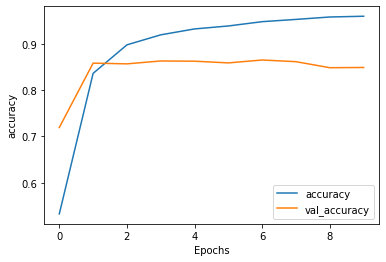

In [21]:
plot_graphs(history, 'accuracy')

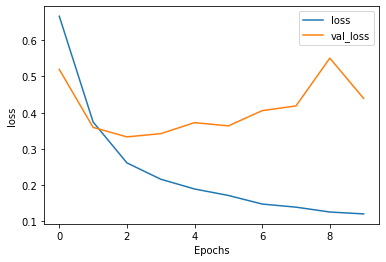

In [22]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6930 - accuracy: 0.5469

  2/391 [..............................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4922

  3/391 [..............................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5156

  4/391 [..............................] - ETA: 53s - loss: 0.6924 - accuracy: 0.5312

  5/391 [..............................] - ETA: 58s - loss: 0.6922 - accuracy: 0.5312

  6/391 [..............................] - ETA: 1:00 - loss: 0.6922 - accuracy: 0.5469

  7/391 [..............................] - ETA: 1:03 - loss: 0.6923 - accuracy: 0.5268

  8/391 [..............................] - ETA: 1:03 - loss: 0.6923 - accuracy: 0.5215

  9/391 [..............................] - ETA: 1:02 - loss: 0.6926 - accuracy: 0.5208

 10/391 [..............................] - ETA: 1:01 - loss: 0.6925 - accuracy: 0.5219

 11/391 [..............................] - ETA: 1:02 - loss: 0.6922 - accuracy: 0.5312

 12/391 [..............................] - ETA: 1:01 - loss: 0.6922 - accuracy: 0.5312

 13/391 [..............................] - ETA: 1:03 - loss: 0.6923 - accuracy: 0.5264

 14/391 [>.............................] - ETA: 1:03 - loss: 0.6923 - accuracy: 0.5246

 15/391 [>.............................] - ETA: 1:02 - loss: 0.6923 - accuracy: 0.5323

 16/391 [>.............................] - ETA: 1:03 - loss: 0.6926 - accuracy: 0.5264

 17/391 [>.............................] - ETA: 1:02 - loss: 0.6927 - accuracy: 0.5230

 18/391 [>.............................] - ETA: 1:02 - loss: 0.6927 - accuracy: 0.5260

 19/391 [>.............................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.5189

 20/391 [>.............................] - ETA: 1:02 - loss: 0.6928 - accuracy: 0.5156

 21/391 [>.............................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.5119

 22/391 [>.............................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.5149

 23/391 [>.............................] - ETA: 1:01 - loss: 0.6929 - accuracy: 0.5143

 24/391 [>.............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5098

 25/391 [>.............................] - ETA: 1:01 - loss: 0.6930 - accuracy: 0.5094

 26/391 [>.............................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5048

 27/391 [=>............................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5058

 28/391 [=>............................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5061

 29/391 [=>............................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5022

 30/391 [=>............................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5036 

 31/391 [=>............................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5020

 32/391 [=>............................] - ETA: 59s - loss: 0.6931 - accuracy: 0.5010

 33/391 [=>............................] - ETA: 58s - loss: 0.6931 - accuracy: 0.4981

 34/391 [=>............................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5009

 35/391 [=>............................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5022

 36/391 [=>............................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5043

 37/391 [=>............................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5025

 38/391 [=>............................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5037

 39/391 [=>............................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5048

 40/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5059

 41/391 [==>...........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5069

 42/391 [==>...........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5063

 43/391 [==>...........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5058

 44/391 [==>...........................] - ETA: 56s - loss: 0.6929 - accuracy: 0.5064

 45/391 [==>...........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5056

 46/391 [==>...........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5020

 47/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5037

 48/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5039

 49/391 [==>...........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5041

 50/391 [==>...........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5031

 51/391 [==>...........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5028

 52/391 [==>...........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5033

 53/391 [===>..........................] - ETA: 57s - loss: 0.6929 - accuracy: 0.5018

 54/391 [===>..........................] - ETA: 56s - loss: 0.6929 - accuracy: 0.5003

 55/391 [===>..........................] - ETA: 56s - loss: 0.6929 - accuracy: 0.4991

 56/391 [===>..........................] - ETA: 56s - loss: 0.6929 - accuracy: 0.4980

 57/391 [===>..........................] - ETA: 56s - loss: 0.6929 - accuracy: 0.4981

 58/391 [===>..........................] - ETA: 56s - loss: 0.6928 - accuracy: 0.4976

 59/391 [===>..........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.5000

 60/391 [===>..........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4992

 61/391 [===>..........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4990

 62/391 [===>..........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4995

 63/391 [===>..........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.5000

 64/391 [===>..........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4993

 65/391 [===>..........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4990

 66/391 [====>.........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.5002

 67/391 [====>.........................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4991

 68/391 [====>.........................] - ETA: 55s - loss: 0.6929 - accuracy: 0.4993

 69/391 [====>.........................] - ETA: 55s - loss: 0.6929 - accuracy: 0.5014

 70/391 [====>.........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.5016

 71/391 [====>.........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.5007

 72/391 [====>.........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.4996

 73/391 [====>.........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.4998

 74/391 [====>.........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.5004

 75/391 [====>.........................] - ETA: 54s - loss: 0.6929 - accuracy: 0.4998

 76/391 [====>.........................] - ETA: 53s - loss: 0.6929 - accuracy: 0.4996

 77/391 [====>.........................] - ETA: 53s - loss: 0.6929 - accuracy: 0.5002

 78/391 [====>.........................] - ETA: 53s - loss: 0.6929 - accuracy: 0.4994

 79/391 [=====>........................] - ETA: 53s - loss: 0.6929 - accuracy: 0.5004

 80/391 [=====>........................] - ETA: 53s - loss: 0.6929 - accuracy: 0.5016

 81/391 [=====>........................] - ETA: 53s - loss: 0.6929 - accuracy: 0.5021

 82/391 [=====>........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5017

 83/391 [=====>........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5024

 84/391 [=====>........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5019

 85/391 [=====>........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5013

 86/391 [=====>........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5013

 87/391 [=====>........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.5000

 88/391 [=====>........................] - ETA: 52s - loss: 0.6929 - accuracy: 0.4996

 89/391 [=====>........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5007

 90/391 [=====>........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5017

 91/391 [=====>........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5034

 92/391 [======>.......................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5037

 93/391 [======>.......................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5037

 94/391 [======>.......................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5030

 95/391 [======>.......................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5035

 96/391 [======>.......................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5029

 97/391 [======>.......................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5019

 98/391 [======>.......................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5018

 99/391 [======>.......................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5016

100/391 [======>.......................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5016

101/391 [======>.......................] - ETA: 49s - loss: 0.6928 - accuracy: 0.5002

102/391 [======>.......................] - ETA: 49s - loss: 0.6928 - accuracy: 0.4995

103/391 [======>.......................] - ETA: 49s - loss: 0.6928 - accuracy: 0.5000

104/391 [======>.......................] - ETA: 49s - loss: 0.6928 - accuracy: 0.4977

105/391 [=======>......................] - ETA: 49s - loss: 0.6928 - accuracy: 0.4987

106/391 [=======>......................] - ETA: 49s - loss: 0.6928 - accuracy: 0.4997

107/391 [=======>......................] - ETA: 49s - loss: 0.6928 - accuracy: 0.5010

108/391 [=======>......................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5019

109/391 [=======>......................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5023

110/391 [=======>......................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5021

111/391 [=======>......................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5006

112/391 [=======>......................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5007

113/391 [=======>......................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5003

114/391 [=======>......................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5003

115/391 [=======>......................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4999

116/391 [=======>......................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4995

117/391 [=======>......................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4997

118/391 [========>.....................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5001

119/391 [========>.....................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5009

120/391 [========>.....................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5005

121/391 [========>.....................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5008

122/391 [========>.....................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5004

123/391 [========>.....................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5005

124/391 [========>.....................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5003

125/391 [========>.....................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5008

126/391 [========>.....................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5012

127/391 [========>.....................] - ETA: 45s - loss: 0.6928 - accuracy: 0.5012

128/391 [========>.....................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5013

129/391 [========>.....................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5012

130/391 [========>.....................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5018

131/391 [=========>....................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5013

132/391 [=========>....................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5014

133/391 [=========>....................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5009

134/391 [=========>....................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5013

135/391 [=========>....................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5006

136/391 [=========>....................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5008

137/391 [=========>....................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5007

138/391 [=========>....................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5014

139/391 [=========>....................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5017

140/391 [=========>....................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5027

141/391 [=========>....................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5030

142/391 [=========>....................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5033

143/391 [=========>....................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5031

144/391 [==========>...................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5028

145/391 [==========>...................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5030

146/391 [==========>...................] - ETA: 42s - loss: 0.6926 - accuracy: 0.5034

147/391 [==========>...................] - ETA: 42s - loss: 0.6926 - accuracy: 0.5036

148/391 [==========>...................] - ETA: 42s - loss: 0.6926 - accuracy: 0.5039

149/391 [==========>...................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5035

150/391 [==========>...................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5030

151/391 [==========>...................] - ETA: 42s - loss: 0.6926 - accuracy: 0.5029

152/391 [==========>...................] - ETA: 42s - loss: 0.6926 - accuracy: 0.5030

153/391 [==========>...................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5026

154/391 [==========>...................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5025

155/391 [==========>...................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5031

156/391 [==========>...................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5025

157/391 [===========>..................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5030

158/391 [===========>..................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5028

159/391 [===========>..................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5028

160/391 [===========>..................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5021

161/391 [===========>..................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5019

162/391 [===========>..................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5024

163/391 [===========>..................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5023

164/391 [===========>..................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5020

165/391 [===========>..................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5026

166/391 [===========>..................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5021

167/391 [===========>..................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5020

168/391 [===========>..................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5021

169/391 [===========>..................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5018

170/391 [============>.................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5020

171/391 [============>.................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5026

172/391 [============>.................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5031

173/391 [============>.................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5027

174/391 [============>.................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5022

175/391 [============>.................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5021

176/391 [============>.................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5020

177/391 [============>.................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5026

178/391 [============>.................] - ETA: 37s - loss: 0.6925 - accuracy: 0.5025

179/391 [============>.................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5019

180/391 [============>.................] - ETA: 37s - loss: 0.6925 - accuracy: 0.5020

181/391 [============>.................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5023

182/391 [============>.................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5024

183/391 [=============>................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5022

184/391 [=============>................] - ETA: 36s - loss: 0.6924 - accuracy: 0.5022

185/391 [=============>................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5018

186/391 [=============>................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5018

187/391 [=============>................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5022

188/391 [=============>................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5017

189/391 [=============>................] - ETA: 36s - loss: 0.6922 - accuracy: 0.5019

190/391 [=============>................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5020

191/391 [=============>................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5019

192/391 [=============>................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5023

193/391 [=============>................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5025

194/391 [=============>................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5021

195/391 [=============>................] - ETA: 34s - loss: 0.6922 - accuracy: 0.5022

196/391 [==============>...............] - ETA: 34s - loss: 0.6921 - accuracy: 0.5022

197/391 [==============>...............] - ETA: 34s - loss: 0.6921 - accuracy: 0.5021

198/391 [==============>...............] - ETA: 34s - loss: 0.6921 - accuracy: 0.5023

199/391 [==============>...............] - ETA: 34s - loss: 0.6920 - accuracy: 0.5020

200/391 [==============>...............] - ETA: 34s - loss: 0.6920 - accuracy: 0.5019

201/391 [==============>...............] - ETA: 33s - loss: 0.6920 - accuracy: 0.5017

202/391 [==============>...............] - ETA: 33s - loss: 0.6920 - accuracy: 0.5015

203/391 [==============>...............] - ETA: 33s - loss: 0.6920 - accuracy: 0.5008

204/391 [==============>...............] - ETA: 33s - loss: 0.6919 - accuracy: 0.5004

205/391 [==============>...............] - ETA: 33s - loss: 0.6919 - accuracy: 0.5003

206/391 [==============>...............] - ETA: 32s - loss: 0.6919 - accuracy: 0.5005

207/391 [==============>...............] - ETA: 32s - loss: 0.6919 - accuracy: 0.5007

208/391 [==============>...............] - ETA: 32s - loss: 0.6919 - accuracy: 0.5011

209/391 [===============>..............] - ETA: 32s - loss: 0.6918 - accuracy: 0.5010

210/391 [===============>..............] - ETA: 32s - loss: 0.6918 - accuracy: 0.5013

211/391 [===============>..............] - ETA: 32s - loss: 0.6918 - accuracy: 0.5014

212/391 [===============>..............] - ETA: 31s - loss: 0.6917 - accuracy: 0.5010

213/391 [===============>..............] - ETA: 31s - loss: 0.6917 - accuracy: 0.5011

214/391 [===============>..............] - ETA: 31s - loss: 0.6917 - accuracy: 0.5009

215/391 [===============>..............] - ETA: 31s - loss: 0.6916 - accuracy: 0.5003

216/391 [===============>..............] - ETA: 31s - loss: 0.6916 - accuracy: 0.5001

217/391 [===============>..............] - ETA: 31s - loss: 0.6916 - accuracy: 0.5001

218/391 [===============>..............] - ETA: 30s - loss: 0.6915 - accuracy: 0.5003

219/391 [===============>..............] - ETA: 30s - loss: 0.6914 - accuracy: 0.4996

220/391 [===============>..............] - ETA: 30s - loss: 0.6913 - accuracy: 0.4995

221/391 [===============>..............] - ETA: 30s - loss: 0.6912 - accuracy: 0.4996

222/391 [================>.............] - ETA: 30s - loss: 0.6911 - accuracy: 0.4994

223/391 [================>.............] - ETA: 29s - loss: 0.6910 - accuracy: 0.4994

224/391 [================>.............] - ETA: 29s - loss: 0.6909 - accuracy: 0.4993

225/391 [================>.............] - ETA: 29s - loss: 0.6909 - accuracy: 0.4996

226/391 [================>.............] - ETA: 29s - loss: 0.6907 - accuracy: 0.4993

227/391 [================>.............] - ETA: 29s - loss: 0.6906 - accuracy: 0.4994

228/391 [================>.............] - ETA: 29s - loss: 0.6906 - accuracy: 0.4992

229/391 [================>.............] - ETA: 28s - loss: 0.6904 - accuracy: 0.4998

230/391 [================>.............] - ETA: 28s - loss: 0.6904 - accuracy: 0.5004

231/391 [================>.............] - ETA: 28s - loss: 0.6903 - accuracy: 0.5003

232/391 [================>.............] - ETA: 28s - loss: 0.6901 - accuracy: 0.4996

233/391 [================>.............] - ETA: 28s - loss: 0.6899 - accuracy: 0.4995

234/391 [================>.............] - ETA: 27s - loss: 0.6897 - accuracy: 0.5001

235/391 [=================>............] - ETA: 27s - loss: 0.6895 - accuracy: 0.5005

236/391 [=================>............] - ETA: 27s - loss: 0.6894 - accuracy: 0.5014

237/391 [=================>............] - ETA: 27s - loss: 0.6893 - accuracy: 0.5020

238/391 [=================>............] - ETA: 27s - loss: 0.6891 - accuracy: 0.5021

239/391 [=================>............] - ETA: 27s - loss: 0.6889 - accuracy: 0.5026

240/391 [=================>............] - ETA: 26s - loss: 0.6889 - accuracy: 0.5023

241/391 [=================>............] - ETA: 26s - loss: 0.6886 - accuracy: 0.5023

242/391 [=================>............] - ETA: 26s - loss: 0.6885 - accuracy: 0.5023

243/391 [=================>............] - ETA: 26s - loss: 0.6883 - accuracy: 0.5024

244/391 [=================>............] - ETA: 26s - loss: 0.6879 - accuracy: 0.5026

245/391 [=================>............] - ETA: 25s - loss: 0.6877 - accuracy: 0.5031

246/391 [=================>............] - ETA: 25s - loss: 0.6875 - accuracy: 0.5041

247/391 [=================>............] - ETA: 25s - loss: 0.6872 - accuracy: 0.5046

248/391 [==================>...........] - ETA: 25s - loss: 0.6869 - accuracy: 0.5052

249/391 [==================>...........] - ETA: 25s - loss: 0.6866 - accuracy: 0.5058

250/391 [==================>...........] - ETA: 25s - loss: 0.6862 - accuracy: 0.5065

251/391 [==================>...........] - ETA: 24s - loss: 0.6860 - accuracy: 0.5071

252/391 [==================>...........] - ETA: 24s - loss: 0.6857 - accuracy: 0.5078

253/391 [==================>...........] - ETA: 24s - loss: 0.6854 - accuracy: 0.5081

254/391 [==================>...........] - ETA: 24s - loss: 0.6853 - accuracy: 0.5082

255/391 [==================>...........] - ETA: 24s - loss: 0.6847 - accuracy: 0.5091

256/391 [==================>...........] - ETA: 24s - loss: 0.6841 - accuracy: 0.5097

257/391 [==================>...........] - ETA: 23s - loss: 0.6838 - accuracy: 0.5102

258/391 [==================>...........] - ETA: 23s - loss: 0.6834 - accuracy: 0.5111

259/391 [==================>...........] - ETA: 23s - loss: 0.6833 - accuracy: 0.5115

260/391 [==================>...........] - ETA: 23s - loss: 0.6830 - accuracy: 0.5121

261/391 [===================>..........] - ETA: 23s - loss: 0.6827 - accuracy: 0.5126

262/391 [===================>..........] - ETA: 23s - loss: 0.6821 - accuracy: 0.5137

263/391 [===================>..........] - ETA: 22s - loss: 0.6819 - accuracy: 0.5143

264/391 [===================>..........] - ETA: 22s - loss: 0.6816 - accuracy: 0.5149

265/391 [===================>..........] - ETA: 22s - loss: 0.6816 - accuracy: 0.5151

266/391 [===================>..........] - ETA: 22s - loss: 0.6813 - accuracy: 0.5156

267/391 [===================>..........] - ETA: 22s - loss: 0.6808 - accuracy: 0.5163

268/391 [===================>..........] - ETA: 21s - loss: 0.6807 - accuracy: 0.5164

269/391 [===================>..........] - ETA: 21s - loss: 0.6803 - accuracy: 0.5169

270/391 [===================>..........] - ETA: 21s - loss: 0.6801 - accuracy: 0.5170

271/391 [===================>..........] - ETA: 21s - loss: 0.6796 - accuracy: 0.5177

272/391 [===================>..........] - ETA: 21s - loss: 0.6793 - accuracy: 0.5180

273/391 [===================>..........] - ETA: 21s - loss: 0.6789 - accuracy: 0.5187

274/391 [====================>.........] - ETA: 20s - loss: 0.6787 - accuracy: 0.5191

275/391 [====================>.........] - ETA: 20s - loss: 0.6784 - accuracy: 0.5195

276/391 [====================>.........] - ETA: 20s - loss: 0.6780 - accuracy: 0.5203

277/391 [====================>.........] - ETA: 20s - loss: 0.6778 - accuracy: 0.5209

278/391 [====================>.........] - ETA: 20s - loss: 0.6774 - accuracy: 0.5215

279/391 [====================>.........] - ETA: 20s - loss: 0.6771 - accuracy: 0.5219

280/391 [====================>.........] - ETA: 19s - loss: 0.6765 - accuracy: 0.5231

281/391 [====================>.........] - ETA: 19s - loss: 0.6761 - accuracy: 0.5241

282/391 [====================>.........] - ETA: 19s - loss: 0.6755 - accuracy: 0.5250

283/391 [====================>.........] - ETA: 19s - loss: 0.6753 - accuracy: 0.5255

284/391 [====================>.........] - ETA: 19s - loss: 0.6748 - accuracy: 0.5266

285/391 [====================>.........] - ETA: 18s - loss: 0.6745 - accuracy: 0.5271

286/391 [====================>.........] - ETA: 18s - loss: 0.6741 - accuracy: 0.5278

287/391 [=====================>........] - ETA: 18s - loss: 0.6738 - accuracy: 0.5282

288/391 [=====================>........] - ETA: 18s - loss: 0.6732 - accuracy: 0.5290

289/391 [=====================>........] - ETA: 18s - loss: 0.6725 - accuracy: 0.5298

290/391 [=====================>........] - ETA: 18s - loss: 0.6721 - accuracy: 0.5306

291/391 [=====================>........] - ETA: 17s - loss: 0.6716 - accuracy: 0.5312

292/391 [=====================>........] - ETA: 17s - loss: 0.6711 - accuracy: 0.5319

293/391 [=====================>........] - ETA: 17s - loss: 0.6706 - accuracy: 0.5326

294/391 [=====================>........] - ETA: 17s - loss: 0.6703 - accuracy: 0.5333

295/391 [=====================>........] - ETA: 17s - loss: 0.6701 - accuracy: 0.5339

296/391 [=====================>........] - ETA: 16s - loss: 0.6696 - accuracy: 0.5347

297/391 [=====================>........] - ETA: 16s - loss: 0.6692 - accuracy: 0.5355

298/391 [=====================>........] - ETA: 16s - loss: 0.6692 - accuracy: 0.5361

299/391 [=====================>........] - ETA: 16s - loss: 0.6712 - accuracy: 0.5357

300/391 [======================>.......] - ETA: 16s - loss: 0.6727 - accuracy: 0.5355

301/391 [======================>.......] - ETA: 16s - loss: 0.6740 - accuracy: 0.5355

302/391 [======================>.......] - ETA: 15s - loss: 0.6742 - accuracy: 0.5360

303/391 [======================>.......] - ETA: 15s - loss: 0.6756 - accuracy: 0.5358

304/391 [======================>.......] - ETA: 15s - loss: 0.6768 - accuracy: 0.5358

305/391 [======================>.......] - ETA: 15s - loss: 0.6778 - accuracy: 0.5357

306/391 [======================>.......] - ETA: 15s - loss: 0.6788 - accuracy: 0.5356

307/391 [======================>.......] - ETA: 15s - loss: 0.6799 - accuracy: 0.5354

308/391 [======================>.......] - ETA: 14s - loss: 0.6804 - accuracy: 0.5355

309/391 [======================>.......] - ETA: 14s - loss: 0.6805 - accuracy: 0.5359

310/391 [======================>.......] - ETA: 14s - loss: 0.6809 - accuracy: 0.5360

311/391 [======================>.......] - ETA: 14s - loss: 0.6815 - accuracy: 0.5360

312/391 [======================>.......] - ETA: 14s - loss: 0.6821 - accuracy: 0.5360

313/391 [=======================>......] - ETA: 13s - loss: 0.6833 - accuracy: 0.5354

314/391 [=======================>......] - ETA: 13s - loss: 0.6839 - accuracy: 0.5352

315/391 [=======================>......] - ETA: 13s - loss: 0.6839 - accuracy: 0.5354

316/391 [=======================>......] - ETA: 13s - loss: 0.6846 - accuracy: 0.5353

317/391 [=======================>......] - ETA: 13s - loss: 0.6846 - accuracy: 0.5354

318/391 [=======================>......] - ETA: 13s - loss: 0.6849 - accuracy: 0.5353

319/391 [=======================>......] - ETA: 12s - loss: 0.6850 - accuracy: 0.5353

320/391 [=======================>......] - ETA: 12s - loss: 0.6852 - accuracy: 0.5349

321/391 [=======================>......] - ETA: 12s - loss: 0.6851 - accuracy: 0.5349

322/391 [=======================>......] - ETA: 12s - loss: 0.6849 - accuracy: 0.5347

323/391 [=======================>......] - ETA: 12s - loss: 0.6848 - accuracy: 0.5348

324/391 [=======================>......] - ETA: 11s - loss: 0.6846 - accuracy: 0.5349

325/391 [=======================>......] - ETA: 11s - loss: 0.6843 - accuracy: 0.5352

326/391 [========================>.....] - ETA: 11s - loss: 0.6841 - accuracy: 0.5356

327/391 [========================>.....] - ETA: 11s - loss: 0.6838 - accuracy: 0.5357

328/391 [========================>.....] - ETA: 11s - loss: 0.6837 - accuracy: 0.5357

329/391 [========================>.....] - ETA: 11s - loss: 0.6834 - accuracy: 0.5361

330/391 [========================>.....] - ETA: 10s - loss: 0.6832 - accuracy: 0.5364

331/391 [========================>.....] - ETA: 10s - loss: 0.6829 - accuracy: 0.5368

332/391 [========================>.....] - ETA: 10s - loss: 0.6827 - accuracy: 0.5374

333/391 [========================>.....] - ETA: 10s - loss: 0.6823 - accuracy: 0.5381

334/391 [========================>.....] - ETA: 10s - loss: 0.6823 - accuracy: 0.5385

335/391 [========================>.....] - ETA: 9s - loss: 0.6821 - accuracy: 0.5391 

336/391 [========================>.....] - ETA: 9s - loss: 0.6819 - accuracy: 0.5399

337/391 [========================>.....] - ETA: 9s - loss: 0.6817 - accuracy: 0.5403

338/391 [========================>.....] - ETA: 9s - loss: 0.6813 - accuracy: 0.5411

339/391 [=========================>....] - ETA: 9s - loss: 0.6812 - accuracy: 0.5417

340/391 [=========================>....] - ETA: 9s - loss: 0.6812 - accuracy: 0.5421

341/391 [=========================>....] - ETA: 8s - loss: 0.6810 - accuracy: 0.5428

342/391 [=========================>....] - ETA: 8s - loss: 0.6806 - accuracy: 0.5433

343/391 [=========================>....] - ETA: 8s - loss: 0.6802 - accuracy: 0.5440

344/391 [=========================>....] - ETA: 8s - loss: 0.6799 - accuracy: 0.5447

345/391 [=========================>....] - ETA: 8s - loss: 0.6797 - accuracy: 0.5456

346/391 [=========================>....] - ETA: 8s - loss: 0.6793 - accuracy: 0.5461

347/391 [=========================>....] - ETA: 7s - loss: 0.6791 - accuracy: 0.5466

348/391 [=========================>....] - ETA: 7s - loss: 0.6789 - accuracy: 0.5470

349/391 [=========================>....] - ETA: 7s - loss: 0.6786 - accuracy: 0.5473

350/391 [=========================>....] - ETA: 7s - loss: 0.6783 - accuracy: 0.5480

351/391 [=========================>....] - ETA: 7s - loss: 0.6781 - accuracy: 0.5485

352/391 [==========================>...] - ETA: 6s - loss: 0.6777 - accuracy: 0.5490

353/391 [==========================>...] - ETA: 6s - loss: 0.6774 - accuracy: 0.5494

354/391 [==========================>...] - ETA: 6s - loss: 0.6772 - accuracy: 0.5498

355/391 [==========================>...] - ETA: 6s - loss: 0.6769 - accuracy: 0.5503

356/391 [==========================>...] - ETA: 6s - loss: 0.6767 - accuracy: 0.5507

357/391 [==========================>...] - ETA: 6s - loss: 0.6765 - accuracy: 0.5509

358/391 [==========================>...] - ETA: 5s - loss: 0.6759 - accuracy: 0.5518

359/391 [==========================>...] - ETA: 5s - loss: 0.6755 - accuracy: 0.5522

360/391 [==========================>...] - ETA: 5s - loss: 0.6754 - accuracy: 0.5526

361/391 [==========================>...] - ETA: 5s - loss: 0.6751 - accuracy: 0.5532

362/391 [==========================>...] - ETA: 5s - loss: 0.6747 - accuracy: 0.5538

363/391 [==========================>...] - ETA: 5s - loss: 0.6743 - accuracy: 0.5542

364/391 [==========================>...] - ETA: 4s - loss: 0.6740 - accuracy: 0.5545

365/391 [===========================>..] - ETA: 4s - loss: 0.6737 - accuracy: 0.5550

366/391 [===========================>..] - ETA: 4s - loss: 0.6734 - accuracy: 0.5555

367/391 [===========================>..] - ETA: 4s - loss: 0.6729 - accuracy: 0.5562

368/391 [===========================>..] - ETA: 4s - loss: 0.6726 - accuracy: 0.5567

369/391 [===========================>..] - ETA: 3s - loss: 0.6720 - accuracy: 0.5576

370/391 [===========================>..] - ETA: 3s - loss: 0.6720 - accuracy: 0.5577

371/391 [===========================>..] - ETA: 3s - loss: 0.6715 - accuracy: 0.5584

372/391 [===========================>..] - ETA: 3s - loss: 0.6711 - accuracy: 0.5590

373/391 [===========================>..] - ETA: 3s - loss: 0.6709 - accuracy: 0.5593

374/391 [===========================>..] - ETA: 3s - loss: 0.6705 - accuracy: 0.5598

375/391 [===========================>..] - ETA: 2s - loss: 0.6700 - accuracy: 0.5604

376/391 [===========================>..] - ETA: 2s - loss: 0.6698 - accuracy: 0.5605

377/391 [===========================>..] - ETA: 2s - loss: 0.6695 - accuracy: 0.5609

378/391 [============================>.] - ETA: 2s - loss: 0.6692 - accuracy: 0.5612

379/391 [============================>.] - ETA: 2s - loss: 0.6690 - accuracy: 0.5614

380/391 [============================>.] - ETA: 1s - loss: 0.6688 - accuracy: 0.5616

381/391 [============================>.] - ETA: 1s - loss: 0.6683 - accuracy: 0.5623

382/391 [============================>.] - ETA: 1s - loss: 0.6679 - accuracy: 0.5627

383/391 [============================>.] - ETA: 1s - loss: 0.6676 - accuracy: 0.5631

384/391 [============================>.] - ETA: 1s - loss: 0.6674 - accuracy: 0.5634

385/391 [============================>.] - ETA: 1s - loss: 0.6670 - accuracy: 0.5640

386/391 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.5647

387/391 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.5652

388/391 [============================>.] - ETA: 0s - loss: 0.6660 - accuracy: 0.5657

389/391 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.5662

390/391 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.5665

391/391 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.5668

391/391 [==============================] - 74s 189ms/step - loss: 0.6651 - accuracy: 0.5668 - val_loss: 0.5812 - val_accuracy: 0.7479


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.5567 - accuracy: 0.7656

  2/391 [..............................] - ETA: 29s - loss: 0.5611 - accuracy: 0.7734

  3/391 [..............................] - ETA: 39s - loss: 0.5560 - accuracy: 0.7760

  4/391 [..............................] - ETA: 46s - loss: 0.5629 - accuracy: 0.7734

  5/391 [..............................] - ETA: 52s - loss: 0.5503 - accuracy: 0.7719

  6/391 [..............................] - ETA: 54s - loss: 0.5312 - accuracy: 0.7708

  7/391 [..............................] - ETA: 56s - loss: 0.5200 - accuracy: 0.7790

  8/391 [..............................] - ETA: 59s - loss: 0.5242 - accuracy: 0.7695

  9/391 [..............................] - ETA: 59s - loss: 0.5220 - accuracy: 0.7726

 10/391 [..............................] - ETA: 59s - loss: 0.5259 - accuracy: 0.7672

 11/391 [..............................] - ETA: 58s - loss: 0.5338 - accuracy: 0.7528

 12/391 [..............................] - ETA: 59s - loss: 0.5312 - accuracy: 0.7539

 13/391 [..............................] - ETA: 1:00 - loss: 0.5297 - accuracy: 0.7548

 14/391 [>.............................] - ETA: 1:01 - loss: 0.5339 - accuracy: 0.7467

 15/391 [>.............................] - ETA: 1:02 - loss: 0.5288 - accuracy: 0.7510

 16/391 [>.............................] - ETA: 1:01 - loss: 0.5225 - accuracy: 0.7568

 17/391 [>.............................] - ETA: 1:02 - loss: 0.5166 - accuracy: 0.7638

 18/391 [>.............................] - ETA: 1:03 - loss: 0.5182 - accuracy: 0.7648

 19/391 [>.............................] - ETA: 1:03 - loss: 0.5184 - accuracy: 0.7615

 20/391 [>.............................] - ETA: 1:02 - loss: 0.5172 - accuracy: 0.7609

 21/391 [>.............................] - ETA: 1:03 - loss: 0.5161 - accuracy: 0.7619

 22/391 [>.............................] - ETA: 1:03 - loss: 0.5138 - accuracy: 0.7642

 23/391 [>.............................] - ETA: 1:03 - loss: 0.5110 - accuracy: 0.7683

 24/391 [>.............................] - ETA: 1:02 - loss: 0.5069 - accuracy: 0.7734

 25/391 [>.............................] - ETA: 1:02 - loss: 0.5038 - accuracy: 0.7750

 26/391 [>.............................] - ETA: 1:02 - loss: 0.5039 - accuracy: 0.7752

 27/391 [=>............................] - ETA: 1:02 - loss: 0.5045 - accuracy: 0.7731

 28/391 [=>............................] - ETA: 1:01 - loss: 0.5044 - accuracy: 0.7712

 29/391 [=>............................] - ETA: 1:01 - loss: 0.5027 - accuracy: 0.7705

 30/391 [=>............................] - ETA: 1:00 - loss: 0.4986 - accuracy: 0.7740

 31/391 [=>............................] - ETA: 1:01 - loss: 0.4957 - accuracy: 0.7767

 32/391 [=>............................] - ETA: 1:01 - loss: 0.4942 - accuracy: 0.7783

 33/391 [=>............................] - ETA: 1:00 - loss: 0.4941 - accuracy: 0.7794

 34/391 [=>............................] - ETA: 1:01 - loss: 0.4912 - accuracy: 0.7817

 35/391 [=>............................] - ETA: 1:00 - loss: 0.4881 - accuracy: 0.7844

 36/391 [=>............................] - ETA: 1:00 - loss: 0.4855 - accuracy: 0.7852

 37/391 [=>............................] - ETA: 1:00 - loss: 0.4832 - accuracy: 0.7863

 38/391 [=>............................] - ETA: 1:00 - loss: 0.4811 - accuracy: 0.7874

 39/391 [=>............................] - ETA: 1:00 - loss: 0.4809 - accuracy: 0.7881

 40/391 [==>...........................] - ETA: 1:00 - loss: 0.4789 - accuracy: 0.7898

 41/391 [==>...........................] - ETA: 1:00 - loss: 0.4777 - accuracy: 0.7912

 42/391 [==>...........................] - ETA: 59s - loss: 0.4789 - accuracy: 0.7906 

 43/391 [==>...........................] - ETA: 59s - loss: 0.4780 - accuracy: 0.7918

 44/391 [==>...........................] - ETA: 59s - loss: 0.4777 - accuracy: 0.7912

 45/391 [==>...........................] - ETA: 58s - loss: 0.4765 - accuracy: 0.7924

 46/391 [==>...........................] - ETA: 59s - loss: 0.4744 - accuracy: 0.7935

 47/391 [==>...........................] - ETA: 58s - loss: 0.4727 - accuracy: 0.7945

 48/391 [==>...........................] - ETA: 59s - loss: 0.4728 - accuracy: 0.7939

 49/391 [==>...........................] - ETA: 59s - loss: 0.4731 - accuracy: 0.7934

 50/391 [==>...........................] - ETA: 59s - loss: 0.4743 - accuracy: 0.7925

 51/391 [==>...........................] - ETA: 59s - loss: 0.4721 - accuracy: 0.7938

 52/391 [==>...........................] - ETA: 58s - loss: 0.4721 - accuracy: 0.7939

 53/391 [===>..........................] - ETA: 58s - loss: 0.4710 - accuracy: 0.7939

 54/391 [===>..........................] - ETA: 58s - loss: 0.4695 - accuracy: 0.7957

 55/391 [===>..........................] - ETA: 58s - loss: 0.4690 - accuracy: 0.7960

 56/391 [===>..........................] - ETA: 58s - loss: 0.4686 - accuracy: 0.7969

 57/391 [===>..........................] - ETA: 57s - loss: 0.4664 - accuracy: 0.7985

 58/391 [===>..........................] - ETA: 57s - loss: 0.4669 - accuracy: 0.7988

 59/391 [===>..........................] - ETA: 57s - loss: 0.4665 - accuracy: 0.7987

 60/391 [===>..........................] - ETA: 57s - loss: 0.4685 - accuracy: 0.7971

 61/391 [===>..........................] - ETA: 57s - loss: 0.4671 - accuracy: 0.7984

 62/391 [===>..........................] - ETA: 57s - loss: 0.4679 - accuracy: 0.7979

 63/391 [===>..........................] - ETA: 57s - loss: 0.4675 - accuracy: 0.7981

 64/391 [===>..........................] - ETA: 57s - loss: 0.4674 - accuracy: 0.7981

 65/391 [===>..........................] - ETA: 57s - loss: 0.4676 - accuracy: 0.7976

 66/391 [====>.........................] - ETA: 56s - loss: 0.4674 - accuracy: 0.7978

 67/391 [====>.........................] - ETA: 56s - loss: 0.4681 - accuracy: 0.7976

 68/391 [====>.........................] - ETA: 56s - loss: 0.4694 - accuracy: 0.7960

 69/391 [====>.........................] - ETA: 56s - loss: 0.4689 - accuracy: 0.7962

 70/391 [====>.........................] - ETA: 55s - loss: 0.4703 - accuracy: 0.7958

 71/391 [====>.........................] - ETA: 55s - loss: 0.4706 - accuracy: 0.7951

 72/391 [====>.........................] - ETA: 55s - loss: 0.4706 - accuracy: 0.7951

 73/391 [====>.........................] - ETA: 55s - loss: 0.4702 - accuracy: 0.7952

 74/391 [====>.........................] - ETA: 55s - loss: 0.4695 - accuracy: 0.7960

 75/391 [====>.........................] - ETA: 54s - loss: 0.4691 - accuracy: 0.7960

 76/391 [====>.........................] - ETA: 54s - loss: 0.4690 - accuracy: 0.7958

 77/391 [====>.........................] - ETA: 54s - loss: 0.4673 - accuracy: 0.7975

 78/391 [====>.........................] - ETA: 53s - loss: 0.4682 - accuracy: 0.7971

 79/391 [=====>........................] - ETA: 53s - loss: 0.4680 - accuracy: 0.7977

 80/391 [=====>........................] - ETA: 53s - loss: 0.4683 - accuracy: 0.7973

 81/391 [=====>........................] - ETA: 53s - loss: 0.4668 - accuracy: 0.7984

 82/391 [=====>........................] - ETA: 53s - loss: 0.4673 - accuracy: 0.7986

 83/391 [=====>........................] - ETA: 53s - loss: 0.4677 - accuracy: 0.7980

 84/391 [=====>........................] - ETA: 53s - loss: 0.4677 - accuracy: 0.7980

 85/391 [=====>........................] - ETA: 53s - loss: 0.4671 - accuracy: 0.7985

 86/391 [=====>........................] - ETA: 52s - loss: 0.4678 - accuracy: 0.7987

 87/391 [=====>........................] - ETA: 52s - loss: 0.4680 - accuracy: 0.7981

 88/391 [=====>........................] - ETA: 52s - loss: 0.4685 - accuracy: 0.7978

 89/391 [=====>........................] - ETA: 51s - loss: 0.4692 - accuracy: 0.7965

 90/391 [=====>........................] - ETA: 51s - loss: 0.4705 - accuracy: 0.7946

 91/391 [=====>........................] - ETA: 51s - loss: 0.4708 - accuracy: 0.7938

 92/391 [======>.......................] - ETA: 51s - loss: 0.4708 - accuracy: 0.7930

 93/391 [======>.......................] - ETA: 51s - loss: 0.4696 - accuracy: 0.7942

 94/391 [======>.......................] - ETA: 51s - loss: 0.4692 - accuracy: 0.7944

 95/391 [======>.......................] - ETA: 51s - loss: 0.4685 - accuracy: 0.7952

 96/391 [======>.......................] - ETA: 51s - loss: 0.4680 - accuracy: 0.7961

 97/391 [======>.......................] - ETA: 50s - loss: 0.4700 - accuracy: 0.7949

 98/391 [======>.......................] - ETA: 50s - loss: 0.4702 - accuracy: 0.7946

 99/391 [======>.......................] - ETA: 50s - loss: 0.4694 - accuracy: 0.7955

100/391 [======>.......................] - ETA: 50s - loss: 0.4692 - accuracy: 0.7962

101/391 [======>.......................] - ETA: 49s - loss: 0.4696 - accuracy: 0.7963

102/391 [======>.......................] - ETA: 49s - loss: 0.4693 - accuracy: 0.7970

103/391 [======>.......................] - ETA: 49s - loss: 0.4693 - accuracy: 0.7973

104/391 [======>.......................] - ETA: 49s - loss: 0.4691 - accuracy: 0.7975

105/391 [=======>......................] - ETA: 49s - loss: 0.4687 - accuracy: 0.7979

106/391 [=======>......................] - ETA: 49s - loss: 0.4685 - accuracy: 0.7981

107/391 [=======>......................] - ETA: 49s - loss: 0.4689 - accuracy: 0.7970

108/391 [=======>......................] - ETA: 48s - loss: 0.4693 - accuracy: 0.7967

109/391 [=======>......................] - ETA: 48s - loss: 0.4693 - accuracy: 0.7962

110/391 [=======>......................] - ETA: 48s - loss: 0.4691 - accuracy: 0.7962

111/391 [=======>......................] - ETA: 48s - loss: 0.4689 - accuracy: 0.7963

112/391 [=======>......................] - ETA: 48s - loss: 0.4685 - accuracy: 0.7967

113/391 [=======>......................] - ETA: 47s - loss: 0.4676 - accuracy: 0.7974

114/391 [=======>......................] - ETA: 47s - loss: 0.4669 - accuracy: 0.7976

115/391 [=======>......................] - ETA: 47s - loss: 0.4662 - accuracy: 0.7977

116/391 [=======>......................] - ETA: 47s - loss: 0.4660 - accuracy: 0.7980

117/391 [=======>......................] - ETA: 47s - loss: 0.4653 - accuracy: 0.7985

118/391 [========>.....................] - ETA: 47s - loss: 0.4653 - accuracy: 0.7986

119/391 [========>.....................] - ETA: 47s - loss: 0.4661 - accuracy: 0.7985

120/391 [========>.....................] - ETA: 46s - loss: 0.4664 - accuracy: 0.7986

121/391 [========>.....................] - ETA: 46s - loss: 0.4655 - accuracy: 0.7993

122/391 [========>.....................] - ETA: 46s - loss: 0.4654 - accuracy: 0.7993

123/391 [========>.....................] - ETA: 46s - loss: 0.4657 - accuracy: 0.7992

124/391 [========>.....................] - ETA: 46s - loss: 0.4652 - accuracy: 0.7996

125/391 [========>.....................] - ETA: 46s - loss: 0.4645 - accuracy: 0.8001

126/391 [========>.....................] - ETA: 46s - loss: 0.4640 - accuracy: 0.8005

127/391 [========>.....................] - ETA: 45s - loss: 0.4630 - accuracy: 0.8012

128/391 [========>.....................] - ETA: 45s - loss: 0.4630 - accuracy: 0.8008

129/391 [========>.....................] - ETA: 45s - loss: 0.4627 - accuracy: 0.8010

130/391 [========>.....................] - ETA: 45s - loss: 0.4627 - accuracy: 0.8010

131/391 [=========>....................] - ETA: 44s - loss: 0.4620 - accuracy: 0.8013

132/391 [=========>....................] - ETA: 44s - loss: 0.4617 - accuracy: 0.8011

133/391 [=========>....................] - ETA: 44s - loss: 0.4616 - accuracy: 0.8009

134/391 [=========>....................] - ETA: 44s - loss: 0.4616 - accuracy: 0.8010

135/391 [=========>....................] - ETA: 44s - loss: 0.4606 - accuracy: 0.8017

136/391 [=========>....................] - ETA: 44s - loss: 0.4607 - accuracy: 0.8019

137/391 [=========>....................] - ETA: 44s - loss: 0.4598 - accuracy: 0.8021

138/391 [=========>....................] - ETA: 43s - loss: 0.4590 - accuracy: 0.8025

139/391 [=========>....................] - ETA: 43s - loss: 0.4594 - accuracy: 0.8022

140/391 [=========>....................] - ETA: 43s - loss: 0.4595 - accuracy: 0.8023

141/391 [=========>....................] - ETA: 43s - loss: 0.4588 - accuracy: 0.8025

142/391 [=========>....................] - ETA: 43s - loss: 0.4582 - accuracy: 0.8027

143/391 [=========>....................] - ETA: 43s - loss: 0.4582 - accuracy: 0.8029

144/391 [==========>...................] - ETA: 42s - loss: 0.4575 - accuracy: 0.8034

145/391 [==========>...................] - ETA: 42s - loss: 0.4571 - accuracy: 0.8036

146/391 [==========>...................] - ETA: 42s - loss: 0.4575 - accuracy: 0.8035

147/391 [==========>...................] - ETA: 42s - loss: 0.4572 - accuracy: 0.8037

148/391 [==========>...................] - ETA: 42s - loss: 0.4573 - accuracy: 0.8036

149/391 [==========>...................] - ETA: 42s - loss: 0.4565 - accuracy: 0.8041

150/391 [==========>...................] - ETA: 42s - loss: 0.4554 - accuracy: 0.8048

151/391 [==========>...................] - ETA: 41s - loss: 0.4553 - accuracy: 0.8049

152/391 [==========>...................] - ETA: 41s - loss: 0.4551 - accuracy: 0.8053

153/391 [==========>...................] - ETA: 41s - loss: 0.4549 - accuracy: 0.8054

154/391 [==========>...................] - ETA: 41s - loss: 0.4547 - accuracy: 0.8055

155/391 [==========>...................] - ETA: 41s - loss: 0.4556 - accuracy: 0.8055

156/391 [==========>...................] - ETA: 40s - loss: 0.4554 - accuracy: 0.8059

157/391 [===========>..................] - ETA: 40s - loss: 0.4554 - accuracy: 0.8061

158/391 [===========>..................] - ETA: 40s - loss: 0.4546 - accuracy: 0.8065

159/391 [===========>..................] - ETA: 40s - loss: 0.4542 - accuracy: 0.8068

160/391 [===========>..................] - ETA: 40s - loss: 0.4538 - accuracy: 0.8069

161/391 [===========>..................] - ETA: 40s - loss: 0.4540 - accuracy: 0.8066

162/391 [===========>..................] - ETA: 39s - loss: 0.4537 - accuracy: 0.8066

163/391 [===========>..................] - ETA: 39s - loss: 0.4527 - accuracy: 0.8073

164/391 [===========>..................] - ETA: 39s - loss: 0.4524 - accuracy: 0.8074

165/391 [===========>..................] - ETA: 39s - loss: 0.4515 - accuracy: 0.8080

166/391 [===========>..................] - ETA: 39s - loss: 0.4511 - accuracy: 0.8084

167/391 [===========>..................] - ETA: 39s - loss: 0.4509 - accuracy: 0.8084

168/391 [===========>..................] - ETA: 38s - loss: 0.4506 - accuracy: 0.8084

169/391 [===========>..................] - ETA: 38s - loss: 0.4503 - accuracy: 0.8086

170/391 [============>.................] - ETA: 38s - loss: 0.4503 - accuracy: 0.8085

171/391 [============>.................] - ETA: 38s - loss: 0.4503 - accuracy: 0.8089

172/391 [============>.................] - ETA: 38s - loss: 0.4496 - accuracy: 0.8093

173/391 [============>.................] - ETA: 38s - loss: 0.4495 - accuracy: 0.8094

174/391 [============>.................] - ETA: 37s - loss: 0.4485 - accuracy: 0.8100

175/391 [============>.................] - ETA: 37s - loss: 0.4484 - accuracy: 0.8100

176/391 [============>.................] - ETA: 37s - loss: 0.4480 - accuracy: 0.8101

177/391 [============>.................] - ETA: 37s - loss: 0.4478 - accuracy: 0.8100

178/391 [============>.................] - ETA: 37s - loss: 0.4473 - accuracy: 0.8101

179/391 [============>.................] - ETA: 36s - loss: 0.4469 - accuracy: 0.8101

180/391 [============>.................] - ETA: 36s - loss: 0.4468 - accuracy: 0.8102

181/391 [============>.................] - ETA: 36s - loss: 0.4466 - accuracy: 0.8103

182/391 [============>.................] - ETA: 36s - loss: 0.4462 - accuracy: 0.8106

183/391 [=============>................] - ETA: 36s - loss: 0.4453 - accuracy: 0.8110

184/391 [=============>................] - ETA: 36s - loss: 0.4451 - accuracy: 0.8112

185/391 [=============>................] - ETA: 35s - loss: 0.4453 - accuracy: 0.8111

186/391 [=============>................] - ETA: 35s - loss: 0.4449 - accuracy: 0.8117

187/391 [=============>................] - ETA: 35s - loss: 0.4445 - accuracy: 0.8119

188/391 [=============>................] - ETA: 35s - loss: 0.4441 - accuracy: 0.8123

189/391 [=============>................] - ETA: 35s - loss: 0.4440 - accuracy: 0.8123

190/391 [=============>................] - ETA: 35s - loss: 0.4435 - accuracy: 0.8127

191/391 [=============>................] - ETA: 35s - loss: 0.4430 - accuracy: 0.8129

192/391 [=============>................] - ETA: 35s - loss: 0.4425 - accuracy: 0.8132

193/391 [=============>................] - ETA: 34s - loss: 0.4418 - accuracy: 0.8136

194/391 [=============>................] - ETA: 34s - loss: 0.4413 - accuracy: 0.8140

195/391 [=============>................] - ETA: 34s - loss: 0.4408 - accuracy: 0.8143

196/391 [==============>...............] - ETA: 34s - loss: 0.4406 - accuracy: 0.8144

197/391 [==============>...............] - ETA: 34s - loss: 0.4406 - accuracy: 0.8143

198/391 [==============>...............] - ETA: 33s - loss: 0.4398 - accuracy: 0.8147

199/391 [==============>...............] - ETA: 33s - loss: 0.4397 - accuracy: 0.8146

200/391 [==============>...............] - ETA: 33s - loss: 0.4390 - accuracy: 0.8152

201/391 [==============>...............] - ETA: 33s - loss: 0.4381 - accuracy: 0.8158

202/391 [==============>...............] - ETA: 33s - loss: 0.4378 - accuracy: 0.8160

203/391 [==============>...............] - ETA: 33s - loss: 0.4374 - accuracy: 0.8163

204/391 [==============>...............] - ETA: 33s - loss: 0.4374 - accuracy: 0.8164

205/391 [==============>...............] - ETA: 32s - loss: 0.4368 - accuracy: 0.8167

206/391 [==============>...............] - ETA: 32s - loss: 0.4366 - accuracy: 0.8169

207/391 [==============>...............] - ETA: 32s - loss: 0.4364 - accuracy: 0.8173

208/391 [==============>...............] - ETA: 32s - loss: 0.4363 - accuracy: 0.8172

209/391 [===============>..............] - ETA: 32s - loss: 0.4361 - accuracy: 0.8175

210/391 [===============>..............] - ETA: 32s - loss: 0.4356 - accuracy: 0.8173

211/391 [===============>..............] - ETA: 31s - loss: 0.4354 - accuracy: 0.8173

212/391 [===============>..............] - ETA: 31s - loss: 0.4349 - accuracy: 0.8175

213/391 [===============>..............] - ETA: 31s - loss: 0.4351 - accuracy: 0.8172

214/391 [===============>..............] - ETA: 31s - loss: 0.4352 - accuracy: 0.8170

215/391 [===============>..............] - ETA: 31s - loss: 0.4348 - accuracy: 0.8172

216/391 [===============>..............] - ETA: 31s - loss: 0.4343 - accuracy: 0.8174

217/391 [===============>..............] - ETA: 30s - loss: 0.4338 - accuracy: 0.8177

218/391 [===============>..............] - ETA: 30s - loss: 0.4335 - accuracy: 0.8177

219/391 [===============>..............] - ETA: 30s - loss: 0.4334 - accuracy: 0.8179

220/391 [===============>..............] - ETA: 30s - loss: 0.4333 - accuracy: 0.8178

221/391 [===============>..............] - ETA: 30s - loss: 0.4330 - accuracy: 0.8180

222/391 [================>.............] - ETA: 30s - loss: 0.4328 - accuracy: 0.8181

223/391 [================>.............] - ETA: 29s - loss: 0.4322 - accuracy: 0.8185

224/391 [================>.............] - ETA: 29s - loss: 0.4319 - accuracy: 0.8185

225/391 [================>.............] - ETA: 29s - loss: 0.4318 - accuracy: 0.8185

226/391 [================>.............] - ETA: 29s - loss: 0.4315 - accuracy: 0.8186

227/391 [================>.............] - ETA: 29s - loss: 0.4311 - accuracy: 0.8188

228/391 [================>.............] - ETA: 28s - loss: 0.4306 - accuracy: 0.8190

229/391 [================>.............] - ETA: 28s - loss: 0.4301 - accuracy: 0.8193

230/391 [================>.............] - ETA: 28s - loss: 0.4293 - accuracy: 0.8196

231/391 [================>.............] - ETA: 28s - loss: 0.4292 - accuracy: 0.8196

232/391 [================>.............] - ETA: 28s - loss: 0.4296 - accuracy: 0.8194

233/391 [================>.............] - ETA: 28s - loss: 0.4289 - accuracy: 0.8199

234/391 [================>.............] - ETA: 27s - loss: 0.4286 - accuracy: 0.8202

235/391 [=================>............] - ETA: 27s - loss: 0.4285 - accuracy: 0.8203

236/391 [=================>............] - ETA: 27s - loss: 0.4278 - accuracy: 0.8206

237/391 [=================>............] - ETA: 27s - loss: 0.4277 - accuracy: 0.8209

238/391 [=================>............] - ETA: 27s - loss: 0.4281 - accuracy: 0.8207

239/391 [=================>............] - ETA: 27s - loss: 0.4277 - accuracy: 0.8209

240/391 [=================>............] - ETA: 26s - loss: 0.4275 - accuracy: 0.8209

241/391 [=================>............] - ETA: 26s - loss: 0.4269 - accuracy: 0.8213

242/391 [=================>............] - ETA: 26s - loss: 0.4266 - accuracy: 0.8215

243/391 [=================>............] - ETA: 26s - loss: 0.4259 - accuracy: 0.8219

244/391 [=================>............] - ETA: 26s - loss: 0.4258 - accuracy: 0.8219

245/391 [=================>............] - ETA: 25s - loss: 0.4257 - accuracy: 0.8220

246/391 [=================>............] - ETA: 25s - loss: 0.4255 - accuracy: 0.8221

247/391 [=================>............] - ETA: 25s - loss: 0.4253 - accuracy: 0.8221

248/391 [==================>...........] - ETA: 25s - loss: 0.4248 - accuracy: 0.8223

249/391 [==================>...........] - ETA: 25s - loss: 0.4246 - accuracy: 0.8225

250/391 [==================>...........] - ETA: 25s - loss: 0.4243 - accuracy: 0.8227

251/391 [==================>...........] - ETA: 24s - loss: 0.4238 - accuracy: 0.8230

252/391 [==================>...........] - ETA: 24s - loss: 0.4234 - accuracy: 0.8232

253/391 [==================>...........] - ETA: 24s - loss: 0.4228 - accuracy: 0.8236

254/391 [==================>...........] - ETA: 24s - loss: 0.4223 - accuracy: 0.8238

255/391 [==================>...........] - ETA: 24s - loss: 0.4221 - accuracy: 0.8238

256/391 [==================>...........] - ETA: 24s - loss: 0.4218 - accuracy: 0.8240

257/391 [==================>...........] - ETA: 23s - loss: 0.4221 - accuracy: 0.8237

258/391 [==================>...........] - ETA: 23s - loss: 0.4220 - accuracy: 0.8238

259/391 [==================>...........] - ETA: 23s - loss: 0.4217 - accuracy: 0.8240

260/391 [==================>...........] - ETA: 23s - loss: 0.4214 - accuracy: 0.8242

261/391 [===================>..........] - ETA: 23s - loss: 0.4210 - accuracy: 0.8244

262/391 [===================>..........] - ETA: 23s - loss: 0.4206 - accuracy: 0.8246

263/391 [===================>..........] - ETA: 22s - loss: 0.4203 - accuracy: 0.8249

264/391 [===================>..........] - ETA: 22s - loss: 0.4202 - accuracy: 0.8249

265/391 [===================>..........] - ETA: 22s - loss: 0.4200 - accuracy: 0.8250

266/391 [===================>..........] - ETA: 22s - loss: 0.4196 - accuracy: 0.8252

267/391 [===================>..........] - ETA: 22s - loss: 0.4195 - accuracy: 0.8253

268/391 [===================>..........] - ETA: 22s - loss: 0.4188 - accuracy: 0.8257

269/391 [===================>..........] - ETA: 21s - loss: 0.4180 - accuracy: 0.8260

270/391 [===================>..........] - ETA: 21s - loss: 0.4173 - accuracy: 0.8263

271/391 [===================>..........] - ETA: 21s - loss: 0.4168 - accuracy: 0.8265

272/391 [===================>..........] - ETA: 21s - loss: 0.4165 - accuracy: 0.8268

273/391 [===================>..........] - ETA: 21s - loss: 0.4169 - accuracy: 0.8266

274/391 [====================>.........] - ETA: 20s - loss: 0.4166 - accuracy: 0.8270

275/391 [====================>.........] - ETA: 20s - loss: 0.4165 - accuracy: 0.8270

276/391 [====================>.........] - ETA: 20s - loss: 0.4163 - accuracy: 0.8271

277/391 [====================>.........] - ETA: 20s - loss: 0.4162 - accuracy: 0.8271

278/391 [====================>.........] - ETA: 20s - loss: 0.4158 - accuracy: 0.8272

279/391 [====================>.........] - ETA: 20s - loss: 0.4160 - accuracy: 0.8272

280/391 [====================>.........] - ETA: 20s - loss: 0.4154 - accuracy: 0.8273

281/391 [====================>.........] - ETA: 19s - loss: 0.4155 - accuracy: 0.8273

282/391 [====================>.........] - ETA: 19s - loss: 0.4151 - accuracy: 0.8275

283/391 [====================>.........] - ETA: 19s - loss: 0.4152 - accuracy: 0.8275

284/391 [====================>.........] - ETA: 19s - loss: 0.4149 - accuracy: 0.8276

285/391 [====================>.........] - ETA: 19s - loss: 0.4145 - accuracy: 0.8280

286/391 [====================>.........] - ETA: 18s - loss: 0.4142 - accuracy: 0.8282

287/391 [=====================>........] - ETA: 18s - loss: 0.4143 - accuracy: 0.8281

288/391 [=====================>........] - ETA: 18s - loss: 0.4141 - accuracy: 0.8282

289/391 [=====================>........] - ETA: 18s - loss: 0.4136 - accuracy: 0.8286

290/391 [=====================>........] - ETA: 18s - loss: 0.4133 - accuracy: 0.8286

291/391 [=====================>........] - ETA: 18s - loss: 0.4133 - accuracy: 0.8284

292/391 [=====================>........] - ETA: 17s - loss: 0.4129 - accuracy: 0.8286

293/391 [=====================>........] - ETA: 17s - loss: 0.4127 - accuracy: 0.8287

294/391 [=====================>........] - ETA: 17s - loss: 0.4122 - accuracy: 0.8289

295/391 [=====================>........] - ETA: 17s - loss: 0.4120 - accuracy: 0.8290

296/391 [=====================>........] - ETA: 17s - loss: 0.4121 - accuracy: 0.8289

297/391 [=====================>........] - ETA: 16s - loss: 0.4119 - accuracy: 0.8291

298/391 [=====================>........] - ETA: 16s - loss: 0.4119 - accuracy: 0.8290

299/391 [=====================>........] - ETA: 16s - loss: 0.4117 - accuracy: 0.8290

300/391 [======================>.......] - ETA: 16s - loss: 0.4116 - accuracy: 0.8291

301/391 [======================>.......] - ETA: 16s - loss: 0.4116 - accuracy: 0.8291

302/391 [======================>.......] - ETA: 16s - loss: 0.4118 - accuracy: 0.8291

303/391 [======================>.......] - ETA: 15s - loss: 0.4116 - accuracy: 0.8292

304/391 [======================>.......] - ETA: 15s - loss: 0.4115 - accuracy: 0.8293

305/391 [======================>.......] - ETA: 15s - loss: 0.4112 - accuracy: 0.8294

306/391 [======================>.......] - ETA: 15s - loss: 0.4111 - accuracy: 0.8295

307/391 [======================>.......] - ETA: 15s - loss: 0.4108 - accuracy: 0.8297

308/391 [======================>.......] - ETA: 14s - loss: 0.4105 - accuracy: 0.8297

309/391 [======================>.......] - ETA: 14s - loss: 0.4104 - accuracy: 0.8297

310/391 [======================>.......] - ETA: 14s - loss: 0.4101 - accuracy: 0.8298

311/391 [======================>.......] - ETA: 14s - loss: 0.4098 - accuracy: 0.8300

312/391 [======================>.......] - ETA: 14s - loss: 0.4097 - accuracy: 0.8300

313/391 [=======================>......] - ETA: 14s - loss: 0.4095 - accuracy: 0.8302

314/391 [=======================>......] - ETA: 13s - loss: 0.4095 - accuracy: 0.8300

315/391 [=======================>......] - ETA: 13s - loss: 0.4091 - accuracy: 0.8302

316/391 [=======================>......] - ETA: 13s - loss: 0.4092 - accuracy: 0.8301

317/391 [=======================>......] - ETA: 13s - loss: 0.4092 - accuracy: 0.8301

318/391 [=======================>......] - ETA: 13s - loss: 0.4092 - accuracy: 0.8302

319/391 [=======================>......] - ETA: 12s - loss: 0.4089 - accuracy: 0.8304

320/391 [=======================>......] - ETA: 12s - loss: 0.4085 - accuracy: 0.8307

321/391 [=======================>......] - ETA: 12s - loss: 0.4082 - accuracy: 0.8308

322/391 [=======================>......] - ETA: 12s - loss: 0.4082 - accuracy: 0.8307

323/391 [=======================>......] - ETA: 12s - loss: 0.4080 - accuracy: 0.8308

324/391 [=======================>......] - ETA: 12s - loss: 0.4076 - accuracy: 0.8310

325/391 [=======================>......] - ETA: 11s - loss: 0.4077 - accuracy: 0.8311

326/391 [========================>.....] - ETA: 11s - loss: 0.4075 - accuracy: 0.8312

327/391 [========================>.....] - ETA: 11s - loss: 0.4076 - accuracy: 0.8312

328/391 [========================>.....] - ETA: 11s - loss: 0.4076 - accuracy: 0.8313

329/391 [========================>.....] - ETA: 11s - loss: 0.4073 - accuracy: 0.8314

330/391 [========================>.....] - ETA: 10s - loss: 0.4069 - accuracy: 0.8317

331/391 [========================>.....] - ETA: 10s - loss: 0.4068 - accuracy: 0.8318

332/391 [========================>.....] - ETA: 10s - loss: 0.4063 - accuracy: 0.8319

333/391 [========================>.....] - ETA: 10s - loss: 0.4059 - accuracy: 0.8321

334/391 [========================>.....] - ETA: 10s - loss: 0.4059 - accuracy: 0.8319

335/391 [========================>.....] - ETA: 10s - loss: 0.4060 - accuracy: 0.8319

336/391 [========================>.....] - ETA: 9s - loss: 0.4061 - accuracy: 0.8318 

337/391 [========================>.....] - ETA: 9s - loss: 0.4057 - accuracy: 0.8319

338/391 [========================>.....] - ETA: 9s - loss: 0.4053 - accuracy: 0.8321

339/391 [=========================>....] - ETA: 9s - loss: 0.4050 - accuracy: 0.8322

340/391 [=========================>....] - ETA: 9s - loss: 0.4047 - accuracy: 0.8323

341/391 [=========================>....] - ETA: 9s - loss: 0.4045 - accuracy: 0.8323

342/391 [=========================>....] - ETA: 8s - loss: 0.4044 - accuracy: 0.8323

343/391 [=========================>....] - ETA: 8s - loss: 0.4043 - accuracy: 0.8325

344/391 [=========================>....] - ETA: 8s - loss: 0.4044 - accuracy: 0.8323

345/391 [=========================>....] - ETA: 8s - loss: 0.4043 - accuracy: 0.8324

346/391 [=========================>....] - ETA: 8s - loss: 0.4046 - accuracy: 0.8321

347/391 [=========================>....] - ETA: 7s - loss: 0.4045 - accuracy: 0.8322

348/391 [=========================>....] - ETA: 7s - loss: 0.4045 - accuracy: 0.8321

349/391 [=========================>....] - ETA: 7s - loss: 0.4041 - accuracy: 0.8320

350/391 [=========================>....] - ETA: 7s - loss: 0.4038 - accuracy: 0.8321

351/391 [=========================>....] - ETA: 7s - loss: 0.4039 - accuracy: 0.8320

352/391 [==========================>...] - ETA: 7s - loss: 0.4038 - accuracy: 0.8321

353/391 [==========================>...] - ETA: 6s - loss: 0.4035 - accuracy: 0.8321

354/391 [==========================>...] - ETA: 6s - loss: 0.4032 - accuracy: 0.8322

355/391 [==========================>...] - ETA: 6s - loss: 0.4029 - accuracy: 0.8323

356/391 [==========================>...] - ETA: 6s - loss: 0.4026 - accuracy: 0.8324

357/391 [==========================>...] - ETA: 6s - loss: 0.4024 - accuracy: 0.8326

358/391 [==========================>...] - ETA: 5s - loss: 0.4022 - accuracy: 0.8327

359/391 [==========================>...] - ETA: 5s - loss: 0.4019 - accuracy: 0.8327

360/391 [==========================>...] - ETA: 5s - loss: 0.4019 - accuracy: 0.8328

361/391 [==========================>...] - ETA: 5s - loss: 0.4016 - accuracy: 0.8329

362/391 [==========================>...] - ETA: 5s - loss: 0.4013 - accuracy: 0.8332

363/391 [==========================>...] - ETA: 5s - loss: 0.4014 - accuracy: 0.8332

364/391 [==========================>...] - ETA: 4s - loss: 0.4012 - accuracy: 0.8332

365/391 [===========================>..] - ETA: 4s - loss: 0.4011 - accuracy: 0.8333

366/391 [===========================>..] - ETA: 4s - loss: 0.4008 - accuracy: 0.8333

367/391 [===========================>..] - ETA: 4s - loss: 0.4005 - accuracy: 0.8334

368/391 [===========================>..] - ETA: 4s - loss: 0.4005 - accuracy: 0.8335

369/391 [===========================>..] - ETA: 3s - loss: 0.4000 - accuracy: 0.8337

370/391 [===========================>..] - ETA: 3s - loss: 0.4001 - accuracy: 0.8335

371/391 [===========================>..] - ETA: 3s - loss: 0.4000 - accuracy: 0.8336

372/391 [===========================>..] - ETA: 3s - loss: 0.4000 - accuracy: 0.8335

373/391 [===========================>..] - ETA: 3s - loss: 0.3996 - accuracy: 0.8337

374/391 [===========================>..] - ETA: 3s - loss: 0.3993 - accuracy: 0.8339

375/391 [===========================>..] - ETA: 2s - loss: 0.3990 - accuracy: 0.8341

376/391 [===========================>..] - ETA: 2s - loss: 0.3987 - accuracy: 0.8342

377/391 [===========================>..] - ETA: 2s - loss: 0.3983 - accuracy: 0.8345

378/391 [============================>.] - ETA: 2s - loss: 0.3983 - accuracy: 0.8345

379/391 [============================>.] - ETA: 2s - loss: 0.3981 - accuracy: 0.8348

380/391 [============================>.] - ETA: 1s - loss: 0.3982 - accuracy: 0.8347

381/391 [============================>.] - ETA: 1s - loss: 0.3981 - accuracy: 0.8349

382/391 [============================>.] - ETA: 1s - loss: 0.3979 - accuracy: 0.8350

383/391 [============================>.] - ETA: 1s - loss: 0.3977 - accuracy: 0.8351

384/391 [============================>.] - ETA: 1s - loss: 0.3975 - accuracy: 0.8351

385/391 [============================>.] - ETA: 1s - loss: 0.3971 - accuracy: 0.8354

386/391 [============================>.] - ETA: 0s - loss: 0.3969 - accuracy: 0.8354

387/391 [============================>.] - ETA: 0s - loss: 0.3970 - accuracy: 0.8353

388/391 [============================>.] - ETA: 0s - loss: 0.3969 - accuracy: 0.8353

389/391 [============================>.] - ETA: 0s - loss: 0.3966 - accuracy: 0.8354

390/391 [============================>.] - ETA: 0s - loss: 0.3963 - accuracy: 0.8356

391/391 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8358

391/391 [==============================] - 73s 187ms/step - loss: 0.3959 - accuracy: 0.8358 - val_loss: 0.3577 - val_accuracy: 0.8484


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.1860 - accuracy: 0.9375

  2/391 [..............................] - ETA: 39s - loss: 0.2448 - accuracy: 0.9219

  3/391 [..............................] - ETA: 52s - loss: 0.2678 - accuracy: 0.9062

  4/391 [..............................] - ETA: 53s - loss: 0.2654 - accuracy: 0.9062

  5/391 [..............................] - ETA: 56s - loss: 0.2517 - accuracy: 0.9125

  6/391 [..............................] - ETA: 59s - loss: 0.2572 - accuracy: 0.9115

  7/391 [..............................] - ETA: 58s - loss: 0.2705 - accuracy: 0.8996

  8/391 [..............................] - ETA: 1:00 - loss: 0.2681 - accuracy: 0.8984

  9/391 [..............................] - ETA: 1:01 - loss: 0.2812 - accuracy: 0.8906

 10/391 [..............................] - ETA: 1:00 - loss: 0.2789 - accuracy: 0.8938

 11/391 [..............................] - ETA: 1:01 - loss: 0.2719 - accuracy: 0.8977

 12/391 [..............................] - ETA: 1:02 - loss: 0.2885 - accuracy: 0.8945

 13/391 [..............................] - ETA: 1:03 - loss: 0.2896 - accuracy: 0.8954

 14/391 [>.............................] - ETA: 1:02 - loss: 0.2879 - accuracy: 0.8951

 15/391 [>.............................] - ETA: 1:01 - loss: 0.2972 - accuracy: 0.8917

 16/391 [>.............................] - ETA: 1:02 - loss: 0.2958 - accuracy: 0.8887

 17/391 [>.............................] - ETA: 1:03 - loss: 0.2934 - accuracy: 0.8906

 18/391 [>.............................] - ETA: 1:02 - loss: 0.2931 - accuracy: 0.8906

 19/391 [>.............................] - ETA: 1:03 - loss: 0.2985 - accuracy: 0.8890

 20/391 [>.............................] - ETA: 1:04 - loss: 0.2968 - accuracy: 0.8883

 21/391 [>.............................] - ETA: 1:04 - loss: 0.2946 - accuracy: 0.8884

 22/391 [>.............................] - ETA: 1:03 - loss: 0.2899 - accuracy: 0.8920

 23/391 [>.............................] - ETA: 1:03 - loss: 0.2898 - accuracy: 0.8933

 24/391 [>.............................] - ETA: 1:02 - loss: 0.2855 - accuracy: 0.8952

 25/391 [>.............................] - ETA: 1:02 - loss: 0.2870 - accuracy: 0.8956

 26/391 [>.............................] - ETA: 1:01 - loss: 0.2862 - accuracy: 0.8960

 27/391 [=>............................] - ETA: 1:01 - loss: 0.2878 - accuracy: 0.8953

 28/391 [=>............................] - ETA: 1:01 - loss: 0.2840 - accuracy: 0.8979

 29/391 [=>............................] - ETA: 1:00 - loss: 0.2850 - accuracy: 0.8987

 30/391 [=>............................] - ETA: 1:01 - loss: 0.2900 - accuracy: 0.8969

 31/391 [=>............................] - ETA: 1:00 - loss: 0.2908 - accuracy: 0.8962

 32/391 [=>............................] - ETA: 1:00 - loss: 0.2887 - accuracy: 0.8965

 33/391 [=>............................] - ETA: 1:00 - loss: 0.2878 - accuracy: 0.8968

 34/391 [=>............................] - ETA: 1:00 - loss: 0.2894 - accuracy: 0.8952

 35/391 [=>............................] - ETA: 1:00 - loss: 0.2950 - accuracy: 0.8924

 36/391 [=>............................] - ETA: 59s - loss: 0.2985 - accuracy: 0.8915 

 37/391 [=>............................] - ETA: 59s - loss: 0.2978 - accuracy: 0.8923

 38/391 [=>............................] - ETA: 59s - loss: 0.2967 - accuracy: 0.8935

 39/391 [=>............................] - ETA: 59s - loss: 0.2976 - accuracy: 0.8930

 40/391 [==>...........................] - ETA: 59s - loss: 0.2976 - accuracy: 0.8926

 41/391 [==>...........................] - ETA: 58s - loss: 0.2983 - accuracy: 0.8921

 42/391 [==>...........................] - ETA: 58s - loss: 0.2977 - accuracy: 0.8914

 43/391 [==>...........................] - ETA: 58s - loss: 0.2979 - accuracy: 0.8910

 44/391 [==>...........................] - ETA: 58s - loss: 0.2978 - accuracy: 0.8913

 45/391 [==>...........................] - ETA: 58s - loss: 0.2975 - accuracy: 0.8913

 46/391 [==>...........................] - ETA: 58s - loss: 0.2969 - accuracy: 0.8920

 47/391 [==>...........................] - ETA: 58s - loss: 0.2936 - accuracy: 0.8939

 48/391 [==>...........................] - ETA: 58s - loss: 0.2925 - accuracy: 0.8942

 49/391 [==>...........................] - ETA: 58s - loss: 0.2932 - accuracy: 0.8938

 50/391 [==>...........................] - ETA: 58s - loss: 0.2938 - accuracy: 0.8941

 51/391 [==>...........................] - ETA: 58s - loss: 0.2930 - accuracy: 0.8946

 52/391 [==>...........................] - ETA: 57s - loss: 0.2934 - accuracy: 0.8942

 53/391 [===>..........................] - ETA: 57s - loss: 0.2952 - accuracy: 0.8942

 54/391 [===>..........................] - ETA: 57s - loss: 0.2932 - accuracy: 0.8953

 55/391 [===>..........................] - ETA: 57s - loss: 0.2967 - accuracy: 0.8935

 56/391 [===>..........................] - ETA: 58s - loss: 0.2981 - accuracy: 0.8929

 57/391 [===>..........................] - ETA: 57s - loss: 0.2970 - accuracy: 0.8934

 58/391 [===>..........................] - ETA: 57s - loss: 0.2968 - accuracy: 0.8933

 59/391 [===>..........................] - ETA: 57s - loss: 0.2995 - accuracy: 0.8917

 60/391 [===>..........................] - ETA: 57s - loss: 0.3001 - accuracy: 0.8914

 61/391 [===>..........................] - ETA: 57s - loss: 0.2997 - accuracy: 0.8916

 62/391 [===>..........................] - ETA: 56s - loss: 0.3011 - accuracy: 0.8911

 63/391 [===>..........................] - ETA: 56s - loss: 0.3007 - accuracy: 0.8914

 64/391 [===>..........................] - ETA: 56s - loss: 0.2983 - accuracy: 0.8926

 65/391 [===>..........................] - ETA: 56s - loss: 0.2972 - accuracy: 0.8928

 66/391 [====>.........................] - ETA: 56s - loss: 0.2988 - accuracy: 0.8920

 67/391 [====>.........................] - ETA: 56s - loss: 0.2994 - accuracy: 0.8916

 68/391 [====>.........................] - ETA: 55s - loss: 0.2990 - accuracy: 0.8920

 69/391 [====>.........................] - ETA: 55s - loss: 0.3003 - accuracy: 0.8911

 70/391 [====>.........................] - ETA: 55s - loss: 0.2993 - accuracy: 0.8911

 71/391 [====>.........................] - ETA: 55s - loss: 0.2982 - accuracy: 0.8917

 72/391 [====>.........................] - ETA: 55s - loss: 0.2990 - accuracy: 0.8913

 73/391 [====>.........................] - ETA: 55s - loss: 0.2971 - accuracy: 0.8923

 74/391 [====>.........................] - ETA: 55s - loss: 0.2972 - accuracy: 0.8917

 75/391 [====>.........................] - ETA: 55s - loss: 0.2972 - accuracy: 0.8917

 76/391 [====>.........................] - ETA: 55s - loss: 0.2966 - accuracy: 0.8919

 77/391 [====>.........................] - ETA: 55s - loss: 0.2958 - accuracy: 0.8925

 78/391 [====>.........................] - ETA: 55s - loss: 0.2949 - accuracy: 0.8926

 79/391 [=====>........................] - ETA: 55s - loss: 0.2966 - accuracy: 0.8922

 80/391 [=====>........................] - ETA: 55s - loss: 0.2951 - accuracy: 0.8926

 81/391 [=====>........................] - ETA: 55s - loss: 0.2946 - accuracy: 0.8927

 82/391 [=====>........................] - ETA: 55s - loss: 0.2952 - accuracy: 0.8927

 83/391 [=====>........................] - ETA: 55s - loss: 0.2948 - accuracy: 0.8931

 84/391 [=====>........................] - ETA: 55s - loss: 0.2946 - accuracy: 0.8930

 85/391 [=====>........................] - ETA: 54s - loss: 0.2952 - accuracy: 0.8932

 86/391 [=====>........................] - ETA: 54s - loss: 0.2962 - accuracy: 0.8930

 87/391 [=====>........................] - ETA: 54s - loss: 0.2953 - accuracy: 0.8933

 88/391 [=====>........................] - ETA: 54s - loss: 0.2942 - accuracy: 0.8940

 89/391 [=====>........................] - ETA: 54s - loss: 0.2935 - accuracy: 0.8941

 90/391 [=====>........................] - ETA: 53s - loss: 0.2943 - accuracy: 0.8939

 91/391 [=====>........................] - ETA: 53s - loss: 0.2938 - accuracy: 0.8939

 92/391 [======>.......................] - ETA: 53s - loss: 0.2931 - accuracy: 0.8937

 93/391 [======>.......................] - ETA: 53s - loss: 0.2926 - accuracy: 0.8933

 94/391 [======>.......................] - ETA: 53s - loss: 0.2924 - accuracy: 0.8933

 95/391 [======>.......................] - ETA: 53s - loss: 0.2932 - accuracy: 0.8929

 96/391 [======>.......................] - ETA: 53s - loss: 0.2938 - accuracy: 0.8926

 97/391 [======>.......................] - ETA: 53s - loss: 0.2938 - accuracy: 0.8929

 98/391 [======>.......................] - ETA: 53s - loss: 0.2934 - accuracy: 0.8932

 99/391 [======>.......................] - ETA: 52s - loss: 0.2943 - accuracy: 0.8927

100/391 [======>.......................] - ETA: 52s - loss: 0.2932 - accuracy: 0.8934

101/391 [======>.......................] - ETA: 52s - loss: 0.2927 - accuracy: 0.8939

102/391 [======>.......................] - ETA: 52s - loss: 0.2934 - accuracy: 0.8935

103/391 [======>.......................] - ETA: 52s - loss: 0.2936 - accuracy: 0.8938

104/391 [======>.......................] - ETA: 52s - loss: 0.2932 - accuracy: 0.8942

105/391 [=======>......................] - ETA: 51s - loss: 0.2926 - accuracy: 0.8948

106/391 [=======>......................] - ETA: 51s - loss: 0.2928 - accuracy: 0.8950

107/391 [=======>......................] - ETA: 51s - loss: 0.2924 - accuracy: 0.8949

108/391 [=======>......................] - ETA: 51s - loss: 0.2930 - accuracy: 0.8940

109/391 [=======>......................] - ETA: 51s - loss: 0.2926 - accuracy: 0.8939

110/391 [=======>......................] - ETA: 50s - loss: 0.2933 - accuracy: 0.8935

111/391 [=======>......................] - ETA: 50s - loss: 0.2933 - accuracy: 0.8937

112/391 [=======>......................] - ETA: 50s - loss: 0.2935 - accuracy: 0.8937

113/391 [=======>......................] - ETA: 50s - loss: 0.2931 - accuracy: 0.8937

114/391 [=======>......................] - ETA: 50s - loss: 0.2920 - accuracy: 0.8941

115/391 [=======>......................] - ETA: 49s - loss: 0.2918 - accuracy: 0.8940

116/391 [=======>......................] - ETA: 49s - loss: 0.2913 - accuracy: 0.8941

117/391 [=======>......................] - ETA: 49s - loss: 0.2912 - accuracy: 0.8941

118/391 [========>.....................] - ETA: 49s - loss: 0.2917 - accuracy: 0.8939

119/391 [========>.....................] - ETA: 49s - loss: 0.2916 - accuracy: 0.8939

120/391 [========>.....................] - ETA: 49s - loss: 0.2911 - accuracy: 0.8943

121/391 [========>.....................] - ETA: 49s - loss: 0.2902 - accuracy: 0.8946

122/391 [========>.....................] - ETA: 48s - loss: 0.2904 - accuracy: 0.8946

123/391 [========>.....................] - ETA: 48s - loss: 0.2904 - accuracy: 0.8943

124/391 [========>.....................] - ETA: 48s - loss: 0.2911 - accuracy: 0.8940

125/391 [========>.....................] - ETA: 48s - loss: 0.2905 - accuracy: 0.8944

126/391 [========>.....................] - ETA: 48s - loss: 0.2903 - accuracy: 0.8940

127/391 [========>.....................] - ETA: 48s - loss: 0.2897 - accuracy: 0.8942

128/391 [========>.....................] - ETA: 47s - loss: 0.2894 - accuracy: 0.8940

129/391 [========>.....................] - ETA: 47s - loss: 0.2892 - accuracy: 0.8941

130/391 [========>.....................] - ETA: 47s - loss: 0.2886 - accuracy: 0.8944

131/391 [=========>....................] - ETA: 47s - loss: 0.2884 - accuracy: 0.8944

132/391 [=========>....................] - ETA: 47s - loss: 0.2885 - accuracy: 0.8942

133/391 [=========>....................] - ETA: 47s - loss: 0.2899 - accuracy: 0.8938

134/391 [=========>....................] - ETA: 46s - loss: 0.2900 - accuracy: 0.8937

135/391 [=========>....................] - ETA: 46s - loss: 0.2899 - accuracy: 0.8940

136/391 [=========>....................] - ETA: 46s - loss: 0.2902 - accuracy: 0.8938

137/391 [=========>....................] - ETA: 46s - loss: 0.2898 - accuracy: 0.8940

138/391 [=========>....................] - ETA: 45s - loss: 0.2888 - accuracy: 0.8944

139/391 [=========>....................] - ETA: 45s - loss: 0.2892 - accuracy: 0.8943

140/391 [=========>....................] - ETA: 45s - loss: 0.2882 - accuracy: 0.8948

141/391 [=========>....................] - ETA: 45s - loss: 0.2880 - accuracy: 0.8951

142/391 [=========>....................] - ETA: 45s - loss: 0.2888 - accuracy: 0.8948

143/391 [=========>....................] - ETA: 45s - loss: 0.2889 - accuracy: 0.8947

144/391 [==========>...................] - ETA: 44s - loss: 0.2895 - accuracy: 0.8944

145/391 [==========>...................] - ETA: 44s - loss: 0.2890 - accuracy: 0.8946

146/391 [==========>...................] - ETA: 44s - loss: 0.2889 - accuracy: 0.8947

147/391 [==========>...................] - ETA: 44s - loss: 0.2896 - accuracy: 0.8942

148/391 [==========>...................] - ETA: 44s - loss: 0.2889 - accuracy: 0.8945

149/391 [==========>...................] - ETA: 44s - loss: 0.2890 - accuracy: 0.8944

150/391 [==========>...................] - ETA: 43s - loss: 0.2887 - accuracy: 0.8945

151/391 [==========>...................] - ETA: 43s - loss: 0.2895 - accuracy: 0.8941

152/391 [==========>...................] - ETA: 43s - loss: 0.2899 - accuracy: 0.8939

153/391 [==========>...................] - ETA: 43s - loss: 0.2900 - accuracy: 0.8940

154/391 [==========>...................] - ETA: 43s - loss: 0.2900 - accuracy: 0.8938

155/391 [==========>...................] - ETA: 43s - loss: 0.2899 - accuracy: 0.8939

156/391 [==========>...................] - ETA: 42s - loss: 0.2907 - accuracy: 0.8936

157/391 [===========>..................] - ETA: 42s - loss: 0.2902 - accuracy: 0.8940

158/391 [===========>..................] - ETA: 42s - loss: 0.2898 - accuracy: 0.8943

159/391 [===========>..................] - ETA: 42s - loss: 0.2895 - accuracy: 0.8942

160/391 [===========>..................] - ETA: 42s - loss: 0.2889 - accuracy: 0.8944

161/391 [===========>..................] - ETA: 42s - loss: 0.2883 - accuracy: 0.8947

162/391 [===========>..................] - ETA: 41s - loss: 0.2887 - accuracy: 0.8948

163/391 [===========>..................] - ETA: 41s - loss: 0.2884 - accuracy: 0.8949

164/391 [===========>..................] - ETA: 41s - loss: 0.2885 - accuracy: 0.8948

165/391 [===========>..................] - ETA: 41s - loss: 0.2881 - accuracy: 0.8950

166/391 [===========>..................] - ETA: 41s - loss: 0.2876 - accuracy: 0.8952

167/391 [===========>..................] - ETA: 41s - loss: 0.2872 - accuracy: 0.8953

168/391 [===========>..................] - ETA: 40s - loss: 0.2869 - accuracy: 0.8954

169/391 [===========>..................] - ETA: 40s - loss: 0.2862 - accuracy: 0.8957

170/391 [============>.................] - ETA: 40s - loss: 0.2858 - accuracy: 0.8958

171/391 [============>.................] - ETA: 40s - loss: 0.2852 - accuracy: 0.8960

172/391 [============>.................] - ETA: 40s - loss: 0.2859 - accuracy: 0.8959

173/391 [============>.................] - ETA: 39s - loss: 0.2856 - accuracy: 0.8961

174/391 [============>.................] - ETA: 39s - loss: 0.2857 - accuracy: 0.8961

175/391 [============>.................] - ETA: 39s - loss: 0.2853 - accuracy: 0.8963

176/391 [============>.................] - ETA: 39s - loss: 0.2862 - accuracy: 0.8961

177/391 [============>.................] - ETA: 39s - loss: 0.2869 - accuracy: 0.8961

178/391 [============>.................] - ETA: 39s - loss: 0.2863 - accuracy: 0.8964

179/391 [============>.................] - ETA: 39s - loss: 0.2862 - accuracy: 0.8965

180/391 [============>.................] - ETA: 38s - loss: 0.2856 - accuracy: 0.8966

181/391 [============>.................] - ETA: 38s - loss: 0.2860 - accuracy: 0.8962

182/391 [============>.................] - ETA: 38s - loss: 0.2859 - accuracy: 0.8960

183/391 [=============>................] - ETA: 38s - loss: 0.2863 - accuracy: 0.8958

184/391 [=============>................] - ETA: 38s - loss: 0.2864 - accuracy: 0.8957

185/391 [=============>................] - ETA: 37s - loss: 0.2859 - accuracy: 0.8959

186/391 [=============>................] - ETA: 37s - loss: 0.2861 - accuracy: 0.8957

187/391 [=============>................] - ETA: 37s - loss: 0.2859 - accuracy: 0.8959

188/391 [=============>................] - ETA: 37s - loss: 0.2861 - accuracy: 0.8957

189/391 [=============>................] - ETA: 37s - loss: 0.2862 - accuracy: 0.8958

190/391 [=============>................] - ETA: 37s - loss: 0.2860 - accuracy: 0.8959

191/391 [=============>................] - ETA: 36s - loss: 0.2867 - accuracy: 0.8957

192/391 [=============>................] - ETA: 36s - loss: 0.2865 - accuracy: 0.8958

193/391 [=============>................] - ETA: 36s - loss: 0.2866 - accuracy: 0.8959

194/391 [=============>................] - ETA: 36s - loss: 0.2871 - accuracy: 0.8958

195/391 [=============>................] - ETA: 36s - loss: 0.2865 - accuracy: 0.8962

196/391 [==============>...............] - ETA: 35s - loss: 0.2858 - accuracy: 0.8964

197/391 [==============>...............] - ETA: 35s - loss: 0.2851 - accuracy: 0.8967

198/391 [==============>...............] - ETA: 35s - loss: 0.2848 - accuracy: 0.8967

199/391 [==============>...............] - ETA: 35s - loss: 0.2844 - accuracy: 0.8970

200/391 [==============>...............] - ETA: 35s - loss: 0.2843 - accuracy: 0.8969

201/391 [==============>...............] - ETA: 34s - loss: 0.2840 - accuracy: 0.8970

202/391 [==============>...............] - ETA: 34s - loss: 0.2844 - accuracy: 0.8970

203/391 [==============>...............] - ETA: 34s - loss: 0.2844 - accuracy: 0.8971

204/391 [==============>...............] - ETA: 34s - loss: 0.2845 - accuracy: 0.8971

205/391 [==============>...............] - ETA: 34s - loss: 0.2843 - accuracy: 0.8973

206/391 [==============>...............] - ETA: 34s - loss: 0.2848 - accuracy: 0.8970

207/391 [==============>...............] - ETA: 33s - loss: 0.2854 - accuracy: 0.8966

208/391 [==============>...............] - ETA: 33s - loss: 0.2846 - accuracy: 0.8970

209/391 [===============>..............] - ETA: 33s - loss: 0.2847 - accuracy: 0.8971

210/391 [===============>..............] - ETA: 33s - loss: 0.2854 - accuracy: 0.8969

211/391 [===============>..............] - ETA: 33s - loss: 0.2854 - accuracy: 0.8970

212/391 [===============>..............] - ETA: 32s - loss: 0.2861 - accuracy: 0.8965

213/391 [===============>..............] - ETA: 32s - loss: 0.2856 - accuracy: 0.8968

214/391 [===============>..............] - ETA: 32s - loss: 0.2854 - accuracy: 0.8968

215/391 [===============>..............] - ETA: 32s - loss: 0.2853 - accuracy: 0.8969

216/391 [===============>..............] - ETA: 32s - loss: 0.2849 - accuracy: 0.8971

217/391 [===============>..............] - ETA: 31s - loss: 0.2852 - accuracy: 0.8970

218/391 [===============>..............] - ETA: 31s - loss: 0.2853 - accuracy: 0.8969

219/391 [===============>..............] - ETA: 31s - loss: 0.2855 - accuracy: 0.8968

220/391 [===============>..............] - ETA: 31s - loss: 0.2857 - accuracy: 0.8966

221/391 [===============>..............] - ETA: 31s - loss: 0.2854 - accuracy: 0.8966

222/391 [================>.............] - ETA: 30s - loss: 0.2849 - accuracy: 0.8967

223/391 [================>.............] - ETA: 30s - loss: 0.2845 - accuracy: 0.8969

224/391 [================>.............] - ETA: 30s - loss: 0.2847 - accuracy: 0.8967

225/391 [================>.............] - ETA: 30s - loss: 0.2845 - accuracy: 0.8968

226/391 [================>.............] - ETA: 30s - loss: 0.2846 - accuracy: 0.8968

227/391 [================>.............] - ETA: 30s - loss: 0.2846 - accuracy: 0.8968

228/391 [================>.............] - ETA: 29s - loss: 0.2847 - accuracy: 0.8968

229/391 [================>.............] - ETA: 29s - loss: 0.2853 - accuracy: 0.8965

230/391 [================>.............] - ETA: 29s - loss: 0.2861 - accuracy: 0.8963

231/391 [================>.............] - ETA: 29s - loss: 0.2860 - accuracy: 0.8962

232/391 [================>.............] - ETA: 29s - loss: 0.2861 - accuracy: 0.8961

233/391 [================>.............] - ETA: 28s - loss: 0.2862 - accuracy: 0.8961

234/391 [================>.............] - ETA: 28s - loss: 0.2861 - accuracy: 0.8962

235/391 [=================>............] - ETA: 28s - loss: 0.2862 - accuracy: 0.8960

236/391 [=================>............] - ETA: 28s - loss: 0.2860 - accuracy: 0.8961

237/391 [=================>............] - ETA: 28s - loss: 0.2856 - accuracy: 0.8962

238/391 [=================>............] - ETA: 28s - loss: 0.2856 - accuracy: 0.8962

239/391 [=================>............] - ETA: 27s - loss: 0.2851 - accuracy: 0.8964

240/391 [=================>............] - ETA: 27s - loss: 0.2849 - accuracy: 0.8965

241/391 [=================>............] - ETA: 27s - loss: 0.2848 - accuracy: 0.8963

242/391 [=================>............] - ETA: 27s - loss: 0.2846 - accuracy: 0.8963

243/391 [=================>............] - ETA: 27s - loss: 0.2848 - accuracy: 0.8961

244/391 [=================>............] - ETA: 26s - loss: 0.2843 - accuracy: 0.8963

245/391 [=================>............] - ETA: 26s - loss: 0.2841 - accuracy: 0.8963

246/391 [=================>............] - ETA: 26s - loss: 0.2836 - accuracy: 0.8964

247/391 [=================>............] - ETA: 26s - loss: 0.2838 - accuracy: 0.8963

248/391 [==================>...........] - ETA: 26s - loss: 0.2834 - accuracy: 0.8964

249/391 [==================>...........] - ETA: 26s - loss: 0.2831 - accuracy: 0.8966

250/391 [==================>...........] - ETA: 25s - loss: 0.2827 - accuracy: 0.8966

251/391 [==================>...........] - ETA: 25s - loss: 0.2827 - accuracy: 0.8967

252/391 [==================>...........] - ETA: 25s - loss: 0.2829 - accuracy: 0.8966

253/391 [==================>...........] - ETA: 25s - loss: 0.2836 - accuracy: 0.8964

254/391 [==================>...........] - ETA: 25s - loss: 0.2831 - accuracy: 0.8967

255/391 [==================>...........] - ETA: 25s - loss: 0.2832 - accuracy: 0.8966

256/391 [==================>...........] - ETA: 24s - loss: 0.2833 - accuracy: 0.8966

257/391 [==================>...........] - ETA: 24s - loss: 0.2835 - accuracy: 0.8964

258/391 [==================>...........] - ETA: 24s - loss: 0.2833 - accuracy: 0.8966

259/391 [==================>...........] - ETA: 24s - loss: 0.2831 - accuracy: 0.8967

260/391 [==================>...........] - ETA: 24s - loss: 0.2829 - accuracy: 0.8968

261/391 [===================>..........] - ETA: 23s - loss: 0.2829 - accuracy: 0.8968

262/391 [===================>..........] - ETA: 23s - loss: 0.2828 - accuracy: 0.8968

263/391 [===================>..........] - ETA: 23s - loss: 0.2831 - accuracy: 0.8966

264/391 [===================>..........] - ETA: 23s - loss: 0.2831 - accuracy: 0.8966

265/391 [===================>..........] - ETA: 23s - loss: 0.2827 - accuracy: 0.8967

266/391 [===================>..........] - ETA: 23s - loss: 0.2826 - accuracy: 0.8967

267/391 [===================>..........] - ETA: 22s - loss: 0.2831 - accuracy: 0.8965

268/391 [===================>..........] - ETA: 22s - loss: 0.2830 - accuracy: 0.8965

269/391 [===================>..........] - ETA: 22s - loss: 0.2830 - accuracy: 0.8967

270/391 [===================>..........] - ETA: 22s - loss: 0.2836 - accuracy: 0.8965

271/391 [===================>..........] - ETA: 22s - loss: 0.2838 - accuracy: 0.8963

272/391 [===================>..........] - ETA: 21s - loss: 0.2838 - accuracy: 0.8963

273/391 [===================>..........] - ETA: 21s - loss: 0.2836 - accuracy: 0.8963

274/391 [====================>.........] - ETA: 21s - loss: 0.2838 - accuracy: 0.8963

275/391 [====================>.........] - ETA: 21s - loss: 0.2836 - accuracy: 0.8964

276/391 [====================>.........] - ETA: 21s - loss: 0.2837 - accuracy: 0.8963

277/391 [====================>.........] - ETA: 21s - loss: 0.2841 - accuracy: 0.8962

278/391 [====================>.........] - ETA: 20s - loss: 0.2839 - accuracy: 0.8962

279/391 [====================>.........] - ETA: 20s - loss: 0.2836 - accuracy: 0.8964

280/391 [====================>.........] - ETA: 20s - loss: 0.2835 - accuracy: 0.8965

281/391 [====================>.........] - ETA: 20s - loss: 0.2834 - accuracy: 0.8966

282/391 [====================>.........] - ETA: 20s - loss: 0.2832 - accuracy: 0.8967

283/391 [====================>.........] - ETA: 19s - loss: 0.2829 - accuracy: 0.8968

284/391 [====================>.........] - ETA: 19s - loss: 0.2826 - accuracy: 0.8968

285/391 [====================>.........] - ETA: 19s - loss: 0.2826 - accuracy: 0.8968

286/391 [====================>.........] - ETA: 19s - loss: 0.2827 - accuracy: 0.8967

287/391 [=====================>........] - ETA: 19s - loss: 0.2832 - accuracy: 0.8966

288/391 [=====================>........] - ETA: 19s - loss: 0.2832 - accuracy: 0.8965

289/391 [=====================>........] - ETA: 18s - loss: 0.2830 - accuracy: 0.8965

290/391 [=====================>........] - ETA: 18s - loss: 0.2832 - accuracy: 0.8964

291/391 [=====================>........] - ETA: 18s - loss: 0.2829 - accuracy: 0.8965

292/391 [=====================>........] - ETA: 18s - loss: 0.2833 - accuracy: 0.8965

293/391 [=====================>........] - ETA: 18s - loss: 0.2834 - accuracy: 0.8965

294/391 [=====================>........] - ETA: 18s - loss: 0.2837 - accuracy: 0.8965

295/391 [=====================>........] - ETA: 17s - loss: 0.2837 - accuracy: 0.8965

296/391 [=====================>........] - ETA: 17s - loss: 0.2835 - accuracy: 0.8966

297/391 [=====================>........] - ETA: 17s - loss: 0.2831 - accuracy: 0.8968

298/391 [=====================>........] - ETA: 17s - loss: 0.2827 - accuracy: 0.8969

299/391 [=====================>........] - ETA: 17s - loss: 0.2826 - accuracy: 0.8967

300/391 [======================>.......] - ETA: 16s - loss: 0.2825 - accuracy: 0.8967

301/391 [======================>.......] - ETA: 16s - loss: 0.2830 - accuracy: 0.8965

302/391 [======================>.......] - ETA: 16s - loss: 0.2832 - accuracy: 0.8966

303/391 [======================>.......] - ETA: 16s - loss: 0.2835 - accuracy: 0.8967

304/391 [======================>.......] - ETA: 16s - loss: 0.2833 - accuracy: 0.8968

305/391 [======================>.......] - ETA: 15s - loss: 0.2830 - accuracy: 0.8970

306/391 [======================>.......] - ETA: 15s - loss: 0.2829 - accuracy: 0.8970

307/391 [======================>.......] - ETA: 15s - loss: 0.2826 - accuracy: 0.8972

308/391 [======================>.......] - ETA: 15s - loss: 0.2824 - accuracy: 0.8973

309/391 [======================>.......] - ETA: 15s - loss: 0.2823 - accuracy: 0.8974

310/391 [======================>.......] - ETA: 14s - loss: 0.2820 - accuracy: 0.8975

311/391 [======================>.......] - ETA: 14s - loss: 0.2822 - accuracy: 0.8976

312/391 [======================>.......] - ETA: 14s - loss: 0.2820 - accuracy: 0.8977

313/391 [=======================>......] - ETA: 14s - loss: 0.2816 - accuracy: 0.8978

314/391 [=======================>......] - ETA: 14s - loss: 0.2814 - accuracy: 0.8978

315/391 [=======================>......] - ETA: 14s - loss: 0.2812 - accuracy: 0.8977

316/391 [=======================>......] - ETA: 13s - loss: 0.2817 - accuracy: 0.8974

317/391 [=======================>......] - ETA: 13s - loss: 0.2823 - accuracy: 0.8972

318/391 [=======================>......] - ETA: 13s - loss: 0.2822 - accuracy: 0.8973

319/391 [=======================>......] - ETA: 13s - loss: 0.2826 - accuracy: 0.8971

320/391 [=======================>......] - ETA: 13s - loss: 0.2828 - accuracy: 0.8970

321/391 [=======================>......] - ETA: 12s - loss: 0.2829 - accuracy: 0.8969

322/391 [=======================>......] - ETA: 12s - loss: 0.2830 - accuracy: 0.8969

323/391 [=======================>......] - ETA: 12s - loss: 0.2829 - accuracy: 0.8970

324/391 [=======================>......] - ETA: 12s - loss: 0.2828 - accuracy: 0.8969

325/391 [=======================>......] - ETA: 12s - loss: 0.2829 - accuracy: 0.8970

326/391 [========================>.....] - ETA: 11s - loss: 0.2828 - accuracy: 0.8970

327/391 [========================>.....] - ETA: 11s - loss: 0.2831 - accuracy: 0.8969

328/391 [========================>.....] - ETA: 11s - loss: 0.2835 - accuracy: 0.8968

329/391 [========================>.....] - ETA: 11s - loss: 0.2835 - accuracy: 0.8968

330/391 [========================>.....] - ETA: 11s - loss: 0.2836 - accuracy: 0.8967

331/391 [========================>.....] - ETA: 11s - loss: 0.2835 - accuracy: 0.8968

332/391 [========================>.....] - ETA: 10s - loss: 0.2837 - accuracy: 0.8966

333/391 [========================>.....] - ETA: 10s - loss: 0.2842 - accuracy: 0.8962

334/391 [========================>.....] - ETA: 10s - loss: 0.2840 - accuracy: 0.8963

335/391 [========================>.....] - ETA: 10s - loss: 0.2838 - accuracy: 0.8965

336/391 [========================>.....] - ETA: 10s - loss: 0.2836 - accuracy: 0.8965

337/391 [========================>.....] - ETA: 9s - loss: 0.2834 - accuracy: 0.8966 

338/391 [========================>.....] - ETA: 9s - loss: 0.2833 - accuracy: 0.8967

339/391 [=========================>....] - ETA: 9s - loss: 0.2836 - accuracy: 0.8965

340/391 [=========================>....] - ETA: 9s - loss: 0.2839 - accuracy: 0.8965

341/391 [=========================>....] - ETA: 9s - loss: 0.2841 - accuracy: 0.8965

342/391 [=========================>....] - ETA: 9s - loss: 0.2845 - accuracy: 0.8963

343/391 [=========================>....] - ETA: 8s - loss: 0.2846 - accuracy: 0.8964

344/391 [=========================>....] - ETA: 8s - loss: 0.2848 - accuracy: 0.8964

345/391 [=========================>....] - ETA: 8s - loss: 0.2852 - accuracy: 0.8962

346/391 [=========================>....] - ETA: 8s - loss: 0.2851 - accuracy: 0.8964

347/391 [=========================>....] - ETA: 8s - loss: 0.2851 - accuracy: 0.8963

348/391 [=========================>....] - ETA: 7s - loss: 0.2850 - accuracy: 0.8963

349/391 [=========================>....] - ETA: 7s - loss: 0.2850 - accuracy: 0.8964

350/391 [=========================>....] - ETA: 7s - loss: 0.2850 - accuracy: 0.8963

351/391 [=========================>....] - ETA: 7s - loss: 0.2851 - accuracy: 0.8961

352/391 [==========================>...] - ETA: 7s - loss: 0.2850 - accuracy: 0.8960

353/391 [==========================>...] - ETA: 7s - loss: 0.2849 - accuracy: 0.8960

354/391 [==========================>...] - ETA: 6s - loss: 0.2850 - accuracy: 0.8958

355/391 [==========================>...] - ETA: 6s - loss: 0.2849 - accuracy: 0.8959

356/391 [==========================>...] - ETA: 6s - loss: 0.2847 - accuracy: 0.8960

357/391 [==========================>...] - ETA: 6s - loss: 0.2848 - accuracy: 0.8958

358/391 [==========================>...] - ETA: 6s - loss: 0.2848 - accuracy: 0.8959

359/391 [==========================>...] - ETA: 5s - loss: 0.2846 - accuracy: 0.8960

360/391 [==========================>...] - ETA: 5s - loss: 0.2843 - accuracy: 0.8961

361/391 [==========================>...] - ETA: 5s - loss: 0.2842 - accuracy: 0.8961

362/391 [==========================>...] - ETA: 5s - loss: 0.2842 - accuracy: 0.8960

363/391 [==========================>...] - ETA: 5s - loss: 0.2841 - accuracy: 0.8960

364/391 [==========================>...] - ETA: 4s - loss: 0.2839 - accuracy: 0.8962

365/391 [===========================>..] - ETA: 4s - loss: 0.2836 - accuracy: 0.8963

366/391 [===========================>..] - ETA: 4s - loss: 0.2831 - accuracy: 0.8965

367/391 [===========================>..] - ETA: 4s - loss: 0.2831 - accuracy: 0.8965

368/391 [===========================>..] - ETA: 4s - loss: 0.2830 - accuracy: 0.8965

369/391 [===========================>..] - ETA: 4s - loss: 0.2832 - accuracy: 0.8964

370/391 [===========================>..] - ETA: 3s - loss: 0.2833 - accuracy: 0.8963

371/391 [===========================>..] - ETA: 3s - loss: 0.2834 - accuracy: 0.8963

372/391 [===========================>..] - ETA: 3s - loss: 0.2836 - accuracy: 0.8963

373/391 [===========================>..] - ETA: 3s - loss: 0.2834 - accuracy: 0.8964

374/391 [===========================>..] - ETA: 3s - loss: 0.2842 - accuracy: 0.8963

375/391 [===========================>..] - ETA: 2s - loss: 0.2845 - accuracy: 0.8962

376/391 [===========================>..] - ETA: 2s - loss: 0.2847 - accuracy: 0.8961

377/391 [===========================>..] - ETA: 2s - loss: 0.2847 - accuracy: 0.8961

378/391 [============================>.] - ETA: 2s - loss: 0.2847 - accuracy: 0.8960

379/391 [============================>.] - ETA: 2s - loss: 0.2849 - accuracy: 0.8959

380/391 [============================>.] - ETA: 2s - loss: 0.2845 - accuracy: 0.8961

381/391 [============================>.] - ETA: 1s - loss: 0.2846 - accuracy: 0.8960

382/391 [============================>.] - ETA: 1s - loss: 0.2849 - accuracy: 0.8957

383/391 [============================>.] - ETA: 1s - loss: 0.2847 - accuracy: 0.8958

384/391 [============================>.] - ETA: 1s - loss: 0.2847 - accuracy: 0.8958

385/391 [============================>.] - ETA: 1s - loss: 0.2847 - accuracy: 0.8957

386/391 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.8955

387/391 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.8954

388/391 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.8954

389/391 [============================>.] - ETA: 0s - loss: 0.2846 - accuracy: 0.8956

390/391 [============================>.] - ETA: 0s - loss: 0.2844 - accuracy: 0.8957

391/391 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8956

391/391 [==============================] - 74s 190ms/step - loss: 0.2846 - accuracy: 0.8956 - val_loss: 0.3478 - val_accuracy: 0.8531


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.3215 - accuracy: 0.8438

  2/391 [..............................] - ETA: 37s - loss: 0.2694 - accuracy: 0.8828

  3/391 [..............................] - ETA: 43s - loss: 0.2435 - accuracy: 0.9010

  4/391 [..............................] - ETA: 53s - loss: 0.2382 - accuracy: 0.9023

  5/391 [..............................] - ETA: 56s - loss: 0.2362 - accuracy: 0.9094

  6/391 [..............................] - ETA: 56s - loss: 0.2250 - accuracy: 0.9115

  7/391 [..............................] - ETA: 59s - loss: 0.2165 - accuracy: 0.9107

  8/391 [..............................] - ETA: 1:00 - loss: 0.2084 - accuracy: 0.9160

  9/391 [..............................] - ETA: 59s - loss: 0.2047 - accuracy: 0.9167 

 10/391 [..............................] - ETA: 1:01 - loss: 0.2285 - accuracy: 0.9109

 11/391 [..............................] - ETA: 1:02 - loss: 0.2308 - accuracy: 0.9105

 12/391 [..............................] - ETA: 1:02 - loss: 0.2347 - accuracy: 0.9089

 13/391 [..............................] - ETA: 1:04 - loss: 0.2365 - accuracy: 0.9087

 14/391 [>.............................] - ETA: 1:04 - loss: 0.2307 - accuracy: 0.9141

 15/391 [>.............................] - ETA: 1:04 - loss: 0.2328 - accuracy: 0.9125

 16/391 [>.............................] - ETA: 1:05 - loss: 0.2407 - accuracy: 0.9102

 17/391 [>.............................] - ETA: 1:06 - loss: 0.2391 - accuracy: 0.9127

 18/391 [>.............................] - ETA: 1:06 - loss: 0.2358 - accuracy: 0.9141

 19/391 [>.............................] - ETA: 1:06 - loss: 0.2325 - accuracy: 0.9169

 20/391 [>.............................] - ETA: 1:06 - loss: 0.2322 - accuracy: 0.9164

 21/391 [>.............................] - ETA: 1:06 - loss: 0.2378 - accuracy: 0.9152

 22/391 [>.............................] - ETA: 1:06 - loss: 0.2349 - accuracy: 0.9176

 23/391 [>.............................] - ETA: 1:06 - loss: 0.2356 - accuracy: 0.9178

 24/391 [>.............................] - ETA: 1:06 - loss: 0.2355 - accuracy: 0.9173

 25/391 [>.............................] - ETA: 1:07 - loss: 0.2370 - accuracy: 0.9162

 26/391 [>.............................] - ETA: 1:08 - loss: 0.2377 - accuracy: 0.9159

 27/391 [=>............................] - ETA: 1:08 - loss: 0.2340 - accuracy: 0.9178

 28/391 [=>............................] - ETA: 1:07 - loss: 0.2323 - accuracy: 0.9196

 29/391 [=>............................] - ETA: 1:06 - loss: 0.2316 - accuracy: 0.9208

 30/391 [=>............................] - ETA: 1:06 - loss: 0.2317 - accuracy: 0.9198

 31/391 [=>............................] - ETA: 1:06 - loss: 0.2321 - accuracy: 0.9194

 32/391 [=>............................] - ETA: 1:05 - loss: 0.2308 - accuracy: 0.9204

 33/391 [=>............................] - ETA: 1:05 - loss: 0.2338 - accuracy: 0.9186

 34/391 [=>............................] - ETA: 1:05 - loss: 0.2354 - accuracy: 0.9177

 35/391 [=>............................] - ETA: 1:05 - loss: 0.2353 - accuracy: 0.9174

 36/391 [=>............................] - ETA: 1:06 - loss: 0.2347 - accuracy: 0.9175

 37/391 [=>............................] - ETA: 1:06 - loss: 0.2359 - accuracy: 0.9177

 38/391 [=>............................] - ETA: 1:05 - loss: 0.2324 - accuracy: 0.9190

 39/391 [=>............................] - ETA: 1:05 - loss: 0.2342 - accuracy: 0.9187

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.2348 - accuracy: 0.9187

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.2333 - accuracy: 0.9196

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.2323 - accuracy: 0.9200

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.2348 - accuracy: 0.9193

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.2358 - accuracy: 0.9194

 45/391 [==>...........................] - ETA: 1:03 - loss: 0.2338 - accuracy: 0.9208

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.2356 - accuracy: 0.9198

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.2333 - accuracy: 0.9205

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.2343 - accuracy: 0.9199

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.2336 - accuracy: 0.9203

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.2315 - accuracy: 0.9212

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.2310 - accuracy: 0.9210

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.2311 - accuracy: 0.9213

 53/391 [===>..........................] - ETA: 1:02 - loss: 0.2301 - accuracy: 0.9222

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.2312 - accuracy: 0.9216

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.2316 - accuracy: 0.9213

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.2310 - accuracy: 0.9219

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.2289 - accuracy: 0.9230

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.2284 - accuracy: 0.9232

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.2280 - accuracy: 0.9235

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.2267 - accuracy: 0.9240

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.2256 - accuracy: 0.9244

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.2267 - accuracy: 0.9236

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.2262 - accuracy: 0.9236

 64/391 [===>..........................] - ETA: 59s - loss: 0.2253 - accuracy: 0.9241 

 65/391 [===>..........................] - ETA: 59s - loss: 0.2247 - accuracy: 0.9243

 66/391 [====>.........................] - ETA: 59s - loss: 0.2252 - accuracy: 0.9240

 67/391 [====>.........................] - ETA: 59s - loss: 0.2251 - accuracy: 0.9235

 68/391 [====>.........................] - ETA: 59s - loss: 0.2245 - accuracy: 0.9237

 69/391 [====>.........................] - ETA: 59s - loss: 0.2258 - accuracy: 0.9232

 70/391 [====>.........................] - ETA: 58s - loss: 0.2257 - accuracy: 0.9234

 71/391 [====>.........................] - ETA: 58s - loss: 0.2267 - accuracy: 0.9234

 72/391 [====>.........................] - ETA: 58s - loss: 0.2263 - accuracy: 0.9238

 73/391 [====>.........................] - ETA: 58s - loss: 0.2255 - accuracy: 0.9244

 74/391 [====>.........................] - ETA: 58s - loss: 0.2257 - accuracy: 0.9244

 75/391 [====>.........................] - ETA: 57s - loss: 0.2262 - accuracy: 0.9246

 76/391 [====>.........................] - ETA: 57s - loss: 0.2276 - accuracy: 0.9237

 77/391 [====>.........................] - ETA: 57s - loss: 0.2292 - accuracy: 0.9231

 78/391 [====>.........................] - ETA: 57s - loss: 0.2295 - accuracy: 0.9229

 79/391 [=====>........................] - ETA: 57s - loss: 0.2295 - accuracy: 0.9225

 80/391 [=====>........................] - ETA: 56s - loss: 0.2293 - accuracy: 0.9227

 81/391 [=====>........................] - ETA: 56s - loss: 0.2301 - accuracy: 0.9221

 82/391 [=====>........................] - ETA: 57s - loss: 0.2306 - accuracy: 0.9217

 83/391 [=====>........................] - ETA: 57s - loss: 0.2305 - accuracy: 0.9219

 84/391 [=====>........................] - ETA: 57s - loss: 0.2309 - accuracy: 0.9211

 85/391 [=====>........................] - ETA: 57s - loss: 0.2295 - accuracy: 0.9217

 86/391 [=====>........................] - ETA: 56s - loss: 0.2288 - accuracy: 0.9217

 87/391 [=====>........................] - ETA: 56s - loss: 0.2284 - accuracy: 0.9219

 88/391 [=====>........................] - ETA: 56s - loss: 0.2292 - accuracy: 0.9215

 89/391 [=====>........................] - ETA: 56s - loss: 0.2284 - accuracy: 0.9221

 90/391 [=====>........................] - ETA: 55s - loss: 0.2303 - accuracy: 0.9215

 91/391 [=====>........................] - ETA: 55s - loss: 0.2313 - accuracy: 0.9210

 92/391 [======>.......................] - ETA: 55s - loss: 0.2308 - accuracy: 0.9215

 93/391 [======>.......................] - ETA: 55s - loss: 0.2320 - accuracy: 0.9210

 94/391 [======>.......................] - ETA: 55s - loss: 0.2311 - accuracy: 0.9214

 95/391 [======>.......................] - ETA: 54s - loss: 0.2295 - accuracy: 0.9219

 96/391 [======>.......................] - ETA: 54s - loss: 0.2299 - accuracy: 0.9220

 97/391 [======>.......................] - ETA: 54s - loss: 0.2297 - accuracy: 0.9217

 98/391 [======>.......................] - ETA: 54s - loss: 0.2302 - accuracy: 0.9214

 99/391 [======>.......................] - ETA: 54s - loss: 0.2306 - accuracy: 0.9214

100/391 [======>.......................] - ETA: 54s - loss: 0.2296 - accuracy: 0.9217

101/391 [======>.......................] - ETA: 53s - loss: 0.2296 - accuracy: 0.9216

102/391 [======>.......................] - ETA: 53s - loss: 0.2292 - accuracy: 0.9219

103/391 [======>.......................] - ETA: 53s - loss: 0.2296 - accuracy: 0.9219

104/391 [======>.......................] - ETA: 53s - loss: 0.2294 - accuracy: 0.9222

105/391 [=======>......................] - ETA: 53s - loss: 0.2291 - accuracy: 0.9225

106/391 [=======>......................] - ETA: 53s - loss: 0.2291 - accuracy: 0.9228

107/391 [=======>......................] - ETA: 53s - loss: 0.2291 - accuracy: 0.9228

108/391 [=======>......................] - ETA: 52s - loss: 0.2295 - accuracy: 0.9229

109/391 [=======>......................] - ETA: 52s - loss: 0.2295 - accuracy: 0.9233

110/391 [=======>......................] - ETA: 52s - loss: 0.2298 - accuracy: 0.9233

111/391 [=======>......................] - ETA: 52s - loss: 0.2299 - accuracy: 0.9231

112/391 [=======>......................] - ETA: 52s - loss: 0.2295 - accuracy: 0.9233

113/391 [=======>......................] - ETA: 51s - loss: 0.2308 - accuracy: 0.9226

114/391 [=======>......................] - ETA: 51s - loss: 0.2297 - accuracy: 0.9228

115/391 [=======>......................] - ETA: 51s - loss: 0.2294 - accuracy: 0.9227

116/391 [=======>......................] - ETA: 51s - loss: 0.2281 - accuracy: 0.9234

117/391 [=======>......................] - ETA: 50s - loss: 0.2295 - accuracy: 0.9227

118/391 [========>.....................] - ETA: 50s - loss: 0.2291 - accuracy: 0.9227

119/391 [========>.....................] - ETA: 50s - loss: 0.2292 - accuracy: 0.9225

120/391 [========>.....................] - ETA: 50s - loss: 0.2293 - accuracy: 0.9224

121/391 [========>.....................] - ETA: 50s - loss: 0.2288 - accuracy: 0.9225

122/391 [========>.....................] - ETA: 50s - loss: 0.2304 - accuracy: 0.9217

123/391 [========>.....................] - ETA: 49s - loss: 0.2305 - accuracy: 0.9216

124/391 [========>.....................] - ETA: 49s - loss: 0.2303 - accuracy: 0.9219

125/391 [========>.....................] - ETA: 49s - loss: 0.2304 - accuracy: 0.9218

126/391 [========>.....................] - ETA: 49s - loss: 0.2312 - accuracy: 0.9215

127/391 [========>.....................] - ETA: 49s - loss: 0.2317 - accuracy: 0.9213

128/391 [========>.....................] - ETA: 48s - loss: 0.2326 - accuracy: 0.9207

129/391 [========>.....................] - ETA: 48s - loss: 0.2329 - accuracy: 0.9207

130/391 [========>.....................] - ETA: 48s - loss: 0.2325 - accuracy: 0.9204

131/391 [=========>....................] - ETA: 48s - loss: 0.2322 - accuracy: 0.9203

132/391 [=========>....................] - ETA: 48s - loss: 0.2336 - accuracy: 0.9197

133/391 [=========>....................] - ETA: 48s - loss: 0.2349 - accuracy: 0.9194

134/391 [=========>....................] - ETA: 47s - loss: 0.2347 - accuracy: 0.9197

135/391 [=========>....................] - ETA: 47s - loss: 0.2350 - accuracy: 0.9197

136/391 [=========>....................] - ETA: 47s - loss: 0.2346 - accuracy: 0.9200

137/391 [=========>....................] - ETA: 47s - loss: 0.2345 - accuracy: 0.9201

138/391 [=========>....................] - ETA: 47s - loss: 0.2338 - accuracy: 0.9204

139/391 [=========>....................] - ETA: 46s - loss: 0.2335 - accuracy: 0.9205

140/391 [=========>....................] - ETA: 46s - loss: 0.2334 - accuracy: 0.9205

141/391 [=========>....................] - ETA: 46s - loss: 0.2332 - accuracy: 0.9207

142/391 [=========>....................] - ETA: 46s - loss: 0.2333 - accuracy: 0.9208

143/391 [=========>....................] - ETA: 46s - loss: 0.2334 - accuracy: 0.9207

144/391 [==========>...................] - ETA: 46s - loss: 0.2338 - accuracy: 0.9206

145/391 [==========>...................] - ETA: 45s - loss: 0.2337 - accuracy: 0.9208

146/391 [==========>...................] - ETA: 45s - loss: 0.2340 - accuracy: 0.9209

147/391 [==========>...................] - ETA: 45s - loss: 0.2336 - accuracy: 0.9210

148/391 [==========>...................] - ETA: 45s - loss: 0.2341 - accuracy: 0.9206

149/391 [==========>...................] - ETA: 44s - loss: 0.2333 - accuracy: 0.9207

150/391 [==========>...................] - ETA: 44s - loss: 0.2337 - accuracy: 0.9206

151/391 [==========>...................] - ETA: 44s - loss: 0.2334 - accuracy: 0.9206

152/391 [==========>...................] - ETA: 44s - loss: 0.2325 - accuracy: 0.9211

153/391 [==========>...................] - ETA: 44s - loss: 0.2326 - accuracy: 0.9210

154/391 [==========>...................] - ETA: 43s - loss: 0.2326 - accuracy: 0.9209

155/391 [==========>...................] - ETA: 43s - loss: 0.2322 - accuracy: 0.9208

156/391 [==========>...................] - ETA: 43s - loss: 0.2320 - accuracy: 0.9208

157/391 [===========>..................] - ETA: 43s - loss: 0.2324 - accuracy: 0.9209

158/391 [===========>..................] - ETA: 43s - loss: 0.2326 - accuracy: 0.9208

159/391 [===========>..................] - ETA: 42s - loss: 0.2327 - accuracy: 0.9208

160/391 [===========>..................] - ETA: 42s - loss: 0.2330 - accuracy: 0.9206

161/391 [===========>..................] - ETA: 42s - loss: 0.2330 - accuracy: 0.9206

162/391 [===========>..................] - ETA: 42s - loss: 0.2329 - accuracy: 0.9207

163/391 [===========>..................] - ETA: 41s - loss: 0.2330 - accuracy: 0.9205

164/391 [===========>..................] - ETA: 41s - loss: 0.2332 - accuracy: 0.9205

165/391 [===========>..................] - ETA: 41s - loss: 0.2331 - accuracy: 0.9205

166/391 [===========>..................] - ETA: 41s - loss: 0.2328 - accuracy: 0.9206

167/391 [===========>..................] - ETA: 41s - loss: 0.2322 - accuracy: 0.9208

168/391 [===========>..................] - ETA: 41s - loss: 0.2323 - accuracy: 0.9206

169/391 [===========>..................] - ETA: 40s - loss: 0.2320 - accuracy: 0.9207

170/391 [============>.................] - ETA: 40s - loss: 0.2326 - accuracy: 0.9205

171/391 [============>.................] - ETA: 40s - loss: 0.2327 - accuracy: 0.9204

172/391 [============>.................] - ETA: 40s - loss: 0.2332 - accuracy: 0.9202

173/391 [============>.................] - ETA: 39s - loss: 0.2328 - accuracy: 0.9204

174/391 [============>.................] - ETA: 39s - loss: 0.2324 - accuracy: 0.9206

175/391 [============>.................] - ETA: 39s - loss: 0.2320 - accuracy: 0.9207

176/391 [============>.................] - ETA: 39s - loss: 0.2315 - accuracy: 0.9209

177/391 [============>.................] - ETA: 39s - loss: 0.2314 - accuracy: 0.9209

178/391 [============>.................] - ETA: 39s - loss: 0.2324 - accuracy: 0.9205

179/391 [============>.................] - ETA: 38s - loss: 0.2317 - accuracy: 0.9207

180/391 [============>.................] - ETA: 38s - loss: 0.2313 - accuracy: 0.9208

181/391 [============>.................] - ETA: 38s - loss: 0.2310 - accuracy: 0.9209

182/391 [============>.................] - ETA: 38s - loss: 0.2313 - accuracy: 0.9210

183/391 [=============>................] - ETA: 38s - loss: 0.2313 - accuracy: 0.9209

184/391 [=============>................] - ETA: 38s - loss: 0.2310 - accuracy: 0.9210

185/391 [=============>................] - ETA: 37s - loss: 0.2308 - accuracy: 0.9211

186/391 [=============>................] - ETA: 37s - loss: 0.2319 - accuracy: 0.9210

187/391 [=============>................] - ETA: 37s - loss: 0.2319 - accuracy: 0.9210

188/391 [=============>................] - ETA: 37s - loss: 0.2318 - accuracy: 0.9210

189/391 [=============>................] - ETA: 37s - loss: 0.2324 - accuracy: 0.9208

190/391 [=============>................] - ETA: 36s - loss: 0.2324 - accuracy: 0.9210

191/391 [=============>................] - ETA: 36s - loss: 0.2319 - accuracy: 0.9212

192/391 [=============>................] - ETA: 36s - loss: 0.2316 - accuracy: 0.9212

193/391 [=============>................] - ETA: 36s - loss: 0.2312 - accuracy: 0.9216

194/391 [=============>................] - ETA: 36s - loss: 0.2308 - accuracy: 0.9217

195/391 [=============>................] - ETA: 35s - loss: 0.2303 - accuracy: 0.9219

196/391 [==============>...............] - ETA: 35s - loss: 0.2300 - accuracy: 0.9220

197/391 [==============>...............] - ETA: 35s - loss: 0.2298 - accuracy: 0.9221

198/391 [==============>...............] - ETA: 35s - loss: 0.2302 - accuracy: 0.9220

199/391 [==============>...............] - ETA: 35s - loss: 0.2303 - accuracy: 0.9220

200/391 [==============>...............] - ETA: 35s - loss: 0.2298 - accuracy: 0.9220

201/391 [==============>...............] - ETA: 34s - loss: 0.2299 - accuracy: 0.9216

202/391 [==============>...............] - ETA: 34s - loss: 0.2297 - accuracy: 0.9218

203/391 [==============>...............] - ETA: 34s - loss: 0.2302 - accuracy: 0.9218

204/391 [==============>...............] - ETA: 34s - loss: 0.2301 - accuracy: 0.9216

205/391 [==============>...............] - ETA: 34s - loss: 0.2297 - accuracy: 0.9218

206/391 [==============>...............] - ETA: 33s - loss: 0.2297 - accuracy: 0.9220

207/391 [==============>...............] - ETA: 33s - loss: 0.2297 - accuracy: 0.9221

208/391 [==============>...............] - ETA: 33s - loss: 0.2295 - accuracy: 0.9222

209/391 [===============>..............] - ETA: 33s - loss: 0.2307 - accuracy: 0.9219

210/391 [===============>..............] - ETA: 33s - loss: 0.2307 - accuracy: 0.9218

211/391 [===============>..............] - ETA: 33s - loss: 0.2304 - accuracy: 0.9219

212/391 [===============>..............] - ETA: 32s - loss: 0.2305 - accuracy: 0.9218

213/391 [===============>..............] - ETA: 32s - loss: 0.2308 - accuracy: 0.9217

214/391 [===============>..............] - ETA: 32s - loss: 0.2313 - accuracy: 0.9215

215/391 [===============>..............] - ETA: 32s - loss: 0.2313 - accuracy: 0.9214

216/391 [===============>..............] - ETA: 32s - loss: 0.2316 - accuracy: 0.9213

217/391 [===============>..............] - ETA: 31s - loss: 0.2320 - accuracy: 0.9212

218/391 [===============>..............] - ETA: 31s - loss: 0.2314 - accuracy: 0.9214

219/391 [===============>..............] - ETA: 31s - loss: 0.2314 - accuracy: 0.9214

220/391 [===============>..............] - ETA: 31s - loss: 0.2321 - accuracy: 0.9212

221/391 [===============>..............] - ETA: 31s - loss: 0.2318 - accuracy: 0.9213

222/391 [================>.............] - ETA: 31s - loss: 0.2320 - accuracy: 0.9210

223/391 [================>.............] - ETA: 30s - loss: 0.2320 - accuracy: 0.9209

224/391 [================>.............] - ETA: 30s - loss: 0.2319 - accuracy: 0.9211

225/391 [================>.............] - ETA: 30s - loss: 0.2316 - accuracy: 0.9212

226/391 [================>.............] - ETA: 30s - loss: 0.2312 - accuracy: 0.9214

227/391 [================>.............] - ETA: 30s - loss: 0.2315 - accuracy: 0.9213

228/391 [================>.............] - ETA: 29s - loss: 0.2319 - accuracy: 0.9212

229/391 [================>.............] - ETA: 29s - loss: 0.2319 - accuracy: 0.9212

230/391 [================>.............] - ETA: 29s - loss: 0.2317 - accuracy: 0.9213

231/391 [================>.............] - ETA: 29s - loss: 0.2311 - accuracy: 0.9216

232/391 [================>.............] - ETA: 29s - loss: 0.2308 - accuracy: 0.9218

233/391 [================>.............] - ETA: 28s - loss: 0.2312 - accuracy: 0.9217

234/391 [================>.............] - ETA: 28s - loss: 0.2310 - accuracy: 0.9217

235/391 [=================>............] - ETA: 28s - loss: 0.2311 - accuracy: 0.9216

236/391 [=================>............] - ETA: 28s - loss: 0.2316 - accuracy: 0.9214

237/391 [=================>............] - ETA: 28s - loss: 0.2316 - accuracy: 0.9215

238/391 [=================>............] - ETA: 28s - loss: 0.2315 - accuracy: 0.9215

239/391 [=================>............] - ETA: 27s - loss: 0.2313 - accuracy: 0.9217

240/391 [=================>............] - ETA: 27s - loss: 0.2314 - accuracy: 0.9217

241/391 [=================>............] - ETA: 27s - loss: 0.2312 - accuracy: 0.9218

242/391 [=================>............] - ETA: 27s - loss: 0.2310 - accuracy: 0.9217

243/391 [=================>............] - ETA: 27s - loss: 0.2313 - accuracy: 0.9217

244/391 [=================>............] - ETA: 27s - loss: 0.2310 - accuracy: 0.9218

245/391 [=================>............] - ETA: 26s - loss: 0.2308 - accuracy: 0.9219

246/391 [=================>............] - ETA: 26s - loss: 0.2304 - accuracy: 0.9221

247/391 [=================>............] - ETA: 26s - loss: 0.2306 - accuracy: 0.9221

248/391 [==================>...........] - ETA: 26s - loss: 0.2302 - accuracy: 0.9223

249/391 [==================>...........] - ETA: 26s - loss: 0.2303 - accuracy: 0.9223

250/391 [==================>...........] - ETA: 25s - loss: 0.2303 - accuracy: 0.9221

251/391 [==================>...........] - ETA: 25s - loss: 0.2310 - accuracy: 0.9221

252/391 [==================>...........] - ETA: 25s - loss: 0.2314 - accuracy: 0.9219

253/391 [==================>...........] - ETA: 25s - loss: 0.2315 - accuracy: 0.9218

254/391 [==================>...........] - ETA: 25s - loss: 0.2314 - accuracy: 0.9218

255/391 [==================>...........] - ETA: 25s - loss: 0.2315 - accuracy: 0.9217

256/391 [==================>...........] - ETA: 24s - loss: 0.2314 - accuracy: 0.9218

257/391 [==================>...........] - ETA: 24s - loss: 0.2312 - accuracy: 0.9219

258/391 [==================>...........] - ETA: 24s - loss: 0.2313 - accuracy: 0.9221

259/391 [==================>...........] - ETA: 24s - loss: 0.2317 - accuracy: 0.9219

260/391 [==================>...........] - ETA: 24s - loss: 0.2316 - accuracy: 0.9218

261/391 [===================>..........] - ETA: 23s - loss: 0.2318 - accuracy: 0.9217

262/391 [===================>..........] - ETA: 23s - loss: 0.2317 - accuracy: 0.9218

263/391 [===================>..........] - ETA: 23s - loss: 0.2314 - accuracy: 0.9219

264/391 [===================>..........] - ETA: 23s - loss: 0.2317 - accuracy: 0.9215

265/391 [===================>..........] - ETA: 23s - loss: 0.2315 - accuracy: 0.9216

266/391 [===================>..........] - ETA: 22s - loss: 0.2314 - accuracy: 0.9217

267/391 [===================>..........] - ETA: 22s - loss: 0.2320 - accuracy: 0.9215

268/391 [===================>..........] - ETA: 22s - loss: 0.2319 - accuracy: 0.9216

269/391 [===================>..........] - ETA: 22s - loss: 0.2317 - accuracy: 0.9215

270/391 [===================>..........] - ETA: 22s - loss: 0.2318 - accuracy: 0.9214

271/391 [===================>..........] - ETA: 22s - loss: 0.2316 - accuracy: 0.9215

272/391 [===================>..........] - ETA: 21s - loss: 0.2313 - accuracy: 0.9216

273/391 [===================>..........] - ETA: 21s - loss: 0.2310 - accuracy: 0.9219

274/391 [====================>.........] - ETA: 21s - loss: 0.2314 - accuracy: 0.9218

275/391 [====================>.........] - ETA: 21s - loss: 0.2311 - accuracy: 0.9219

276/391 [====================>.........] - ETA: 21s - loss: 0.2307 - accuracy: 0.9220

277/391 [====================>.........] - ETA: 20s - loss: 0.2308 - accuracy: 0.9220

278/391 [====================>.........] - ETA: 20s - loss: 0.2309 - accuracy: 0.9220

279/391 [====================>.........] - ETA: 20s - loss: 0.2304 - accuracy: 0.9222

280/391 [====================>.........] - ETA: 20s - loss: 0.2303 - accuracy: 0.9224

281/391 [====================>.........] - ETA: 20s - loss: 0.2300 - accuracy: 0.9225

282/391 [====================>.........] - ETA: 20s - loss: 0.2299 - accuracy: 0.9225

283/391 [====================>.........] - ETA: 19s - loss: 0.2300 - accuracy: 0.9225

284/391 [====================>.........] - ETA: 19s - loss: 0.2297 - accuracy: 0.9226

285/391 [====================>.........] - ETA: 19s - loss: 0.2295 - accuracy: 0.9227

286/391 [====================>.........] - ETA: 19s - loss: 0.2295 - accuracy: 0.9226

287/391 [=====================>........] - ETA: 19s - loss: 0.2299 - accuracy: 0.9224

288/391 [=====================>........] - ETA: 18s - loss: 0.2300 - accuracy: 0.9222

289/391 [=====================>........] - ETA: 18s - loss: 0.2305 - accuracy: 0.9220

290/391 [=====================>........] - ETA: 18s - loss: 0.2304 - accuracy: 0.9220

291/391 [=====================>........] - ETA: 18s - loss: 0.2305 - accuracy: 0.9219

292/391 [=====================>........] - ETA: 18s - loss: 0.2304 - accuracy: 0.9219

293/391 [=====================>........] - ETA: 18s - loss: 0.2306 - accuracy: 0.9219

294/391 [=====================>........] - ETA: 17s - loss: 0.2309 - accuracy: 0.9219

295/391 [=====================>........] - ETA: 17s - loss: 0.2307 - accuracy: 0.9219

296/391 [=====================>........] - ETA: 17s - loss: 0.2307 - accuracy: 0.9219

297/391 [=====================>........] - ETA: 17s - loss: 0.2311 - accuracy: 0.9217

298/391 [=====================>........] - ETA: 17s - loss: 0.2313 - accuracy: 0.9216

299/391 [=====================>........] - ETA: 16s - loss: 0.2315 - accuracy: 0.9215

300/391 [======================>.......] - ETA: 16s - loss: 0.2316 - accuracy: 0.9214

301/391 [======================>.......] - ETA: 16s - loss: 0.2317 - accuracy: 0.9212

302/391 [======================>.......] - ETA: 16s - loss: 0.2316 - accuracy: 0.9214

303/391 [======================>.......] - ETA: 16s - loss: 0.2314 - accuracy: 0.9213

304/391 [======================>.......] - ETA: 16s - loss: 0.2315 - accuracy: 0.9212

305/391 [======================>.......] - ETA: 15s - loss: 0.2315 - accuracy: 0.9212

306/391 [======================>.......] - ETA: 15s - loss: 0.2311 - accuracy: 0.9214

307/391 [======================>.......] - ETA: 15s - loss: 0.2308 - accuracy: 0.9215

308/391 [======================>.......] - ETA: 15s - loss: 0.2306 - accuracy: 0.9215

309/391 [======================>.......] - ETA: 15s - loss: 0.2308 - accuracy: 0.9214

310/391 [======================>.......] - ETA: 14s - loss: 0.2312 - accuracy: 0.9214

311/391 [======================>.......] - ETA: 14s - loss: 0.2309 - accuracy: 0.9215

312/391 [======================>.......] - ETA: 14s - loss: 0.2308 - accuracy: 0.9215

313/391 [=======================>......] - ETA: 14s - loss: 0.2310 - accuracy: 0.9216

314/391 [=======================>......] - ETA: 14s - loss: 0.2309 - accuracy: 0.9217

315/391 [=======================>......] - ETA: 13s - loss: 0.2308 - accuracy: 0.9217

316/391 [=======================>......] - ETA: 13s - loss: 0.2308 - accuracy: 0.9217

317/391 [=======================>......] - ETA: 13s - loss: 0.2313 - accuracy: 0.9214

318/391 [=======================>......] - ETA: 13s - loss: 0.2313 - accuracy: 0.9212

319/391 [=======================>......] - ETA: 13s - loss: 0.2316 - accuracy: 0.9211

320/391 [=======================>......] - ETA: 13s - loss: 0.2316 - accuracy: 0.9210

321/391 [=======================>......] - ETA: 12s - loss: 0.2313 - accuracy: 0.9212

322/391 [=======================>......] - ETA: 12s - loss: 0.2312 - accuracy: 0.9212

323/391 [=======================>......] - ETA: 12s - loss: 0.2310 - accuracy: 0.9212

324/391 [=======================>......] - ETA: 12s - loss: 0.2308 - accuracy: 0.9212

325/391 [=======================>......] - ETA: 12s - loss: 0.2308 - accuracy: 0.9211

326/391 [========================>.....] - ETA: 11s - loss: 0.2310 - accuracy: 0.9209

327/391 [========================>.....] - ETA: 11s - loss: 0.2311 - accuracy: 0.9209

328/391 [========================>.....] - ETA: 11s - loss: 0.2313 - accuracy: 0.9209

329/391 [========================>.....] - ETA: 11s - loss: 0.2311 - accuracy: 0.9210

330/391 [========================>.....] - ETA: 11s - loss: 0.2312 - accuracy: 0.9209

331/391 [========================>.....] - ETA: 10s - loss: 0.2314 - accuracy: 0.9209

332/391 [========================>.....] - ETA: 10s - loss: 0.2313 - accuracy: 0.9210

333/391 [========================>.....] - ETA: 10s - loss: 0.2315 - accuracy: 0.9210

334/391 [========================>.....] - ETA: 10s - loss: 0.2314 - accuracy: 0.9210

335/391 [========================>.....] - ETA: 10s - loss: 0.2314 - accuracy: 0.9211

336/391 [========================>.....] - ETA: 10s - loss: 0.2315 - accuracy: 0.9211

337/391 [========================>.....] - ETA: 9s - loss: 0.2317 - accuracy: 0.9209 

338/391 [========================>.....] - ETA: 9s - loss: 0.2315 - accuracy: 0.9211

339/391 [=========================>....] - ETA: 9s - loss: 0.2315 - accuracy: 0.9211

340/391 [=========================>....] - ETA: 9s - loss: 0.2313 - accuracy: 0.9211

341/391 [=========================>....] - ETA: 9s - loss: 0.2314 - accuracy: 0.9211

342/391 [=========================>....] - ETA: 8s - loss: 0.2315 - accuracy: 0.9211

343/391 [=========================>....] - ETA: 8s - loss: 0.2314 - accuracy: 0.9211

344/391 [=========================>....] - ETA: 8s - loss: 0.2314 - accuracy: 0.9211

345/391 [=========================>....] - ETA: 8s - loss: 0.2315 - accuracy: 0.9211

346/391 [=========================>....] - ETA: 8s - loss: 0.2316 - accuracy: 0.9211

347/391 [=========================>....] - ETA: 8s - loss: 0.2318 - accuracy: 0.9209

348/391 [=========================>....] - ETA: 7s - loss: 0.2321 - accuracy: 0.9208

349/391 [=========================>....] - ETA: 7s - loss: 0.2319 - accuracy: 0.9208

350/391 [=========================>....] - ETA: 7s - loss: 0.2319 - accuracy: 0.9209

351/391 [=========================>....] - ETA: 7s - loss: 0.2320 - accuracy: 0.9210

352/391 [==========================>...] - ETA: 7s - loss: 0.2316 - accuracy: 0.9212

353/391 [==========================>...] - ETA: 6s - loss: 0.2315 - accuracy: 0.9212

354/391 [==========================>...] - ETA: 6s - loss: 0.2318 - accuracy: 0.9211

355/391 [==========================>...] - ETA: 6s - loss: 0.2314 - accuracy: 0.9213

356/391 [==========================>...] - ETA: 6s - loss: 0.2310 - accuracy: 0.9214

357/391 [==========================>...] - ETA: 6s - loss: 0.2307 - accuracy: 0.9216

358/391 [==========================>...] - ETA: 6s - loss: 0.2305 - accuracy: 0.9216

359/391 [==========================>...] - ETA: 5s - loss: 0.2303 - accuracy: 0.9217

360/391 [==========================>...] - ETA: 5s - loss: 0.2303 - accuracy: 0.9217

361/391 [==========================>...] - ETA: 5s - loss: 0.2301 - accuracy: 0.9217

362/391 [==========================>...] - ETA: 5s - loss: 0.2301 - accuracy: 0.9218

363/391 [==========================>...] - ETA: 5s - loss: 0.2301 - accuracy: 0.9219

364/391 [==========================>...] - ETA: 4s - loss: 0.2301 - accuracy: 0.9219

365/391 [===========================>..] - ETA: 4s - loss: 0.2300 - accuracy: 0.9218

366/391 [===========================>..] - ETA: 4s - loss: 0.2300 - accuracy: 0.9219

367/391 [===========================>..] - ETA: 4s - loss: 0.2302 - accuracy: 0.9219

368/391 [===========================>..] - ETA: 4s - loss: 0.2304 - accuracy: 0.9218

369/391 [===========================>..] - ETA: 4s - loss: 0.2301 - accuracy: 0.9219

370/391 [===========================>..] - ETA: 3s - loss: 0.2307 - accuracy: 0.9217

371/391 [===========================>..] - ETA: 3s - loss: 0.2304 - accuracy: 0.9218

372/391 [===========================>..] - ETA: 3s - loss: 0.2302 - accuracy: 0.9218

373/391 [===========================>..] - ETA: 3s - loss: 0.2306 - accuracy: 0.9216

374/391 [===========================>..] - ETA: 3s - loss: 0.2308 - accuracy: 0.9215

375/391 [===========================>..] - ETA: 2s - loss: 0.2308 - accuracy: 0.9215

376/391 [===========================>..] - ETA: 2s - loss: 0.2305 - accuracy: 0.9216

377/391 [===========================>..] - ETA: 2s - loss: 0.2305 - accuracy: 0.9216

378/391 [============================>.] - ETA: 2s - loss: 0.2305 - accuracy: 0.9216

379/391 [============================>.] - ETA: 2s - loss: 0.2307 - accuracy: 0.9215

380/391 [============================>.] - ETA: 2s - loss: 0.2305 - accuracy: 0.9217

381/391 [============================>.] - ETA: 1s - loss: 0.2304 - accuracy: 0.9218

382/391 [============================>.] - ETA: 1s - loss: 0.2305 - accuracy: 0.9217

383/391 [============================>.] - ETA: 1s - loss: 0.2306 - accuracy: 0.9216

384/391 [============================>.] - ETA: 1s - loss: 0.2309 - accuracy: 0.9215

385/391 [============================>.] - ETA: 1s - loss: 0.2312 - accuracy: 0.9214

386/391 [============================>.] - ETA: 0s - loss: 0.2313 - accuracy: 0.9213

387/391 [============================>.] - ETA: 0s - loss: 0.2312 - accuracy: 0.9213

388/391 [============================>.] - ETA: 0s - loss: 0.2311 - accuracy: 0.9214

389/391 [============================>.] - ETA: 0s - loss: 0.2309 - accuracy: 0.9213

390/391 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.9213

391/391 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9214

391/391 [==============================] - 74s 189ms/step - loss: 0.2306 - accuracy: 0.9214 - val_loss: 0.3392 - val_accuracy: 0.8729


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.2325 - accuracy: 0.9375

  2/391 [..............................] - ETA: 36s - loss: 0.1998 - accuracy: 0.9609

  3/391 [..............................] - ETA: 53s - loss: 0.1790 - accuracy: 0.9635

  4/391 [..............................] - ETA: 57s - loss: 0.1760 - accuracy: 0.9609

  5/391 [..............................] - ETA: 57s - loss: 0.1961 - accuracy: 0.9500

  6/391 [..............................] - ETA: 59s - loss: 0.2244 - accuracy: 0.9427

  7/391 [..............................] - ETA: 59s - loss: 0.2328 - accuracy: 0.9397

  8/391 [..............................] - ETA: 1:00 - loss: 0.2267 - accuracy: 0.9395

  9/391 [..............................] - ETA: 1:04 - loss: 0.2097 - accuracy: 0.9444

 10/391 [..............................] - ETA: 1:03 - loss: 0.2125 - accuracy: 0.9438

 11/391 [..............................] - ETA: 1:05 - loss: 0.1988 - accuracy: 0.9474

 12/391 [..............................] - ETA: 1:04 - loss: 0.1914 - accuracy: 0.9492

 13/391 [..............................] - ETA: 1:05 - loss: 0.2082 - accuracy: 0.9423

 14/391 [>.............................] - ETA: 1:04 - loss: 0.2013 - accuracy: 0.9442

 15/391 [>.............................] - ETA: 1:12 - loss: 0.1976 - accuracy: 0.9458

 16/391 [>.............................] - ETA: 1:12 - loss: 0.1957 - accuracy: 0.9453

 17/391 [>.............................] - ETA: 1:11 - loss: 0.2013 - accuracy: 0.9439

 18/391 [>.............................] - ETA: 1:11 - loss: 0.1979 - accuracy: 0.9444

 19/391 [>.............................] - ETA: 1:12 - loss: 0.1995 - accuracy: 0.9441

 20/391 [>.............................] - ETA: 1:10 - loss: 0.2014 - accuracy: 0.9430

 21/391 [>.............................] - ETA: 1:11 - loss: 0.2043 - accuracy: 0.9412

 22/391 [>.............................] - ETA: 1:10 - loss: 0.2068 - accuracy: 0.9389

 23/391 [>.............................] - ETA: 1:10 - loss: 0.2020 - accuracy: 0.9416

 24/391 [>.............................] - ETA: 1:09 - loss: 0.2040 - accuracy: 0.9395

 25/391 [>.............................] - ETA: 1:08 - loss: 0.2064 - accuracy: 0.9388

 26/391 [>.............................] - ETA: 1:08 - loss: 0.2060 - accuracy: 0.9393

 27/391 [=>............................] - ETA: 1:07 - loss: 0.2047 - accuracy: 0.9404

 28/391 [=>............................] - ETA: 1:07 - loss: 0.2039 - accuracy: 0.9397

 29/391 [=>............................] - ETA: 1:07 - loss: 0.2061 - accuracy: 0.9391

 30/391 [=>............................] - ETA: 1:07 - loss: 0.2053 - accuracy: 0.9385

 31/391 [=>............................] - ETA: 1:07 - loss: 0.2087 - accuracy: 0.9370

 32/391 [=>............................] - ETA: 1:06 - loss: 0.2085 - accuracy: 0.9370

 33/391 [=>............................] - ETA: 1:06 - loss: 0.2085 - accuracy: 0.9366

 34/391 [=>............................] - ETA: 1:06 - loss: 0.2145 - accuracy: 0.9352

 35/391 [=>............................] - ETA: 1:06 - loss: 0.2144 - accuracy: 0.9353

 36/391 [=>............................] - ETA: 1:06 - loss: 0.2159 - accuracy: 0.9349

 37/391 [=>............................] - ETA: 1:05 - loss: 0.2128 - accuracy: 0.9358

 38/391 [=>............................] - ETA: 1:05 - loss: 0.2090 - accuracy: 0.9371

 39/391 [=>............................] - ETA: 1:04 - loss: 0.2169 - accuracy: 0.9347

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.2152 - accuracy: 0.9352

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.2144 - accuracy: 0.9356

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.2158 - accuracy: 0.9342

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.2148 - accuracy: 0.9346

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.2129 - accuracy: 0.9347

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.2120 - accuracy: 0.9351

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.2098 - accuracy: 0.9358

 47/391 [==>...........................] - ETA: 1:04 - loss: 0.2082 - accuracy: 0.9362

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.2083 - accuracy: 0.9355

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.2098 - accuracy: 0.9349

 50/391 [==>...........................] - ETA: 1:03 - loss: 0.2119 - accuracy: 0.9347

 51/391 [==>...........................] - ETA: 1:03 - loss: 0.2109 - accuracy: 0.9354

 52/391 [==>...........................] - ETA: 1:03 - loss: 0.2104 - accuracy: 0.9354

 53/391 [===>..........................] - ETA: 1:04 - loss: 0.2084 - accuracy: 0.9360

 54/391 [===>..........................] - ETA: 1:04 - loss: 0.2064 - accuracy: 0.9366

 55/391 [===>..........................] - ETA: 1:04 - loss: 0.2037 - accuracy: 0.9378

 56/391 [===>..........................] - ETA: 1:03 - loss: 0.2042 - accuracy: 0.9378

 57/391 [===>..........................] - ETA: 1:03 - loss: 0.2035 - accuracy: 0.9378

 58/391 [===>..........................] - ETA: 1:03 - loss: 0.2037 - accuracy: 0.9380

 59/391 [===>..........................] - ETA: 1:02 - loss: 0.2024 - accuracy: 0.9386

 60/391 [===>..........................] - ETA: 1:02 - loss: 0.2003 - accuracy: 0.9391

 61/391 [===>..........................] - ETA: 1:02 - loss: 0.1990 - accuracy: 0.9388

 62/391 [===>..........................] - ETA: 1:02 - loss: 0.1978 - accuracy: 0.9390

 63/391 [===>..........................] - ETA: 1:01 - loss: 0.1982 - accuracy: 0.9387

 64/391 [===>..........................] - ETA: 1:01 - loss: 0.1967 - accuracy: 0.9395

 65/391 [===>..........................] - ETA: 1:01 - loss: 0.1959 - accuracy: 0.9392

 66/391 [====>.........................] - ETA: 1:01 - loss: 0.1959 - accuracy: 0.9394

 67/391 [====>.........................] - ETA: 1:01 - loss: 0.1969 - accuracy: 0.9387

 68/391 [====>.........................] - ETA: 1:01 - loss: 0.1972 - accuracy: 0.9389

 69/391 [====>.........................] - ETA: 1:01 - loss: 0.1991 - accuracy: 0.9382

 70/391 [====>.........................] - ETA: 1:00 - loss: 0.2021 - accuracy: 0.9375

 71/391 [====>.........................] - ETA: 1:00 - loss: 0.2005 - accuracy: 0.9382

 72/391 [====>.........................] - ETA: 1:00 - loss: 0.2008 - accuracy: 0.9377

 73/391 [====>.........................] - ETA: 59s - loss: 0.2012 - accuracy: 0.9377 

 74/391 [====>.........................] - ETA: 59s - loss: 0.2014 - accuracy: 0.9375

 75/391 [====>.........................] - ETA: 59s - loss: 0.2019 - accuracy: 0.9365

 76/391 [====>.........................] - ETA: 59s - loss: 0.2013 - accuracy: 0.9365

 77/391 [====>.........................] - ETA: 59s - loss: 0.2004 - accuracy: 0.9367

 78/391 [====>.........................] - ETA: 59s - loss: 0.1999 - accuracy: 0.9371

 79/391 [=====>........................] - ETA: 58s - loss: 0.2003 - accuracy: 0.9371

 80/391 [=====>........................] - ETA: 58s - loss: 0.2003 - accuracy: 0.9371

 81/391 [=====>........................] - ETA: 58s - loss: 0.2005 - accuracy: 0.9371

 82/391 [=====>........................] - ETA: 58s - loss: 0.2022 - accuracy: 0.9364

 83/391 [=====>........................] - ETA: 57s - loss: 0.2027 - accuracy: 0.9362

 84/391 [=====>........................] - ETA: 57s - loss: 0.2023 - accuracy: 0.9362

 85/391 [=====>........................] - ETA: 57s - loss: 0.2024 - accuracy: 0.9360

 86/391 [=====>........................] - ETA: 57s - loss: 0.2027 - accuracy: 0.9359

 87/391 [=====>........................] - ETA: 56s - loss: 0.2025 - accuracy: 0.9361

 88/391 [=====>........................] - ETA: 56s - loss: 0.2022 - accuracy: 0.9363

 89/391 [=====>........................] - ETA: 56s - loss: 0.2022 - accuracy: 0.9363

 90/391 [=====>........................] - ETA: 56s - loss: 0.2036 - accuracy: 0.9359

 91/391 [=====>........................] - ETA: 56s - loss: 0.2049 - accuracy: 0.9358

 92/391 [======>.......................] - ETA: 55s - loss: 0.2045 - accuracy: 0.9356

 93/391 [======>.......................] - ETA: 55s - loss: 0.2035 - accuracy: 0.9358

 94/391 [======>.......................] - ETA: 55s - loss: 0.2033 - accuracy: 0.9360

 95/391 [======>.......................] - ETA: 55s - loss: 0.2039 - accuracy: 0.9360

 96/391 [======>.......................] - ETA: 55s - loss: 0.2036 - accuracy: 0.9364

 97/391 [======>.......................] - ETA: 55s - loss: 0.2040 - accuracy: 0.9361

 98/391 [======>.......................] - ETA: 54s - loss: 0.2045 - accuracy: 0.9361

 99/391 [======>.......................] - ETA: 54s - loss: 0.2039 - accuracy: 0.9362

100/391 [======>.......................] - ETA: 54s - loss: 0.2038 - accuracy: 0.9364

101/391 [======>.......................] - ETA: 54s - loss: 0.2048 - accuracy: 0.9361

102/391 [======>.......................] - ETA: 53s - loss: 0.2043 - accuracy: 0.9363

103/391 [======>.......................] - ETA: 53s - loss: 0.2042 - accuracy: 0.9363

104/391 [======>.......................] - ETA: 53s - loss: 0.2035 - accuracy: 0.9366

105/391 [=======>......................] - ETA: 53s - loss: 0.2031 - accuracy: 0.9365

106/391 [=======>......................] - ETA: 53s - loss: 0.2031 - accuracy: 0.9362

107/391 [=======>......................] - ETA: 52s - loss: 0.2034 - accuracy: 0.9360

108/391 [=======>......................] - ETA: 52s - loss: 0.2036 - accuracy: 0.9359

109/391 [=======>......................] - ETA: 52s - loss: 0.2032 - accuracy: 0.9355

110/391 [=======>......................] - ETA: 51s - loss: 0.2029 - accuracy: 0.9358

111/391 [=======>......................] - ETA: 51s - loss: 0.2027 - accuracy: 0.9358

112/391 [=======>......................] - ETA: 51s - loss: 0.2020 - accuracy: 0.9361

113/391 [=======>......................] - ETA: 51s - loss: 0.2018 - accuracy: 0.9363

114/391 [=======>......................] - ETA: 51s - loss: 0.2023 - accuracy: 0.9360

115/391 [=======>......................] - ETA: 51s - loss: 0.2025 - accuracy: 0.9357

116/391 [=======>......................] - ETA: 51s - loss: 0.2016 - accuracy: 0.9360

117/391 [=======>......................] - ETA: 51s - loss: 0.2009 - accuracy: 0.9364

118/391 [========>.....................] - ETA: 50s - loss: 0.2005 - accuracy: 0.9368

119/391 [========>.....................] - ETA: 50s - loss: 0.2008 - accuracy: 0.9366

120/391 [========>.....................] - ETA: 50s - loss: 0.2001 - accuracy: 0.9368

121/391 [========>.....................] - ETA: 50s - loss: 0.1997 - accuracy: 0.9370

122/391 [========>.....................] - ETA: 50s - loss: 0.1996 - accuracy: 0.9370

123/391 [========>.....................] - ETA: 50s - loss: 0.2001 - accuracy: 0.9370

124/391 [========>.....................] - ETA: 50s - loss: 0.1998 - accuracy: 0.9371

125/391 [========>.....................] - ETA: 49s - loss: 0.1997 - accuracy: 0.9371

126/391 [========>.....................] - ETA: 49s - loss: 0.1991 - accuracy: 0.9374

127/391 [========>.....................] - ETA: 49s - loss: 0.1985 - accuracy: 0.9376

128/391 [========>.....................] - ETA: 49s - loss: 0.1983 - accuracy: 0.9374

129/391 [========>.....................] - ETA: 49s - loss: 0.1984 - accuracy: 0.9373

130/391 [========>.....................] - ETA: 48s - loss: 0.1985 - accuracy: 0.9373

131/391 [=========>....................] - ETA: 48s - loss: 0.1990 - accuracy: 0.9373

132/391 [=========>....................] - ETA: 48s - loss: 0.1984 - accuracy: 0.9374

133/391 [=========>....................] - ETA: 48s - loss: 0.1995 - accuracy: 0.9371

134/391 [=========>....................] - ETA: 47s - loss: 0.1993 - accuracy: 0.9372

135/391 [=========>....................] - ETA: 47s - loss: 0.1998 - accuracy: 0.9370

136/391 [=========>....................] - ETA: 47s - loss: 0.1988 - accuracy: 0.9374

137/391 [=========>....................] - ETA: 47s - loss: 0.1986 - accuracy: 0.9376

138/391 [=========>....................] - ETA: 47s - loss: 0.1982 - accuracy: 0.9376

139/391 [=========>....................] - ETA: 47s - loss: 0.1986 - accuracy: 0.9375

140/391 [=========>....................] - ETA: 46s - loss: 0.1988 - accuracy: 0.9374

141/391 [=========>....................] - ETA: 46s - loss: 0.1996 - accuracy: 0.9373

142/391 [=========>....................] - ETA: 46s - loss: 0.1999 - accuracy: 0.9373

143/391 [=========>....................] - ETA: 46s - loss: 0.2000 - accuracy: 0.9373

144/391 [==========>...................] - ETA: 45s - loss: 0.2004 - accuracy: 0.9371

145/391 [==========>...................] - ETA: 45s - loss: 0.2008 - accuracy: 0.9365

146/391 [==========>...................] - ETA: 45s - loss: 0.2011 - accuracy: 0.9366

147/391 [==========>...................] - ETA: 45s - loss: 0.2012 - accuracy: 0.9363

148/391 [==========>...................] - ETA: 45s - loss: 0.2013 - accuracy: 0.9363

149/391 [==========>...................] - ETA: 44s - loss: 0.2012 - accuracy: 0.9363

150/391 [==========>...................] - ETA: 44s - loss: 0.2018 - accuracy: 0.9361

151/391 [==========>...................] - ETA: 44s - loss: 0.2021 - accuracy: 0.9359

152/391 [==========>...................] - ETA: 44s - loss: 0.2021 - accuracy: 0.9360

153/391 [==========>...................] - ETA: 44s - loss: 0.2019 - accuracy: 0.9361

154/391 [==========>...................] - ETA: 44s - loss: 0.2015 - accuracy: 0.9362

155/391 [==========>...................] - ETA: 43s - loss: 0.2013 - accuracy: 0.9363

156/391 [==========>...................] - ETA: 43s - loss: 0.2012 - accuracy: 0.9363

157/391 [===========>..................] - ETA: 43s - loss: 0.2012 - accuracy: 0.9362

158/391 [===========>..................] - ETA: 43s - loss: 0.2004 - accuracy: 0.9364

159/391 [===========>..................] - ETA: 43s - loss: 0.2000 - accuracy: 0.9366

160/391 [===========>..................] - ETA: 42s - loss: 0.1996 - accuracy: 0.9367

161/391 [===========>..................] - ETA: 42s - loss: 0.2001 - accuracy: 0.9366

162/391 [===========>..................] - ETA: 42s - loss: 0.1999 - accuracy: 0.9367

163/391 [===========>..................] - ETA: 42s - loss: 0.1994 - accuracy: 0.9368

164/391 [===========>..................] - ETA: 42s - loss: 0.1993 - accuracy: 0.9368

165/391 [===========>..................] - ETA: 41s - loss: 0.1989 - accuracy: 0.9369

166/391 [===========>..................] - ETA: 41s - loss: 0.1991 - accuracy: 0.9368

167/391 [===========>..................] - ETA: 41s - loss: 0.1988 - accuracy: 0.9370

168/391 [===========>..................] - ETA: 41s - loss: 0.1991 - accuracy: 0.9369

169/391 [===========>..................] - ETA: 41s - loss: 0.1985 - accuracy: 0.9371

170/391 [============>.................] - ETA: 41s - loss: 0.1980 - accuracy: 0.9374

171/391 [============>.................] - ETA: 40s - loss: 0.1988 - accuracy: 0.9371

172/391 [============>.................] - ETA: 40s - loss: 0.1983 - accuracy: 0.9372

173/391 [============>.................] - ETA: 40s - loss: 0.1976 - accuracy: 0.9375

174/391 [============>.................] - ETA: 40s - loss: 0.1980 - accuracy: 0.9372

175/391 [============>.................] - ETA: 40s - loss: 0.1986 - accuracy: 0.9371

176/391 [============>.................] - ETA: 39s - loss: 0.1984 - accuracy: 0.9371

177/391 [============>.................] - ETA: 39s - loss: 0.1983 - accuracy: 0.9371

178/391 [============>.................] - ETA: 39s - loss: 0.1986 - accuracy: 0.9371

179/391 [============>.................] - ETA: 39s - loss: 0.1988 - accuracy: 0.9368

180/391 [============>.................] - ETA: 39s - loss: 0.1987 - accuracy: 0.9367

181/391 [============>.................] - ETA: 38s - loss: 0.1985 - accuracy: 0.9367

182/391 [============>.................] - ETA: 38s - loss: 0.1980 - accuracy: 0.9370

183/391 [=============>................] - ETA: 38s - loss: 0.1980 - accuracy: 0.9370

184/391 [=============>................] - ETA: 38s - loss: 0.1993 - accuracy: 0.9364

185/391 [=============>................] - ETA: 38s - loss: 0.2001 - accuracy: 0.9360

186/391 [=============>................] - ETA: 37s - loss: 0.1997 - accuracy: 0.9362

187/391 [=============>................] - ETA: 37s - loss: 0.2002 - accuracy: 0.9361

188/391 [=============>................] - ETA: 37s - loss: 0.2001 - accuracy: 0.9360

189/391 [=============>................] - ETA: 37s - loss: 0.2011 - accuracy: 0.9357

190/391 [=============>................] - ETA: 37s - loss: 0.2010 - accuracy: 0.9355

191/391 [=============>................] - ETA: 36s - loss: 0.2007 - accuracy: 0.9357

192/391 [=============>................] - ETA: 36s - loss: 0.2002 - accuracy: 0.9360

193/391 [=============>................] - ETA: 36s - loss: 0.1999 - accuracy: 0.9360

194/391 [=============>................] - ETA: 36s - loss: 0.1994 - accuracy: 0.9362

195/391 [=============>................] - ETA: 36s - loss: 0.1996 - accuracy: 0.9363

196/391 [==============>...............] - ETA: 35s - loss: 0.1996 - accuracy: 0.9364

197/391 [==============>...............] - ETA: 35s - loss: 0.1995 - accuracy: 0.9365

198/391 [==============>...............] - ETA: 35s - loss: 0.1992 - accuracy: 0.9366

199/391 [==============>...............] - ETA: 35s - loss: 0.1987 - accuracy: 0.9367

200/391 [==============>...............] - ETA: 35s - loss: 0.1990 - accuracy: 0.9366

201/391 [==============>...............] - ETA: 34s - loss: 0.1985 - accuracy: 0.9369

202/391 [==============>...............] - ETA: 34s - loss: 0.1982 - accuracy: 0.9370

203/391 [==============>...............] - ETA: 34s - loss: 0.1983 - accuracy: 0.9371

204/391 [==============>...............] - ETA: 34s - loss: 0.1981 - accuracy: 0.9371

205/391 [==============>...............] - ETA: 34s - loss: 0.1977 - accuracy: 0.9372

206/391 [==============>...............] - ETA: 34s - loss: 0.1974 - accuracy: 0.9373

207/391 [==============>...............] - ETA: 34s - loss: 0.1975 - accuracy: 0.9371

208/391 [==============>...............] - ETA: 33s - loss: 0.1969 - accuracy: 0.9373

209/391 [===============>..............] - ETA: 33s - loss: 0.1973 - accuracy: 0.9372

210/391 [===============>..............] - ETA: 33s - loss: 0.1968 - accuracy: 0.9374

211/391 [===============>..............] - ETA: 33s - loss: 0.1962 - accuracy: 0.9375

212/391 [===============>..............] - ETA: 33s - loss: 0.1972 - accuracy: 0.9373

213/391 [===============>..............] - ETA: 32s - loss: 0.1973 - accuracy: 0.9371

214/391 [===============>..............] - ETA: 32s - loss: 0.1968 - accuracy: 0.9373

215/391 [===============>..............] - ETA: 32s - loss: 0.1964 - accuracy: 0.9375

216/391 [===============>..............] - ETA: 32s - loss: 0.1965 - accuracy: 0.9374

217/391 [===============>..............] - ETA: 32s - loss: 0.1965 - accuracy: 0.9375

218/391 [===============>..............] - ETA: 31s - loss: 0.1963 - accuracy: 0.9375

219/391 [===============>..............] - ETA: 31s - loss: 0.1963 - accuracy: 0.9376

220/391 [===============>..............] - ETA: 31s - loss: 0.1963 - accuracy: 0.9376

221/391 [===============>..............] - ETA: 31s - loss: 0.1963 - accuracy: 0.9375

222/391 [================>.............] - ETA: 31s - loss: 0.1959 - accuracy: 0.9376

223/391 [================>.............] - ETA: 30s - loss: 0.1957 - accuracy: 0.9376

224/391 [================>.............] - ETA: 30s - loss: 0.1956 - accuracy: 0.9376

225/391 [================>.............] - ETA: 30s - loss: 0.1957 - accuracy: 0.9376

226/391 [================>.............] - ETA: 30s - loss: 0.1957 - accuracy: 0.9376

227/391 [================>.............] - ETA: 30s - loss: 0.1954 - accuracy: 0.9378

228/391 [================>.............] - ETA: 29s - loss: 0.1956 - accuracy: 0.9377

229/391 [================>.............] - ETA: 29s - loss: 0.1954 - accuracy: 0.9378

230/391 [================>.............] - ETA: 29s - loss: 0.1954 - accuracy: 0.9376

231/391 [================>.............] - ETA: 29s - loss: 0.1954 - accuracy: 0.9377

232/391 [================>.............] - ETA: 29s - loss: 0.1954 - accuracy: 0.9377

233/391 [================>.............] - ETA: 29s - loss: 0.1953 - accuracy: 0.9377

234/391 [================>.............] - ETA: 28s - loss: 0.1949 - accuracy: 0.9378

235/391 [=================>............] - ETA: 28s - loss: 0.1947 - accuracy: 0.9379

236/391 [=================>............] - ETA: 28s - loss: 0.1945 - accuracy: 0.9380

237/391 [=================>............] - ETA: 28s - loss: 0.1943 - accuracy: 0.9381

238/391 [=================>............] - ETA: 28s - loss: 0.1946 - accuracy: 0.9380

239/391 [=================>............] - ETA: 27s - loss: 0.1947 - accuracy: 0.9380

240/391 [=================>............] - ETA: 27s - loss: 0.1948 - accuracy: 0.9380

241/391 [=================>............] - ETA: 27s - loss: 0.1949 - accuracy: 0.9379

242/391 [=================>............] - ETA: 27s - loss: 0.1948 - accuracy: 0.9378

243/391 [=================>............] - ETA: 27s - loss: 0.1948 - accuracy: 0.9379

244/391 [=================>............] - ETA: 27s - loss: 0.1946 - accuracy: 0.9379

245/391 [=================>............] - ETA: 26s - loss: 0.1952 - accuracy: 0.9377

246/391 [=================>............] - ETA: 26s - loss: 0.1958 - accuracy: 0.9372

247/391 [=================>............] - ETA: 26s - loss: 0.1958 - accuracy: 0.9373

248/391 [==================>...........] - ETA: 26s - loss: 0.1958 - accuracy: 0.9374

249/391 [==================>...........] - ETA: 26s - loss: 0.1958 - accuracy: 0.9373

250/391 [==================>...........] - ETA: 25s - loss: 0.1960 - accuracy: 0.9373

251/391 [==================>...........] - ETA: 25s - loss: 0.1956 - accuracy: 0.9374

252/391 [==================>...........] - ETA: 25s - loss: 0.1961 - accuracy: 0.9373

253/391 [==================>...........] - ETA: 25s - loss: 0.1960 - accuracy: 0.9373

254/391 [==================>...........] - ETA: 25s - loss: 0.1961 - accuracy: 0.9373

255/391 [==================>...........] - ETA: 25s - loss: 0.1957 - accuracy: 0.9373

256/391 [==================>...........] - ETA: 24s - loss: 0.1956 - accuracy: 0.9373

257/391 [==================>...........] - ETA: 24s - loss: 0.1955 - accuracy: 0.9373

258/391 [==================>...........] - ETA: 24s - loss: 0.1952 - accuracy: 0.9374

259/391 [==================>...........] - ETA: 24s - loss: 0.1950 - accuracy: 0.9376

260/391 [==================>...........] - ETA: 24s - loss: 0.1947 - accuracy: 0.9376

261/391 [===================>..........] - ETA: 23s - loss: 0.1945 - accuracy: 0.9377

262/391 [===================>..........] - ETA: 23s - loss: 0.1943 - accuracy: 0.9379

263/391 [===================>..........] - ETA: 23s - loss: 0.1942 - accuracy: 0.9379

264/391 [===================>..........] - ETA: 23s - loss: 0.1945 - accuracy: 0.9377

265/391 [===================>..........] - ETA: 23s - loss: 0.1941 - accuracy: 0.9379

266/391 [===================>..........] - ETA: 23s - loss: 0.1939 - accuracy: 0.9380

267/391 [===================>..........] - ETA: 22s - loss: 0.1939 - accuracy: 0.9380

268/391 [===================>..........] - ETA: 22s - loss: 0.1944 - accuracy: 0.9378

269/391 [===================>..........] - ETA: 22s - loss: 0.1944 - accuracy: 0.9378

270/391 [===================>..........] - ETA: 22s - loss: 0.1951 - accuracy: 0.9376

271/391 [===================>..........] - ETA: 22s - loss: 0.1949 - accuracy: 0.9377

272/391 [===================>..........] - ETA: 21s - loss: 0.1952 - accuracy: 0.9376

273/391 [===================>..........] - ETA: 21s - loss: 0.1950 - accuracy: 0.9377

274/391 [====================>.........] - ETA: 21s - loss: 0.1950 - accuracy: 0.9377

275/391 [====================>.........] - ETA: 21s - loss: 0.1951 - accuracy: 0.9378

276/391 [====================>.........] - ETA: 21s - loss: 0.1947 - accuracy: 0.9379

277/391 [====================>.........] - ETA: 21s - loss: 0.1945 - accuracy: 0.9380

278/391 [====================>.........] - ETA: 20s - loss: 0.1943 - accuracy: 0.9380

279/391 [====================>.........] - ETA: 20s - loss: 0.1946 - accuracy: 0.9379

280/391 [====================>.........] - ETA: 20s - loss: 0.1942 - accuracy: 0.9379

281/391 [====================>.........] - ETA: 20s - loss: 0.1942 - accuracy: 0.9379

282/391 [====================>.........] - ETA: 20s - loss: 0.1938 - accuracy: 0.9380

283/391 [====================>.........] - ETA: 19s - loss: 0.1940 - accuracy: 0.9380

284/391 [====================>.........] - ETA: 19s - loss: 0.1936 - accuracy: 0.9381

285/391 [====================>.........] - ETA: 19s - loss: 0.1933 - accuracy: 0.9383

286/391 [====================>.........] - ETA: 19s - loss: 0.1930 - accuracy: 0.9383

287/391 [=====================>........] - ETA: 19s - loss: 0.1927 - accuracy: 0.9384

288/391 [=====================>........] - ETA: 18s - loss: 0.1927 - accuracy: 0.9384

289/391 [=====================>........] - ETA: 18s - loss: 0.1923 - accuracy: 0.9385

290/391 [=====================>........] - ETA: 18s - loss: 0.1923 - accuracy: 0.9385

291/391 [=====================>........] - ETA: 18s - loss: 0.1928 - accuracy: 0.9383

292/391 [=====================>........] - ETA: 18s - loss: 0.1931 - accuracy: 0.9381

293/391 [=====================>........] - ETA: 17s - loss: 0.1927 - accuracy: 0.9383

294/391 [=====================>........] - ETA: 17s - loss: 0.1928 - accuracy: 0.9383

295/391 [=====================>........] - ETA: 17s - loss: 0.1931 - accuracy: 0.9383

296/391 [=====================>........] - ETA: 17s - loss: 0.1933 - accuracy: 0.9383

297/391 [=====================>........] - ETA: 17s - loss: 0.1931 - accuracy: 0.9384

298/391 [=====================>........] - ETA: 17s - loss: 0.1927 - accuracy: 0.9384

299/391 [=====================>........] - ETA: 16s - loss: 0.1933 - accuracy: 0.9383

300/391 [======================>.......] - ETA: 16s - loss: 0.1932 - accuracy: 0.9384

301/391 [======================>.......] - ETA: 16s - loss: 0.1931 - accuracy: 0.9383

302/391 [======================>.......] - ETA: 16s - loss: 0.1932 - accuracy: 0.9383

303/391 [======================>.......] - ETA: 16s - loss: 0.1932 - accuracy: 0.9382

304/391 [======================>.......] - ETA: 15s - loss: 0.1936 - accuracy: 0.9381

305/391 [======================>.......] - ETA: 15s - loss: 0.1932 - accuracy: 0.9382

306/391 [======================>.......] - ETA: 15s - loss: 0.1934 - accuracy: 0.9382

307/391 [======================>.......] - ETA: 15s - loss: 0.1940 - accuracy: 0.9380

308/391 [======================>.......] - ETA: 15s - loss: 0.1938 - accuracy: 0.9380

309/391 [======================>.......] - ETA: 14s - loss: 0.1935 - accuracy: 0.9381

310/391 [======================>.......] - ETA: 14s - loss: 0.1930 - accuracy: 0.9383

311/391 [======================>.......] - ETA: 14s - loss: 0.1933 - accuracy: 0.9382

312/391 [======================>.......] - ETA: 14s - loss: 0.1930 - accuracy: 0.9383

313/391 [=======================>......] - ETA: 14s - loss: 0.1928 - accuracy: 0.9383

314/391 [=======================>......] - ETA: 14s - loss: 0.1930 - accuracy: 0.9382

315/391 [=======================>......] - ETA: 13s - loss: 0.1927 - accuracy: 0.9383

316/391 [=======================>......] - ETA: 13s - loss: 0.1931 - accuracy: 0.9383

317/391 [=======================>......] - ETA: 13s - loss: 0.1934 - accuracy: 0.9381

318/391 [=======================>......] - ETA: 13s - loss: 0.1932 - accuracy: 0.9381

319/391 [=======================>......] - ETA: 13s - loss: 0.1930 - accuracy: 0.9381

320/391 [=======================>......] - ETA: 12s - loss: 0.1929 - accuracy: 0.9382

321/391 [=======================>......] - ETA: 12s - loss: 0.1928 - accuracy: 0.9382

322/391 [=======================>......] - ETA: 12s - loss: 0.1926 - accuracy: 0.9383

323/391 [=======================>......] - ETA: 12s - loss: 0.1928 - accuracy: 0.9381

324/391 [=======================>......] - ETA: 12s - loss: 0.1927 - accuracy: 0.9382

325/391 [=======================>......] - ETA: 11s - loss: 0.1928 - accuracy: 0.9382

326/391 [========================>.....] - ETA: 11s - loss: 0.1929 - accuracy: 0.9381

327/391 [========================>.....] - ETA: 11s - loss: 0.1931 - accuracy: 0.9381

328/391 [========================>.....] - ETA: 11s - loss: 0.1934 - accuracy: 0.9381

329/391 [========================>.....] - ETA: 11s - loss: 0.1932 - accuracy: 0.9381

330/391 [========================>.....] - ETA: 11s - loss: 0.1933 - accuracy: 0.9381

331/391 [========================>.....] - ETA: 10s - loss: 0.1935 - accuracy: 0.9380

332/391 [========================>.....] - ETA: 10s - loss: 0.1934 - accuracy: 0.9381

333/391 [========================>.....] - ETA: 10s - loss: 0.1933 - accuracy: 0.9382

334/391 [========================>.....] - ETA: 10s - loss: 0.1933 - accuracy: 0.9382

335/391 [========================>.....] - ETA: 10s - loss: 0.1929 - accuracy: 0.9383

336/391 [========================>.....] - ETA: 9s - loss: 0.1930 - accuracy: 0.9382 

337/391 [========================>.....] - ETA: 9s - loss: 0.1932 - accuracy: 0.9382

338/391 [========================>.....] - ETA: 9s - loss: 0.1935 - accuracy: 0.9381

339/391 [=========================>....] - ETA: 9s - loss: 0.1943 - accuracy: 0.9378

340/391 [=========================>....] - ETA: 9s - loss: 0.1943 - accuracy: 0.9377

341/391 [=========================>....] - ETA: 9s - loss: 0.1942 - accuracy: 0.9378

342/391 [=========================>....] - ETA: 8s - loss: 0.1941 - accuracy: 0.9379

343/391 [=========================>....] - ETA: 8s - loss: 0.1944 - accuracy: 0.9379

344/391 [=========================>....] - ETA: 8s - loss: 0.1948 - accuracy: 0.9376

345/391 [=========================>....] - ETA: 8s - loss: 0.1950 - accuracy: 0.9376

346/391 [=========================>....] - ETA: 8s - loss: 0.1953 - accuracy: 0.9375

347/391 [=========================>....] - ETA: 7s - loss: 0.1952 - accuracy: 0.9375

348/391 [=========================>....] - ETA: 7s - loss: 0.1953 - accuracy: 0.9375

349/391 [=========================>....] - ETA: 7s - loss: 0.1954 - accuracy: 0.9375

350/391 [=========================>....] - ETA: 7s - loss: 0.1955 - accuracy: 0.9374

351/391 [=========================>....] - ETA: 7s - loss: 0.1956 - accuracy: 0.9374

352/391 [==========================>...] - ETA: 7s - loss: 0.1956 - accuracy: 0.9374

353/391 [==========================>...] - ETA: 6s - loss: 0.1956 - accuracy: 0.9373

354/391 [==========================>...] - ETA: 6s - loss: 0.1958 - accuracy: 0.9371

355/391 [==========================>...] - ETA: 6s - loss: 0.1956 - accuracy: 0.9371

356/391 [==========================>...] - ETA: 6s - loss: 0.1954 - accuracy: 0.9371

357/391 [==========================>...] - ETA: 6s - loss: 0.1955 - accuracy: 0.9370

358/391 [==========================>...] - ETA: 6s - loss: 0.1957 - accuracy: 0.9368

359/391 [==========================>...] - ETA: 5s - loss: 0.1958 - accuracy: 0.9369

360/391 [==========================>...] - ETA: 5s - loss: 0.1958 - accuracy: 0.9368

361/391 [==========================>...] - ETA: 5s - loss: 0.1957 - accuracy: 0.9369

362/391 [==========================>...] - ETA: 5s - loss: 0.1958 - accuracy: 0.9369

363/391 [==========================>...] - ETA: 5s - loss: 0.1957 - accuracy: 0.9370

364/391 [==========================>...] - ETA: 4s - loss: 0.1962 - accuracy: 0.9369

365/391 [===========================>..] - ETA: 4s - loss: 0.1963 - accuracy: 0.9369

366/391 [===========================>..] - ETA: 4s - loss: 0.1964 - accuracy: 0.9369

367/391 [===========================>..] - ETA: 4s - loss: 0.1967 - accuracy: 0.9368

368/391 [===========================>..] - ETA: 4s - loss: 0.1969 - accuracy: 0.9368

369/391 [===========================>..] - ETA: 4s - loss: 0.1966 - accuracy: 0.9369

370/391 [===========================>..] - ETA: 3s - loss: 0.1968 - accuracy: 0.9369

371/391 [===========================>..] - ETA: 3s - loss: 0.1968 - accuracy: 0.9369

372/391 [===========================>..] - ETA: 3s - loss: 0.1969 - accuracy: 0.9367

373/391 [===========================>..] - ETA: 3s - loss: 0.1970 - accuracy: 0.9366

374/391 [===========================>..] - ETA: 3s - loss: 0.1971 - accuracy: 0.9366

375/391 [===========================>..] - ETA: 2s - loss: 0.1970 - accuracy: 0.9367

376/391 [===========================>..] - ETA: 2s - loss: 0.1972 - accuracy: 0.9367

377/391 [===========================>..] - ETA: 2s - loss: 0.1974 - accuracy: 0.9365

378/391 [============================>.] - ETA: 2s - loss: 0.1972 - accuracy: 0.9367

379/391 [============================>.] - ETA: 2s - loss: 0.1973 - accuracy: 0.9366

380/391 [============================>.] - ETA: 2s - loss: 0.1973 - accuracy: 0.9366

381/391 [============================>.] - ETA: 1s - loss: 0.1974 - accuracy: 0.9366

382/391 [============================>.] - ETA: 1s - loss: 0.1975 - accuracy: 0.9365

383/391 [============================>.] - ETA: 1s - loss: 0.1976 - accuracy: 0.9365

384/391 [============================>.] - ETA: 1s - loss: 0.1977 - accuracy: 0.9364

385/391 [============================>.] - ETA: 1s - loss: 0.1977 - accuracy: 0.9363

386/391 [============================>.] - ETA: 0s - loss: 0.1977 - accuracy: 0.9363

387/391 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9361

388/391 [============================>.] - ETA: 0s - loss: 0.1979 - accuracy: 0.9362

389/391 [============================>.] - ETA: 0s - loss: 0.1979 - accuracy: 0.9361

390/391 [============================>.] - ETA: 0s - loss: 0.1978 - accuracy: 0.9361

391/391 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9361

391/391 [==============================] - 74s 189ms/step - loss: 0.1979 - accuracy: 0.9361 - val_loss: 0.3395 - val_accuracy: 0.8594


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.2206 - accuracy: 0.9375

  2/391 [..............................] - ETA: 32s - loss: 0.1537 - accuracy: 0.9531

  3/391 [..............................] - ETA: 41s - loss: 0.1613 - accuracy: 0.9583

  4/391 [..............................] - ETA: 46s - loss: 0.1523 - accuracy: 0.9648

  5/391 [..............................] - ETA: 50s - loss: 0.1596 - accuracy: 0.9625

  6/391 [..............................] - ETA: 56s - loss: 0.1641 - accuracy: 0.9609

  7/391 [..............................] - ETA: 59s - loss: 0.1568 - accuracy: 0.9598

  8/391 [..............................] - ETA: 1:03 - loss: 0.1556 - accuracy: 0.9609

  9/391 [..............................] - ETA: 1:03 - loss: 0.1468 - accuracy: 0.9653

 10/391 [..............................] - ETA: 1:01 - loss: 0.1384 - accuracy: 0.9688

 11/391 [..............................] - ETA: 1:03 - loss: 0.1311 - accuracy: 0.9702

 12/391 [..............................] - ETA: 1:01 - loss: 0.1258 - accuracy: 0.9714

 13/391 [..............................] - ETA: 1:03 - loss: 0.1337 - accuracy: 0.9700

 14/391 [>.............................] - ETA: 1:01 - loss: 0.1394 - accuracy: 0.9676

 15/391 [>.............................] - ETA: 1:01 - loss: 0.1469 - accuracy: 0.9656

 16/391 [>.............................] - ETA: 1:01 - loss: 0.1455 - accuracy: 0.9639

 17/391 [>.............................] - ETA: 1:03 - loss: 0.1533 - accuracy: 0.9605

 18/391 [>.............................] - ETA: 1:05 - loss: 0.1594 - accuracy: 0.9583

 19/391 [>.............................] - ETA: 1:05 - loss: 0.1599 - accuracy: 0.9581

 20/391 [>.............................] - ETA: 1:04 - loss: 0.1579 - accuracy: 0.9578

 21/391 [>.............................] - ETA: 1:04 - loss: 0.1587 - accuracy: 0.9576

 22/391 [>.............................] - ETA: 1:04 - loss: 0.1604 - accuracy: 0.9574

 23/391 [>.............................] - ETA: 1:04 - loss: 0.1576 - accuracy: 0.9579

 24/391 [>.............................] - ETA: 1:04 - loss: 0.1603 - accuracy: 0.9570

 25/391 [>.............................] - ETA: 1:04 - loss: 0.1609 - accuracy: 0.9556

 26/391 [>.............................] - ETA: 1:05 - loss: 0.1610 - accuracy: 0.9549

 27/391 [=>............................] - ETA: 1:05 - loss: 0.1616 - accuracy: 0.9537

 28/391 [=>............................] - ETA: 1:04 - loss: 0.1594 - accuracy: 0.9537

 29/391 [=>............................] - ETA: 1:04 - loss: 0.1563 - accuracy: 0.9547

 30/391 [=>............................] - ETA: 1:03 - loss: 0.1571 - accuracy: 0.9542

 31/391 [=>............................] - ETA: 1:05 - loss: 0.1556 - accuracy: 0.9546

 32/391 [=>............................] - ETA: 1:05 - loss: 0.1532 - accuracy: 0.9556

 33/391 [=>............................] - ETA: 1:05 - loss: 0.1534 - accuracy: 0.9560

 34/391 [=>............................] - ETA: 1:05 - loss: 0.1533 - accuracy: 0.9559

 35/391 [=>............................] - ETA: 1:04 - loss: 0.1535 - accuracy: 0.9558

 36/391 [=>............................] - ETA: 1:03 - loss: 0.1527 - accuracy: 0.9566

 37/391 [=>............................] - ETA: 1:02 - loss: 0.1505 - accuracy: 0.9573

 38/391 [=>............................] - ETA: 1:02 - loss: 0.1531 - accuracy: 0.9560

 39/391 [=>............................] - ETA: 1:02 - loss: 0.1514 - accuracy: 0.9567

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.1568 - accuracy: 0.9555

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.1584 - accuracy: 0.9550

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.1575 - accuracy: 0.9554

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.1605 - accuracy: 0.9542

 44/391 [==>...........................] - ETA: 1:00 - loss: 0.1634 - accuracy: 0.9538

 45/391 [==>...........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9545

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.1618 - accuracy: 0.9541

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.1621 - accuracy: 0.9545

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.1631 - accuracy: 0.9535

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.1646 - accuracy: 0.9528

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.1634 - accuracy: 0.9528

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.1630 - accuracy: 0.9528

 52/391 [==>...........................] - ETA: 1:00 - loss: 0.1648 - accuracy: 0.9528

 53/391 [===>..........................] - ETA: 1:00 - loss: 0.1651 - accuracy: 0.9528

 54/391 [===>..........................] - ETA: 59s - loss: 0.1646 - accuracy: 0.9525 

 55/391 [===>..........................] - ETA: 59s - loss: 0.1648 - accuracy: 0.9526

 56/391 [===>..........................] - ETA: 59s - loss: 0.1645 - accuracy: 0.9526

 57/391 [===>..........................] - ETA: 58s - loss: 0.1652 - accuracy: 0.9526

 58/391 [===>..........................] - ETA: 58s - loss: 0.1674 - accuracy: 0.9518

 59/391 [===>..........................] - ETA: 58s - loss: 0.1671 - accuracy: 0.9518

 60/391 [===>..........................] - ETA: 58s - loss: 0.1673 - accuracy: 0.9518

 61/391 [===>..........................] - ETA: 57s - loss: 0.1698 - accuracy: 0.9511

 62/391 [===>..........................] - ETA: 57s - loss: 0.1700 - accuracy: 0.9511

 63/391 [===>..........................] - ETA: 57s - loss: 0.1709 - accuracy: 0.9504

 64/391 [===>..........................] - ETA: 57s - loss: 0.1719 - accuracy: 0.9500

 65/391 [===>..........................] - ETA: 57s - loss: 0.1714 - accuracy: 0.9500

 66/391 [====>.........................] - ETA: 57s - loss: 0.1714 - accuracy: 0.9503

 67/391 [====>.........................] - ETA: 57s - loss: 0.1724 - accuracy: 0.9496

 68/391 [====>.........................] - ETA: 57s - loss: 0.1729 - accuracy: 0.9497

 69/391 [====>.........................] - ETA: 57s - loss: 0.1732 - accuracy: 0.9495

 70/391 [====>.........................] - ETA: 56s - loss: 0.1718 - accuracy: 0.9498

 71/391 [====>.........................] - ETA: 56s - loss: 0.1720 - accuracy: 0.9496

 72/391 [====>.........................] - ETA: 56s - loss: 0.1715 - accuracy: 0.9497

 73/391 [====>.........................] - ETA: 56s - loss: 0.1713 - accuracy: 0.9495

 74/391 [====>.........................] - ETA: 56s - loss: 0.1708 - accuracy: 0.9493

 75/391 [====>.........................] - ETA: 56s - loss: 0.1709 - accuracy: 0.9494

 76/391 [====>.........................] - ETA: 55s - loss: 0.1700 - accuracy: 0.9498

 77/391 [====>.........................] - ETA: 55s - loss: 0.1711 - accuracy: 0.9497

 78/391 [====>.........................] - ETA: 55s - loss: 0.1718 - accuracy: 0.9495

 79/391 [=====>........................] - ETA: 55s - loss: 0.1709 - accuracy: 0.9500

 80/391 [=====>........................] - ETA: 54s - loss: 0.1695 - accuracy: 0.9506

 81/391 [=====>........................] - ETA: 54s - loss: 0.1702 - accuracy: 0.9504

 82/391 [=====>........................] - ETA: 54s - loss: 0.1704 - accuracy: 0.9503

 83/391 [=====>........................] - ETA: 54s - loss: 0.1702 - accuracy: 0.9503

 84/391 [=====>........................] - ETA: 54s - loss: 0.1694 - accuracy: 0.9503

 85/391 [=====>........................] - ETA: 54s - loss: 0.1689 - accuracy: 0.9506

 86/391 [=====>........................] - ETA: 54s - loss: 0.1681 - accuracy: 0.9508

 87/391 [=====>........................] - ETA: 53s - loss: 0.1668 - accuracy: 0.9513

 88/391 [=====>........................] - ETA: 53s - loss: 0.1673 - accuracy: 0.9513

 89/391 [=====>........................] - ETA: 53s - loss: 0.1680 - accuracy: 0.9507

 90/391 [=====>........................] - ETA: 53s - loss: 0.1678 - accuracy: 0.9509

 91/391 [=====>........................] - ETA: 53s - loss: 0.1691 - accuracy: 0.9504

 92/391 [======>.......................] - ETA: 53s - loss: 0.1693 - accuracy: 0.9502

 93/391 [======>.......................] - ETA: 53s - loss: 0.1696 - accuracy: 0.9503

 94/391 [======>.......................] - ETA: 52s - loss: 0.1697 - accuracy: 0.9503

 95/391 [======>.......................] - ETA: 52s - loss: 0.1691 - accuracy: 0.9503

 96/391 [======>.......................] - ETA: 52s - loss: 0.1700 - accuracy: 0.9494

 97/391 [======>.......................] - ETA: 52s - loss: 0.1701 - accuracy: 0.9494

 98/391 [======>.......................] - ETA: 52s - loss: 0.1702 - accuracy: 0.9490

 99/391 [======>.......................] - ETA: 53s - loss: 0.1702 - accuracy: 0.9492

100/391 [======>.......................] - ETA: 52s - loss: 0.1694 - accuracy: 0.9494

101/391 [======>.......................] - ETA: 52s - loss: 0.1707 - accuracy: 0.9491

102/391 [======>.......................] - ETA: 52s - loss: 0.1698 - accuracy: 0.9494

103/391 [======>.......................] - ETA: 52s - loss: 0.1702 - accuracy: 0.9495

104/391 [======>.......................] - ETA: 52s - loss: 0.1710 - accuracy: 0.9492

105/391 [=======>......................] - ETA: 51s - loss: 0.1722 - accuracy: 0.9490

106/391 [=======>......................] - ETA: 51s - loss: 0.1729 - accuracy: 0.9487

107/391 [=======>......................] - ETA: 51s - loss: 0.1725 - accuracy: 0.9489

108/391 [=======>......................] - ETA: 51s - loss: 0.1716 - accuracy: 0.9494

109/391 [=======>......................] - ETA: 51s - loss: 0.1713 - accuracy: 0.9495

110/391 [=======>......................] - ETA: 50s - loss: 0.1720 - accuracy: 0.9494

111/391 [=======>......................] - ETA: 50s - loss: 0.1712 - accuracy: 0.9496

112/391 [=======>......................] - ETA: 50s - loss: 0.1706 - accuracy: 0.9498

113/391 [=======>......................] - ETA: 50s - loss: 0.1697 - accuracy: 0.9499

114/391 [=======>......................] - ETA: 50s - loss: 0.1694 - accuracy: 0.9501

115/391 [=======>......................] - ETA: 49s - loss: 0.1695 - accuracy: 0.9500

116/391 [=======>......................] - ETA: 49s - loss: 0.1688 - accuracy: 0.9503

117/391 [=======>......................] - ETA: 49s - loss: 0.1699 - accuracy: 0.9498

118/391 [========>.....................] - ETA: 49s - loss: 0.1692 - accuracy: 0.9501

119/391 [========>.....................] - ETA: 49s - loss: 0.1691 - accuracy: 0.9502

120/391 [========>.....................] - ETA: 48s - loss: 0.1687 - accuracy: 0.9504

121/391 [========>.....................] - ETA: 48s - loss: 0.1696 - accuracy: 0.9502

122/391 [========>.....................] - ETA: 48s - loss: 0.1693 - accuracy: 0.9503

123/391 [========>.....................] - ETA: 48s - loss: 0.1693 - accuracy: 0.9505

124/391 [========>.....................] - ETA: 48s - loss: 0.1706 - accuracy: 0.9502

125/391 [========>.....................] - ETA: 48s - loss: 0.1702 - accuracy: 0.9505

126/391 [========>.....................] - ETA: 48s - loss: 0.1706 - accuracy: 0.9504

127/391 [========>.....................] - ETA: 47s - loss: 0.1704 - accuracy: 0.9504

128/391 [========>.....................] - ETA: 47s - loss: 0.1704 - accuracy: 0.9503

129/391 [========>.....................] - ETA: 47s - loss: 0.1700 - accuracy: 0.9506

130/391 [========>.....................] - ETA: 47s - loss: 0.1698 - accuracy: 0.9507

131/391 [=========>....................] - ETA: 47s - loss: 0.1708 - accuracy: 0.9505

132/391 [=========>....................] - ETA: 47s - loss: 0.1704 - accuracy: 0.9504

133/391 [=========>....................] - ETA: 46s - loss: 0.1696 - accuracy: 0.9507

134/391 [=========>....................] - ETA: 46s - loss: 0.1696 - accuracy: 0.9507

135/391 [=========>....................] - ETA: 46s - loss: 0.1691 - accuracy: 0.9508

136/391 [=========>....................] - ETA: 46s - loss: 0.1690 - accuracy: 0.9509

137/391 [=========>....................] - ETA: 46s - loss: 0.1687 - accuracy: 0.9510

138/391 [=========>....................] - ETA: 45s - loss: 0.1694 - accuracy: 0.9506

139/391 [=========>....................] - ETA: 45s - loss: 0.1689 - accuracy: 0.9508

140/391 [=========>....................] - ETA: 45s - loss: 0.1687 - accuracy: 0.9508

141/391 [=========>....................] - ETA: 45s - loss: 0.1684 - accuracy: 0.9510

142/391 [=========>....................] - ETA: 45s - loss: 0.1684 - accuracy: 0.9510

143/391 [=========>....................] - ETA: 45s - loss: 0.1681 - accuracy: 0.9513

144/391 [==========>...................] - ETA: 45s - loss: 0.1687 - accuracy: 0.9512

145/391 [==========>...................] - ETA: 44s - loss: 0.1685 - accuracy: 0.9511

146/391 [==========>...................] - ETA: 44s - loss: 0.1682 - accuracy: 0.9512

147/391 [==========>...................] - ETA: 44s - loss: 0.1674 - accuracy: 0.9515

148/391 [==========>...................] - ETA: 44s - loss: 0.1667 - accuracy: 0.9516

149/391 [==========>...................] - ETA: 44s - loss: 0.1665 - accuracy: 0.9517

150/391 [==========>...................] - ETA: 44s - loss: 0.1668 - accuracy: 0.9516

151/391 [==========>...................] - ETA: 43s - loss: 0.1670 - accuracy: 0.9515

152/391 [==========>...................] - ETA: 43s - loss: 0.1676 - accuracy: 0.9513

153/391 [==========>...................] - ETA: 43s - loss: 0.1681 - accuracy: 0.9513

154/391 [==========>...................] - ETA: 43s - loss: 0.1674 - accuracy: 0.9516

155/391 [==========>...................] - ETA: 43s - loss: 0.1677 - accuracy: 0.9513

156/391 [==========>...................] - ETA: 42s - loss: 0.1679 - accuracy: 0.9512

157/391 [===========>..................] - ETA: 42s - loss: 0.1677 - accuracy: 0.9513

158/391 [===========>..................] - ETA: 42s - loss: 0.1678 - accuracy: 0.9512

159/391 [===========>..................] - ETA: 42s - loss: 0.1678 - accuracy: 0.9513

160/391 [===========>..................] - ETA: 42s - loss: 0.1684 - accuracy: 0.9512

161/391 [===========>..................] - ETA: 41s - loss: 0.1691 - accuracy: 0.9506

162/391 [===========>..................] - ETA: 41s - loss: 0.1688 - accuracy: 0.9505

163/391 [===========>..................] - ETA: 41s - loss: 0.1685 - accuracy: 0.9506

164/391 [===========>..................] - ETA: 41s - loss: 0.1682 - accuracy: 0.9506

165/391 [===========>..................] - ETA: 41s - loss: 0.1690 - accuracy: 0.9502

166/391 [===========>..................] - ETA: 41s - loss: 0.1692 - accuracy: 0.9501

167/391 [===========>..................] - ETA: 41s - loss: 0.1698 - accuracy: 0.9500

168/391 [===========>..................] - ETA: 40s - loss: 0.1711 - accuracy: 0.9495

169/391 [===========>..................] - ETA: 40s - loss: 0.1717 - accuracy: 0.9493

170/391 [============>.................] - ETA: 40s - loss: 0.1723 - accuracy: 0.9489

171/391 [============>.................] - ETA: 40s - loss: 0.1724 - accuracy: 0.9489

172/391 [============>.................] - ETA: 39s - loss: 0.1728 - accuracy: 0.9488

173/391 [============>.................] - ETA: 39s - loss: 0.1731 - accuracy: 0.9485

174/391 [============>.................] - ETA: 39s - loss: 0.1726 - accuracy: 0.9486

175/391 [============>.................] - ETA: 39s - loss: 0.1720 - accuracy: 0.9488

176/391 [============>.................] - ETA: 39s - loss: 0.1715 - accuracy: 0.9490

177/391 [============>.................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9492

178/391 [============>.................] - ETA: 39s - loss: 0.1714 - accuracy: 0.9491

179/391 [============>.................] - ETA: 38s - loss: 0.1728 - accuracy: 0.9486

180/391 [============>.................] - ETA: 38s - loss: 0.1723 - accuracy: 0.9488

181/391 [============>.................] - ETA: 38s - loss: 0.1725 - accuracy: 0.9489

182/391 [============>.................] - ETA: 38s - loss: 0.1729 - accuracy: 0.9487

183/391 [=============>................] - ETA: 38s - loss: 0.1728 - accuracy: 0.9487

184/391 [=============>................] - ETA: 37s - loss: 0.1730 - accuracy: 0.9485

185/391 [=============>................] - ETA: 37s - loss: 0.1723 - accuracy: 0.9486

186/391 [=============>................] - ETA: 37s - loss: 0.1729 - accuracy: 0.9485

187/391 [=============>................] - ETA: 37s - loss: 0.1732 - accuracy: 0.9484

188/391 [=============>................] - ETA: 37s - loss: 0.1734 - accuracy: 0.9485

189/391 [=============>................] - ETA: 36s - loss: 0.1738 - accuracy: 0.9483

190/391 [=============>................] - ETA: 36s - loss: 0.1741 - accuracy: 0.9483

191/391 [=============>................] - ETA: 36s - loss: 0.1745 - accuracy: 0.9481

192/391 [=============>................] - ETA: 36s - loss: 0.1743 - accuracy: 0.9482

193/391 [=============>................] - ETA: 36s - loss: 0.1745 - accuracy: 0.9483

194/391 [=============>................] - ETA: 36s - loss: 0.1750 - accuracy: 0.9481

195/391 [=============>................] - ETA: 35s - loss: 0.1752 - accuracy: 0.9480

196/391 [==============>...............] - ETA: 35s - loss: 0.1749 - accuracy: 0.9481

197/391 [==============>...............] - ETA: 35s - loss: 0.1745 - accuracy: 0.9480

198/391 [==============>...............] - ETA: 35s - loss: 0.1748 - accuracy: 0.9479

199/391 [==============>...............] - ETA: 35s - loss: 0.1753 - accuracy: 0.9479

200/391 [==============>...............] - ETA: 34s - loss: 0.1750 - accuracy: 0.9480

201/391 [==============>...............] - ETA: 34s - loss: 0.1745 - accuracy: 0.9481

202/391 [==============>...............] - ETA: 34s - loss: 0.1743 - accuracy: 0.9482

203/391 [==============>...............] - ETA: 34s - loss: 0.1738 - accuracy: 0.9484

204/391 [==============>...............] - ETA: 34s - loss: 0.1738 - accuracy: 0.9484

205/391 [==============>...............] - ETA: 33s - loss: 0.1735 - accuracy: 0.9486

206/391 [==============>...............] - ETA: 33s - loss: 0.1732 - accuracy: 0.9486

207/391 [==============>...............] - ETA: 33s - loss: 0.1735 - accuracy: 0.9484

208/391 [==============>...............] - ETA: 33s - loss: 0.1733 - accuracy: 0.9485

209/391 [===============>..............] - ETA: 33s - loss: 0.1734 - accuracy: 0.9483

210/391 [===============>..............] - ETA: 33s - loss: 0.1743 - accuracy: 0.9478

211/391 [===============>..............] - ETA: 32s - loss: 0.1743 - accuracy: 0.9478

212/391 [===============>..............] - ETA: 32s - loss: 0.1740 - accuracy: 0.9479

213/391 [===============>..............] - ETA: 32s - loss: 0.1736 - accuracy: 0.9481

214/391 [===============>..............] - ETA: 32s - loss: 0.1732 - accuracy: 0.9482

215/391 [===============>..............] - ETA: 32s - loss: 0.1728 - accuracy: 0.9484

216/391 [===============>..............] - ETA: 31s - loss: 0.1725 - accuracy: 0.9485

217/391 [===============>..............] - ETA: 31s - loss: 0.1725 - accuracy: 0.9484

218/391 [===============>..............] - ETA: 31s - loss: 0.1725 - accuracy: 0.9485

219/391 [===============>..............] - ETA: 31s - loss: 0.1724 - accuracy: 0.9486

220/391 [===============>..............] - ETA: 31s - loss: 0.1722 - accuracy: 0.9486

221/391 [===============>..............] - ETA: 30s - loss: 0.1722 - accuracy: 0.9487

222/391 [================>.............] - ETA: 30s - loss: 0.1720 - accuracy: 0.9487

223/391 [================>.............] - ETA: 30s - loss: 0.1718 - accuracy: 0.9488

224/391 [================>.............] - ETA: 30s - loss: 0.1720 - accuracy: 0.9487

225/391 [================>.............] - ETA: 30s - loss: 0.1721 - accuracy: 0.9486

226/391 [================>.............] - ETA: 30s - loss: 0.1718 - accuracy: 0.9486

227/391 [================>.............] - ETA: 29s - loss: 0.1722 - accuracy: 0.9486

228/391 [================>.............] - ETA: 29s - loss: 0.1724 - accuracy: 0.9486

229/391 [================>.............] - ETA: 29s - loss: 0.1720 - accuracy: 0.9487

230/391 [================>.............] - ETA: 29s - loss: 0.1721 - accuracy: 0.9487

231/391 [================>.............] - ETA: 29s - loss: 0.1726 - accuracy: 0.9485

232/391 [================>.............] - ETA: 29s - loss: 0.1725 - accuracy: 0.9485

233/391 [================>.............] - ETA: 28s - loss: 0.1725 - accuracy: 0.9486

234/391 [================>.............] - ETA: 28s - loss: 0.1725 - accuracy: 0.9486

235/391 [=================>............] - ETA: 28s - loss: 0.1725 - accuracy: 0.9486

236/391 [=================>............] - ETA: 28s - loss: 0.1729 - accuracy: 0.9485

237/391 [=================>............] - ETA: 28s - loss: 0.1729 - accuracy: 0.9485

238/391 [=================>............] - ETA: 28s - loss: 0.1726 - accuracy: 0.9487

239/391 [=================>............] - ETA: 27s - loss: 0.1726 - accuracy: 0.9486

240/391 [=================>............] - ETA: 27s - loss: 0.1727 - accuracy: 0.9487

241/391 [=================>............] - ETA: 27s - loss: 0.1730 - accuracy: 0.9487

242/391 [=================>............] - ETA: 27s - loss: 0.1726 - accuracy: 0.9488

243/391 [=================>............] - ETA: 27s - loss: 0.1726 - accuracy: 0.9487

244/391 [=================>............] - ETA: 26s - loss: 0.1726 - accuracy: 0.9486

245/391 [=================>............] - ETA: 26s - loss: 0.1723 - accuracy: 0.9487

246/391 [=================>............] - ETA: 26s - loss: 0.1722 - accuracy: 0.9486

247/391 [=================>............] - ETA: 26s - loss: 0.1723 - accuracy: 0.9486

248/391 [==================>...........] - ETA: 26s - loss: 0.1722 - accuracy: 0.9487

249/391 [==================>...........] - ETA: 25s - loss: 0.1720 - accuracy: 0.9487

250/391 [==================>...........] - ETA: 25s - loss: 0.1718 - accuracy: 0.9487

251/391 [==================>...........] - ETA: 25s - loss: 0.1725 - accuracy: 0.9486

252/391 [==================>...........] - ETA: 25s - loss: 0.1722 - accuracy: 0.9487

253/391 [==================>...........] - ETA: 25s - loss: 0.1721 - accuracy: 0.9487

254/391 [==================>...........] - ETA: 25s - loss: 0.1720 - accuracy: 0.9488

255/391 [==================>...........] - ETA: 24s - loss: 0.1718 - accuracy: 0.9488

256/391 [==================>...........] - ETA: 24s - loss: 0.1718 - accuracy: 0.9489

257/391 [==================>...........] - ETA: 24s - loss: 0.1718 - accuracy: 0.9489

258/391 [==================>...........] - ETA: 24s - loss: 0.1728 - accuracy: 0.9486

259/391 [==================>...........] - ETA: 24s - loss: 0.1729 - accuracy: 0.9485

260/391 [==================>...........] - ETA: 23s - loss: 0.1729 - accuracy: 0.9484

261/391 [===================>..........] - ETA: 23s - loss: 0.1731 - accuracy: 0.9484

262/391 [===================>..........] - ETA: 23s - loss: 0.1730 - accuracy: 0.9485

263/391 [===================>..........] - ETA: 23s - loss: 0.1731 - accuracy: 0.9485

264/391 [===================>..........] - ETA: 23s - loss: 0.1728 - accuracy: 0.9486

265/391 [===================>..........] - ETA: 23s - loss: 0.1727 - accuracy: 0.9486

266/391 [===================>..........] - ETA: 22s - loss: 0.1723 - accuracy: 0.9487

267/391 [===================>..........] - ETA: 22s - loss: 0.1722 - accuracy: 0.9487

268/391 [===================>..........] - ETA: 22s - loss: 0.1722 - accuracy: 0.9487

269/391 [===================>..........] - ETA: 22s - loss: 0.1724 - accuracy: 0.9486

270/391 [===================>..........] - ETA: 22s - loss: 0.1723 - accuracy: 0.9486

271/391 [===================>..........] - ETA: 21s - loss: 0.1719 - accuracy: 0.9486

272/391 [===================>..........] - ETA: 21s - loss: 0.1720 - accuracy: 0.9486

273/391 [===================>..........] - ETA: 21s - loss: 0.1717 - accuracy: 0.9487

274/391 [====================>.........] - ETA: 21s - loss: 0.1719 - accuracy: 0.9486

275/391 [====================>.........] - ETA: 21s - loss: 0.1720 - accuracy: 0.9485

276/391 [====================>.........] - ETA: 20s - loss: 0.1719 - accuracy: 0.9484

277/391 [====================>.........] - ETA: 20s - loss: 0.1726 - accuracy: 0.9481

278/391 [====================>.........] - ETA: 20s - loss: 0.1727 - accuracy: 0.9479

279/391 [====================>.........] - ETA: 20s - loss: 0.1728 - accuracy: 0.9479

280/391 [====================>.........] - ETA: 20s - loss: 0.1727 - accuracy: 0.9479

281/391 [====================>.........] - ETA: 20s - loss: 0.1726 - accuracy: 0.9480

282/391 [====================>.........] - ETA: 19s - loss: 0.1729 - accuracy: 0.9478

283/391 [====================>.........] - ETA: 19s - loss: 0.1735 - accuracy: 0.9474

284/391 [====================>.........] - ETA: 19s - loss: 0.1735 - accuracy: 0.9474

285/391 [====================>.........] - ETA: 19s - loss: 0.1738 - accuracy: 0.9473

286/391 [====================>.........] - ETA: 19s - loss: 0.1740 - accuracy: 0.9472

287/391 [=====================>........] - ETA: 18s - loss: 0.1737 - accuracy: 0.9473

288/391 [=====================>........] - ETA: 18s - loss: 0.1737 - accuracy: 0.9473

289/391 [=====================>........] - ETA: 18s - loss: 0.1735 - accuracy: 0.9473

290/391 [=====================>........] - ETA: 18s - loss: 0.1736 - accuracy: 0.9473

291/391 [=====================>........] - ETA: 18s - loss: 0.1735 - accuracy: 0.9473

292/391 [=====================>........] - ETA: 18s - loss: 0.1732 - accuracy: 0.9474

293/391 [=====================>........] - ETA: 17s - loss: 0.1731 - accuracy: 0.9475

294/391 [=====================>........] - ETA: 17s - loss: 0.1729 - accuracy: 0.9475

295/391 [=====================>........] - ETA: 17s - loss: 0.1726 - accuracy: 0.9476

296/391 [=====================>........] - ETA: 17s - loss: 0.1732 - accuracy: 0.9474

297/391 [=====================>........] - ETA: 17s - loss: 0.1735 - accuracy: 0.9473

298/391 [=====================>........] - ETA: 16s - loss: 0.1737 - accuracy: 0.9473

299/391 [=====================>........] - ETA: 16s - loss: 0.1737 - accuracy: 0.9473

300/391 [======================>.......] - ETA: 16s - loss: 0.1735 - accuracy: 0.9473

301/391 [======================>.......] - ETA: 16s - loss: 0.1735 - accuracy: 0.9474

302/391 [======================>.......] - ETA: 16s - loss: 0.1731 - accuracy: 0.9475

303/391 [======================>.......] - ETA: 15s - loss: 0.1736 - accuracy: 0.9473

304/391 [======================>.......] - ETA: 15s - loss: 0.1736 - accuracy: 0.9473

305/391 [======================>.......] - ETA: 15s - loss: 0.1734 - accuracy: 0.9474

306/391 [======================>.......] - ETA: 15s - loss: 0.1733 - accuracy: 0.9474

307/391 [======================>.......] - ETA: 15s - loss: 0.1729 - accuracy: 0.9475

308/391 [======================>.......] - ETA: 15s - loss: 0.1732 - accuracy: 0.9474

309/391 [======================>.......] - ETA: 14s - loss: 0.1732 - accuracy: 0.9474

310/391 [======================>.......] - ETA: 14s - loss: 0.1733 - accuracy: 0.9474

311/391 [======================>.......] - ETA: 14s - loss: 0.1731 - accuracy: 0.9475

312/391 [======================>.......] - ETA: 14s - loss: 0.1731 - accuracy: 0.9475

313/391 [=======================>......] - ETA: 14s - loss: 0.1730 - accuracy: 0.9475

314/391 [=======================>......] - ETA: 13s - loss: 0.1730 - accuracy: 0.9475

315/391 [=======================>......] - ETA: 13s - loss: 0.1731 - accuracy: 0.9475

316/391 [=======================>......] - ETA: 13s - loss: 0.1730 - accuracy: 0.9475

317/391 [=======================>......] - ETA: 13s - loss: 0.1727 - accuracy: 0.9476

318/391 [=======================>......] - ETA: 13s - loss: 0.1730 - accuracy: 0.9475

319/391 [=======================>......] - ETA: 13s - loss: 0.1728 - accuracy: 0.9475

320/391 [=======================>......] - ETA: 12s - loss: 0.1731 - accuracy: 0.9474

321/391 [=======================>......] - ETA: 12s - loss: 0.1733 - accuracy: 0.9473

322/391 [=======================>......] - ETA: 12s - loss: 0.1729 - accuracy: 0.9475

323/391 [=======================>......] - ETA: 12s - loss: 0.1729 - accuracy: 0.9474

324/391 [=======================>......] - ETA: 12s - loss: 0.1727 - accuracy: 0.9475

325/391 [=======================>......] - ETA: 11s - loss: 0.1725 - accuracy: 0.9476

326/391 [========================>.....] - ETA: 11s - loss: 0.1727 - accuracy: 0.9476

327/391 [========================>.....] - ETA: 11s - loss: 0.1725 - accuracy: 0.9477

328/391 [========================>.....] - ETA: 11s - loss: 0.1728 - accuracy: 0.9476

329/391 [========================>.....] - ETA: 11s - loss: 0.1725 - accuracy: 0.9477

330/391 [========================>.....] - ETA: 11s - loss: 0.1726 - accuracy: 0.9477

331/391 [========================>.....] - ETA: 10s - loss: 0.1731 - accuracy: 0.9475

332/391 [========================>.....] - ETA: 10s - loss: 0.1728 - accuracy: 0.9476

333/391 [========================>.....] - ETA: 10s - loss: 0.1730 - accuracy: 0.9475

334/391 [========================>.....] - ETA: 10s - loss: 0.1729 - accuracy: 0.9476

335/391 [========================>.....] - ETA: 10s - loss: 0.1729 - accuracy: 0.9476

336/391 [========================>.....] - ETA: 9s - loss: 0.1731 - accuracy: 0.9476 

337/391 [========================>.....] - ETA: 9s - loss: 0.1730 - accuracy: 0.9476

338/391 [========================>.....] - ETA: 9s - loss: 0.1734 - accuracy: 0.9474

339/391 [=========================>....] - ETA: 9s - loss: 0.1733 - accuracy: 0.9475

340/391 [=========================>....] - ETA: 9s - loss: 0.1734 - accuracy: 0.9474

341/391 [=========================>....] - ETA: 9s - loss: 0.1734 - accuracy: 0.9473

342/391 [=========================>....] - ETA: 8s - loss: 0.1732 - accuracy: 0.9473

343/391 [=========================>....] - ETA: 8s - loss: 0.1732 - accuracy: 0.9472

344/391 [=========================>....] - ETA: 8s - loss: 0.1730 - accuracy: 0.9473

345/391 [=========================>....] - ETA: 8s - loss: 0.1730 - accuracy: 0.9473

346/391 [=========================>....] - ETA: 8s - loss: 0.1730 - accuracy: 0.9473

347/391 [=========================>....] - ETA: 7s - loss: 0.1730 - accuracy: 0.9474

348/391 [=========================>....] - ETA: 7s - loss: 0.1729 - accuracy: 0.9474

349/391 [=========================>....] - ETA: 7s - loss: 0.1729 - accuracy: 0.9473

350/391 [=========================>....] - ETA: 7s - loss: 0.1733 - accuracy: 0.9473

351/391 [=========================>....] - ETA: 7s - loss: 0.1731 - accuracy: 0.9474

352/391 [==========================>...] - ETA: 7s - loss: 0.1730 - accuracy: 0.9474

353/391 [==========================>...] - ETA: 6s - loss: 0.1730 - accuracy: 0.9474

354/391 [==========================>...] - ETA: 6s - loss: 0.1729 - accuracy: 0.9473

355/391 [==========================>...] - ETA: 6s - loss: 0.1731 - accuracy: 0.9472

356/391 [==========================>...] - ETA: 6s - loss: 0.1731 - accuracy: 0.9473

357/391 [==========================>...] - ETA: 6s - loss: 0.1735 - accuracy: 0.9471

358/391 [==========================>...] - ETA: 5s - loss: 0.1736 - accuracy: 0.9471

359/391 [==========================>...] - ETA: 5s - loss: 0.1739 - accuracy: 0.9470

360/391 [==========================>...] - ETA: 5s - loss: 0.1738 - accuracy: 0.9471

361/391 [==========================>...] - ETA: 5s - loss: 0.1738 - accuracy: 0.9470

362/391 [==========================>...] - ETA: 5s - loss: 0.1738 - accuracy: 0.9470

363/391 [==========================>...] - ETA: 5s - loss: 0.1741 - accuracy: 0.9470

364/391 [==========================>...] - ETA: 4s - loss: 0.1741 - accuracy: 0.9470

365/391 [===========================>..] - ETA: 4s - loss: 0.1744 - accuracy: 0.9468

366/391 [===========================>..] - ETA: 4s - loss: 0.1742 - accuracy: 0.9468

367/391 [===========================>..] - ETA: 4s - loss: 0.1740 - accuracy: 0.9469

368/391 [===========================>..] - ETA: 4s - loss: 0.1736 - accuracy: 0.9470

369/391 [===========================>..] - ETA: 3s - loss: 0.1736 - accuracy: 0.9470

370/391 [===========================>..] - ETA: 3s - loss: 0.1737 - accuracy: 0.9470

371/391 [===========================>..] - ETA: 3s - loss: 0.1738 - accuracy: 0.9468

372/391 [===========================>..] - ETA: 3s - loss: 0.1744 - accuracy: 0.9467

373/391 [===========================>..] - ETA: 3s - loss: 0.1743 - accuracy: 0.9468

374/391 [===========================>..] - ETA: 3s - loss: 0.1742 - accuracy: 0.9468

375/391 [===========================>..] - ETA: 2s - loss: 0.1741 - accuracy: 0.9469

376/391 [===========================>..] - ETA: 2s - loss: 0.1741 - accuracy: 0.9469

377/391 [===========================>..] - ETA: 2s - loss: 0.1742 - accuracy: 0.9469

378/391 [============================>.] - ETA: 2s - loss: 0.1740 - accuracy: 0.9469

379/391 [============================>.] - ETA: 2s - loss: 0.1742 - accuracy: 0.9469

380/391 [============================>.] - ETA: 1s - loss: 0.1741 - accuracy: 0.9469

381/391 [============================>.] - ETA: 1s - loss: 0.1741 - accuracy: 0.9469

382/391 [============================>.] - ETA: 1s - loss: 0.1741 - accuracy: 0.9469

383/391 [============================>.] - ETA: 1s - loss: 0.1738 - accuracy: 0.9470

384/391 [============================>.] - ETA: 1s - loss: 0.1738 - accuracy: 0.9470

385/391 [============================>.] - ETA: 1s - loss: 0.1736 - accuracy: 0.9471

386/391 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9470

387/391 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9471

388/391 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9470

389/391 [============================>.] - ETA: 0s - loss: 0.1731 - accuracy: 0.9470

390/391 [============================>.] - ETA: 0s - loss: 0.1732 - accuracy: 0.9470

391/391 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9470

391/391 [==============================] - 73s 187ms/step - loss: 0.1731 - accuracy: 0.9470 - val_loss: 0.3604 - val_accuracy: 0.8703


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.2553 - accuracy: 0.9219

  2/391 [..............................] - ETA: 37s - loss: 0.1610 - accuracy: 0.9531

  3/391 [..............................] - ETA: 46s - loss: 0.1311 - accuracy: 0.9635

  4/391 [..............................] - ETA: 52s - loss: 0.1417 - accuracy: 0.9648

  5/391 [..............................] - ETA: 56s - loss: 0.1440 - accuracy: 0.9625

  6/391 [..............................] - ETA: 57s - loss: 0.1413 - accuracy: 0.9583

  7/391 [..............................] - ETA: 1:02 - loss: 0.1423 - accuracy: 0.9598

  8/391 [..............................] - ETA: 1:00 - loss: 0.1370 - accuracy: 0.9609

  9/391 [..............................] - ETA: 58s - loss: 0.1341 - accuracy: 0.9635 

 10/391 [..............................] - ETA: 1:01 - loss: 0.1292 - accuracy: 0.9641

 11/391 [..............................] - ETA: 1:01 - loss: 0.1337 - accuracy: 0.9616

 12/391 [..............................] - ETA: 1:00 - loss: 0.1299 - accuracy: 0.9622

 13/391 [..............................] - ETA: 59s - loss: 0.1326 - accuracy: 0.9627 

 14/391 [>.............................] - ETA: 59s - loss: 0.1463 - accuracy: 0.9598

 15/391 [>.............................] - ETA: 1:00 - loss: 0.1500 - accuracy: 0.9583

 16/391 [>.............................] - ETA: 1:01 - loss: 0.1448 - accuracy: 0.9600

 17/391 [>.............................] - ETA: 1:01 - loss: 0.1432 - accuracy: 0.9605

 18/391 [>.............................] - ETA: 1:03 - loss: 0.1404 - accuracy: 0.9601

 19/391 [>.............................] - ETA: 1:04 - loss: 0.1381 - accuracy: 0.9613

 20/391 [>.............................] - ETA: 1:03 - loss: 0.1448 - accuracy: 0.9602

 21/391 [>.............................] - ETA: 1:03 - loss: 0.1440 - accuracy: 0.9606

 22/391 [>.............................] - ETA: 1:02 - loss: 0.1427 - accuracy: 0.9616

 23/391 [>.............................] - ETA: 1:02 - loss: 0.1417 - accuracy: 0.9620

 24/391 [>.............................] - ETA: 1:03 - loss: 0.1440 - accuracy: 0.9622

 25/391 [>.............................] - ETA: 1:03 - loss: 0.1419 - accuracy: 0.9625

 26/391 [>.............................] - ETA: 1:02 - loss: 0.1387 - accuracy: 0.9633

 27/391 [=>............................] - ETA: 1:03 - loss: 0.1392 - accuracy: 0.9635

 28/391 [=>............................] - ETA: 1:03 - loss: 0.1367 - accuracy: 0.9643

 29/391 [=>............................] - ETA: 1:03 - loss: 0.1384 - accuracy: 0.9644

 30/391 [=>............................] - ETA: 1:03 - loss: 0.1388 - accuracy: 0.9646

 31/391 [=>............................] - ETA: 1:02 - loss: 0.1371 - accuracy: 0.9652

 32/391 [=>............................] - ETA: 1:03 - loss: 0.1363 - accuracy: 0.9648

 33/391 [=>............................] - ETA: 1:03 - loss: 0.1362 - accuracy: 0.9645

 34/391 [=>............................] - ETA: 1:03 - loss: 0.1364 - accuracy: 0.9646

 35/391 [=>............................] - ETA: 1:03 - loss: 0.1336 - accuracy: 0.9656

 36/391 [=>............................] - ETA: 1:03 - loss: 0.1309 - accuracy: 0.9666

 37/391 [=>............................] - ETA: 1:03 - loss: 0.1337 - accuracy: 0.9662

 38/391 [=>............................] - ETA: 1:02 - loss: 0.1336 - accuracy: 0.9667

 39/391 [=>............................] - ETA: 1:01 - loss: 0.1337 - accuracy: 0.9663

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.1323 - accuracy: 0.9664

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.1328 - accuracy: 0.9646

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.1332 - accuracy: 0.9639

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.1352 - accuracy: 0.9629

 44/391 [==>...........................] - ETA: 1:00 - loss: 0.1361 - accuracy: 0.9631

 45/391 [==>...........................] - ETA: 1:00 - loss: 0.1387 - accuracy: 0.9625

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.1389 - accuracy: 0.9620

 47/391 [==>...........................] - ETA: 59s - loss: 0.1410 - accuracy: 0.9614 

 48/391 [==>...........................] - ETA: 59s - loss: 0.1417 - accuracy: 0.9609

 49/391 [==>...........................] - ETA: 59s - loss: 0.1433 - accuracy: 0.9601

 50/391 [==>...........................] - ETA: 59s - loss: 0.1426 - accuracy: 0.9606

 51/391 [==>...........................] - ETA: 59s - loss: 0.1412 - accuracy: 0.9611

 52/391 [==>...........................] - ETA: 59s - loss: 0.1396 - accuracy: 0.9618

 53/391 [===>..........................] - ETA: 59s - loss: 0.1406 - accuracy: 0.9617

 54/391 [===>..........................] - ETA: 59s - loss: 0.1400 - accuracy: 0.9618

 55/391 [===>..........................] - ETA: 59s - loss: 0.1410 - accuracy: 0.9614

 56/391 [===>..........................] - ETA: 58s - loss: 0.1399 - accuracy: 0.9612

 57/391 [===>..........................] - ETA: 58s - loss: 0.1401 - accuracy: 0.9613

 58/391 [===>..........................] - ETA: 58s - loss: 0.1404 - accuracy: 0.9612

 59/391 [===>..........................] - ETA: 58s - loss: 0.1393 - accuracy: 0.9616

 60/391 [===>..........................] - ETA: 58s - loss: 0.1377 - accuracy: 0.9622

 61/391 [===>..........................] - ETA: 58s - loss: 0.1363 - accuracy: 0.9626

 62/391 [===>..........................] - ETA: 58s - loss: 0.1398 - accuracy: 0.9612

 63/391 [===>..........................] - ETA: 58s - loss: 0.1388 - accuracy: 0.9616

 64/391 [===>..........................] - ETA: 57s - loss: 0.1382 - accuracy: 0.9617

 65/391 [===>..........................] - ETA: 57s - loss: 0.1388 - accuracy: 0.9615

 66/391 [====>.........................] - ETA: 57s - loss: 0.1402 - accuracy: 0.9602

 67/391 [====>.........................] - ETA: 57s - loss: 0.1415 - accuracy: 0.9590

 68/391 [====>.........................] - ETA: 57s - loss: 0.1446 - accuracy: 0.9577

 69/391 [====>.........................] - ETA: 56s - loss: 0.1457 - accuracy: 0.9570

 70/391 [====>.........................] - ETA: 56s - loss: 0.1447 - accuracy: 0.9574

 71/391 [====>.........................] - ETA: 56s - loss: 0.1444 - accuracy: 0.9577

 72/391 [====>.........................] - ETA: 56s - loss: 0.1441 - accuracy: 0.9579

 73/391 [====>.........................] - ETA: 56s - loss: 0.1443 - accuracy: 0.9578

 74/391 [====>.........................] - ETA: 56s - loss: 0.1453 - accuracy: 0.9576

 75/391 [====>.........................] - ETA: 56s - loss: 0.1467 - accuracy: 0.9567

 76/391 [====>.........................] - ETA: 56s - loss: 0.1509 - accuracy: 0.9550

 77/391 [====>.........................] - ETA: 56s - loss: 0.1510 - accuracy: 0.9552

 78/391 [====>.........................] - ETA: 56s - loss: 0.1528 - accuracy: 0.9541

 79/391 [=====>........................] - ETA: 55s - loss: 0.1544 - accuracy: 0.9537

 80/391 [=====>........................] - ETA: 55s - loss: 0.1549 - accuracy: 0.9531

 81/391 [=====>........................] - ETA: 55s - loss: 0.1543 - accuracy: 0.9533

 82/391 [=====>........................] - ETA: 55s - loss: 0.1553 - accuracy: 0.9531

 83/391 [=====>........................] - ETA: 54s - loss: 0.1569 - accuracy: 0.9529

 84/391 [=====>........................] - ETA: 54s - loss: 0.1556 - accuracy: 0.9533

 85/391 [=====>........................] - ETA: 54s - loss: 0.1563 - accuracy: 0.9531

 86/391 [=====>........................] - ETA: 54s - loss: 0.1573 - accuracy: 0.9533

 87/391 [=====>........................] - ETA: 53s - loss: 0.1568 - accuracy: 0.9535

 88/391 [=====>........................] - ETA: 53s - loss: 0.1567 - accuracy: 0.9535

 89/391 [=====>........................] - ETA: 53s - loss: 0.1578 - accuracy: 0.9526

 90/391 [=====>........................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9528

 91/391 [=====>........................] - ETA: 53s - loss: 0.1578 - accuracy: 0.9528

 92/391 [======>.......................] - ETA: 53s - loss: 0.1565 - accuracy: 0.9533

 93/391 [======>.......................] - ETA: 52s - loss: 0.1579 - accuracy: 0.9528

 94/391 [======>.......................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9528

 95/391 [======>.......................] - ETA: 52s - loss: 0.1597 - accuracy: 0.9526

 96/391 [======>.......................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9531

 97/391 [======>.......................] - ETA: 52s - loss: 0.1590 - accuracy: 0.9528

 98/391 [======>.......................] - ETA: 52s - loss: 0.1579 - accuracy: 0.9533

 99/391 [======>.......................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9533

100/391 [======>.......................] - ETA: 51s - loss: 0.1580 - accuracy: 0.9530

101/391 [======>.......................] - ETA: 51s - loss: 0.1590 - accuracy: 0.9522

102/391 [======>.......................] - ETA: 51s - loss: 0.1587 - accuracy: 0.9522

103/391 [======>.......................] - ETA: 51s - loss: 0.1582 - accuracy: 0.9524

104/391 [======>.......................] - ETA: 51s - loss: 0.1586 - accuracy: 0.9524

105/391 [=======>......................] - ETA: 51s - loss: 0.1597 - accuracy: 0.9524

106/391 [=======>......................] - ETA: 51s - loss: 0.1604 - accuracy: 0.9521

107/391 [=======>......................] - ETA: 50s - loss: 0.1601 - accuracy: 0.9524

108/391 [=======>......................] - ETA: 50s - loss: 0.1598 - accuracy: 0.9527

109/391 [=======>......................] - ETA: 50s - loss: 0.1588 - accuracy: 0.9531

110/391 [=======>......................] - ETA: 50s - loss: 0.1585 - accuracy: 0.9531

111/391 [=======>......................] - ETA: 50s - loss: 0.1575 - accuracy: 0.9535

112/391 [=======>......................] - ETA: 49s - loss: 0.1569 - accuracy: 0.9537

113/391 [=======>......................] - ETA: 49s - loss: 0.1560 - accuracy: 0.9541

114/391 [=======>......................] - ETA: 49s - loss: 0.1568 - accuracy: 0.9541

115/391 [=======>......................] - ETA: 49s - loss: 0.1565 - accuracy: 0.9542

116/391 [=======>......................] - ETA: 49s - loss: 0.1568 - accuracy: 0.9543

117/391 [=======>......................] - ETA: 49s - loss: 0.1563 - accuracy: 0.9546

118/391 [========>.....................] - ETA: 48s - loss: 0.1579 - accuracy: 0.9541

119/391 [========>.....................] - ETA: 48s - loss: 0.1593 - accuracy: 0.9534

120/391 [========>.....................] - ETA: 48s - loss: 0.1584 - accuracy: 0.9536

121/391 [========>.....................] - ETA: 48s - loss: 0.1589 - accuracy: 0.9535

122/391 [========>.....................] - ETA: 48s - loss: 0.1589 - accuracy: 0.9536

123/391 [========>.....................] - ETA: 47s - loss: 0.1583 - accuracy: 0.9539

124/391 [========>.....................] - ETA: 47s - loss: 0.1585 - accuracy: 0.9536

125/391 [========>.....................] - ETA: 47s - loss: 0.1583 - accuracy: 0.9538

126/391 [========>.....................] - ETA: 47s - loss: 0.1581 - accuracy: 0.9537

127/391 [========>.....................] - ETA: 47s - loss: 0.1582 - accuracy: 0.9537

128/391 [========>.....................] - ETA: 47s - loss: 0.1578 - accuracy: 0.9537

129/391 [========>.....................] - ETA: 47s - loss: 0.1582 - accuracy: 0.9537

130/391 [========>.....................] - ETA: 46s - loss: 0.1584 - accuracy: 0.9538

131/391 [=========>....................] - ETA: 46s - loss: 0.1582 - accuracy: 0.9540

132/391 [=========>....................] - ETA: 46s - loss: 0.1578 - accuracy: 0.9538

133/391 [=========>....................] - ETA: 46s - loss: 0.1577 - accuracy: 0.9539

134/391 [=========>....................] - ETA: 46s - loss: 0.1575 - accuracy: 0.9541

135/391 [=========>....................] - ETA: 46s - loss: 0.1572 - accuracy: 0.9541

136/391 [=========>....................] - ETA: 46s - loss: 0.1572 - accuracy: 0.9540

137/391 [=========>....................] - ETA: 45s - loss: 0.1574 - accuracy: 0.9537

138/391 [=========>....................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9538

139/391 [=========>....................] - ETA: 45s - loss: 0.1563 - accuracy: 0.9539

140/391 [=========>....................] - ETA: 45s - loss: 0.1576 - accuracy: 0.9536

141/391 [=========>....................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9538

142/391 [=========>....................] - ETA: 44s - loss: 0.1561 - accuracy: 0.9540

143/391 [=========>....................] - ETA: 44s - loss: 0.1563 - accuracy: 0.9540

144/391 [==========>...................] - ETA: 44s - loss: 0.1566 - accuracy: 0.9538

145/391 [==========>...................] - ETA: 44s - loss: 0.1567 - accuracy: 0.9538

146/391 [==========>...................] - ETA: 44s - loss: 0.1566 - accuracy: 0.9539

147/391 [==========>...................] - ETA: 44s - loss: 0.1562 - accuracy: 0.9541

148/391 [==========>...................] - ETA: 44s - loss: 0.1558 - accuracy: 0.9542

149/391 [==========>...................] - ETA: 43s - loss: 0.1563 - accuracy: 0.9541

150/391 [==========>...................] - ETA: 43s - loss: 0.1562 - accuracy: 0.9542

151/391 [==========>...................] - ETA: 43s - loss: 0.1560 - accuracy: 0.9543

152/391 [==========>...................] - ETA: 43s - loss: 0.1556 - accuracy: 0.9545

153/391 [==========>...................] - ETA: 43s - loss: 0.1567 - accuracy: 0.9541

154/391 [==========>...................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9542

155/391 [==========>...................] - ETA: 42s - loss: 0.1559 - accuracy: 0.9542

156/391 [==========>...................] - ETA: 42s - loss: 0.1562 - accuracy: 0.9540

157/391 [===========>..................] - ETA: 42s - loss: 0.1571 - accuracy: 0.9539

158/391 [===========>..................] - ETA: 42s - loss: 0.1569 - accuracy: 0.9540

159/391 [===========>..................] - ETA: 41s - loss: 0.1579 - accuracy: 0.9538

160/391 [===========>..................] - ETA: 41s - loss: 0.1574 - accuracy: 0.9540

161/391 [===========>..................] - ETA: 41s - loss: 0.1571 - accuracy: 0.9541

162/391 [===========>..................] - ETA: 41s - loss: 0.1576 - accuracy: 0.9541

163/391 [===========>..................] - ETA: 41s - loss: 0.1579 - accuracy: 0.9541

164/391 [===========>..................] - ETA: 40s - loss: 0.1572 - accuracy: 0.9544

165/391 [===========>..................] - ETA: 40s - loss: 0.1567 - accuracy: 0.9546

166/391 [===========>..................] - ETA: 40s - loss: 0.1564 - accuracy: 0.9546

167/391 [===========>..................] - ETA: 40s - loss: 0.1558 - accuracy: 0.9548

168/391 [===========>..................] - ETA: 40s - loss: 0.1561 - accuracy: 0.9548

169/391 [===========>..................] - ETA: 40s - loss: 0.1555 - accuracy: 0.9551

170/391 [============>.................] - ETA: 40s - loss: 0.1551 - accuracy: 0.9551

171/391 [============>.................] - ETA: 39s - loss: 0.1553 - accuracy: 0.9551

172/391 [============>.................] - ETA: 39s - loss: 0.1551 - accuracy: 0.9553

173/391 [============>.................] - ETA: 39s - loss: 0.1549 - accuracy: 0.9554

174/391 [============>.................] - ETA: 39s - loss: 0.1548 - accuracy: 0.9555

175/391 [============>.................] - ETA: 39s - loss: 0.1545 - accuracy: 0.9554

176/391 [============>.................] - ETA: 39s - loss: 0.1541 - accuracy: 0.9556

177/391 [============>.................] - ETA: 38s - loss: 0.1538 - accuracy: 0.9558

178/391 [============>.................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9559

179/391 [============>.................] - ETA: 38s - loss: 0.1534 - accuracy: 0.9558

180/391 [============>.................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9558

181/391 [============>.................] - ETA: 38s - loss: 0.1524 - accuracy: 0.9560

182/391 [============>.................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9561

183/391 [=============>................] - ETA: 37s - loss: 0.1521 - accuracy: 0.9562

184/391 [=============>................] - ETA: 37s - loss: 0.1523 - accuracy: 0.9561

185/391 [=============>................] - ETA: 37s - loss: 0.1517 - accuracy: 0.9563

186/391 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9562

187/391 [=============>................] - ETA: 37s - loss: 0.1515 - accuracy: 0.9562

188/391 [=============>................] - ETA: 36s - loss: 0.1515 - accuracy: 0.9563

189/391 [=============>................] - ETA: 36s - loss: 0.1526 - accuracy: 0.9560

190/391 [=============>................] - ETA: 36s - loss: 0.1523 - accuracy: 0.9562

191/391 [=============>................] - ETA: 36s - loss: 0.1524 - accuracy: 0.9562

192/391 [=============>................] - ETA: 36s - loss: 0.1525 - accuracy: 0.9561

193/391 [=============>................] - ETA: 35s - loss: 0.1525 - accuracy: 0.9559

194/391 [=============>................] - ETA: 35s - loss: 0.1521 - accuracy: 0.9560

195/391 [=============>................] - ETA: 35s - loss: 0.1520 - accuracy: 0.9559

196/391 [==============>...............] - ETA: 35s - loss: 0.1525 - accuracy: 0.9558

197/391 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9560

198/391 [==============>...............] - ETA: 35s - loss: 0.1514 - accuracy: 0.9562

199/391 [==============>...............] - ETA: 34s - loss: 0.1510 - accuracy: 0.9563

200/391 [==============>...............] - ETA: 34s - loss: 0.1508 - accuracy: 0.9563

201/391 [==============>...............] - ETA: 34s - loss: 0.1511 - accuracy: 0.9560

202/391 [==============>...............] - ETA: 34s - loss: 0.1512 - accuracy: 0.9559

203/391 [==============>...............] - ETA: 34s - loss: 0.1512 - accuracy: 0.9560

204/391 [==============>...............] - ETA: 33s - loss: 0.1514 - accuracy: 0.9559

205/391 [==============>...............] - ETA: 33s - loss: 0.1518 - accuracy: 0.9558

206/391 [==============>...............] - ETA: 33s - loss: 0.1514 - accuracy: 0.9559

207/391 [==============>...............] - ETA: 33s - loss: 0.1508 - accuracy: 0.9561

208/391 [==============>...............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9562

209/391 [===============>..............] - ETA: 33s - loss: 0.1504 - accuracy: 0.9560

210/391 [===============>..............] - ETA: 32s - loss: 0.1506 - accuracy: 0.9560

211/391 [===============>..............] - ETA: 32s - loss: 0.1503 - accuracy: 0.9561

212/391 [===============>..............] - ETA: 32s - loss: 0.1504 - accuracy: 0.9561

213/391 [===============>..............] - ETA: 32s - loss: 0.1500 - accuracy: 0.9562

214/391 [===============>..............] - ETA: 32s - loss: 0.1501 - accuracy: 0.9561

215/391 [===============>..............] - ETA: 31s - loss: 0.1501 - accuracy: 0.9561

216/391 [===============>..............] - ETA: 31s - loss: 0.1499 - accuracy: 0.9562

217/391 [===============>..............] - ETA: 31s - loss: 0.1499 - accuracy: 0.9561

218/391 [===============>..............] - ETA: 31s - loss: 0.1498 - accuracy: 0.9561

219/391 [===============>..............] - ETA: 31s - loss: 0.1497 - accuracy: 0.9561

220/391 [===============>..............] - ETA: 30s - loss: 0.1497 - accuracy: 0.9562

221/391 [===============>..............] - ETA: 30s - loss: 0.1499 - accuracy: 0.9562

222/391 [================>.............] - ETA: 30s - loss: 0.1495 - accuracy: 0.9563

223/391 [================>.............] - ETA: 30s - loss: 0.1491 - accuracy: 0.9564

224/391 [================>.............] - ETA: 30s - loss: 0.1490 - accuracy: 0.9565

225/391 [================>.............] - ETA: 30s - loss: 0.1493 - accuracy: 0.9565

226/391 [================>.............] - ETA: 30s - loss: 0.1492 - accuracy: 0.9567

227/391 [================>.............] - ETA: 29s - loss: 0.1493 - accuracy: 0.9566

228/391 [================>.............] - ETA: 29s - loss: 0.1500 - accuracy: 0.9565

229/391 [================>.............] - ETA: 29s - loss: 0.1496 - accuracy: 0.9567

230/391 [================>.............] - ETA: 29s - loss: 0.1495 - accuracy: 0.9566

231/391 [================>.............] - ETA: 29s - loss: 0.1495 - accuracy: 0.9565

232/391 [================>.............] - ETA: 28s - loss: 0.1493 - accuracy: 0.9566

233/391 [================>.............] - ETA: 28s - loss: 0.1498 - accuracy: 0.9565

234/391 [================>.............] - ETA: 28s - loss: 0.1500 - accuracy: 0.9565

235/391 [=================>............] - ETA: 28s - loss: 0.1501 - accuracy: 0.9564

236/391 [=================>............] - ETA: 28s - loss: 0.1498 - accuracy: 0.9565

237/391 [=================>............] - ETA: 27s - loss: 0.1496 - accuracy: 0.9566

238/391 [=================>............] - ETA: 27s - loss: 0.1496 - accuracy: 0.9565

239/391 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9564

240/391 [=================>............] - ETA: 27s - loss: 0.1498 - accuracy: 0.9565

241/391 [=================>............] - ETA: 27s - loss: 0.1493 - accuracy: 0.9567

242/391 [=================>............] - ETA: 27s - loss: 0.1491 - accuracy: 0.9567

243/391 [=================>............] - ETA: 26s - loss: 0.1493 - accuracy: 0.9567

244/391 [=================>............] - ETA: 26s - loss: 0.1488 - accuracy: 0.9568

245/391 [=================>............] - ETA: 26s - loss: 0.1498 - accuracy: 0.9564

246/391 [=================>............] - ETA: 26s - loss: 0.1496 - accuracy: 0.9565

247/391 [=================>............] - ETA: 26s - loss: 0.1497 - accuracy: 0.9565

248/391 [==================>...........] - ETA: 25s - loss: 0.1492 - accuracy: 0.9567

249/391 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9565

250/391 [==================>...........] - ETA: 25s - loss: 0.1498 - accuracy: 0.9566

251/391 [==================>...........] - ETA: 25s - loss: 0.1496 - accuracy: 0.9564

252/391 [==================>...........] - ETA: 25s - loss: 0.1493 - accuracy: 0.9564

253/391 [==================>...........] - ETA: 25s - loss: 0.1490 - accuracy: 0.9565

254/391 [==================>...........] - ETA: 24s - loss: 0.1490 - accuracy: 0.9566

255/391 [==================>...........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9565

256/391 [==================>...........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9566

257/391 [==================>...........] - ETA: 24s - loss: 0.1493 - accuracy: 0.9567

258/391 [==================>...........] - ETA: 24s - loss: 0.1490 - accuracy: 0.9568

259/391 [==================>...........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9568

260/391 [==================>...........] - ETA: 23s - loss: 0.1494 - accuracy: 0.9567

261/391 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9565

262/391 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9565

263/391 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9565

264/391 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9565

265/391 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9564

266/391 [===================>..........] - ETA: 22s - loss: 0.1501 - accuracy: 0.9564

267/391 [===================>..........] - ETA: 22s - loss: 0.1503 - accuracy: 0.9562

268/391 [===================>..........] - ETA: 22s - loss: 0.1506 - accuracy: 0.9560

269/391 [===================>..........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9558

270/391 [===================>..........] - ETA: 22s - loss: 0.1512 - accuracy: 0.9558

271/391 [===================>..........] - ETA: 22s - loss: 0.1512 - accuracy: 0.9558

272/391 [===================>..........] - ETA: 21s - loss: 0.1511 - accuracy: 0.9558

273/391 [===================>..........] - ETA: 21s - loss: 0.1508 - accuracy: 0.9559

274/391 [====================>.........] - ETA: 21s - loss: 0.1512 - accuracy: 0.9557

275/391 [====================>.........] - ETA: 21s - loss: 0.1511 - accuracy: 0.9557

276/391 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9557

277/391 [====================>.........] - ETA: 20s - loss: 0.1512 - accuracy: 0.9557

278/391 [====================>.........] - ETA: 20s - loss: 0.1517 - accuracy: 0.9555

279/391 [====================>.........] - ETA: 20s - loss: 0.1515 - accuracy: 0.9556

280/391 [====================>.........] - ETA: 20s - loss: 0.1515 - accuracy: 0.9556

281/391 [====================>.........] - ETA: 20s - loss: 0.1515 - accuracy: 0.9555

282/391 [====================>.........] - ETA: 20s - loss: 0.1515 - accuracy: 0.9556

283/391 [====================>.........] - ETA: 19s - loss: 0.1517 - accuracy: 0.9554

284/391 [====================>.........] - ETA: 19s - loss: 0.1515 - accuracy: 0.9554

285/391 [====================>.........] - ETA: 19s - loss: 0.1511 - accuracy: 0.9556

286/391 [====================>.........] - ETA: 19s - loss: 0.1507 - accuracy: 0.9557

287/391 [=====================>........] - ETA: 19s - loss: 0.1507 - accuracy: 0.9558

288/391 [=====================>........] - ETA: 18s - loss: 0.1507 - accuracy: 0.9558

289/391 [=====================>........] - ETA: 18s - loss: 0.1503 - accuracy: 0.9560

290/391 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9559

291/391 [=====================>........] - ETA: 18s - loss: 0.1501 - accuracy: 0.9560

292/391 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9560

293/391 [=====================>........] - ETA: 18s - loss: 0.1505 - accuracy: 0.9560

294/391 [=====================>........] - ETA: 17s - loss: 0.1504 - accuracy: 0.9560

295/391 [=====================>........] - ETA: 17s - loss: 0.1508 - accuracy: 0.9559

296/391 [=====================>........] - ETA: 17s - loss: 0.1507 - accuracy: 0.9559

297/391 [=====================>........] - ETA: 17s - loss: 0.1507 - accuracy: 0.9559

298/391 [=====================>........] - ETA: 17s - loss: 0.1505 - accuracy: 0.9560

299/391 [=====================>........] - ETA: 16s - loss: 0.1503 - accuracy: 0.9561

300/391 [======================>.......] - ETA: 16s - loss: 0.1507 - accuracy: 0.9559

301/391 [======================>.......] - ETA: 16s - loss: 0.1507 - accuracy: 0.9560

302/391 [======================>.......] - ETA: 16s - loss: 0.1510 - accuracy: 0.9559

303/391 [======================>.......] - ETA: 16s - loss: 0.1508 - accuracy: 0.9560

304/391 [======================>.......] - ETA: 16s - loss: 0.1507 - accuracy: 0.9560

305/391 [======================>.......] - ETA: 15s - loss: 0.1507 - accuracy: 0.9560

306/391 [======================>.......] - ETA: 15s - loss: 0.1511 - accuracy: 0.9560

307/391 [======================>.......] - ETA: 15s - loss: 0.1511 - accuracy: 0.9560

308/391 [======================>.......] - ETA: 15s - loss: 0.1509 - accuracy: 0.9561

309/391 [======================>.......] - ETA: 15s - loss: 0.1510 - accuracy: 0.9561

310/391 [======================>.......] - ETA: 14s - loss: 0.1513 - accuracy: 0.9559

311/391 [======================>.......] - ETA: 14s - loss: 0.1517 - accuracy: 0.9558

312/391 [======================>.......] - ETA: 14s - loss: 0.1519 - accuracy: 0.9557

313/391 [=======================>......] - ETA: 14s - loss: 0.1518 - accuracy: 0.9557

314/391 [=======================>......] - ETA: 14s - loss: 0.1519 - accuracy: 0.9558

315/391 [=======================>......] - ETA: 13s - loss: 0.1518 - accuracy: 0.9558

316/391 [=======================>......] - ETA: 13s - loss: 0.1517 - accuracy: 0.9557

317/391 [=======================>......] - ETA: 13s - loss: 0.1517 - accuracy: 0.9557

318/391 [=======================>......] - ETA: 13s - loss: 0.1517 - accuracy: 0.9557

319/391 [=======================>......] - ETA: 13s - loss: 0.1517 - accuracy: 0.9557

320/391 [=======================>......] - ETA: 13s - loss: 0.1516 - accuracy: 0.9557

321/391 [=======================>......] - ETA: 12s - loss: 0.1519 - accuracy: 0.9555

322/391 [=======================>......] - ETA: 12s - loss: 0.1518 - accuracy: 0.9554

323/391 [=======================>......] - ETA: 12s - loss: 0.1521 - accuracy: 0.9552

324/391 [=======================>......] - ETA: 12s - loss: 0.1522 - accuracy: 0.9552

325/391 [=======================>......] - ETA: 12s - loss: 0.1523 - accuracy: 0.9552

326/391 [========================>.....] - ETA: 11s - loss: 0.1526 - accuracy: 0.9551

327/391 [========================>.....] - ETA: 11s - loss: 0.1524 - accuracy: 0.9553

328/391 [========================>.....] - ETA: 11s - loss: 0.1525 - accuracy: 0.9552

329/391 [========================>.....] - ETA: 11s - loss: 0.1524 - accuracy: 0.9553

330/391 [========================>.....] - ETA: 11s - loss: 0.1524 - accuracy: 0.9553

331/391 [========================>.....] - ETA: 10s - loss: 0.1520 - accuracy: 0.9554

332/391 [========================>.....] - ETA: 10s - loss: 0.1519 - accuracy: 0.9554

333/391 [========================>.....] - ETA: 10s - loss: 0.1519 - accuracy: 0.9554

334/391 [========================>.....] - ETA: 10s - loss: 0.1517 - accuracy: 0.9555

335/391 [========================>.....] - ETA: 10s - loss: 0.1519 - accuracy: 0.9554

336/391 [========================>.....] - ETA: 10s - loss: 0.1520 - accuracy: 0.9554

337/391 [========================>.....] - ETA: 9s - loss: 0.1517 - accuracy: 0.9555 

338/391 [========================>.....] - ETA: 9s - loss: 0.1519 - accuracy: 0.9554

339/391 [=========================>....] - ETA: 9s - loss: 0.1518 - accuracy: 0.9555

340/391 [=========================>....] - ETA: 9s - loss: 0.1515 - accuracy: 0.9556

341/391 [=========================>....] - ETA: 9s - loss: 0.1516 - accuracy: 0.9556

342/391 [=========================>....] - ETA: 8s - loss: 0.1516 - accuracy: 0.9555

343/391 [=========================>....] - ETA: 8s - loss: 0.1520 - accuracy: 0.9554

344/391 [=========================>....] - ETA: 8s - loss: 0.1521 - accuracy: 0.9554

345/391 [=========================>....] - ETA: 8s - loss: 0.1520 - accuracy: 0.9554

346/391 [=========================>....] - ETA: 8s - loss: 0.1521 - accuracy: 0.9553

347/391 [=========================>....] - ETA: 8s - loss: 0.1523 - accuracy: 0.9552

348/391 [=========================>....] - ETA: 7s - loss: 0.1523 - accuracy: 0.9551

349/391 [=========================>....] - ETA: 7s - loss: 0.1524 - accuracy: 0.9550

350/391 [=========================>....] - ETA: 7s - loss: 0.1523 - accuracy: 0.9550

351/391 [=========================>....] - ETA: 7s - loss: 0.1522 - accuracy: 0.9550

352/391 [==========================>...] - ETA: 7s - loss: 0.1522 - accuracy: 0.9550

353/391 [==========================>...] - ETA: 6s - loss: 0.1521 - accuracy: 0.9551

354/391 [==========================>...] - ETA: 6s - loss: 0.1521 - accuracy: 0.9551

355/391 [==========================>...] - ETA: 6s - loss: 0.1519 - accuracy: 0.9551

356/391 [==========================>...] - ETA: 6s - loss: 0.1519 - accuracy: 0.9551

357/391 [==========================>...] - ETA: 6s - loss: 0.1522 - accuracy: 0.9550

358/391 [==========================>...] - ETA: 6s - loss: 0.1524 - accuracy: 0.9549

359/391 [==========================>...] - ETA: 5s - loss: 0.1529 - accuracy: 0.9548

360/391 [==========================>...] - ETA: 5s - loss: 0.1528 - accuracy: 0.9549

361/391 [==========================>...] - ETA: 5s - loss: 0.1532 - accuracy: 0.9547

362/391 [==========================>...] - ETA: 5s - loss: 0.1535 - accuracy: 0.9546

363/391 [==========================>...] - ETA: 5s - loss: 0.1535 - accuracy: 0.9546

364/391 [==========================>...] - ETA: 4s - loss: 0.1535 - accuracy: 0.9546

365/391 [===========================>..] - ETA: 4s - loss: 0.1534 - accuracy: 0.9546

366/391 [===========================>..] - ETA: 4s - loss: 0.1532 - accuracy: 0.9547

367/391 [===========================>..] - ETA: 4s - loss: 0.1535 - accuracy: 0.9547

368/391 [===========================>..] - ETA: 4s - loss: 0.1532 - accuracy: 0.9548

369/391 [===========================>..] - ETA: 4s - loss: 0.1531 - accuracy: 0.9547

370/391 [===========================>..] - ETA: 3s - loss: 0.1532 - accuracy: 0.9547

371/391 [===========================>..] - ETA: 3s - loss: 0.1534 - accuracy: 0.9547

372/391 [===========================>..] - ETA: 3s - loss: 0.1533 - accuracy: 0.9547

373/391 [===========================>..] - ETA: 3s - loss: 0.1534 - accuracy: 0.9547

374/391 [===========================>..] - ETA: 3s - loss: 0.1533 - accuracy: 0.9548

375/391 [===========================>..] - ETA: 2s - loss: 0.1534 - accuracy: 0.9548

376/391 [===========================>..] - ETA: 2s - loss: 0.1535 - accuracy: 0.9547

377/391 [===========================>..] - ETA: 2s - loss: 0.1534 - accuracy: 0.9548

378/391 [============================>.] - ETA: 2s - loss: 0.1538 - accuracy: 0.9547

379/391 [============================>.] - ETA: 2s - loss: 0.1542 - accuracy: 0.9546

380/391 [============================>.] - ETA: 2s - loss: 0.1540 - accuracy: 0.9546

381/391 [============================>.] - ETA: 1s - loss: 0.1540 - accuracy: 0.9546

382/391 [============================>.] - ETA: 1s - loss: 0.1537 - accuracy: 0.9547

383/391 [============================>.] - ETA: 1s - loss: 0.1539 - accuracy: 0.9546

384/391 [============================>.] - ETA: 1s - loss: 0.1540 - accuracy: 0.9546

385/391 [============================>.] - ETA: 1s - loss: 0.1541 - accuracy: 0.9546

386/391 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9545

387/391 [============================>.] - ETA: 0s - loss: 0.1542 - accuracy: 0.9545

388/391 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9545

389/391 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9545

390/391 [============================>.] - ETA: 0s - loss: 0.1542 - accuracy: 0.9546

391/391 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9545

391/391 [==============================] - 74s 189ms/step - loss: 0.1542 - accuracy: 0.9545 - val_loss: 0.3804 - val_accuracy: 0.8568


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.2044 - accuracy: 0.9375

  2/391 [..............................] - ETA: 32s - loss: 0.1617 - accuracy: 0.9297

  3/391 [..............................] - ETA: 40s - loss: 0.1269 - accuracy: 0.9531

  4/391 [..............................] - ETA: 49s - loss: 0.1072 - accuracy: 0.9648

  5/391 [..............................] - ETA: 54s - loss: 0.1093 - accuracy: 0.9656

  6/391 [..............................] - ETA: 54s - loss: 0.1112 - accuracy: 0.9661

  7/391 [..............................] - ETA: 54s - loss: 0.1405 - accuracy: 0.9598

  8/391 [..............................] - ETA: 1:00 - loss: 0.1345 - accuracy: 0.9590

  9/391 [..............................] - ETA: 1:01 - loss: 0.1307 - accuracy: 0.9601

 10/391 [..............................] - ETA: 1:03 - loss: 0.1274 - accuracy: 0.9609

 11/391 [..............................] - ETA: 1:02 - loss: 0.1207 - accuracy: 0.9631

 12/391 [..............................] - ETA: 1:01 - loss: 0.1213 - accuracy: 0.9635

 13/391 [..............................] - ETA: 1:01 - loss: 0.1235 - accuracy: 0.9579

 14/391 [>.............................] - ETA: 1:01 - loss: 0.1422 - accuracy: 0.9498

 15/391 [>.............................] - ETA: 1:01 - loss: 0.1470 - accuracy: 0.9479

 16/391 [>.............................] - ETA: 1:01 - loss: 0.1474 - accuracy: 0.9502

 17/391 [>.............................] - ETA: 1:01 - loss: 0.1475 - accuracy: 0.9504

 18/391 [>.............................] - ETA: 1:01 - loss: 0.1492 - accuracy: 0.9488

 19/391 [>.............................] - ETA: 1:01 - loss: 0.1479 - accuracy: 0.9507

 20/391 [>.............................] - ETA: 1:01 - loss: 0.1490 - accuracy: 0.9516

 21/391 [>.............................] - ETA: 1:02 - loss: 0.1478 - accuracy: 0.9516

 22/391 [>.............................] - ETA: 1:02 - loss: 0.1452 - accuracy: 0.9531

 23/391 [>.............................] - ETA: 1:01 - loss: 0.1500 - accuracy: 0.9524

 24/391 [>.............................] - ETA: 1:01 - loss: 0.1540 - accuracy: 0.9505

 25/391 [>.............................] - ETA: 1:01 - loss: 0.1503 - accuracy: 0.9513

 26/391 [>.............................] - ETA: 1:00 - loss: 0.1500 - accuracy: 0.9501

 27/391 [=>............................] - ETA: 1:00 - loss: 0.1524 - accuracy: 0.9502

 28/391 [=>............................] - ETA: 59s - loss: 0.1519 - accuracy: 0.9515 

 29/391 [=>............................] - ETA: 1:00 - loss: 0.1541 - accuracy: 0.9510

 30/391 [=>............................] - ETA: 1:00 - loss: 0.1506 - accuracy: 0.9526

 31/391 [=>............................] - ETA: 59s - loss: 0.1492 - accuracy: 0.9536 

 32/391 [=>............................] - ETA: 59s - loss: 0.1472 - accuracy: 0.9546

 33/391 [=>............................] - ETA: 1:00 - loss: 0.1445 - accuracy: 0.9555

 34/391 [=>............................] - ETA: 1:00 - loss: 0.1435 - accuracy: 0.9554

 35/391 [=>............................] - ETA: 1:00 - loss: 0.1448 - accuracy: 0.9554

 36/391 [=>............................] - ETA: 59s - loss: 0.1446 - accuracy: 0.9553 

 37/391 [=>............................] - ETA: 59s - loss: 0.1445 - accuracy: 0.9552

 38/391 [=>............................] - ETA: 59s - loss: 0.1420 - accuracy: 0.9564

 39/391 [=>............................] - ETA: 59s - loss: 0.1425 - accuracy: 0.9563

 40/391 [==>...........................] - ETA: 58s - loss: 0.1432 - accuracy: 0.9566

 41/391 [==>...........................] - ETA: 58s - loss: 0.1415 - accuracy: 0.9573

 42/391 [==>...........................] - ETA: 59s - loss: 0.1419 - accuracy: 0.9572

 43/391 [==>...........................] - ETA: 58s - loss: 0.1480 - accuracy: 0.9560

 44/391 [==>...........................] - ETA: 59s - loss: 0.1464 - accuracy: 0.9567

 45/391 [==>...........................] - ETA: 59s - loss: 0.1461 - accuracy: 0.9569

 46/391 [==>...........................] - ETA: 59s - loss: 0.1458 - accuracy: 0.9572

 47/391 [==>...........................] - ETA: 59s - loss: 0.1469 - accuracy: 0.9571

 48/391 [==>...........................] - ETA: 59s - loss: 0.1469 - accuracy: 0.9574

 49/391 [==>...........................] - ETA: 59s - loss: 0.1462 - accuracy: 0.9576

 50/391 [==>...........................] - ETA: 59s - loss: 0.1453 - accuracy: 0.9578

 51/391 [==>...........................] - ETA: 59s - loss: 0.1487 - accuracy: 0.9571

 52/391 [==>...........................] - ETA: 58s - loss: 0.1471 - accuracy: 0.9579

 53/391 [===>..........................] - ETA: 58s - loss: 0.1457 - accuracy: 0.9581

 54/391 [===>..........................] - ETA: 58s - loss: 0.1482 - accuracy: 0.9578

 55/391 [===>..........................] - ETA: 58s - loss: 0.1490 - accuracy: 0.9574

 56/391 [===>..........................] - ETA: 58s - loss: 0.1488 - accuracy: 0.9576

 57/391 [===>..........................] - ETA: 58s - loss: 0.1473 - accuracy: 0.9581

 58/391 [===>..........................] - ETA: 58s - loss: 0.1463 - accuracy: 0.9582

 59/391 [===>..........................] - ETA: 58s - loss: 0.1454 - accuracy: 0.9584

 60/391 [===>..........................] - ETA: 58s - loss: 0.1473 - accuracy: 0.9581

 61/391 [===>..........................] - ETA: 57s - loss: 0.1459 - accuracy: 0.9588

 62/391 [===>..........................] - ETA: 57s - loss: 0.1443 - accuracy: 0.9592

 63/391 [===>..........................] - ETA: 57s - loss: 0.1429 - accuracy: 0.9596

 64/391 [===>..........................] - ETA: 57s - loss: 0.1424 - accuracy: 0.9600

 65/391 [===>..........................] - ETA: 57s - loss: 0.1415 - accuracy: 0.9599

 66/391 [====>.........................] - ETA: 57s - loss: 0.1403 - accuracy: 0.9602

 67/391 [====>.........................] - ETA: 56s - loss: 0.1393 - accuracy: 0.9606

 68/391 [====>.........................] - ETA: 56s - loss: 0.1379 - accuracy: 0.9612

 69/391 [====>.........................] - ETA: 56s - loss: 0.1373 - accuracy: 0.9615

 70/391 [====>.........................] - ETA: 57s - loss: 0.1371 - accuracy: 0.9614

 71/391 [====>.........................] - ETA: 56s - loss: 0.1355 - accuracy: 0.9619

 72/391 [====>.........................] - ETA: 56s - loss: 0.1347 - accuracy: 0.9622

 73/391 [====>.........................] - ETA: 56s - loss: 0.1340 - accuracy: 0.9625

 74/391 [====>.........................] - ETA: 56s - loss: 0.1344 - accuracy: 0.9626

 75/391 [====>.........................] - ETA: 56s - loss: 0.1349 - accuracy: 0.9625

 76/391 [====>.........................] - ETA: 56s - loss: 0.1352 - accuracy: 0.9626

 77/391 [====>.........................] - ETA: 55s - loss: 0.1353 - accuracy: 0.9625

 78/391 [====>.........................] - ETA: 55s - loss: 0.1360 - accuracy: 0.9621

 79/391 [=====>........................] - ETA: 55s - loss: 0.1356 - accuracy: 0.9624

 80/391 [=====>........................] - ETA: 55s - loss: 0.1355 - accuracy: 0.9623

 81/391 [=====>........................] - ETA: 55s - loss: 0.1351 - accuracy: 0.9626

 82/391 [=====>........................] - ETA: 55s - loss: 0.1355 - accuracy: 0.9623

 83/391 [=====>........................] - ETA: 54s - loss: 0.1349 - accuracy: 0.9623

 84/391 [=====>........................] - ETA: 54s - loss: 0.1339 - accuracy: 0.9628

 85/391 [=====>........................] - ETA: 54s - loss: 0.1331 - accuracy: 0.9631

 86/391 [=====>........................] - ETA: 54s - loss: 0.1330 - accuracy: 0.9633

 87/391 [=====>........................] - ETA: 54s - loss: 0.1321 - accuracy: 0.9635

 88/391 [=====>........................] - ETA: 54s - loss: 0.1326 - accuracy: 0.9636

 89/391 [=====>........................] - ETA: 54s - loss: 0.1329 - accuracy: 0.9637

 90/391 [=====>........................] - ETA: 53s - loss: 0.1324 - accuracy: 0.9637

 91/391 [=====>........................] - ETA: 54s - loss: 0.1337 - accuracy: 0.9631

 92/391 [======>.......................] - ETA: 53s - loss: 0.1338 - accuracy: 0.9631

 93/391 [======>.......................] - ETA: 53s - loss: 0.1329 - accuracy: 0.9634

 94/391 [======>.......................] - ETA: 53s - loss: 0.1334 - accuracy: 0.9634

 95/391 [======>.......................] - ETA: 53s - loss: 0.1347 - accuracy: 0.9633

 96/391 [======>.......................] - ETA: 53s - loss: 0.1345 - accuracy: 0.9634

 97/391 [======>.......................] - ETA: 52s - loss: 0.1337 - accuracy: 0.9636

 98/391 [======>.......................] - ETA: 52s - loss: 0.1349 - accuracy: 0.9630

 99/391 [======>.......................] - ETA: 52s - loss: 0.1339 - accuracy: 0.9632

100/391 [======>.......................] - ETA: 52s - loss: 0.1331 - accuracy: 0.9634

101/391 [======>.......................] - ETA: 52s - loss: 0.1325 - accuracy: 0.9635

102/391 [======>.......................] - ETA: 51s - loss: 0.1318 - accuracy: 0.9637

103/391 [======>.......................] - ETA: 51s - loss: 0.1317 - accuracy: 0.9637

104/391 [======>.......................] - ETA: 51s - loss: 0.1322 - accuracy: 0.9636

105/391 [=======>......................] - ETA: 51s - loss: 0.1323 - accuracy: 0.9635

106/391 [=======>......................] - ETA: 51s - loss: 0.1320 - accuracy: 0.9637

107/391 [=======>......................] - ETA: 51s - loss: 0.1311 - accuracy: 0.9641

108/391 [=======>......................] - ETA: 50s - loss: 0.1310 - accuracy: 0.9641

109/391 [=======>......................] - ETA: 50s - loss: 0.1326 - accuracy: 0.9637

110/391 [=======>......................] - ETA: 50s - loss: 0.1323 - accuracy: 0.9638

111/391 [=======>......................] - ETA: 50s - loss: 0.1319 - accuracy: 0.9640

112/391 [=======>......................] - ETA: 50s - loss: 0.1321 - accuracy: 0.9640

113/391 [=======>......................] - ETA: 50s - loss: 0.1327 - accuracy: 0.9640

114/391 [=======>......................] - ETA: 49s - loss: 0.1332 - accuracy: 0.9638

115/391 [=======>......................] - ETA: 49s - loss: 0.1334 - accuracy: 0.9637

116/391 [=======>......................] - ETA: 49s - loss: 0.1328 - accuracy: 0.9639

117/391 [=======>......................] - ETA: 49s - loss: 0.1324 - accuracy: 0.9639

118/391 [========>.....................] - ETA: 49s - loss: 0.1318 - accuracy: 0.9641

119/391 [========>.....................] - ETA: 48s - loss: 0.1314 - accuracy: 0.9643

120/391 [========>.....................] - ETA: 48s - loss: 0.1324 - accuracy: 0.9641

121/391 [========>.....................] - ETA: 48s - loss: 0.1318 - accuracy: 0.9642

122/391 [========>.....................] - ETA: 48s - loss: 0.1330 - accuracy: 0.9638

123/391 [========>.....................] - ETA: 48s - loss: 0.1327 - accuracy: 0.9639

124/391 [========>.....................] - ETA: 48s - loss: 0.1320 - accuracy: 0.9642

125/391 [========>.....................] - ETA: 48s - loss: 0.1319 - accuracy: 0.9643

126/391 [========>.....................] - ETA: 47s - loss: 0.1314 - accuracy: 0.9644

127/391 [========>.....................] - ETA: 47s - loss: 0.1312 - accuracy: 0.9646

128/391 [========>.....................] - ETA: 47s - loss: 0.1314 - accuracy: 0.9645

129/391 [========>.....................] - ETA: 47s - loss: 0.1322 - accuracy: 0.9641

130/391 [========>.....................] - ETA: 47s - loss: 0.1314 - accuracy: 0.9644

131/391 [=========>....................] - ETA: 47s - loss: 0.1322 - accuracy: 0.9641

132/391 [=========>....................] - ETA: 47s - loss: 0.1319 - accuracy: 0.9641

133/391 [=========>....................] - ETA: 46s - loss: 0.1320 - accuracy: 0.9641

134/391 [=========>....................] - ETA: 46s - loss: 0.1322 - accuracy: 0.9641

135/391 [=========>....................] - ETA: 46s - loss: 0.1317 - accuracy: 0.9642

136/391 [=========>....................] - ETA: 46s - loss: 0.1311 - accuracy: 0.9645

137/391 [=========>....................] - ETA: 46s - loss: 0.1305 - accuracy: 0.9648

138/391 [=========>....................] - ETA: 46s - loss: 0.1315 - accuracy: 0.9646

139/391 [=========>....................] - ETA: 45s - loss: 0.1308 - accuracy: 0.9648

140/391 [=========>....................] - ETA: 45s - loss: 0.1309 - accuracy: 0.9646

141/391 [=========>....................] - ETA: 45s - loss: 0.1310 - accuracy: 0.9646

142/391 [=========>....................] - ETA: 45s - loss: 0.1306 - accuracy: 0.9648

143/391 [=========>....................] - ETA: 45s - loss: 0.1306 - accuracy: 0.9646

144/391 [==========>...................] - ETA: 44s - loss: 0.1303 - accuracy: 0.9647

145/391 [==========>...................] - ETA: 44s - loss: 0.1302 - accuracy: 0.9649

146/391 [==========>...................] - ETA: 44s - loss: 0.1303 - accuracy: 0.9648

147/391 [==========>...................] - ETA: 44s - loss: 0.1305 - accuracy: 0.9645

148/391 [==========>...................] - ETA: 44s - loss: 0.1310 - accuracy: 0.9644

149/391 [==========>...................] - ETA: 44s - loss: 0.1318 - accuracy: 0.9641

150/391 [==========>...................] - ETA: 43s - loss: 0.1316 - accuracy: 0.9643

151/391 [==========>...................] - ETA: 43s - loss: 0.1316 - accuracy: 0.9642

152/391 [==========>...................] - ETA: 43s - loss: 0.1310 - accuracy: 0.9644

153/391 [==========>...................] - ETA: 43s - loss: 0.1309 - accuracy: 0.9644

154/391 [==========>...................] - ETA: 43s - loss: 0.1310 - accuracy: 0.9644

155/391 [==========>...................] - ETA: 42s - loss: 0.1306 - accuracy: 0.9645

156/391 [==========>...................] - ETA: 42s - loss: 0.1302 - accuracy: 0.9646

157/391 [===========>..................] - ETA: 42s - loss: 0.1298 - accuracy: 0.9647

158/391 [===========>..................] - ETA: 42s - loss: 0.1292 - accuracy: 0.9649

159/391 [===========>..................] - ETA: 42s - loss: 0.1293 - accuracy: 0.9648

160/391 [===========>..................] - ETA: 41s - loss: 0.1291 - accuracy: 0.9648

161/391 [===========>..................] - ETA: 41s - loss: 0.1288 - accuracy: 0.9650

162/391 [===========>..................] - ETA: 41s - loss: 0.1282 - accuracy: 0.9652

163/391 [===========>..................] - ETA: 41s - loss: 0.1284 - accuracy: 0.9650

164/391 [===========>..................] - ETA: 41s - loss: 0.1279 - accuracy: 0.9650

165/391 [===========>..................] - ETA: 40s - loss: 0.1282 - accuracy: 0.9649

166/391 [===========>..................] - ETA: 40s - loss: 0.1288 - accuracy: 0.9647

167/391 [===========>..................] - ETA: 40s - loss: 0.1285 - accuracy: 0.9648

168/391 [===========>..................] - ETA: 40s - loss: 0.1286 - accuracy: 0.9648

169/391 [===========>..................] - ETA: 40s - loss: 0.1284 - accuracy: 0.9650

170/391 [============>.................] - ETA: 40s - loss: 0.1279 - accuracy: 0.9651

171/391 [============>.................] - ETA: 39s - loss: 0.1289 - accuracy: 0.9649

172/391 [============>.................] - ETA: 39s - loss: 0.1285 - accuracy: 0.9650

173/391 [============>.................] - ETA: 39s - loss: 0.1281 - accuracy: 0.9652

174/391 [============>.................] - ETA: 39s - loss: 0.1287 - accuracy: 0.9652

175/391 [============>.................] - ETA: 39s - loss: 0.1296 - accuracy: 0.9649

176/391 [============>.................] - ETA: 38s - loss: 0.1296 - accuracy: 0.9648

177/391 [============>.................] - ETA: 38s - loss: 0.1294 - accuracy: 0.9649

178/391 [============>.................] - ETA: 38s - loss: 0.1298 - accuracy: 0.9648

179/391 [============>.................] - ETA: 38s - loss: 0.1294 - accuracy: 0.9649

180/391 [============>.................] - ETA: 38s - loss: 0.1289 - accuracy: 0.9651

181/391 [============>.................] - ETA: 38s - loss: 0.1284 - accuracy: 0.9653

182/391 [============>.................] - ETA: 37s - loss: 0.1282 - accuracy: 0.9654

183/391 [=============>................] - ETA: 37s - loss: 0.1280 - accuracy: 0.9655

184/391 [=============>................] - ETA: 37s - loss: 0.1284 - accuracy: 0.9655

185/391 [=============>................] - ETA: 37s - loss: 0.1287 - accuracy: 0.9655

186/391 [=============>................] - ETA: 37s - loss: 0.1289 - accuracy: 0.9653

187/391 [=============>................] - ETA: 37s - loss: 0.1286 - accuracy: 0.9654

188/391 [=============>................] - ETA: 36s - loss: 0.1284 - accuracy: 0.9654

189/391 [=============>................] - ETA: 36s - loss: 0.1281 - accuracy: 0.9656

190/391 [=============>................] - ETA: 36s - loss: 0.1279 - accuracy: 0.9656

191/391 [=============>................] - ETA: 36s - loss: 0.1275 - accuracy: 0.9657

192/391 [=============>................] - ETA: 36s - loss: 0.1274 - accuracy: 0.9657

193/391 [=============>................] - ETA: 36s - loss: 0.1272 - accuracy: 0.9658

194/391 [=============>................] - ETA: 35s - loss: 0.1267 - accuracy: 0.9659

195/391 [=============>................] - ETA: 35s - loss: 0.1266 - accuracy: 0.9659

196/391 [==============>...............] - ETA: 35s - loss: 0.1267 - accuracy: 0.9659

197/391 [==============>...............] - ETA: 35s - loss: 0.1265 - accuracy: 0.9659

198/391 [==============>...............] - ETA: 35s - loss: 0.1263 - accuracy: 0.9659

199/391 [==============>...............] - ETA: 34s - loss: 0.1261 - accuracy: 0.9660

200/391 [==============>...............] - ETA: 34s - loss: 0.1263 - accuracy: 0.9660

201/391 [==============>...............] - ETA: 34s - loss: 0.1264 - accuracy: 0.9660

202/391 [==============>...............] - ETA: 34s - loss: 0.1267 - accuracy: 0.9659

203/391 [==============>...............] - ETA: 34s - loss: 0.1263 - accuracy: 0.9661

204/391 [==============>...............] - ETA: 33s - loss: 0.1261 - accuracy: 0.9661

205/391 [==============>...............] - ETA: 33s - loss: 0.1259 - accuracy: 0.9662

206/391 [==============>...............] - ETA: 33s - loss: 0.1256 - accuracy: 0.9662

207/391 [==============>...............] - ETA: 33s - loss: 0.1264 - accuracy: 0.9661

208/391 [==============>...............] - ETA: 33s - loss: 0.1260 - accuracy: 0.9661

209/391 [===============>..............] - ETA: 32s - loss: 0.1264 - accuracy: 0.9659

210/391 [===============>..............] - ETA: 32s - loss: 0.1266 - accuracy: 0.9659

211/391 [===============>..............] - ETA: 32s - loss: 0.1266 - accuracy: 0.9659

212/391 [===============>..............] - ETA: 32s - loss: 0.1272 - accuracy: 0.9657

213/391 [===============>..............] - ETA: 32s - loss: 0.1276 - accuracy: 0.9656

214/391 [===============>..............] - ETA: 31s - loss: 0.1284 - accuracy: 0.9654

215/391 [===============>..............] - ETA: 31s - loss: 0.1281 - accuracy: 0.9655

216/391 [===============>..............] - ETA: 31s - loss: 0.1285 - accuracy: 0.9654

217/391 [===============>..............] - ETA: 31s - loss: 0.1284 - accuracy: 0.9655

218/391 [===============>..............] - ETA: 31s - loss: 0.1280 - accuracy: 0.9657

219/391 [===============>..............] - ETA: 30s - loss: 0.1280 - accuracy: 0.9657

220/391 [===============>..............] - ETA: 30s - loss: 0.1278 - accuracy: 0.9658

221/391 [===============>..............] - ETA: 30s - loss: 0.1273 - accuracy: 0.9659

222/391 [================>.............] - ETA: 30s - loss: 0.1272 - accuracy: 0.9659

223/391 [================>.............] - ETA: 30s - loss: 0.1267 - accuracy: 0.9661

224/391 [================>.............] - ETA: 29s - loss: 0.1264 - accuracy: 0.9662

225/391 [================>.............] - ETA: 29s - loss: 0.1260 - accuracy: 0.9663

226/391 [================>.............] - ETA: 29s - loss: 0.1259 - accuracy: 0.9664

227/391 [================>.............] - ETA: 29s - loss: 0.1260 - accuracy: 0.9664

228/391 [================>.............] - ETA: 29s - loss: 0.1258 - accuracy: 0.9665

229/391 [================>.............] - ETA: 29s - loss: 0.1261 - accuracy: 0.9664

230/391 [================>.............] - ETA: 28s - loss: 0.1265 - accuracy: 0.9664

231/391 [================>.............] - ETA: 28s - loss: 0.1265 - accuracy: 0.9663

232/391 [================>.............] - ETA: 28s - loss: 0.1265 - accuracy: 0.9661

233/391 [================>.............] - ETA: 28s - loss: 0.1268 - accuracy: 0.9661

234/391 [================>.............] - ETA: 28s - loss: 0.1273 - accuracy: 0.9657

235/391 [=================>............] - ETA: 27s - loss: 0.1269 - accuracy: 0.9659

236/391 [=================>............] - ETA: 27s - loss: 0.1273 - accuracy: 0.9658

237/391 [=================>............] - ETA: 27s - loss: 0.1271 - accuracy: 0.9659

238/391 [=================>............] - ETA: 27s - loss: 0.1273 - accuracy: 0.9659

239/391 [=================>............] - ETA: 27s - loss: 0.1274 - accuracy: 0.9659

240/391 [=================>............] - ETA: 26s - loss: 0.1275 - accuracy: 0.9660

241/391 [=================>............] - ETA: 26s - loss: 0.1278 - accuracy: 0.9658

242/391 [=================>............] - ETA: 26s - loss: 0.1276 - accuracy: 0.9659

243/391 [=================>............] - ETA: 26s - loss: 0.1273 - accuracy: 0.9659

244/391 [=================>............] - ETA: 26s - loss: 0.1276 - accuracy: 0.9658

245/391 [=================>............] - ETA: 26s - loss: 0.1276 - accuracy: 0.9658

246/391 [=================>............] - ETA: 25s - loss: 0.1280 - accuracy: 0.9658

247/391 [=================>............] - ETA: 25s - loss: 0.1278 - accuracy: 0.9658

248/391 [==================>...........] - ETA: 25s - loss: 0.1284 - accuracy: 0.9655

249/391 [==================>...........] - ETA: 25s - loss: 0.1283 - accuracy: 0.9655

250/391 [==================>...........] - ETA: 25s - loss: 0.1286 - accuracy: 0.9655

251/391 [==================>...........] - ETA: 25s - loss: 0.1282 - accuracy: 0.9656

252/391 [==================>...........] - ETA: 24s - loss: 0.1284 - accuracy: 0.9656

253/391 [==================>...........] - ETA: 24s - loss: 0.1282 - accuracy: 0.9657

254/391 [==================>...........] - ETA: 24s - loss: 0.1280 - accuracy: 0.9657

255/391 [==================>...........] - ETA: 24s - loss: 0.1279 - accuracy: 0.9657

256/391 [==================>...........] - ETA: 24s - loss: 0.1277 - accuracy: 0.9658

257/391 [==================>...........] - ETA: 24s - loss: 0.1288 - accuracy: 0.9655

258/391 [==================>...........] - ETA: 23s - loss: 0.1289 - accuracy: 0.9655

259/391 [==================>...........] - ETA: 23s - loss: 0.1295 - accuracy: 0.9654

260/391 [==================>...........] - ETA: 23s - loss: 0.1294 - accuracy: 0.9654

261/391 [===================>..........] - ETA: 23s - loss: 0.1293 - accuracy: 0.9654

262/391 [===================>..........] - ETA: 23s - loss: 0.1300 - accuracy: 0.9652

263/391 [===================>..........] - ETA: 22s - loss: 0.1304 - accuracy: 0.9651

264/391 [===================>..........] - ETA: 22s - loss: 0.1305 - accuracy: 0.9650

265/391 [===================>..........] - ETA: 22s - loss: 0.1302 - accuracy: 0.9652

266/391 [===================>..........] - ETA: 22s - loss: 0.1299 - accuracy: 0.9653

267/391 [===================>..........] - ETA: 22s - loss: 0.1300 - accuracy: 0.9653

268/391 [===================>..........] - ETA: 22s - loss: 0.1305 - accuracy: 0.9653

269/391 [===================>..........] - ETA: 21s - loss: 0.1302 - accuracy: 0.9653

270/391 [===================>..........] - ETA: 21s - loss: 0.1301 - accuracy: 0.9654

271/391 [===================>..........] - ETA: 21s - loss: 0.1301 - accuracy: 0.9654

272/391 [===================>..........] - ETA: 21s - loss: 0.1301 - accuracy: 0.9654

273/391 [===================>..........] - ETA: 21s - loss: 0.1298 - accuracy: 0.9654

274/391 [====================>.........] - ETA: 21s - loss: 0.1295 - accuracy: 0.9656

275/391 [====================>.........] - ETA: 20s - loss: 0.1296 - accuracy: 0.9655

276/391 [====================>.........] - ETA: 20s - loss: 0.1298 - accuracy: 0.9655

277/391 [====================>.........] - ETA: 20s - loss: 0.1296 - accuracy: 0.9655

278/391 [====================>.........] - ETA: 20s - loss: 0.1303 - accuracy: 0.9653

279/391 [====================>.........] - ETA: 20s - loss: 0.1302 - accuracy: 0.9653

280/391 [====================>.........] - ETA: 19s - loss: 0.1300 - accuracy: 0.9653

281/391 [====================>.........] - ETA: 19s - loss: 0.1299 - accuracy: 0.9653

282/391 [====================>.........] - ETA: 19s - loss: 0.1298 - accuracy: 0.9653

283/391 [====================>.........] - ETA: 19s - loss: 0.1299 - accuracy: 0.9652

284/391 [====================>.........] - ETA: 19s - loss: 0.1298 - accuracy: 0.9652

285/391 [====================>.........] - ETA: 19s - loss: 0.1297 - accuracy: 0.9652

286/391 [====================>.........] - ETA: 18s - loss: 0.1301 - accuracy: 0.9651

287/391 [=====================>........] - ETA: 18s - loss: 0.1301 - accuracy: 0.9652

288/391 [=====================>........] - ETA: 18s - loss: 0.1303 - accuracy: 0.9651

289/391 [=====================>........] - ETA: 18s - loss: 0.1301 - accuracy: 0.9651

290/391 [=====================>........] - ETA: 18s - loss: 0.1303 - accuracy: 0.9650

291/391 [=====================>........] - ETA: 18s - loss: 0.1302 - accuracy: 0.9651

292/391 [=====================>........] - ETA: 17s - loss: 0.1307 - accuracy: 0.9650

293/391 [=====================>........] - ETA: 17s - loss: 0.1306 - accuracy: 0.9650

294/391 [=====================>........] - ETA: 17s - loss: 0.1314 - accuracy: 0.9647

295/391 [=====================>........] - ETA: 17s - loss: 0.1315 - accuracy: 0.9646

296/391 [=====================>........] - ETA: 17s - loss: 0.1314 - accuracy: 0.9647

297/391 [=====================>........] - ETA: 16s - loss: 0.1312 - accuracy: 0.9647

298/391 [=====================>........] - ETA: 16s - loss: 0.1312 - accuracy: 0.9647

299/391 [=====================>........] - ETA: 16s - loss: 0.1312 - accuracy: 0.9647

300/391 [======================>.......] - ETA: 16s - loss: 0.1315 - accuracy: 0.9645

301/391 [======================>.......] - ETA: 16s - loss: 0.1320 - accuracy: 0.9644

302/391 [======================>.......] - ETA: 15s - loss: 0.1324 - accuracy: 0.9644

303/391 [======================>.......] - ETA: 15s - loss: 0.1322 - accuracy: 0.9644

304/391 [======================>.......] - ETA: 15s - loss: 0.1322 - accuracy: 0.9644

305/391 [======================>.......] - ETA: 15s - loss: 0.1326 - accuracy: 0.9643

306/391 [======================>.......] - ETA: 15s - loss: 0.1328 - accuracy: 0.9643

307/391 [======================>.......] - ETA: 15s - loss: 0.1328 - accuracy: 0.9643

308/391 [======================>.......] - ETA: 14s - loss: 0.1328 - accuracy: 0.9643

309/391 [======================>.......] - ETA: 14s - loss: 0.1328 - accuracy: 0.9641

310/391 [======================>.......] - ETA: 14s - loss: 0.1327 - accuracy: 0.9641

311/391 [======================>.......] - ETA: 14s - loss: 0.1325 - accuracy: 0.9641

312/391 [======================>.......] - ETA: 14s - loss: 0.1326 - accuracy: 0.9640

313/391 [=======================>......] - ETA: 14s - loss: 0.1330 - accuracy: 0.9638

314/391 [=======================>......] - ETA: 13s - loss: 0.1330 - accuracy: 0.9638

315/391 [=======================>......] - ETA: 13s - loss: 0.1331 - accuracy: 0.9637

316/391 [=======================>......] - ETA: 13s - loss: 0.1336 - accuracy: 0.9636

317/391 [=======================>......] - ETA: 13s - loss: 0.1336 - accuracy: 0.9636

318/391 [=======================>......] - ETA: 13s - loss: 0.1336 - accuracy: 0.9636

319/391 [=======================>......] - ETA: 12s - loss: 0.1333 - accuracy: 0.9637

320/391 [=======================>......] - ETA: 12s - loss: 0.1332 - accuracy: 0.9637

321/391 [=======================>......] - ETA: 12s - loss: 0.1330 - accuracy: 0.9638

322/391 [=======================>......] - ETA: 12s - loss: 0.1334 - accuracy: 0.9637

323/391 [=======================>......] - ETA: 12s - loss: 0.1338 - accuracy: 0.9635

324/391 [=======================>......] - ETA: 12s - loss: 0.1339 - accuracy: 0.9634

325/391 [=======================>......] - ETA: 11s - loss: 0.1342 - accuracy: 0.9634

326/391 [========================>.....] - ETA: 11s - loss: 0.1341 - accuracy: 0.9633

327/391 [========================>.....] - ETA: 11s - loss: 0.1347 - accuracy: 0.9631

328/391 [========================>.....] - ETA: 11s - loss: 0.1349 - accuracy: 0.9631

329/391 [========================>.....] - ETA: 11s - loss: 0.1348 - accuracy: 0.9631

330/391 [========================>.....] - ETA: 10s - loss: 0.1345 - accuracy: 0.9633

331/391 [========================>.....] - ETA: 10s - loss: 0.1343 - accuracy: 0.9632

332/391 [========================>.....] - ETA: 10s - loss: 0.1344 - accuracy: 0.9632

333/391 [========================>.....] - ETA: 10s - loss: 0.1342 - accuracy: 0.9632

334/391 [========================>.....] - ETA: 10s - loss: 0.1340 - accuracy: 0.9632

335/391 [========================>.....] - ETA: 10s - loss: 0.1348 - accuracy: 0.9629

336/391 [========================>.....] - ETA: 9s - loss: 0.1347 - accuracy: 0.9629 

337/391 [========================>.....] - ETA: 9s - loss: 0.1353 - accuracy: 0.9628

338/391 [========================>.....] - ETA: 9s - loss: 0.1352 - accuracy: 0.9628

339/391 [=========================>....] - ETA: 9s - loss: 0.1354 - accuracy: 0.9628

340/391 [=========================>....] - ETA: 9s - loss: 0.1352 - accuracy: 0.9628

341/391 [=========================>....] - ETA: 8s - loss: 0.1352 - accuracy: 0.9628

342/391 [=========================>....] - ETA: 8s - loss: 0.1355 - accuracy: 0.9627

343/391 [=========================>....] - ETA: 8s - loss: 0.1353 - accuracy: 0.9627

344/391 [=========================>....] - ETA: 8s - loss: 0.1355 - accuracy: 0.9627

345/391 [=========================>....] - ETA: 8s - loss: 0.1356 - accuracy: 0.9626

346/391 [=========================>....] - ETA: 8s - loss: 0.1354 - accuracy: 0.9627

347/391 [=========================>....] - ETA: 7s - loss: 0.1354 - accuracy: 0.9627

348/391 [=========================>....] - ETA: 7s - loss: 0.1351 - accuracy: 0.9628

349/391 [=========================>....] - ETA: 7s - loss: 0.1351 - accuracy: 0.9628

350/391 [=========================>....] - ETA: 7s - loss: 0.1353 - accuracy: 0.9627

351/391 [=========================>....] - ETA: 7s - loss: 0.1352 - accuracy: 0.9628

352/391 [==========================>...] - ETA: 7s - loss: 0.1353 - accuracy: 0.9628

353/391 [==========================>...] - ETA: 6s - loss: 0.1354 - accuracy: 0.9627

354/391 [==========================>...] - ETA: 6s - loss: 0.1359 - accuracy: 0.9625

355/391 [==========================>...] - ETA: 6s - loss: 0.1358 - accuracy: 0.9625

356/391 [==========================>...] - ETA: 6s - loss: 0.1358 - accuracy: 0.9625

357/391 [==========================>...] - ETA: 6s - loss: 0.1356 - accuracy: 0.9626

358/391 [==========================>...] - ETA: 5s - loss: 0.1353 - accuracy: 0.9627

359/391 [==========================>...] - ETA: 5s - loss: 0.1354 - accuracy: 0.9627

360/391 [==========================>...] - ETA: 5s - loss: 0.1354 - accuracy: 0.9627

361/391 [==========================>...] - ETA: 5s - loss: 0.1353 - accuracy: 0.9628

362/391 [==========================>...] - ETA: 5s - loss: 0.1354 - accuracy: 0.9628

363/391 [==========================>...] - ETA: 5s - loss: 0.1355 - accuracy: 0.9627

364/391 [==========================>...] - ETA: 4s - loss: 0.1356 - accuracy: 0.9627

365/391 [===========================>..] - ETA: 4s - loss: 0.1354 - accuracy: 0.9628

366/391 [===========================>..] - ETA: 4s - loss: 0.1353 - accuracy: 0.9628

367/391 [===========================>..] - ETA: 4s - loss: 0.1354 - accuracy: 0.9627

368/391 [===========================>..] - ETA: 4s - loss: 0.1351 - accuracy: 0.9628

369/391 [===========================>..] - ETA: 3s - loss: 0.1353 - accuracy: 0.9627

370/391 [===========================>..] - ETA: 3s - loss: 0.1353 - accuracy: 0.9627

371/391 [===========================>..] - ETA: 3s - loss: 0.1354 - accuracy: 0.9627

372/391 [===========================>..] - ETA: 3s - loss: 0.1356 - accuracy: 0.9626

373/391 [===========================>..] - ETA: 3s - loss: 0.1355 - accuracy: 0.9626

374/391 [===========================>..] - ETA: 3s - loss: 0.1357 - accuracy: 0.9626

375/391 [===========================>..] - ETA: 2s - loss: 0.1358 - accuracy: 0.9625

376/391 [===========================>..] - ETA: 2s - loss: 0.1356 - accuracy: 0.9626

377/391 [===========================>..] - ETA: 2s - loss: 0.1355 - accuracy: 0.9626

378/391 [============================>.] - ETA: 2s - loss: 0.1355 - accuracy: 0.9626

379/391 [============================>.] - ETA: 2s - loss: 0.1355 - accuracy: 0.9625

380/391 [============================>.] - ETA: 1s - loss: 0.1355 - accuracy: 0.9626

381/391 [============================>.] - ETA: 1s - loss: 0.1354 - accuracy: 0.9626

382/391 [============================>.] - ETA: 1s - loss: 0.1353 - accuracy: 0.9626

383/391 [============================>.] - ETA: 1s - loss: 0.1353 - accuracy: 0.9626

384/391 [============================>.] - ETA: 1s - loss: 0.1351 - accuracy: 0.9626

385/391 [============================>.] - ETA: 1s - loss: 0.1350 - accuracy: 0.9626

386/391 [============================>.] - ETA: 0s - loss: 0.1351 - accuracy: 0.9626

387/391 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9626

388/391 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9626

389/391 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9625

390/391 [============================>.] - ETA: 0s - loss: 0.1351 - accuracy: 0.9625

391/391 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9625

391/391 [==============================] - 73s 187ms/step - loss: 0.1351 - accuracy: 0.9625 - val_loss: 0.4010 - val_accuracy: 0.8526


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.1298 - accuracy: 0.9375

  2/391 [..............................] - ETA: 37s - loss: 0.1234 - accuracy: 0.9453

  3/391 [..............................] - ETA: 36s - loss: 0.1575 - accuracy: 0.9427

  4/391 [..............................] - ETA: 43s - loss: 0.1665 - accuracy: 0.9453

  5/391 [..............................] - ETA: 48s - loss: 0.1630 - accuracy: 0.9531

  6/391 [..............................] - ETA: 50s - loss: 0.1518 - accuracy: 0.9557

  7/391 [..............................] - ETA: 52s - loss: 0.1658 - accuracy: 0.9554

  8/391 [..............................] - ETA: 53s - loss: 0.1579 - accuracy: 0.9570

  9/391 [..............................] - ETA: 52s - loss: 0.1664 - accuracy: 0.9549

 10/391 [..............................] - ETA: 55s - loss: 0.1715 - accuracy: 0.9547

 11/391 [..............................] - ETA: 55s - loss: 0.1586 - accuracy: 0.9588

 12/391 [..............................] - ETA: 55s - loss: 0.1511 - accuracy: 0.9596

 13/391 [..............................] - ETA: 57s - loss: 0.1544 - accuracy: 0.9591

 14/391 [>.............................] - ETA: 59s - loss: 0.1553 - accuracy: 0.9576

 15/391 [>.............................] - ETA: 59s - loss: 0.1527 - accuracy: 0.9573

 16/391 [>.............................] - ETA: 1:01 - loss: 0.1571 - accuracy: 0.9570

 17/391 [>.............................] - ETA: 1:01 - loss: 0.1513 - accuracy: 0.9577

 18/391 [>.............................] - ETA: 1:01 - loss: 0.1499 - accuracy: 0.9575

 19/391 [>.............................] - ETA: 1:02 - loss: 0.1519 - accuracy: 0.9572

 20/391 [>.............................] - ETA: 1:02 - loss: 0.1527 - accuracy: 0.9570

 21/391 [>.............................] - ETA: 1:02 - loss: 0.1495 - accuracy: 0.9583

 22/391 [>.............................] - ETA: 1:07 - loss: 0.1472 - accuracy: 0.9581

 23/391 [>.............................] - ETA: 1:07 - loss: 0.1428 - accuracy: 0.9592

 24/391 [>.............................] - ETA: 1:06 - loss: 0.1428 - accuracy: 0.9596

 25/391 [>.............................] - ETA: 1:06 - loss: 0.1412 - accuracy: 0.9606

 26/391 [>.............................] - ETA: 1:06 - loss: 0.1390 - accuracy: 0.9609

 27/391 [=>............................] - ETA: 1:06 - loss: 0.1381 - accuracy: 0.9606

 28/391 [=>............................] - ETA: 1:05 - loss: 0.1362 - accuracy: 0.9609

 29/391 [=>............................] - ETA: 1:06 - loss: 0.1414 - accuracy: 0.9601

 30/391 [=>............................] - ETA: 1:06 - loss: 0.1457 - accuracy: 0.9589

 31/391 [=>............................] - ETA: 1:05 - loss: 0.1439 - accuracy: 0.9597

 32/391 [=>............................] - ETA: 1:05 - loss: 0.1444 - accuracy: 0.9595

 33/391 [=>............................] - ETA: 1:05 - loss: 0.1436 - accuracy: 0.9598

 34/391 [=>............................] - ETA: 1:04 - loss: 0.1423 - accuracy: 0.9605

 35/391 [=>............................] - ETA: 1:04 - loss: 0.1402 - accuracy: 0.9612

 36/391 [=>............................] - ETA: 1:04 - loss: 0.1393 - accuracy: 0.9605

 37/391 [=>............................] - ETA: 1:04 - loss: 0.1367 - accuracy: 0.9611

 38/391 [=>............................] - ETA: 1:04 - loss: 0.1347 - accuracy: 0.9618

 39/391 [=>............................] - ETA: 1:04 - loss: 0.1361 - accuracy: 0.9615

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.1365 - accuracy: 0.9617

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.1347 - accuracy: 0.9619

 42/391 [==>...........................] - ETA: 1:03 - loss: 0.1329 - accuracy: 0.9624

 43/391 [==>...........................] - ETA: 1:03 - loss: 0.1315 - accuracy: 0.9629

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.1324 - accuracy: 0.9631

 45/391 [==>...........................] - ETA: 1:03 - loss: 0.1302 - accuracy: 0.9639

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.1286 - accuracy: 0.9647

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1296 - accuracy: 0.9644

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.1292 - accuracy: 0.9645

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.1275 - accuracy: 0.9652

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1297 - accuracy: 0.9647

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1298 - accuracy: 0.9648

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.1295 - accuracy: 0.9648

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1304 - accuracy: 0.9646

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1300 - accuracy: 0.9650

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.1317 - accuracy: 0.9648

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1312 - accuracy: 0.9646

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1321 - accuracy: 0.9646

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1314 - accuracy: 0.9650

 59/391 [===>..........................] - ETA: 59s - loss: 0.1303 - accuracy: 0.9653 

 60/391 [===>..........................] - ETA: 59s - loss: 0.1315 - accuracy: 0.9651

 61/391 [===>..........................] - ETA: 59s - loss: 0.1301 - accuracy: 0.9657

 62/391 [===>..........................] - ETA: 59s - loss: 0.1310 - accuracy: 0.9655

 63/391 [===>..........................] - ETA: 59s - loss: 0.1303 - accuracy: 0.9655

 64/391 [===>..........................] - ETA: 59s - loss: 0.1297 - accuracy: 0.9656

 65/391 [===>..........................] - ETA: 58s - loss: 0.1296 - accuracy: 0.9654

 66/391 [====>.........................] - ETA: 58s - loss: 0.1292 - accuracy: 0.9654

 67/391 [====>.........................] - ETA: 58s - loss: 0.1283 - accuracy: 0.9657

 68/391 [====>.........................] - ETA: 58s - loss: 0.1286 - accuracy: 0.9658

 69/391 [====>.........................] - ETA: 57s - loss: 0.1303 - accuracy: 0.9654

 70/391 [====>.........................] - ETA: 57s - loss: 0.1296 - accuracy: 0.9656

 71/391 [====>.........................] - ETA: 57s - loss: 0.1298 - accuracy: 0.9657

 72/391 [====>.........................] - ETA: 57s - loss: 0.1296 - accuracy: 0.9657

 73/391 [====>.........................] - ETA: 56s - loss: 0.1285 - accuracy: 0.9662

 74/391 [====>.........................] - ETA: 56s - loss: 0.1271 - accuracy: 0.9666

 75/391 [====>.........................] - ETA: 56s - loss: 0.1270 - accuracy: 0.9667

 76/391 [====>.........................] - ETA: 56s - loss: 0.1270 - accuracy: 0.9665

 77/391 [====>.........................] - ETA: 56s - loss: 0.1276 - accuracy: 0.9663

 78/391 [====>.........................] - ETA: 56s - loss: 0.1265 - accuracy: 0.9667

 79/391 [=====>........................] - ETA: 56s - loss: 0.1254 - accuracy: 0.9672

 80/391 [=====>........................] - ETA: 56s - loss: 0.1252 - accuracy: 0.9674

 81/391 [=====>........................] - ETA: 55s - loss: 0.1257 - accuracy: 0.9670

 82/391 [=====>........................] - ETA: 55s - loss: 0.1269 - accuracy: 0.9667

 83/391 [=====>........................] - ETA: 55s - loss: 0.1272 - accuracy: 0.9665

 84/391 [=====>........................] - ETA: 55s - loss: 0.1276 - accuracy: 0.9663

 85/391 [=====>........................] - ETA: 54s - loss: 0.1275 - accuracy: 0.9665

 86/391 [=====>........................] - ETA: 54s - loss: 0.1276 - accuracy: 0.9666

 87/391 [=====>........................] - ETA: 54s - loss: 0.1309 - accuracy: 0.9659

 88/391 [=====>........................] - ETA: 54s - loss: 0.1300 - accuracy: 0.9661

 89/391 [=====>........................] - ETA: 54s - loss: 0.1289 - accuracy: 0.9665

 90/391 [=====>........................] - ETA: 53s - loss: 0.1287 - accuracy: 0.9667

 91/391 [=====>........................] - ETA: 53s - loss: 0.1277 - accuracy: 0.9670

 92/391 [======>.......................] - ETA: 53s - loss: 0.1267 - accuracy: 0.9674

 93/391 [======>.......................] - ETA: 53s - loss: 0.1258 - accuracy: 0.9677

 94/391 [======>.......................] - ETA: 52s - loss: 0.1263 - accuracy: 0.9678

 95/391 [======>.......................] - ETA: 52s - loss: 0.1260 - accuracy: 0.9678

 96/391 [======>.......................] - ETA: 52s - loss: 0.1256 - accuracy: 0.9679

 97/391 [======>.......................] - ETA: 52s - loss: 0.1247 - accuracy: 0.9683

 98/391 [======>.......................] - ETA: 52s - loss: 0.1259 - accuracy: 0.9681

 99/391 [======>.......................] - ETA: 52s - loss: 0.1258 - accuracy: 0.9683

100/391 [======>.......................] - ETA: 52s - loss: 0.1255 - accuracy: 0.9684

101/391 [======>.......................] - ETA: 51s - loss: 0.1259 - accuracy: 0.9683

102/391 [======>.......................] - ETA: 51s - loss: 0.1251 - accuracy: 0.9684

103/391 [======>.......................] - ETA: 51s - loss: 0.1248 - accuracy: 0.9686

104/391 [======>.......................] - ETA: 51s - loss: 0.1243 - accuracy: 0.9686

105/391 [=======>......................] - ETA: 51s - loss: 0.1262 - accuracy: 0.9685

106/391 [=======>......................] - ETA: 50s - loss: 0.1256 - accuracy: 0.9686

107/391 [=======>......................] - ETA: 50s - loss: 0.1260 - accuracy: 0.9686

108/391 [=======>......................] - ETA: 50s - loss: 0.1258 - accuracy: 0.9688

109/391 [=======>......................] - ETA: 50s - loss: 0.1262 - accuracy: 0.9686

110/391 [=======>......................] - ETA: 50s - loss: 0.1256 - accuracy: 0.9688

111/391 [=======>......................] - ETA: 49s - loss: 0.1261 - accuracy: 0.9688

112/391 [=======>......................] - ETA: 50s - loss: 0.1256 - accuracy: 0.9688

113/391 [=======>......................] - ETA: 50s - loss: 0.1267 - accuracy: 0.9685

114/391 [=======>......................] - ETA: 49s - loss: 0.1261 - accuracy: 0.9688

115/391 [=======>......................] - ETA: 49s - loss: 0.1267 - accuracy: 0.9688

116/391 [=======>......................] - ETA: 49s - loss: 0.1276 - accuracy: 0.9685

117/391 [=======>......................] - ETA: 49s - loss: 0.1269 - accuracy: 0.9686

118/391 [========>.....................] - ETA: 49s - loss: 0.1271 - accuracy: 0.9686

119/391 [========>.....................] - ETA: 48s - loss: 0.1277 - accuracy: 0.9684

120/391 [========>.....................] - ETA: 48s - loss: 0.1272 - accuracy: 0.9684

121/391 [========>.....................] - ETA: 48s - loss: 0.1266 - accuracy: 0.9685

122/391 [========>.....................] - ETA: 48s - loss: 0.1266 - accuracy: 0.9684

123/391 [========>.....................] - ETA: 48s - loss: 0.1277 - accuracy: 0.9682

124/391 [========>.....................] - ETA: 48s - loss: 0.1278 - accuracy: 0.9681

125/391 [========>.....................] - ETA: 47s - loss: 0.1272 - accuracy: 0.9682

126/391 [========>.....................] - ETA: 47s - loss: 0.1271 - accuracy: 0.9684

127/391 [========>.....................] - ETA: 47s - loss: 0.1264 - accuracy: 0.9686

128/391 [========>.....................] - ETA: 47s - loss: 0.1265 - accuracy: 0.9686

129/391 [========>.....................] - ETA: 47s - loss: 0.1273 - accuracy: 0.9684

130/391 [========>.....................] - ETA: 46s - loss: 0.1269 - accuracy: 0.9685

131/391 [=========>....................] - ETA: 46s - loss: 0.1264 - accuracy: 0.9686

132/391 [=========>....................] - ETA: 46s - loss: 0.1267 - accuracy: 0.9686

133/391 [=========>....................] - ETA: 46s - loss: 0.1266 - accuracy: 0.9688

134/391 [=========>....................] - ETA: 46s - loss: 0.1260 - accuracy: 0.9690

135/391 [=========>....................] - ETA: 45s - loss: 0.1257 - accuracy: 0.9690

136/391 [=========>....................] - ETA: 45s - loss: 0.1250 - accuracy: 0.9692

137/391 [=========>....................] - ETA: 45s - loss: 0.1248 - accuracy: 0.9691

138/391 [=========>....................] - ETA: 45s - loss: 0.1247 - accuracy: 0.9691

139/391 [=========>....................] - ETA: 45s - loss: 0.1244 - accuracy: 0.9692

140/391 [=========>....................] - ETA: 44s - loss: 0.1248 - accuracy: 0.9692

141/391 [=========>....................] - ETA: 44s - loss: 0.1254 - accuracy: 0.9691

142/391 [=========>....................] - ETA: 44s - loss: 0.1247 - accuracy: 0.9693

143/391 [=========>....................] - ETA: 44s - loss: 0.1249 - accuracy: 0.9691

144/391 [==========>...................] - ETA: 44s - loss: 0.1242 - accuracy: 0.9693

145/391 [==========>...................] - ETA: 44s - loss: 0.1236 - accuracy: 0.9695

146/391 [==========>...................] - ETA: 43s - loss: 0.1230 - accuracy: 0.9697

147/391 [==========>...................] - ETA: 43s - loss: 0.1225 - accuracy: 0.9698

148/391 [==========>...................] - ETA: 43s - loss: 0.1220 - accuracy: 0.9700

149/391 [==========>...................] - ETA: 43s - loss: 0.1221 - accuracy: 0.9699

150/391 [==========>...................] - ETA: 43s - loss: 0.1224 - accuracy: 0.9699

151/391 [==========>...................] - ETA: 42s - loss: 0.1225 - accuracy: 0.9699

152/391 [==========>...................] - ETA: 42s - loss: 0.1223 - accuracy: 0.9700

153/391 [==========>...................] - ETA: 42s - loss: 0.1230 - accuracy: 0.9699

154/391 [==========>...................] - ETA: 42s - loss: 0.1225 - accuracy: 0.9701

155/391 [==========>...................] - ETA: 42s - loss: 0.1221 - accuracy: 0.9702

156/391 [==========>...................] - ETA: 42s - loss: 0.1225 - accuracy: 0.9699

157/391 [===========>..................] - ETA: 41s - loss: 0.1236 - accuracy: 0.9696

158/391 [===========>..................] - ETA: 41s - loss: 0.1238 - accuracy: 0.9696

159/391 [===========>..................] - ETA: 41s - loss: 0.1238 - accuracy: 0.9696

160/391 [===========>..................] - ETA: 41s - loss: 0.1240 - accuracy: 0.9695

161/391 [===========>..................] - ETA: 41s - loss: 0.1234 - accuracy: 0.9697

162/391 [===========>..................] - ETA: 41s - loss: 0.1237 - accuracy: 0.9696

163/391 [===========>..................] - ETA: 40s - loss: 0.1234 - accuracy: 0.9697

164/391 [===========>..................] - ETA: 40s - loss: 0.1228 - accuracy: 0.9699

165/391 [===========>..................] - ETA: 40s - loss: 0.1222 - accuracy: 0.9701

166/391 [===========>..................] - ETA: 40s - loss: 0.1224 - accuracy: 0.9701

167/391 [===========>..................] - ETA: 40s - loss: 0.1229 - accuracy: 0.9700

168/391 [===========>..................] - ETA: 40s - loss: 0.1232 - accuracy: 0.9699

169/391 [===========>..................] - ETA: 39s - loss: 0.1236 - accuracy: 0.9698

170/391 [============>.................] - ETA: 39s - loss: 0.1233 - accuracy: 0.9699

171/391 [============>.................] - ETA: 39s - loss: 0.1236 - accuracy: 0.9697

172/391 [============>.................] - ETA: 39s - loss: 0.1248 - accuracy: 0.9695

173/391 [============>.................] - ETA: 39s - loss: 0.1243 - accuracy: 0.9697

174/391 [============>.................] - ETA: 39s - loss: 0.1241 - accuracy: 0.9696

175/391 [============>.................] - ETA: 38s - loss: 0.1246 - accuracy: 0.9695

176/391 [============>.................] - ETA: 38s - loss: 0.1248 - accuracy: 0.9695

177/391 [============>.................] - ETA: 38s - loss: 0.1242 - accuracy: 0.9696

178/391 [============>.................] - ETA: 38s - loss: 0.1241 - accuracy: 0.9696

179/391 [============>.................] - ETA: 38s - loss: 0.1246 - accuracy: 0.9694

180/391 [============>.................] - ETA: 38s - loss: 0.1249 - accuracy: 0.9694

181/391 [============>.................] - ETA: 37s - loss: 0.1257 - accuracy: 0.9693

182/391 [============>.................] - ETA: 37s - loss: 0.1252 - accuracy: 0.9694

183/391 [=============>................] - ETA: 37s - loss: 0.1251 - accuracy: 0.9694

184/391 [=============>................] - ETA: 37s - loss: 0.1249 - accuracy: 0.9695

185/391 [=============>................] - ETA: 37s - loss: 0.1255 - accuracy: 0.9693

186/391 [=============>................] - ETA: 36s - loss: 0.1250 - accuracy: 0.9694

187/391 [=============>................] - ETA: 36s - loss: 0.1251 - accuracy: 0.9693

188/391 [=============>................] - ETA: 36s - loss: 0.1249 - accuracy: 0.9693

189/391 [=============>................] - ETA: 36s - loss: 0.1249 - accuracy: 0.9693

190/391 [=============>................] - ETA: 36s - loss: 0.1246 - accuracy: 0.9694

191/391 [=============>................] - ETA: 36s - loss: 0.1249 - accuracy: 0.9693

192/391 [=============>................] - ETA: 35s - loss: 0.1248 - accuracy: 0.9693

193/391 [=============>................] - ETA: 35s - loss: 0.1246 - accuracy: 0.9694

194/391 [=============>................] - ETA: 35s - loss: 0.1248 - accuracy: 0.9692

195/391 [=============>................] - ETA: 35s - loss: 0.1246 - accuracy: 0.9693

196/391 [==============>...............] - ETA: 35s - loss: 0.1251 - accuracy: 0.9690

197/391 [==============>...............] - ETA: 34s - loss: 0.1248 - accuracy: 0.9690

198/391 [==============>...............] - ETA: 34s - loss: 0.1244 - accuracy: 0.9691

199/391 [==============>...............] - ETA: 34s - loss: 0.1244 - accuracy: 0.9692

200/391 [==============>...............] - ETA: 34s - loss: 0.1250 - accuracy: 0.9691

201/391 [==============>...............] - ETA: 34s - loss: 0.1253 - accuracy: 0.9688

202/391 [==============>...............] - ETA: 34s - loss: 0.1257 - accuracy: 0.9685

203/391 [==============>...............] - ETA: 33s - loss: 0.1254 - accuracy: 0.9685

204/391 [==============>...............] - ETA: 33s - loss: 0.1255 - accuracy: 0.9685

205/391 [==============>...............] - ETA: 33s - loss: 0.1256 - accuracy: 0.9684

206/391 [==============>...............] - ETA: 33s - loss: 0.1259 - accuracy: 0.9684

207/391 [==============>...............] - ETA: 33s - loss: 0.1258 - accuracy: 0.9684

208/391 [==============>...............] - ETA: 33s - loss: 0.1259 - accuracy: 0.9684

209/391 [===============>..............] - ETA: 33s - loss: 0.1259 - accuracy: 0.9684

210/391 [===============>..............] - ETA: 32s - loss: 0.1262 - accuracy: 0.9682

211/391 [===============>..............] - ETA: 32s - loss: 0.1263 - accuracy: 0.9681

212/391 [===============>..............] - ETA: 32s - loss: 0.1266 - accuracy: 0.9679

213/391 [===============>..............] - ETA: 32s - loss: 0.1262 - accuracy: 0.9681

214/391 [===============>..............] - ETA: 32s - loss: 0.1262 - accuracy: 0.9680

215/391 [===============>..............] - ETA: 32s - loss: 0.1263 - accuracy: 0.9680

216/391 [===============>..............] - ETA: 31s - loss: 0.1263 - accuracy: 0.9680

217/391 [===============>..............] - ETA: 31s - loss: 0.1265 - accuracy: 0.9676

218/391 [===============>..............] - ETA: 31s - loss: 0.1268 - accuracy: 0.9674

219/391 [===============>..............] - ETA: 31s - loss: 0.1266 - accuracy: 0.9673

220/391 [===============>..............] - ETA: 31s - loss: 0.1266 - accuracy: 0.9672

221/391 [===============>..............] - ETA: 30s - loss: 0.1266 - accuracy: 0.9672

222/391 [================>.............] - ETA: 30s - loss: 0.1262 - accuracy: 0.9673

223/391 [================>.............] - ETA: 30s - loss: 0.1270 - accuracy: 0.9672

224/391 [================>.............] - ETA: 30s - loss: 0.1273 - accuracy: 0.9671

225/391 [================>.............] - ETA: 30s - loss: 0.1277 - accuracy: 0.9671

226/391 [================>.............] - ETA: 30s - loss: 0.1276 - accuracy: 0.9672

227/391 [================>.............] - ETA: 29s - loss: 0.1280 - accuracy: 0.9672

228/391 [================>.............] - ETA: 29s - loss: 0.1280 - accuracy: 0.9672

229/391 [================>.............] - ETA: 29s - loss: 0.1286 - accuracy: 0.9670

230/391 [================>.............] - ETA: 29s - loss: 0.1285 - accuracy: 0.9671

231/391 [================>.............] - ETA: 29s - loss: 0.1282 - accuracy: 0.9672

232/391 [================>.............] - ETA: 28s - loss: 0.1281 - accuracy: 0.9673

233/391 [================>.............] - ETA: 28s - loss: 0.1282 - accuracy: 0.9672

234/391 [================>.............] - ETA: 28s - loss: 0.1286 - accuracy: 0.9671

235/391 [=================>............] - ETA: 28s - loss: 0.1289 - accuracy: 0.9670

236/391 [=================>............] - ETA: 28s - loss: 0.1291 - accuracy: 0.9668

237/391 [=================>............] - ETA: 28s - loss: 0.1292 - accuracy: 0.9668

238/391 [=================>............] - ETA: 27s - loss: 0.1297 - accuracy: 0.9667

239/391 [=================>............] - ETA: 27s - loss: 0.1297 - accuracy: 0.9667

240/391 [=================>............] - ETA: 27s - loss: 0.1303 - accuracy: 0.9667

241/391 [=================>............] - ETA: 27s - loss: 0.1300 - accuracy: 0.9667

242/391 [=================>............] - ETA: 27s - loss: 0.1303 - accuracy: 0.9667

243/391 [=================>............] - ETA: 26s - loss: 0.1306 - accuracy: 0.9665

244/391 [=================>............] - ETA: 26s - loss: 0.1303 - accuracy: 0.9666

245/391 [=================>............] - ETA: 26s - loss: 0.1304 - accuracy: 0.9665

246/391 [=================>............] - ETA: 26s - loss: 0.1300 - accuracy: 0.9667

247/391 [=================>............] - ETA: 26s - loss: 0.1297 - accuracy: 0.9667

248/391 [==================>...........] - ETA: 26s - loss: 0.1294 - accuracy: 0.9669

249/391 [==================>...........] - ETA: 25s - loss: 0.1292 - accuracy: 0.9669

250/391 [==================>...........] - ETA: 25s - loss: 0.1293 - accuracy: 0.9669

251/391 [==================>...........] - ETA: 25s - loss: 0.1293 - accuracy: 0.9669

252/391 [==================>...........] - ETA: 25s - loss: 0.1290 - accuracy: 0.9670

253/391 [==================>...........] - ETA: 25s - loss: 0.1288 - accuracy: 0.9669

254/391 [==================>...........] - ETA: 24s - loss: 0.1290 - accuracy: 0.9668

255/391 [==================>...........] - ETA: 24s - loss: 0.1291 - accuracy: 0.9668

256/391 [==================>...........] - ETA: 24s - loss: 0.1290 - accuracy: 0.9669

257/391 [==================>...........] - ETA: 24s - loss: 0.1290 - accuracy: 0.9669

258/391 [==================>...........] - ETA: 24s - loss: 0.1289 - accuracy: 0.9669

259/391 [==================>...........] - ETA: 23s - loss: 0.1291 - accuracy: 0.9669

260/391 [==================>...........] - ETA: 23s - loss: 0.1288 - accuracy: 0.9670

261/391 [===================>..........] - ETA: 23s - loss: 0.1286 - accuracy: 0.9671

262/391 [===================>..........] - ETA: 23s - loss: 0.1282 - accuracy: 0.9672

263/391 [===================>..........] - ETA: 23s - loss: 0.1279 - accuracy: 0.9673

264/391 [===================>..........] - ETA: 23s - loss: 0.1287 - accuracy: 0.9671

265/391 [===================>..........] - ETA: 22s - loss: 0.1284 - accuracy: 0.9672

266/391 [===================>..........] - ETA: 22s - loss: 0.1284 - accuracy: 0.9672

267/391 [===================>..........] - ETA: 22s - loss: 0.1281 - accuracy: 0.9673

268/391 [===================>..........] - ETA: 22s - loss: 0.1282 - accuracy: 0.9674

269/391 [===================>..........] - ETA: 22s - loss: 0.1278 - accuracy: 0.9674

270/391 [===================>..........] - ETA: 21s - loss: 0.1279 - accuracy: 0.9674

271/391 [===================>..........] - ETA: 21s - loss: 0.1282 - accuracy: 0.9673

272/391 [===================>..........] - ETA: 21s - loss: 0.1284 - accuracy: 0.9671

273/391 [===================>..........] - ETA: 21s - loss: 0.1282 - accuracy: 0.9671

274/391 [====================>.........] - ETA: 21s - loss: 0.1281 - accuracy: 0.9672

275/391 [====================>.........] - ETA: 21s - loss: 0.1278 - accuracy: 0.9673

276/391 [====================>.........] - ETA: 20s - loss: 0.1276 - accuracy: 0.9673

277/391 [====================>.........] - ETA: 20s - loss: 0.1274 - accuracy: 0.9674

278/391 [====================>.........] - ETA: 20s - loss: 0.1274 - accuracy: 0.9674

279/391 [====================>.........] - ETA: 20s - loss: 0.1271 - accuracy: 0.9675

280/391 [====================>.........] - ETA: 20s - loss: 0.1272 - accuracy: 0.9675

281/391 [====================>.........] - ETA: 19s - loss: 0.1273 - accuracy: 0.9676

282/391 [====================>.........] - ETA: 19s - loss: 0.1272 - accuracy: 0.9676

283/391 [====================>.........] - ETA: 19s - loss: 0.1270 - accuracy: 0.9676

284/391 [====================>.........] - ETA: 19s - loss: 0.1268 - accuracy: 0.9677

285/391 [====================>.........] - ETA: 19s - loss: 0.1272 - accuracy: 0.9677

286/391 [====================>.........] - ETA: 19s - loss: 0.1276 - accuracy: 0.9676

287/391 [=====================>........] - ETA: 18s - loss: 0.1275 - accuracy: 0.9677

288/391 [=====================>........] - ETA: 18s - loss: 0.1273 - accuracy: 0.9676

289/391 [=====================>........] - ETA: 18s - loss: 0.1270 - accuracy: 0.9677

290/391 [=====================>........] - ETA: 18s - loss: 0.1269 - accuracy: 0.9677

291/391 [=====================>........] - ETA: 18s - loss: 0.1271 - accuracy: 0.9677

292/391 [=====================>........] - ETA: 17s - loss: 0.1274 - accuracy: 0.9676

293/391 [=====================>........] - ETA: 17s - loss: 0.1271 - accuracy: 0.9676

294/391 [=====================>........] - ETA: 17s - loss: 0.1270 - accuracy: 0.9677

295/391 [=====================>........] - ETA: 17s - loss: 0.1268 - accuracy: 0.9677

296/391 [=====================>........] - ETA: 17s - loss: 0.1269 - accuracy: 0.9677

297/391 [=====================>........] - ETA: 17s - loss: 0.1270 - accuracy: 0.9676

298/391 [=====================>........] - ETA: 16s - loss: 0.1268 - accuracy: 0.9678

299/391 [=====================>........] - ETA: 16s - loss: 0.1269 - accuracy: 0.9678

300/391 [======================>.......] - ETA: 16s - loss: 0.1271 - accuracy: 0.9677

301/391 [======================>.......] - ETA: 16s - loss: 0.1270 - accuracy: 0.9677

302/391 [======================>.......] - ETA: 16s - loss: 0.1268 - accuracy: 0.9678

303/391 [======================>.......] - ETA: 15s - loss: 0.1267 - accuracy: 0.9678

304/391 [======================>.......] - ETA: 15s - loss: 0.1266 - accuracy: 0.9678

305/391 [======================>.......] - ETA: 15s - loss: 0.1267 - accuracy: 0.9678

306/391 [======================>.......] - ETA: 15s - loss: 0.1264 - accuracy: 0.9679

307/391 [======================>.......] - ETA: 15s - loss: 0.1264 - accuracy: 0.9679

308/391 [======================>.......] - ETA: 15s - loss: 0.1261 - accuracy: 0.9680

309/391 [======================>.......] - ETA: 14s - loss: 0.1260 - accuracy: 0.9680

310/391 [======================>.......] - ETA: 14s - loss: 0.1266 - accuracy: 0.9678

311/391 [======================>.......] - ETA: 14s - loss: 0.1269 - accuracy: 0.9677

312/391 [======================>.......] - ETA: 14s - loss: 0.1271 - accuracy: 0.9676

313/391 [=======================>......] - ETA: 14s - loss: 0.1273 - accuracy: 0.9675

314/391 [=======================>......] - ETA: 13s - loss: 0.1275 - accuracy: 0.9674

315/391 [=======================>......] - ETA: 13s - loss: 0.1278 - accuracy: 0.9674

316/391 [=======================>......] - ETA: 13s - loss: 0.1277 - accuracy: 0.9674

317/391 [=======================>......] - ETA: 13s - loss: 0.1276 - accuracy: 0.9675

318/391 [=======================>......] - ETA: 13s - loss: 0.1273 - accuracy: 0.9676

319/391 [=======================>......] - ETA: 13s - loss: 0.1271 - accuracy: 0.9676

320/391 [=======================>......] - ETA: 12s - loss: 0.1271 - accuracy: 0.9675

321/391 [=======================>......] - ETA: 12s - loss: 0.1271 - accuracy: 0.9675

322/391 [=======================>......] - ETA: 12s - loss: 0.1269 - accuracy: 0.9676

323/391 [=======================>......] - ETA: 12s - loss: 0.1266 - accuracy: 0.9677

324/391 [=======================>......] - ETA: 12s - loss: 0.1263 - accuracy: 0.9678

325/391 [=======================>......] - ETA: 11s - loss: 0.1263 - accuracy: 0.9677

326/391 [========================>.....] - ETA: 11s - loss: 0.1263 - accuracy: 0.9677

327/391 [========================>.....] - ETA: 11s - loss: 0.1262 - accuracy: 0.9678

328/391 [========================>.....] - ETA: 11s - loss: 0.1266 - accuracy: 0.9676

329/391 [========================>.....] - ETA: 11s - loss: 0.1266 - accuracy: 0.9675

330/391 [========================>.....] - ETA: 11s - loss: 0.1270 - accuracy: 0.9675

331/391 [========================>.....] - ETA: 10s - loss: 0.1273 - accuracy: 0.9674

332/391 [========================>.....] - ETA: 10s - loss: 0.1275 - accuracy: 0.9673

333/391 [========================>.....] - ETA: 10s - loss: 0.1283 - accuracy: 0.9671

334/391 [========================>.....] - ETA: 10s - loss: 0.1281 - accuracy: 0.9672

335/391 [========================>.....] - ETA: 10s - loss: 0.1283 - accuracy: 0.9671

336/391 [========================>.....] - ETA: 9s - loss: 0.1285 - accuracy: 0.9670 

337/391 [========================>.....] - ETA: 9s - loss: 0.1286 - accuracy: 0.9669

338/391 [========================>.....] - ETA: 9s - loss: 0.1287 - accuracy: 0.9669

339/391 [=========================>....] - ETA: 9s - loss: 0.1286 - accuracy: 0.9669

340/391 [=========================>....] - ETA: 9s - loss: 0.1286 - accuracy: 0.9668

341/391 [=========================>....] - ETA: 9s - loss: 0.1284 - accuracy: 0.9669

342/391 [=========================>....] - ETA: 8s - loss: 0.1285 - accuracy: 0.9669

343/391 [=========================>....] - ETA: 8s - loss: 0.1287 - accuracy: 0.9667

344/391 [=========================>....] - ETA: 8s - loss: 0.1285 - accuracy: 0.9668

345/391 [=========================>....] - ETA: 8s - loss: 0.1288 - accuracy: 0.9667

346/391 [=========================>....] - ETA: 8s - loss: 0.1289 - accuracy: 0.9666

347/391 [=========================>....] - ETA: 7s - loss: 0.1289 - accuracy: 0.9666

348/391 [=========================>....] - ETA: 7s - loss: 0.1288 - accuracy: 0.9665

349/391 [=========================>....] - ETA: 7s - loss: 0.1288 - accuracy: 0.9666

350/391 [=========================>....] - ETA: 7s - loss: 0.1288 - accuracy: 0.9665

351/391 [=========================>....] - ETA: 7s - loss: 0.1292 - accuracy: 0.9663

352/391 [==========================>...] - ETA: 7s - loss: 0.1293 - accuracy: 0.9662

353/391 [==========================>...] - ETA: 6s - loss: 0.1293 - accuracy: 0.9661

354/391 [==========================>...] - ETA: 6s - loss: 0.1295 - accuracy: 0.9661

355/391 [==========================>...] - ETA: 6s - loss: 0.1294 - accuracy: 0.9660

356/391 [==========================>...] - ETA: 6s - loss: 0.1292 - accuracy: 0.9660

357/391 [==========================>...] - ETA: 6s - loss: 0.1290 - accuracy: 0.9661

358/391 [==========================>...] - ETA: 5s - loss: 0.1292 - accuracy: 0.9660

359/391 [==========================>...] - ETA: 5s - loss: 0.1292 - accuracy: 0.9660

360/391 [==========================>...] - ETA: 5s - loss: 0.1293 - accuracy: 0.9660

361/391 [==========================>...] - ETA: 5s - loss: 0.1294 - accuracy: 0.9660

362/391 [==========================>...] - ETA: 5s - loss: 0.1295 - accuracy: 0.9659

363/391 [==========================>...] - ETA: 5s - loss: 0.1293 - accuracy: 0.9659

364/391 [==========================>...] - ETA: 4s - loss: 0.1291 - accuracy: 0.9659

365/391 [===========================>..] - ETA: 4s - loss: 0.1293 - accuracy: 0.9658

366/391 [===========================>..] - ETA: 4s - loss: 0.1292 - accuracy: 0.9658

367/391 [===========================>..] - ETA: 4s - loss: 0.1292 - accuracy: 0.9659

368/391 [===========================>..] - ETA: 4s - loss: 0.1293 - accuracy: 0.9658

369/391 [===========================>..] - ETA: 3s - loss: 0.1290 - accuracy: 0.9659

370/391 [===========================>..] - ETA: 3s - loss: 0.1291 - accuracy: 0.9659

371/391 [===========================>..] - ETA: 3s - loss: 0.1289 - accuracy: 0.9659

372/391 [===========================>..] - ETA: 3s - loss: 0.1287 - accuracy: 0.9660

373/391 [===========================>..] - ETA: 3s - loss: 0.1286 - accuracy: 0.9660

374/391 [===========================>..] - ETA: 3s - loss: 0.1288 - accuracy: 0.9660

375/391 [===========================>..] - ETA: 2s - loss: 0.1288 - accuracy: 0.9660

376/391 [===========================>..] - ETA: 2s - loss: 0.1286 - accuracy: 0.9660

377/391 [===========================>..] - ETA: 2s - loss: 0.1289 - accuracy: 0.9660

378/391 [============================>.] - ETA: 2s - loss: 0.1291 - accuracy: 0.9660

379/391 [============================>.] - ETA: 2s - loss: 0.1290 - accuracy: 0.9660

380/391 [============================>.] - ETA: 1s - loss: 0.1288 - accuracy: 0.9660

381/391 [============================>.] - ETA: 1s - loss: 0.1287 - accuracy: 0.9661

382/391 [============================>.] - ETA: 1s - loss: 0.1289 - accuracy: 0.9660

383/391 [============================>.] - ETA: 1s - loss: 0.1290 - accuracy: 0.9660

384/391 [============================>.] - ETA: 1s - loss: 0.1292 - accuracy: 0.9659

385/391 [============================>.] - ETA: 1s - loss: 0.1292 - accuracy: 0.9659

386/391 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9659

387/391 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9658

388/391 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9659

389/391 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9659

390/391 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9659

391/391 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9659

391/391 [==============================] - 73s 187ms/step - loss: 0.1293 - accuracy: 0.9659 - val_loss: 0.4582 - val_accuracy: 0.8635


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.0225 - accuracy: 1.0000

  2/391 [..............................] - ETA: 29s - loss: 0.0703 - accuracy: 0.9844

  3/391 [..............................] - ETA: 47s - loss: 0.1248 - accuracy: 0.9688

  4/391 [..............................] - ETA: 55s - loss: 0.1146 - accuracy: 0.9727

  5/391 [..............................] - ETA: 54s - loss: 0.1280 - accuracy: 0.9719

  6/391 [..............................] - ETA: 58s - loss: 0.1591 - accuracy: 0.9661

  7/391 [..............................] - ETA: 59s - loss: 0.1428 - accuracy: 0.9665

  8/391 [..............................] - ETA: 1:00 - loss: 0.1345 - accuracy: 0.9688

  9/391 [..............................] - ETA: 1:02 - loss: 0.1335 - accuracy: 0.9653

 10/391 [..............................] - ETA: 1:04 - loss: 0.1361 - accuracy: 0.9641

 11/391 [..............................] - ETA: 1:05 - loss: 0.1304 - accuracy: 0.9659

 12/391 [..............................] - ETA: 1:07 - loss: 0.1249 - accuracy: 0.9661

 13/391 [..............................] - ETA: 1:08 - loss: 0.1191 - accuracy: 0.9675

 14/391 [>.............................] - ETA: 1:07 - loss: 0.1186 - accuracy: 0.9688

 15/391 [>.............................] - ETA: 1:08 - loss: 0.1217 - accuracy: 0.9688

 16/391 [>.............................] - ETA: 1:06 - loss: 0.1232 - accuracy: 0.9688

 17/391 [>.............................] - ETA: 1:05 - loss: 0.1234 - accuracy: 0.9697

 18/391 [>.............................] - ETA: 1:05 - loss: 0.1283 - accuracy: 0.9679

 19/391 [>.............................] - ETA: 1:05 - loss: 0.1239 - accuracy: 0.9688

 20/391 [>.............................] - ETA: 1:05 - loss: 0.1249 - accuracy: 0.9688

 21/391 [>.............................] - ETA: 1:04 - loss: 0.1276 - accuracy: 0.9680

 22/391 [>.............................] - ETA: 1:03 - loss: 0.1272 - accuracy: 0.9673

 23/391 [>.............................] - ETA: 1:03 - loss: 0.1232 - accuracy: 0.9688

 24/391 [>.............................] - ETA: 1:04 - loss: 0.1283 - accuracy: 0.9681

 25/391 [>.............................] - ETA: 1:04 - loss: 0.1296 - accuracy: 0.9681

 26/391 [>.............................] - ETA: 1:04 - loss: 0.1279 - accuracy: 0.9681

 27/391 [=>............................] - ETA: 1:04 - loss: 0.1243 - accuracy: 0.9693

 28/391 [=>............................] - ETA: 1:03 - loss: 0.1210 - accuracy: 0.9704

 29/391 [=>............................] - ETA: 1:03 - loss: 0.1204 - accuracy: 0.9704

 30/391 [=>............................] - ETA: 1:03 - loss: 0.1174 - accuracy: 0.9714

 31/391 [=>............................] - ETA: 1:03 - loss: 0.1157 - accuracy: 0.9718

 32/391 [=>............................] - ETA: 1:02 - loss: 0.1156 - accuracy: 0.9722

 33/391 [=>............................] - ETA: 1:03 - loss: 0.1140 - accuracy: 0.9721

 34/391 [=>............................] - ETA: 1:03 - loss: 0.1129 - accuracy: 0.9724

 35/391 [=>............................] - ETA: 1:02 - loss: 0.1109 - accuracy: 0.9728

 36/391 [=>............................] - ETA: 1:02 - loss: 0.1129 - accuracy: 0.9722

 37/391 [=>............................] - ETA: 1:02 - loss: 0.1149 - accuracy: 0.9717

 38/391 [=>............................] - ETA: 1:02 - loss: 0.1129 - accuracy: 0.9720

 39/391 [=>............................] - ETA: 1:01 - loss: 0.1111 - accuracy: 0.9724

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.1105 - accuracy: 0.9727

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.1084 - accuracy: 0.9733

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.1071 - accuracy: 0.9736

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.1053 - accuracy: 0.9738

 44/391 [==>...........................] - ETA: 1:00 - loss: 0.1083 - accuracy: 0.9730

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.1110 - accuracy: 0.9726

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.1116 - accuracy: 0.9725

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.1142 - accuracy: 0.9721

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.1129 - accuracy: 0.9723

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.1114 - accuracy: 0.9729

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.1106 - accuracy: 0.9731

 51/391 [==>...........................] - ETA: 59s - loss: 0.1140 - accuracy: 0.9721 

 52/391 [==>...........................] - ETA: 59s - loss: 0.1126 - accuracy: 0.9727

 53/391 [===>..........................] - ETA: 59s - loss: 0.1111 - accuracy: 0.9732

 54/391 [===>..........................] - ETA: 59s - loss: 0.1112 - accuracy: 0.9731

 55/391 [===>..........................] - ETA: 59s - loss: 0.1110 - accuracy: 0.9733

 56/391 [===>..........................] - ETA: 59s - loss: 0.1101 - accuracy: 0.9735

 57/391 [===>..........................] - ETA: 59s - loss: 0.1100 - accuracy: 0.9737

 58/391 [===>..........................] - ETA: 58s - loss: 0.1096 - accuracy: 0.9739

 59/391 [===>..........................] - ETA: 58s - loss: 0.1097 - accuracy: 0.9735

 60/391 [===>..........................] - ETA: 58s - loss: 0.1118 - accuracy: 0.9724

 61/391 [===>..........................] - ETA: 57s - loss: 0.1116 - accuracy: 0.9726

 62/391 [===>..........................] - ETA: 57s - loss: 0.1114 - accuracy: 0.9725

 63/391 [===>..........................] - ETA: 57s - loss: 0.1115 - accuracy: 0.9725

 64/391 [===>..........................] - ETA: 57s - loss: 0.1118 - accuracy: 0.9724

 65/391 [===>..........................] - ETA: 57s - loss: 0.1124 - accuracy: 0.9721

 66/391 [====>.........................] - ETA: 57s - loss: 0.1125 - accuracy: 0.9723

 67/391 [====>.........................] - ETA: 57s - loss: 0.1115 - accuracy: 0.9727

 68/391 [====>.........................] - ETA: 56s - loss: 0.1123 - accuracy: 0.9727

 69/391 [====>.........................] - ETA: 56s - loss: 0.1119 - accuracy: 0.9728

 70/391 [====>.........................] - ETA: 56s - loss: 0.1117 - accuracy: 0.9730

 71/391 [====>.........................] - ETA: 56s - loss: 0.1137 - accuracy: 0.9725

 72/391 [====>.........................] - ETA: 56s - loss: 0.1126 - accuracy: 0.9727

 73/391 [====>.........................] - ETA: 55s - loss: 0.1132 - accuracy: 0.9726

 74/391 [====>.........................] - ETA: 55s - loss: 0.1130 - accuracy: 0.9728

 75/391 [====>.........................] - ETA: 55s - loss: 0.1129 - accuracy: 0.9729

 76/391 [====>.........................] - ETA: 54s - loss: 0.1140 - accuracy: 0.9727

 77/391 [====>.........................] - ETA: 54s - loss: 0.1136 - accuracy: 0.9728

 78/391 [====>.........................] - ETA: 54s - loss: 0.1124 - accuracy: 0.9732

 79/391 [=====>........................] - ETA: 54s - loss: 0.1116 - accuracy: 0.9731

 80/391 [=====>........................] - ETA: 54s - loss: 0.1107 - accuracy: 0.9734

 81/391 [=====>........................] - ETA: 54s - loss: 0.1097 - accuracy: 0.9738

 82/391 [=====>........................] - ETA: 54s - loss: 0.1100 - accuracy: 0.9735

 83/391 [=====>........................] - ETA: 53s - loss: 0.1091 - accuracy: 0.9738

 84/391 [=====>........................] - ETA: 53s - loss: 0.1089 - accuracy: 0.9740

 85/391 [=====>........................] - ETA: 53s - loss: 0.1082 - accuracy: 0.9739

 86/391 [=====>........................] - ETA: 53s - loss: 0.1077 - accuracy: 0.9738

 87/391 [=====>........................] - ETA: 53s - loss: 0.1079 - accuracy: 0.9736

 88/391 [=====>........................] - ETA: 52s - loss: 0.1079 - accuracy: 0.9737

 89/391 [=====>........................] - ETA: 52s - loss: 0.1071 - accuracy: 0.9740

 90/391 [=====>........................] - ETA: 52s - loss: 0.1062 - accuracy: 0.9743

 91/391 [=====>........................] - ETA: 52s - loss: 0.1068 - accuracy: 0.9742

 92/391 [======>.......................] - ETA: 51s - loss: 0.1061 - accuracy: 0.9745

 93/391 [======>.......................] - ETA: 51s - loss: 0.1074 - accuracy: 0.9743

 94/391 [======>.......................] - ETA: 51s - loss: 0.1073 - accuracy: 0.9742

 95/391 [======>.......................] - ETA: 51s - loss: 0.1075 - accuracy: 0.9742

 96/391 [======>.......................] - ETA: 51s - loss: 0.1069 - accuracy: 0.9743

 97/391 [======>.......................] - ETA: 51s - loss: 0.1062 - accuracy: 0.9745

 98/391 [======>.......................] - ETA: 50s - loss: 0.1062 - accuracy: 0.9746

 99/391 [======>.......................] - ETA: 50s - loss: 0.1063 - accuracy: 0.9746

100/391 [======>.......................] - ETA: 50s - loss: 0.1062 - accuracy: 0.9747

101/391 [======>.......................] - ETA: 50s - loss: 0.1062 - accuracy: 0.9748

102/391 [======>.......................] - ETA: 50s - loss: 0.1065 - accuracy: 0.9747

103/391 [======>.......................] - ETA: 50s - loss: 0.1064 - accuracy: 0.9748

104/391 [======>.......................] - ETA: 50s - loss: 0.1063 - accuracy: 0.9749

105/391 [=======>......................] - ETA: 50s - loss: 0.1063 - accuracy: 0.9750

106/391 [=======>......................] - ETA: 49s - loss: 0.1063 - accuracy: 0.9751

107/391 [=======>......................] - ETA: 49s - loss: 0.1061 - accuracy: 0.9750

108/391 [=======>......................] - ETA: 49s - loss: 0.1074 - accuracy: 0.9748

109/391 [=======>......................] - ETA: 49s - loss: 0.1073 - accuracy: 0.9748

110/391 [=======>......................] - ETA: 49s - loss: 0.1070 - accuracy: 0.9749

111/391 [=======>......................] - ETA: 49s - loss: 0.1070 - accuracy: 0.9749

112/391 [=======>......................] - ETA: 48s - loss: 0.1078 - accuracy: 0.9749

113/391 [=======>......................] - ETA: 48s - loss: 0.1087 - accuracy: 0.9747

114/391 [=======>......................] - ETA: 48s - loss: 0.1094 - accuracy: 0.9745

115/391 [=======>......................] - ETA: 48s - loss: 0.1087 - accuracy: 0.9747

116/391 [=======>......................] - ETA: 48s - loss: 0.1082 - accuracy: 0.9748

117/391 [=======>......................] - ETA: 48s - loss: 0.1077 - accuracy: 0.9749

118/391 [========>.....................] - ETA: 47s - loss: 0.1088 - accuracy: 0.9744

119/391 [========>.....................] - ETA: 47s - loss: 0.1094 - accuracy: 0.9741

120/391 [========>.....................] - ETA: 47s - loss: 0.1087 - accuracy: 0.9743

121/391 [========>.....................] - ETA: 47s - loss: 0.1084 - accuracy: 0.9744

122/391 [========>.....................] - ETA: 47s - loss: 0.1088 - accuracy: 0.9743

123/391 [========>.....................] - ETA: 47s - loss: 0.1084 - accuracy: 0.9743

124/391 [========>.....................] - ETA: 47s - loss: 0.1079 - accuracy: 0.9744

125/391 [========>.....................] - ETA: 47s - loss: 0.1081 - accuracy: 0.9743

126/391 [========>.....................] - ETA: 47s - loss: 0.1079 - accuracy: 0.9743

127/391 [========>.....................] - ETA: 47s - loss: 0.1075 - accuracy: 0.9744

128/391 [========>.....................] - ETA: 46s - loss: 0.1069 - accuracy: 0.9746

129/391 [========>.....................] - ETA: 46s - loss: 0.1069 - accuracy: 0.9746

130/391 [========>.....................] - ETA: 46s - loss: 0.1072 - accuracy: 0.9745

131/391 [=========>....................] - ETA: 46s - loss: 0.1069 - accuracy: 0.9745

132/391 [=========>....................] - ETA: 46s - loss: 0.1070 - accuracy: 0.9746

133/391 [=========>....................] - ETA: 45s - loss: 0.1071 - accuracy: 0.9744

134/391 [=========>....................] - ETA: 45s - loss: 0.1074 - accuracy: 0.9743

135/391 [=========>....................] - ETA: 45s - loss: 0.1073 - accuracy: 0.9743

136/391 [=========>....................] - ETA: 45s - loss: 0.1076 - accuracy: 0.9743

137/391 [=========>....................] - ETA: 45s - loss: 0.1081 - accuracy: 0.9741

138/391 [=========>....................] - ETA: 45s - loss: 0.1082 - accuracy: 0.9741

139/391 [=========>....................] - ETA: 45s - loss: 0.1077 - accuracy: 0.9739

140/391 [=========>....................] - ETA: 44s - loss: 0.1076 - accuracy: 0.9739

141/391 [=========>....................] - ETA: 44s - loss: 0.1070 - accuracy: 0.9741

142/391 [=========>....................] - ETA: 44s - loss: 0.1074 - accuracy: 0.9740

143/391 [=========>....................] - ETA: 44s - loss: 0.1067 - accuracy: 0.9742

144/391 [==========>...................] - ETA: 44s - loss: 0.1075 - accuracy: 0.9740

145/391 [==========>...................] - ETA: 44s - loss: 0.1074 - accuracy: 0.9740

146/391 [==========>...................] - ETA: 44s - loss: 0.1072 - accuracy: 0.9741

147/391 [==========>...................] - ETA: 43s - loss: 0.1070 - accuracy: 0.9742

148/391 [==========>...................] - ETA: 43s - loss: 0.1068 - accuracy: 0.9742

149/391 [==========>...................] - ETA: 43s - loss: 0.1063 - accuracy: 0.9743

150/391 [==========>...................] - ETA: 43s - loss: 0.1059 - accuracy: 0.9744

151/391 [==========>...................] - ETA: 43s - loss: 0.1058 - accuracy: 0.9743

152/391 [==========>...................] - ETA: 42s - loss: 0.1058 - accuracy: 0.9742

153/391 [==========>...................] - ETA: 42s - loss: 0.1062 - accuracy: 0.9741

154/391 [==========>...................] - ETA: 42s - loss: 0.1070 - accuracy: 0.9736

155/391 [==========>...................] - ETA: 42s - loss: 0.1070 - accuracy: 0.9734

156/391 [==========>...................] - ETA: 42s - loss: 0.1068 - accuracy: 0.9735

157/391 [===========>..................] - ETA: 42s - loss: 0.1069 - accuracy: 0.9734

158/391 [===========>..................] - ETA: 42s - loss: 0.1067 - accuracy: 0.9734

159/391 [===========>..................] - ETA: 42s - loss: 0.1073 - accuracy: 0.9733

160/391 [===========>..................] - ETA: 41s - loss: 0.1072 - accuracy: 0.9733

161/391 [===========>..................] - ETA: 41s - loss: 0.1080 - accuracy: 0.9731

162/391 [===========>..................] - ETA: 41s - loss: 0.1080 - accuracy: 0.9731

163/391 [===========>..................] - ETA: 41s - loss: 0.1083 - accuracy: 0.9731

164/391 [===========>..................] - ETA: 40s - loss: 0.1082 - accuracy: 0.9731

165/391 [===========>..................] - ETA: 40s - loss: 0.1085 - accuracy: 0.9730

166/391 [===========>..................] - ETA: 40s - loss: 0.1085 - accuracy: 0.9730

167/391 [===========>..................] - ETA: 40s - loss: 0.1084 - accuracy: 0.9730

168/391 [===========>..................] - ETA: 40s - loss: 0.1090 - accuracy: 0.9728

169/391 [===========>..................] - ETA: 40s - loss: 0.1085 - accuracy: 0.9730

170/391 [============>.................] - ETA: 39s - loss: 0.1084 - accuracy: 0.9730

171/391 [============>.................] - ETA: 39s - loss: 0.1081 - accuracy: 0.9730

172/391 [============>.................] - ETA: 39s - loss: 0.1081 - accuracy: 0.9730

173/391 [============>.................] - ETA: 39s - loss: 0.1076 - accuracy: 0.9732

174/391 [============>.................] - ETA: 39s - loss: 0.1078 - accuracy: 0.9732

175/391 [============>.................] - ETA: 38s - loss: 0.1081 - accuracy: 0.9731

176/391 [============>.................] - ETA: 38s - loss: 0.1084 - accuracy: 0.9730

177/391 [============>.................] - ETA: 38s - loss: 0.1086 - accuracy: 0.9730

178/391 [============>.................] - ETA: 38s - loss: 0.1082 - accuracy: 0.9731

179/391 [============>.................] - ETA: 38s - loss: 0.1088 - accuracy: 0.9730

180/391 [============>.................] - ETA: 38s - loss: 0.1092 - accuracy: 0.9730

181/391 [============>.................] - ETA: 37s - loss: 0.1088 - accuracy: 0.9732

182/391 [============>.................] - ETA: 37s - loss: 0.1086 - accuracy: 0.9732

183/391 [=============>................] - ETA: 37s - loss: 0.1092 - accuracy: 0.9731

184/391 [=============>................] - ETA: 37s - loss: 0.1097 - accuracy: 0.9730

185/391 [=============>................] - ETA: 36s - loss: 0.1094 - accuracy: 0.9731

186/391 [=============>................] - ETA: 36s - loss: 0.1091 - accuracy: 0.9732

187/391 [=============>................] - ETA: 36s - loss: 0.1089 - accuracy: 0.9733

188/391 [=============>................] - ETA: 36s - loss: 0.1088 - accuracy: 0.9733

189/391 [=============>................] - ETA: 36s - loss: 0.1089 - accuracy: 0.9733

190/391 [=============>................] - ETA: 36s - loss: 0.1093 - accuracy: 0.9733

191/391 [=============>................] - ETA: 35s - loss: 0.1092 - accuracy: 0.9733

192/391 [=============>................] - ETA: 35s - loss: 0.1089 - accuracy: 0.9733

193/391 [=============>................] - ETA: 35s - loss: 0.1090 - accuracy: 0.9733

194/391 [=============>................] - ETA: 35s - loss: 0.1091 - accuracy: 0.9732

195/391 [=============>................] - ETA: 35s - loss: 0.1092 - accuracy: 0.9732

196/391 [==============>...............] - ETA: 34s - loss: 0.1097 - accuracy: 0.9731

197/391 [==============>...............] - ETA: 34s - loss: 0.1093 - accuracy: 0.9733

198/391 [==============>...............] - ETA: 34s - loss: 0.1093 - accuracy: 0.9732

199/391 [==============>...............] - ETA: 34s - loss: 0.1089 - accuracy: 0.9734

200/391 [==============>...............] - ETA: 34s - loss: 0.1085 - accuracy: 0.9735

201/391 [==============>...............] - ETA: 34s - loss: 0.1082 - accuracy: 0.9736

202/391 [==============>...............] - ETA: 33s - loss: 0.1085 - accuracy: 0.9735

203/391 [==============>...............] - ETA: 33s - loss: 0.1084 - accuracy: 0.9736

204/391 [==============>...............] - ETA: 33s - loss: 0.1080 - accuracy: 0.9737

205/391 [==============>...............] - ETA: 33s - loss: 0.1083 - accuracy: 0.9736

206/391 [==============>...............] - ETA: 33s - loss: 0.1079 - accuracy: 0.9738

207/391 [==============>...............] - ETA: 33s - loss: 0.1076 - accuracy: 0.9738

208/391 [==============>...............] - ETA: 33s - loss: 0.1072 - accuracy: 0.9739

209/391 [===============>..............] - ETA: 33s - loss: 0.1077 - accuracy: 0.9738

210/391 [===============>..............] - ETA: 32s - loss: 0.1076 - accuracy: 0.9739

211/391 [===============>..............] - ETA: 32s - loss: 0.1072 - accuracy: 0.9740

212/391 [===============>..............] - ETA: 32s - loss: 0.1071 - accuracy: 0.9741

213/391 [===============>..............] - ETA: 32s - loss: 0.1074 - accuracy: 0.9740

214/391 [===============>..............] - ETA: 32s - loss: 0.1074 - accuracy: 0.9741

215/391 [===============>..............] - ETA: 31s - loss: 0.1072 - accuracy: 0.9741

216/391 [===============>..............] - ETA: 31s - loss: 0.1071 - accuracy: 0.9742

217/391 [===============>..............] - ETA: 31s - loss: 0.1070 - accuracy: 0.9742

218/391 [===============>..............] - ETA: 31s - loss: 0.1071 - accuracy: 0.9739

219/391 [===============>..............] - ETA: 31s - loss: 0.1070 - accuracy: 0.9740

220/391 [===============>..............] - ETA: 31s - loss: 0.1066 - accuracy: 0.9741

221/391 [===============>..............] - ETA: 30s - loss: 0.1063 - accuracy: 0.9742

222/391 [================>.............] - ETA: 30s - loss: 0.1060 - accuracy: 0.9742

223/391 [================>.............] - ETA: 30s - loss: 0.1060 - accuracy: 0.9743

224/391 [================>.............] - ETA: 30s - loss: 0.1060 - accuracy: 0.9743

225/391 [================>.............] - ETA: 30s - loss: 0.1057 - accuracy: 0.9744

226/391 [================>.............] - ETA: 29s - loss: 0.1058 - accuracy: 0.9744

227/391 [================>.............] - ETA: 29s - loss: 0.1060 - accuracy: 0.9743

228/391 [================>.............] - ETA: 29s - loss: 0.1059 - accuracy: 0.9743

229/391 [================>.............] - ETA: 29s - loss: 0.1056 - accuracy: 0.9743

230/391 [================>.............] - ETA: 29s - loss: 0.1054 - accuracy: 0.9743

231/391 [================>.............] - ETA: 28s - loss: 0.1058 - accuracy: 0.9743

232/391 [================>.............] - ETA: 28s - loss: 0.1056 - accuracy: 0.9743

233/391 [================>.............] - ETA: 28s - loss: 0.1053 - accuracy: 0.9744

234/391 [================>.............] - ETA: 28s - loss: 0.1055 - accuracy: 0.9743

235/391 [=================>............] - ETA: 28s - loss: 0.1052 - accuracy: 0.9744

236/391 [=================>............] - ETA: 28s - loss: 0.1049 - accuracy: 0.9745

237/391 [=================>............] - ETA: 27s - loss: 0.1046 - accuracy: 0.9746

238/391 [=================>............] - ETA: 27s - loss: 0.1047 - accuracy: 0.9746

239/391 [=================>............] - ETA: 27s - loss: 0.1050 - accuracy: 0.9745

240/391 [=================>............] - ETA: 27s - loss: 0.1046 - accuracy: 0.9746

241/391 [=================>............] - ETA: 27s - loss: 0.1050 - accuracy: 0.9745

242/391 [=================>............] - ETA: 26s - loss: 0.1051 - accuracy: 0.9745

243/391 [=================>............] - ETA: 26s - loss: 0.1047 - accuracy: 0.9746

244/391 [=================>............] - ETA: 26s - loss: 0.1044 - accuracy: 0.9747

245/391 [=================>............] - ETA: 26s - loss: 0.1045 - accuracy: 0.9746

246/391 [=================>............] - ETA: 26s - loss: 0.1041 - accuracy: 0.9747

247/391 [=================>............] - ETA: 26s - loss: 0.1042 - accuracy: 0.9747

248/391 [==================>...........] - ETA: 25s - loss: 0.1045 - accuracy: 0.9746

249/391 [==================>...........] - ETA: 25s - loss: 0.1047 - accuracy: 0.9746

250/391 [==================>...........] - ETA: 25s - loss: 0.1049 - accuracy: 0.9745

251/391 [==================>...........] - ETA: 25s - loss: 0.1052 - accuracy: 0.9745

252/391 [==================>...........] - ETA: 25s - loss: 0.1054 - accuracy: 0.9743

253/391 [==================>...........] - ETA: 24s - loss: 0.1054 - accuracy: 0.9744

254/391 [==================>...........] - ETA: 24s - loss: 0.1055 - accuracy: 0.9743

255/391 [==================>...........] - ETA: 24s - loss: 0.1056 - accuracy: 0.9743

256/391 [==================>...........] - ETA: 24s - loss: 0.1055 - accuracy: 0.9743

257/391 [==================>...........] - ETA: 24s - loss: 0.1056 - accuracy: 0.9743

258/391 [==================>...........] - ETA: 24s - loss: 0.1053 - accuracy: 0.9743

259/391 [==================>...........] - ETA: 23s - loss: 0.1052 - accuracy: 0.9744

260/391 [==================>...........] - ETA: 23s - loss: 0.1057 - accuracy: 0.9742

261/391 [===================>..........] - ETA: 23s - loss: 0.1054 - accuracy: 0.9743

262/391 [===================>..........] - ETA: 23s - loss: 0.1053 - accuracy: 0.9742

263/391 [===================>..........] - ETA: 23s - loss: 0.1051 - accuracy: 0.9742

264/391 [===================>..........] - ETA: 22s - loss: 0.1049 - accuracy: 0.9743

265/391 [===================>..........] - ETA: 22s - loss: 0.1047 - accuracy: 0.9742

266/391 [===================>..........] - ETA: 22s - loss: 0.1047 - accuracy: 0.9742

267/391 [===================>..........] - ETA: 22s - loss: 0.1046 - accuracy: 0.9743

268/391 [===================>..........] - ETA: 22s - loss: 0.1048 - accuracy: 0.9741

269/391 [===================>..........] - ETA: 22s - loss: 0.1047 - accuracy: 0.9740

270/391 [===================>..........] - ETA: 21s - loss: 0.1044 - accuracy: 0.9740

271/391 [===================>..........] - ETA: 21s - loss: 0.1042 - accuracy: 0.9741

272/391 [===================>..........] - ETA: 21s - loss: 0.1043 - accuracy: 0.9740

273/391 [===================>..........] - ETA: 21s - loss: 0.1043 - accuracy: 0.9740

274/391 [====================>.........] - ETA: 21s - loss: 0.1040 - accuracy: 0.9741

275/391 [====================>.........] - ETA: 20s - loss: 0.1042 - accuracy: 0.9740

276/391 [====================>.........] - ETA: 20s - loss: 0.1042 - accuracy: 0.9740

277/391 [====================>.........] - ETA: 20s - loss: 0.1040 - accuracy: 0.9741

278/391 [====================>.........] - ETA: 20s - loss: 0.1041 - accuracy: 0.9740

279/391 [====================>.........] - ETA: 20s - loss: 0.1038 - accuracy: 0.9740

280/391 [====================>.........] - ETA: 20s - loss: 0.1038 - accuracy: 0.9741

281/391 [====================>.........] - ETA: 19s - loss: 0.1041 - accuracy: 0.9740

282/391 [====================>.........] - ETA: 19s - loss: 0.1046 - accuracy: 0.9738

283/391 [====================>.........] - ETA: 19s - loss: 0.1045 - accuracy: 0.9739

284/391 [====================>.........] - ETA: 19s - loss: 0.1046 - accuracy: 0.9738

285/391 [====================>.........] - ETA: 19s - loss: 0.1042 - accuracy: 0.9739

286/391 [====================>.........] - ETA: 18s - loss: 0.1040 - accuracy: 0.9740

287/391 [=====================>........] - ETA: 18s - loss: 0.1038 - accuracy: 0.9740

288/391 [=====================>........] - ETA: 18s - loss: 0.1042 - accuracy: 0.9739

289/391 [=====================>........] - ETA: 18s - loss: 0.1042 - accuracy: 0.9739

290/391 [=====================>........] - ETA: 18s - loss: 0.1039 - accuracy: 0.9740

291/391 [=====================>........] - ETA: 18s - loss: 0.1037 - accuracy: 0.9740

292/391 [=====================>........] - ETA: 17s - loss: 0.1034 - accuracy: 0.9741

293/391 [=====================>........] - ETA: 17s - loss: 0.1031 - accuracy: 0.9742

294/391 [=====================>........] - ETA: 17s - loss: 0.1031 - accuracy: 0.9742

295/391 [=====================>........] - ETA: 17s - loss: 0.1029 - accuracy: 0.9743

296/391 [=====================>........] - ETA: 17s - loss: 0.1030 - accuracy: 0.9743

297/391 [=====================>........] - ETA: 16s - loss: 0.1027 - accuracy: 0.9744

298/391 [=====================>........] - ETA: 16s - loss: 0.1029 - accuracy: 0.9744

299/391 [=====================>........] - ETA: 16s - loss: 0.1036 - accuracy: 0.9741

300/391 [======================>.......] - ETA: 16s - loss: 0.1034 - accuracy: 0.9742

301/391 [======================>.......] - ETA: 16s - loss: 0.1034 - accuracy: 0.9742

302/391 [======================>.......] - ETA: 16s - loss: 0.1033 - accuracy: 0.9742

303/391 [======================>.......] - ETA: 15s - loss: 0.1040 - accuracy: 0.9739

304/391 [======================>.......] - ETA: 15s - loss: 0.1040 - accuracy: 0.9739

305/391 [======================>.......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9739

306/391 [======================>.......] - ETA: 15s - loss: 0.1042 - accuracy: 0.9738

307/391 [======================>.......] - ETA: 15s - loss: 0.1043 - accuracy: 0.9738

308/391 [======================>.......] - ETA: 14s - loss: 0.1040 - accuracy: 0.9739

309/391 [======================>.......] - ETA: 14s - loss: 0.1042 - accuracy: 0.9739

310/391 [======================>.......] - ETA: 14s - loss: 0.1039 - accuracy: 0.9739

311/391 [======================>.......] - ETA: 14s - loss: 0.1039 - accuracy: 0.9739

312/391 [======================>.......] - ETA: 14s - loss: 0.1041 - accuracy: 0.9739

313/391 [=======================>......] - ETA: 14s - loss: 0.1039 - accuracy: 0.9738

314/391 [=======================>......] - ETA: 13s - loss: 0.1050 - accuracy: 0.9736

315/391 [=======================>......] - ETA: 13s - loss: 0.1051 - accuracy: 0.9736

316/391 [=======================>......] - ETA: 13s - loss: 0.1054 - accuracy: 0.9735

317/391 [=======================>......] - ETA: 13s - loss: 0.1053 - accuracy: 0.9735

318/391 [=======================>......] - ETA: 13s - loss: 0.1051 - accuracy: 0.9736

319/391 [=======================>......] - ETA: 12s - loss: 0.1054 - accuracy: 0.9736

320/391 [=======================>......] - ETA: 12s - loss: 0.1056 - accuracy: 0.9735

321/391 [=======================>......] - ETA: 12s - loss: 0.1055 - accuracy: 0.9735

322/391 [=======================>......] - ETA: 12s - loss: 0.1063 - accuracy: 0.9733

323/391 [=======================>......] - ETA: 12s - loss: 0.1066 - accuracy: 0.9732

324/391 [=======================>......] - ETA: 12s - loss: 0.1065 - accuracy: 0.9733

325/391 [=======================>......] - ETA: 11s - loss: 0.1069 - accuracy: 0.9731

326/391 [========================>.....] - ETA: 11s - loss: 0.1068 - accuracy: 0.9731

327/391 [========================>.....] - ETA: 11s - loss: 0.1068 - accuracy: 0.9731

328/391 [========================>.....] - ETA: 11s - loss: 0.1070 - accuracy: 0.9731

329/391 [========================>.....] - ETA: 11s - loss: 0.1070 - accuracy: 0.9731

330/391 [========================>.....] - ETA: 11s - loss: 0.1072 - accuracy: 0.9730

331/391 [========================>.....] - ETA: 10s - loss: 0.1072 - accuracy: 0.9730

332/391 [========================>.....] - ETA: 10s - loss: 0.1073 - accuracy: 0.9730

333/391 [========================>.....] - ETA: 10s - loss: 0.1075 - accuracy: 0.9730

334/391 [========================>.....] - ETA: 10s - loss: 0.1072 - accuracy: 0.9731

335/391 [========================>.....] - ETA: 10s - loss: 0.1072 - accuracy: 0.9731

336/391 [========================>.....] - ETA: 9s - loss: 0.1072 - accuracy: 0.9731 

337/391 [========================>.....] - ETA: 9s - loss: 0.1070 - accuracy: 0.9732

338/391 [========================>.....] - ETA: 9s - loss: 0.1070 - accuracy: 0.9730

339/391 [=========================>....] - ETA: 9s - loss: 0.1074 - accuracy: 0.9729

340/391 [=========================>....] - ETA: 9s - loss: 0.1076 - accuracy: 0.9729

341/391 [=========================>....] - ETA: 9s - loss: 0.1076 - accuracy: 0.9728

342/391 [=========================>....] - ETA: 8s - loss: 0.1077 - accuracy: 0.9728

343/391 [=========================>....] - ETA: 8s - loss: 0.1077 - accuracy: 0.9728

344/391 [=========================>....] - ETA: 8s - loss: 0.1076 - accuracy: 0.9728

345/391 [=========================>....] - ETA: 8s - loss: 0.1077 - accuracy: 0.9728

346/391 [=========================>....] - ETA: 8s - loss: 0.1076 - accuracy: 0.9728

347/391 [=========================>....] - ETA: 7s - loss: 0.1082 - accuracy: 0.9725

348/391 [=========================>....] - ETA: 7s - loss: 0.1080 - accuracy: 0.9726

349/391 [=========================>....] - ETA: 7s - loss: 0.1081 - accuracy: 0.9726

350/391 [=========================>....] - ETA: 7s - loss: 0.1081 - accuracy: 0.9726

351/391 [=========================>....] - ETA: 7s - loss: 0.1080 - accuracy: 0.9726

352/391 [==========================>...] - ETA: 7s - loss: 0.1078 - accuracy: 0.9727

353/391 [==========================>...] - ETA: 6s - loss: 0.1078 - accuracy: 0.9727

354/391 [==========================>...] - ETA: 6s - loss: 0.1082 - accuracy: 0.9726

355/391 [==========================>...] - ETA: 6s - loss: 0.1079 - accuracy: 0.9727

356/391 [==========================>...] - ETA: 6s - loss: 0.1080 - accuracy: 0.9727

357/391 [==========================>...] - ETA: 6s - loss: 0.1080 - accuracy: 0.9728

358/391 [==========================>...] - ETA: 5s - loss: 0.1079 - accuracy: 0.9728

359/391 [==========================>...] - ETA: 5s - loss: 0.1077 - accuracy: 0.9728

360/391 [==========================>...] - ETA: 5s - loss: 0.1079 - accuracy: 0.9728

361/391 [==========================>...] - ETA: 5s - loss: 0.1083 - accuracy: 0.9727

362/391 [==========================>...] - ETA: 5s - loss: 0.1083 - accuracy: 0.9727

363/391 [==========================>...] - ETA: 5s - loss: 0.1081 - accuracy: 0.9728

364/391 [==========================>...] - ETA: 4s - loss: 0.1080 - accuracy: 0.9728

365/391 [===========================>..] - ETA: 4s - loss: 0.1082 - accuracy: 0.9727

366/391 [===========================>..] - ETA: 4s - loss: 0.1081 - accuracy: 0.9728

367/391 [===========================>..] - ETA: 4s - loss: 0.1085 - accuracy: 0.9727

368/391 [===========================>..] - ETA: 4s - loss: 0.1085 - accuracy: 0.9726

369/391 [===========================>..] - ETA: 3s - loss: 0.1087 - accuracy: 0.9726

370/391 [===========================>..] - ETA: 3s - loss: 0.1085 - accuracy: 0.9726

371/391 [===========================>..] - ETA: 3s - loss: 0.1086 - accuracy: 0.9726

372/391 [===========================>..] - ETA: 3s - loss: 0.1085 - accuracy: 0.9726

373/391 [===========================>..] - ETA: 3s - loss: 0.1089 - accuracy: 0.9725

374/391 [===========================>..] - ETA: 3s - loss: 0.1092 - accuracy: 0.9722

375/391 [===========================>..] - ETA: 2s - loss: 0.1097 - accuracy: 0.9720

376/391 [===========================>..] - ETA: 2s - loss: 0.1099 - accuracy: 0.9718

377/391 [===========================>..] - ETA: 2s - loss: 0.1098 - accuracy: 0.9718

378/391 [============================>.] - ETA: 2s - loss: 0.1100 - accuracy: 0.9717

379/391 [============================>.] - ETA: 2s - loss: 0.1102 - accuracy: 0.9715

380/391 [============================>.] - ETA: 1s - loss: 0.1101 - accuracy: 0.9715

381/391 [============================>.] - ETA: 1s - loss: 0.1100 - accuracy: 0.9716

382/391 [============================>.] - ETA: 1s - loss: 0.1102 - accuracy: 0.9715

383/391 [============================>.] - ETA: 1s - loss: 0.1101 - accuracy: 0.9714

384/391 [============================>.] - ETA: 1s - loss: 0.1102 - accuracy: 0.9714

385/391 [============================>.] - ETA: 1s - loss: 0.1102 - accuracy: 0.9714

386/391 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9714

387/391 [============================>.] - ETA: 0s - loss: 0.1102 - accuracy: 0.9714

388/391 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9714

389/391 [============================>.] - ETA: 0s - loss: 0.1104 - accuracy: 0.9713

390/391 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.9713

391/391 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9712

391/391 [==============================] - 73s 187ms/step - loss: 0.1109 - accuracy: 0.9712 - val_loss: 0.5015 - val_accuracy: 0.8542


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.7330 - accuracy: 0.7969

  2/391 [..............................] - ETA: 18s - loss: 0.6337 - accuracy: 0.8125

  3/391 [..............................] - ETA: 23s - loss: 0.5828 - accuracy: 0.8333

  4/391 [..............................] - ETA: 25s - loss: 0.5517 - accuracy: 0.8438

  5/391 [..............................] - ETA: 27s - loss: 0.5398 - accuracy: 0.8469

  6/391 [..............................] - ETA: 27s - loss: 0.5426 - accuracy: 0.8464

  7/391 [..............................] - ETA: 26s - loss: 0.5411 - accuracy: 0.8460

  8/391 [..............................] - ETA: 27s - loss: 0.5054 - accuracy: 0.8574

  9/391 [..............................] - ETA: 28s - loss: 0.5291 - accuracy: 0.8472

 10/391 [..............................] - ETA: 28s - loss: 0.5272 - accuracy: 0.8500

 11/391 [..............................] - ETA: 28s - loss: 0.5238 - accuracy: 0.8494

 12/391 [..............................] - ETA: 28s - loss: 0.5146 - accuracy: 0.8529

 13/391 [..............................] - ETA: 28s - loss: 0.5290 - accuracy: 0.8474

 14/391 [>.............................] - ETA: 28s - loss: 0.5333 - accuracy: 0.8482

 15/391 [>.............................] - ETA: 29s - loss: 0.5254 - accuracy: 0.8490

 16/391 [>.............................] - ETA: 29s - loss: 0.5226 - accuracy: 0.8496

 17/391 [>.............................] - ETA: 29s - loss: 0.5130 - accuracy: 0.8511

 18/391 [>.............................] - ETA: 28s - loss: 0.5061 - accuracy: 0.8533

 19/391 [>.............................] - ETA: 28s - loss: 0.5004 - accuracy: 0.8553

 20/391 [>.............................] - ETA: 28s - loss: 0.5042 - accuracy: 0.8547

 21/391 [>.............................] - ETA: 28s - loss: 0.4946 - accuracy: 0.8571

 22/391 [>.............................] - ETA: 28s - loss: 0.4983 - accuracy: 0.8551

 23/391 [>.............................] - ETA: 28s - loss: 0.5005 - accuracy: 0.8553

 24/391 [>.............................] - ETA: 28s - loss: 0.4929 - accuracy: 0.8574

 25/391 [>.............................] - ETA: 28s - loss: 0.5062 - accuracy: 0.8544

 26/391 [>.............................] - ETA: 28s - loss: 0.5079 - accuracy: 0.8540

 27/391 [=>............................] - ETA: 28s - loss: 0.4997 - accuracy: 0.8559

 28/391 [=>............................] - ETA: 27s - loss: 0.4970 - accuracy: 0.8560

 29/391 [=>............................] - ETA: 27s - loss: 0.4972 - accuracy: 0.8556

 30/391 [=>............................] - ETA: 27s - loss: 0.5015 - accuracy: 0.8542

 31/391 [=>............................] - ETA: 27s - loss: 0.5086 - accuracy: 0.8518

 32/391 [=>............................] - ETA: 27s - loss: 0.5121 - accuracy: 0.8511

 33/391 [=>............................] - ETA: 27s - loss: 0.5030 - accuracy: 0.8532

 34/391 [=>............................] - ETA: 27s - loss: 0.4986 - accuracy: 0.8543

 35/391 [=>............................] - ETA: 27s - loss: 0.4991 - accuracy: 0.8540

 36/391 [=>............................] - ETA: 27s - loss: 0.5006 - accuracy: 0.8529

 37/391 [=>............................] - ETA: 27s - loss: 0.5055 - accuracy: 0.8514

 38/391 [=>............................] - ETA: 27s - loss: 0.5102 - accuracy: 0.8503

 39/391 [=>............................] - ETA: 27s - loss: 0.5067 - accuracy: 0.8514

 40/391 [==>...........................] - ETA: 27s - loss: 0.5135 - accuracy: 0.8500

 41/391 [==>...........................] - ETA: 27s - loss: 0.5146 - accuracy: 0.8502

 42/391 [==>...........................] - ETA: 27s - loss: 0.5146 - accuracy: 0.8508

 43/391 [==>...........................] - ETA: 27s - loss: 0.5169 - accuracy: 0.8499

 44/391 [==>...........................] - ETA: 26s - loss: 0.5102 - accuracy: 0.8512

 45/391 [==>...........................] - ETA: 26s - loss: 0.5128 - accuracy: 0.8503

 46/391 [==>...........................] - ETA: 26s - loss: 0.5103 - accuracy: 0.8512

 47/391 [==>...........................] - ETA: 26s - loss: 0.5115 - accuracy: 0.8511

 48/391 [==>...........................] - ETA: 26s - loss: 0.5119 - accuracy: 0.8503

 49/391 [==>...........................] - ETA: 26s - loss: 0.5162 - accuracy: 0.8489

 50/391 [==>...........................] - ETA: 26s - loss: 0.5220 - accuracy: 0.8469

 51/391 [==>...........................] - ETA: 26s - loss: 0.5205 - accuracy: 0.8474

 52/391 [==>...........................] - ETA: 26s - loss: 0.5158 - accuracy: 0.8486

 53/391 [===>..........................] - ETA: 26s - loss: 0.5148 - accuracy: 0.8488

 54/391 [===>..........................] - ETA: 26s - loss: 0.5145 - accuracy: 0.8484

 55/391 [===>..........................] - ETA: 26s - loss: 0.5145 - accuracy: 0.8483

 56/391 [===>..........................] - ETA: 26s - loss: 0.5138 - accuracy: 0.8479

 57/391 [===>..........................] - ETA: 26s - loss: 0.5147 - accuracy: 0.8473

 58/391 [===>..........................] - ETA: 25s - loss: 0.5174 - accuracy: 0.8467

 59/391 [===>..........................] - ETA: 25s - loss: 0.5173 - accuracy: 0.8469

 60/391 [===>..........................] - ETA: 25s - loss: 0.5187 - accuracy: 0.8466

 61/391 [===>..........................] - ETA: 25s - loss: 0.5169 - accuracy: 0.8468

 62/391 [===>..........................] - ETA: 25s - loss: 0.5213 - accuracy: 0.8453

 63/391 [===>..........................] - ETA: 25s - loss: 0.5180 - accuracy: 0.8462

 64/391 [===>..........................] - ETA: 25s - loss: 0.5202 - accuracy: 0.8455

 65/391 [===>..........................] - ETA: 25s - loss: 0.5187 - accuracy: 0.8459

 66/391 [====>.........................] - ETA: 25s - loss: 0.5227 - accuracy: 0.8452

 67/391 [====>.........................] - ETA: 25s - loss: 0.5225 - accuracy: 0.8454

 68/391 [====>.........................] - ETA: 25s - loss: 0.5237 - accuracy: 0.8449

 69/391 [====>.........................] - ETA: 25s - loss: 0.5249 - accuracy: 0.8447

 70/391 [====>.........................] - ETA: 25s - loss: 0.5284 - accuracy: 0.8438

 71/391 [====>.........................] - ETA: 25s - loss: 0.5277 - accuracy: 0.8440

 72/391 [====>.........................] - ETA: 25s - loss: 0.5271 - accuracy: 0.8444

 73/391 [====>.........................] - ETA: 24s - loss: 0.5268 - accuracy: 0.8446

 74/391 [====>.........................] - ETA: 24s - loss: 0.5281 - accuracy: 0.8440

 75/391 [====>.........................] - ETA: 24s - loss: 0.5255 - accuracy: 0.8446

 76/391 [====>.........................] - ETA: 24s - loss: 0.5220 - accuracy: 0.8458

 77/391 [====>.........................] - ETA: 24s - loss: 0.5218 - accuracy: 0.8456

 78/391 [====>.........................] - ETA: 24s - loss: 0.5193 - accuracy: 0.8462

 79/391 [=====>........................] - ETA: 24s - loss: 0.5181 - accuracy: 0.8467

 80/391 [=====>........................] - ETA: 24s - loss: 0.5167 - accuracy: 0.8469

 81/391 [=====>........................] - ETA: 24s - loss: 0.5155 - accuracy: 0.8470

 82/391 [=====>........................] - ETA: 24s - loss: 0.5149 - accuracy: 0.8472

 83/391 [=====>........................] - ETA: 24s - loss: 0.5149 - accuracy: 0.8475

 84/391 [=====>........................] - ETA: 24s - loss: 0.5160 - accuracy: 0.8473

 85/391 [=====>........................] - ETA: 24s - loss: 0.5182 - accuracy: 0.8469

 86/391 [=====>........................] - ETA: 24s - loss: 0.5228 - accuracy: 0.8454

 87/391 [=====>........................] - ETA: 24s - loss: 0.5228 - accuracy: 0.8454

 88/391 [=====>........................] - ETA: 24s - loss: 0.5258 - accuracy: 0.8445

 89/391 [=====>........................] - ETA: 24s - loss: 0.5239 - accuracy: 0.8448

 90/391 [=====>........................] - ETA: 24s - loss: 0.5225 - accuracy: 0.8453

 91/391 [=====>........................] - ETA: 23s - loss: 0.5207 - accuracy: 0.8458

 92/391 [======>.......................] - ETA: 23s - loss: 0.5243 - accuracy: 0.8449

 93/391 [======>.......................] - ETA: 23s - loss: 0.5203 - accuracy: 0.8458

 94/391 [======>.......................] - ETA: 23s - loss: 0.5204 - accuracy: 0.8456

 95/391 [======>.......................] - ETA: 23s - loss: 0.5193 - accuracy: 0.8457

 96/391 [======>.......................] - ETA: 23s - loss: 0.5198 - accuracy: 0.8457

 97/391 [======>.......................] - ETA: 23s - loss: 0.5224 - accuracy: 0.8454

 98/391 [======>.......................] - ETA: 23s - loss: 0.5248 - accuracy: 0.8449

 99/391 [======>.......................] - ETA: 23s - loss: 0.5263 - accuracy: 0.8445

100/391 [======>.......................] - ETA: 23s - loss: 0.5251 - accuracy: 0.8448

101/391 [======>.......................] - ETA: 23s - loss: 0.5260 - accuracy: 0.8450

102/391 [======>.......................] - ETA: 23s - loss: 0.5258 - accuracy: 0.8448

103/391 [======>.......................] - ETA: 23s - loss: 0.5256 - accuracy: 0.8450

104/391 [======>.......................] - ETA: 23s - loss: 0.5234 - accuracy: 0.8456

105/391 [=======>......................] - ETA: 23s - loss: 0.5214 - accuracy: 0.8461

106/391 [=======>......................] - ETA: 23s - loss: 0.5222 - accuracy: 0.8460

107/391 [=======>......................] - ETA: 22s - loss: 0.5239 - accuracy: 0.8455

108/391 [=======>......................] - ETA: 22s - loss: 0.5243 - accuracy: 0.8455

109/391 [=======>......................] - ETA: 22s - loss: 0.5248 - accuracy: 0.8456

110/391 [=======>......................] - ETA: 22s - loss: 0.5231 - accuracy: 0.8460

111/391 [=======>......................] - ETA: 22s - loss: 0.5221 - accuracy: 0.8463

112/391 [=======>......................] - ETA: 22s - loss: 0.5219 - accuracy: 0.8464

113/391 [=======>......................] - ETA: 22s - loss: 0.5213 - accuracy: 0.8465

114/391 [=======>......................] - ETA: 22s - loss: 0.5222 - accuracy: 0.8461

115/391 [=======>......................] - ETA: 22s - loss: 0.5248 - accuracy: 0.8454

116/391 [=======>......................] - ETA: 22s - loss: 0.5241 - accuracy: 0.8456

117/391 [=======>......................] - ETA: 22s - loss: 0.5231 - accuracy: 0.8458

118/391 [========>.....................] - ETA: 22s - loss: 0.5233 - accuracy: 0.8457

119/391 [========>.....................] - ETA: 21s - loss: 0.5266 - accuracy: 0.8449

120/391 [========>.....................] - ETA: 21s - loss: 0.5262 - accuracy: 0.8451

121/391 [========>.....................] - ETA: 21s - loss: 0.5267 - accuracy: 0.8447

122/391 [========>.....................] - ETA: 21s - loss: 0.5251 - accuracy: 0.8449

123/391 [========>.....................] - ETA: 21s - loss: 0.5247 - accuracy: 0.8451

124/391 [========>.....................] - ETA: 21s - loss: 0.5267 - accuracy: 0.8448

125/391 [========>.....................] - ETA: 21s - loss: 0.5260 - accuracy: 0.8449

126/391 [========>.....................] - ETA: 21s - loss: 0.5272 - accuracy: 0.8445

127/391 [========>.....................] - ETA: 21s - loss: 0.5273 - accuracy: 0.8445

128/391 [========>.....................] - ETA: 21s - loss: 0.5251 - accuracy: 0.8452

129/391 [========>.....................] - ETA: 20s - loss: 0.5236 - accuracy: 0.8457

130/391 [========>.....................] - ETA: 20s - loss: 0.5222 - accuracy: 0.8460

131/391 [=========>....................] - ETA: 20s - loss: 0.5216 - accuracy: 0.8461

132/391 [=========>....................] - ETA: 20s - loss: 0.5205 - accuracy: 0.8464

133/391 [=========>....................] - ETA: 20s - loss: 0.5196 - accuracy: 0.8468

134/391 [=========>....................] - ETA: 20s - loss: 0.5194 - accuracy: 0.8469

135/391 [=========>....................] - ETA: 20s - loss: 0.5181 - accuracy: 0.8471

136/391 [=========>....................] - ETA: 20s - loss: 0.5176 - accuracy: 0.8472

137/391 [=========>....................] - ETA: 20s - loss: 0.5186 - accuracy: 0.8469

138/391 [=========>....................] - ETA: 20s - loss: 0.5177 - accuracy: 0.8473

139/391 [=========>....................] - ETA: 20s - loss: 0.5163 - accuracy: 0.8477

140/391 [=========>....................] - ETA: 20s - loss: 0.5151 - accuracy: 0.8482

141/391 [=========>....................] - ETA: 19s - loss: 0.5162 - accuracy: 0.8479

142/391 [=========>....................] - ETA: 19s - loss: 0.5156 - accuracy: 0.8480

143/391 [=========>....................] - ETA: 19s - loss: 0.5147 - accuracy: 0.8484

144/391 [==========>...................] - ETA: 19s - loss: 0.5155 - accuracy: 0.8482

145/391 [==========>...................] - ETA: 19s - loss: 0.5176 - accuracy: 0.8474

146/391 [==========>...................] - ETA: 19s - loss: 0.5163 - accuracy: 0.8478

147/391 [==========>...................] - ETA: 19s - loss: 0.5163 - accuracy: 0.8479

148/391 [==========>...................] - ETA: 19s - loss: 0.5162 - accuracy: 0.8480

149/391 [==========>...................] - ETA: 19s - loss: 0.5167 - accuracy: 0.8480

150/391 [==========>...................] - ETA: 19s - loss: 0.5157 - accuracy: 0.8481

151/391 [==========>...................] - ETA: 19s - loss: 0.5152 - accuracy: 0.8482

152/391 [==========>...................] - ETA: 19s - loss: 0.5139 - accuracy: 0.8487

153/391 [==========>...................] - ETA: 19s - loss: 0.5129 - accuracy: 0.8489

154/391 [==========>...................] - ETA: 18s - loss: 0.5127 - accuracy: 0.8490

155/391 [==========>...................] - ETA: 18s - loss: 0.5119 - accuracy: 0.8494

156/391 [==========>...................] - ETA: 18s - loss: 0.5116 - accuracy: 0.8495

157/391 [===========>..................] - ETA: 18s - loss: 0.5116 - accuracy: 0.8495

158/391 [===========>..................] - ETA: 18s - loss: 0.5112 - accuracy: 0.8497

159/391 [===========>..................] - ETA: 18s - loss: 0.5121 - accuracy: 0.8494

160/391 [===========>..................] - ETA: 18s - loss: 0.5113 - accuracy: 0.8494

161/391 [===========>..................] - ETA: 18s - loss: 0.5125 - accuracy: 0.8492

162/391 [===========>..................] - ETA: 18s - loss: 0.5123 - accuracy: 0.8492

163/391 [===========>..................] - ETA: 18s - loss: 0.5128 - accuracy: 0.8490

164/391 [===========>..................] - ETA: 18s - loss: 0.5127 - accuracy: 0.8489

165/391 [===========>..................] - ETA: 18s - loss: 0.5129 - accuracy: 0.8488

166/391 [===========>..................] - ETA: 18s - loss: 0.5113 - accuracy: 0.8494

167/391 [===========>..................] - ETA: 18s - loss: 0.5111 - accuracy: 0.8492

168/391 [===========>..................] - ETA: 18s - loss: 0.5114 - accuracy: 0.8491

169/391 [===========>..................] - ETA: 18s - loss: 0.5130 - accuracy: 0.8487

170/391 [============>.................] - ETA: 18s - loss: 0.5137 - accuracy: 0.8486

171/391 [============>.................] - ETA: 17s - loss: 0.5140 - accuracy: 0.8485

172/391 [============>.................] - ETA: 17s - loss: 0.5137 - accuracy: 0.8487

173/391 [============>.................] - ETA: 17s - loss: 0.5132 - accuracy: 0.8486

174/391 [============>.................] - ETA: 17s - loss: 0.5128 - accuracy: 0.8487

175/391 [============>.................] - ETA: 17s - loss: 0.5135 - accuracy: 0.8485

176/391 [============>.................] - ETA: 17s - loss: 0.5142 - accuracy: 0.8484

177/391 [============>.................] - ETA: 17s - loss: 0.5136 - accuracy: 0.8487

178/391 [============>.................] - ETA: 17s - loss: 0.5153 - accuracy: 0.8483

179/391 [============>.................] - ETA: 17s - loss: 0.5146 - accuracy: 0.8486

180/391 [============>.................] - ETA: 17s - loss: 0.5144 - accuracy: 0.8486

181/391 [============>.................] - ETA: 17s - loss: 0.5143 - accuracy: 0.8486

182/391 [============>.................] - ETA: 17s - loss: 0.5134 - accuracy: 0.8488

183/391 [=============>................] - ETA: 16s - loss: 0.5124 - accuracy: 0.8489

184/391 [=============>................] - ETA: 16s - loss: 0.5118 - accuracy: 0.8492

185/391 [=============>................] - ETA: 16s - loss: 0.5128 - accuracy: 0.8488

186/391 [=============>................] - ETA: 16s - loss: 0.5123 - accuracy: 0.8488

187/391 [=============>................] - ETA: 16s - loss: 0.5115 - accuracy: 0.8488

188/391 [=============>................] - ETA: 16s - loss: 0.5107 - accuracy: 0.8490

189/391 [=============>................] - ETA: 16s - loss: 0.5095 - accuracy: 0.8493

190/391 [=============>................] - ETA: 16s - loss: 0.5097 - accuracy: 0.8493

191/391 [=============>................] - ETA: 16s - loss: 0.5095 - accuracy: 0.8493

192/391 [=============>................] - ETA: 16s - loss: 0.5096 - accuracy: 0.8492

193/391 [=============>................] - ETA: 16s - loss: 0.5102 - accuracy: 0.8489

194/391 [=============>................] - ETA: 16s - loss: 0.5108 - accuracy: 0.8487

195/391 [=============>................] - ETA: 15s - loss: 0.5109 - accuracy: 0.8487

196/391 [==============>...............] - ETA: 15s - loss: 0.5098 - accuracy: 0.8489

197/391 [==============>...............] - ETA: 15s - loss: 0.5089 - accuracy: 0.8492

198/391 [==============>...............] - ETA: 15s - loss: 0.5091 - accuracy: 0.8492

199/391 [==============>...............] - ETA: 15s - loss: 0.5093 - accuracy: 0.8491

200/391 [==============>...............] - ETA: 15s - loss: 0.5096 - accuracy: 0.8491

201/391 [==============>...............] - ETA: 15s - loss: 0.5105 - accuracy: 0.8487

202/391 [==============>...............] - ETA: 15s - loss: 0.5116 - accuracy: 0.8485

203/391 [==============>...............] - ETA: 15s - loss: 0.5112 - accuracy: 0.8486

204/391 [==============>...............] - ETA: 15s - loss: 0.5119 - accuracy: 0.8484

205/391 [==============>...............] - ETA: 15s - loss: 0.5120 - accuracy: 0.8484

206/391 [==============>...............] - ETA: 15s - loss: 0.5125 - accuracy: 0.8482

207/391 [==============>...............] - ETA: 14s - loss: 0.5134 - accuracy: 0.8480

209/391 [===============>..............] - ETA: 14s - loss: 0.5146 - accuracy: 0.8476

210/391 [===============>..............] - ETA: 14s - loss: 0.5158 - accuracy: 0.8474

211/391 [===============>..............] - ETA: 14s - loss: 0.5158 - accuracy: 0.8473

212/391 [===============>..............] - ETA: 14s - loss: 0.5162 - accuracy: 0.8472

213/391 [===============>..............] - ETA: 14s - loss: 0.5169 - accuracy: 0.8471

214/391 [===============>..............] - ETA: 14s - loss: 0.5169 - accuracy: 0.8472

215/391 [===============>..............] - ETA: 14s - loss: 0.5164 - accuracy: 0.8475

216/391 [===============>..............] - ETA: 14s - loss: 0.5160 - accuracy: 0.8474

217/391 [===============>..............] - ETA: 14s - loss: 0.5171 - accuracy: 0.8471

218/391 [===============>..............] - ETA: 14s - loss: 0.5180 - accuracy: 0.8466

219/391 [===============>..............] - ETA: 13s - loss: 0.5183 - accuracy: 0.8465

220/391 [===============>..............] - ETA: 13s - loss: 0.5182 - accuracy: 0.8466

221/391 [===============>..............] - ETA: 13s - loss: 0.5167 - accuracy: 0.8471

222/391 [================>.............] - ETA: 13s - loss: 0.5162 - accuracy: 0.8472

223/391 [================>.............] - ETA: 13s - loss: 0.5165 - accuracy: 0.8470

224/391 [================>.............] - ETA: 13s - loss: 0.5165 - accuracy: 0.8471

225/391 [================>.............] - ETA: 13s - loss: 0.5167 - accuracy: 0.8470

226/391 [================>.............] - ETA: 13s - loss: 0.5156 - accuracy: 0.8473

227/391 [================>.............] - ETA: 13s - loss: 0.5148 - accuracy: 0.8476

228/391 [================>.............] - ETA: 13s - loss: 0.5152 - accuracy: 0.8475

229/391 [================>.............] - ETA: 13s - loss: 0.5139 - accuracy: 0.8478

230/391 [================>.............] - ETA: 13s - loss: 0.5137 - accuracy: 0.8477

231/391 [================>.............] - ETA: 12s - loss: 0.5132 - accuracy: 0.8479

232/391 [================>.............] - ETA: 12s - loss: 0.5136 - accuracy: 0.8479

233/391 [================>.............] - ETA: 12s - loss: 0.5144 - accuracy: 0.8476

234/391 [================>.............] - ETA: 12s - loss: 0.5144 - accuracy: 0.8475

235/391 [=================>............] - ETA: 12s - loss: 0.5135 - accuracy: 0.8478

236/391 [=================>............] - ETA: 12s - loss: 0.5129 - accuracy: 0.8479

237/391 [=================>............] - ETA: 12s - loss: 0.5114 - accuracy: 0.8483

238/391 [=================>............] - ETA: 12s - loss: 0.5118 - accuracy: 0.8481

239/391 [=================>............] - ETA: 12s - loss: 0.5109 - accuracy: 0.8485

240/391 [=================>............] - ETA: 12s - loss: 0.5103 - accuracy: 0.8487

241/391 [=================>............] - ETA: 12s - loss: 0.5112 - accuracy: 0.8485

242/391 [=================>............] - ETA: 12s - loss: 0.5123 - accuracy: 0.8482

243/391 [=================>............] - ETA: 12s - loss: 0.5110 - accuracy: 0.8485

244/391 [=================>............] - ETA: 11s - loss: 0.5102 - accuracy: 0.8487

245/391 [=================>............] - ETA: 11s - loss: 0.5114 - accuracy: 0.8483

246/391 [=================>............] - ETA: 11s - loss: 0.5110 - accuracy: 0.8483

247/391 [=================>............] - ETA: 11s - loss: 0.5112 - accuracy: 0.8483

248/391 [==================>...........] - ETA: 11s - loss: 0.5110 - accuracy: 0.8484

249/391 [==================>...........] - ETA: 11s - loss: 0.5116 - accuracy: 0.8484

250/391 [==================>...........] - ETA: 11s - loss: 0.5123 - accuracy: 0.8482

251/391 [==================>...........] - ETA: 11s - loss: 0.5121 - accuracy: 0.8482

252/391 [==================>...........] - ETA: 11s - loss: 0.5114 - accuracy: 0.8483

253/391 [==================>...........] - ETA: 11s - loss: 0.5111 - accuracy: 0.8485

254/391 [==================>...........] - ETA: 11s - loss: 0.5122 - accuracy: 0.8482

255/391 [==================>...........] - ETA: 11s - loss: 0.5114 - accuracy: 0.8484

256/391 [==================>...........] - ETA: 10s - loss: 0.5109 - accuracy: 0.8484

257/391 [==================>...........] - ETA: 10s - loss: 0.5112 - accuracy: 0.8484

258/391 [==================>...........] - ETA: 10s - loss: 0.5112 - accuracy: 0.8482

259/391 [==================>...........] - ETA: 10s - loss: 0.5112 - accuracy: 0.8481

260/391 [==================>...........] - ETA: 10s - loss: 0.5103 - accuracy: 0.8483

261/391 [===================>..........] - ETA: 10s - loss: 0.5103 - accuracy: 0.8485

262/391 [===================>..........] - ETA: 10s - loss: 0.5110 - accuracy: 0.8484

263/391 [===================>..........] - ETA: 10s - loss: 0.5112 - accuracy: 0.8484

264/391 [===================>..........] - ETA: 10s - loss: 0.5116 - accuracy: 0.8482

265/391 [===================>..........] - ETA: 10s - loss: 0.5112 - accuracy: 0.8482

266/391 [===================>..........] - ETA: 10s - loss: 0.5105 - accuracy: 0.8484

267/391 [===================>..........] - ETA: 10s - loss: 0.5110 - accuracy: 0.8483

268/391 [===================>..........] - ETA: 9s - loss: 0.5107 - accuracy: 0.8485 

269/391 [===================>..........] - ETA: 9s - loss: 0.5112 - accuracy: 0.8483

270/391 [===================>..........] - ETA: 9s - loss: 0.5116 - accuracy: 0.8481

271/391 [===================>..........] - ETA: 9s - loss: 0.5117 - accuracy: 0.8481

272/391 [===================>..........] - ETA: 9s - loss: 0.5125 - accuracy: 0.8478

273/391 [===================>..........] - ETA: 9s - loss: 0.5124 - accuracy: 0.8479

274/391 [====================>.........] - ETA: 9s - loss: 0.5123 - accuracy: 0.8479

275/391 [====================>.........] - ETA: 9s - loss: 0.5125 - accuracy: 0.8478

276/391 [====================>.........] - ETA: 9s - loss: 0.5130 - accuracy: 0.8476

277/391 [====================>.........] - ETA: 9s - loss: 0.5137 - accuracy: 0.8473

278/391 [====================>.........] - ETA: 9s - loss: 0.5137 - accuracy: 0.8473

279/391 [====================>.........] - ETA: 9s - loss: 0.5134 - accuracy: 0.8473

280/391 [====================>.........] - ETA: 8s - loss: 0.5127 - accuracy: 0.8474

281/391 [====================>.........] - ETA: 8s - loss: 0.5122 - accuracy: 0.8476

282/391 [====================>.........] - ETA: 8s - loss: 0.5122 - accuracy: 0.8476

283/391 [====================>.........] - ETA: 8s - loss: 0.5120 - accuracy: 0.8476

284/391 [====================>.........] - ETA: 8s - loss: 0.5119 - accuracy: 0.8477

285/391 [====================>.........] - ETA: 8s - loss: 0.5122 - accuracy: 0.8476

286/391 [====================>.........] - ETA: 8s - loss: 0.5119 - accuracy: 0.8476

287/391 [=====================>........] - ETA: 8s - loss: 0.5127 - accuracy: 0.8473

288/391 [=====================>........] - ETA: 8s - loss: 0.5133 - accuracy: 0.8472

289/391 [=====================>........] - ETA: 8s - loss: 0.5123 - accuracy: 0.8474

290/391 [=====================>........] - ETA: 8s - loss: 0.5119 - accuracy: 0.8476

291/391 [=====================>........] - ETA: 8s - loss: 0.5108 - accuracy: 0.8478

292/391 [=====================>........] - ETA: 8s - loss: 0.5103 - accuracy: 0.8480

293/391 [=====================>........] - ETA: 7s - loss: 0.5098 - accuracy: 0.8482

294/391 [=====================>........] - ETA: 7s - loss: 0.5095 - accuracy: 0.8483

295/391 [=====================>........] - ETA: 7s - loss: 0.5091 - accuracy: 0.8484

296/391 [=====================>........] - ETA: 7s - loss: 0.5086 - accuracy: 0.8484

297/391 [=====================>........] - ETA: 7s - loss: 0.5077 - accuracy: 0.8487

298/391 [=====================>........] - ETA: 7s - loss: 0.5076 - accuracy: 0.8488

299/391 [=====================>........] - ETA: 7s - loss: 0.5076 - accuracy: 0.8489

300/391 [======================>.......] - ETA: 7s - loss: 0.5078 - accuracy: 0.8488

301/391 [======================>.......] - ETA: 7s - loss: 0.5080 - accuracy: 0.8487

302/391 [======================>.......] - ETA: 7s - loss: 0.5074 - accuracy: 0.8489

303/391 [======================>.......] - ETA: 7s - loss: 0.5072 - accuracy: 0.8488

304/391 [======================>.......] - ETA: 7s - loss: 0.5065 - accuracy: 0.8489

305/391 [======================>.......] - ETA: 6s - loss: 0.5058 - accuracy: 0.8491

306/391 [======================>.......] - ETA: 6s - loss: 0.5054 - accuracy: 0.8492

308/391 [======================>.......] - ETA: 6s - loss: 0.5044 - accuracy: 0.8494

309/391 [======================>.......] - ETA: 6s - loss: 0.5049 - accuracy: 0.8493

310/391 [======================>.......] - ETA: 6s - loss: 0.5048 - accuracy: 0.8494

311/391 [======================>.......] - ETA: 6s - loss: 0.5047 - accuracy: 0.8495

312/391 [======================>.......] - ETA: 6s - loss: 0.5058 - accuracy: 0.8493

313/391 [=======================>......] - ETA: 6s - loss: 0.5051 - accuracy: 0.8494

314/391 [=======================>......] - ETA: 6s - loss: 0.5043 - accuracy: 0.8495

315/391 [=======================>......] - ETA: 6s - loss: 0.5050 - accuracy: 0.8494

316/391 [=======================>......] - ETA: 6s - loss: 0.5046 - accuracy: 0.8494

317/391 [=======================>......] - ETA: 5s - loss: 0.5047 - accuracy: 0.8494

318/391 [=======================>......] - ETA: 5s - loss: 0.5053 - accuracy: 0.8493

319/391 [=======================>......] - ETA: 5s - loss: 0.5045 - accuracy: 0.8495

320/391 [=======================>......] - ETA: 5s - loss: 0.5050 - accuracy: 0.8494

321/391 [=======================>......] - ETA: 5s - loss: 0.5043 - accuracy: 0.8497

322/391 [=======================>......] - ETA: 5s - loss: 0.5036 - accuracy: 0.8499

323/391 [=======================>......] - ETA: 5s - loss: 0.5037 - accuracy: 0.8499

324/391 [=======================>......] - ETA: 5s - loss: 0.5037 - accuracy: 0.8499

325/391 [=======================>......] - ETA: 5s - loss: 0.5038 - accuracy: 0.8499

326/391 [========================>.....] - ETA: 5s - loss: 0.5033 - accuracy: 0.8500

327/391 [========================>.....] - ETA: 5s - loss: 0.5032 - accuracy: 0.8501

328/391 [========================>.....] - ETA: 5s - loss: 0.5034 - accuracy: 0.8499

329/391 [========================>.....] - ETA: 5s - loss: 0.5035 - accuracy: 0.8497

330/391 [========================>.....] - ETA: 4s - loss: 0.5035 - accuracy: 0.8497

331/391 [========================>.....] - ETA: 4s - loss: 0.5038 - accuracy: 0.8496

332/391 [========================>.....] - ETA: 4s - loss: 0.5039 - accuracy: 0.8495

333/391 [========================>.....] - ETA: 4s - loss: 0.5037 - accuracy: 0.8496

334/391 [========================>.....] - ETA: 4s - loss: 0.5036 - accuracy: 0.8496

335/391 [========================>.....] - ETA: 4s - loss: 0.5047 - accuracy: 0.8494

336/391 [========================>.....] - ETA: 4s - loss: 0.5046 - accuracy: 0.8495

337/391 [========================>.....] - ETA: 4s - loss: 0.5044 - accuracy: 0.8495

338/391 [========================>.....] - ETA: 4s - loss: 0.5049 - accuracy: 0.8494

339/391 [=========================>....] - ETA: 4s - loss: 0.5047 - accuracy: 0.8495

340/391 [=========================>....] - ETA: 4s - loss: 0.5049 - accuracy: 0.8495

341/391 [=========================>....] - ETA: 4s - loss: 0.5049 - accuracy: 0.8494

342/391 [=========================>....] - ETA: 3s - loss: 0.5049 - accuracy: 0.8494

343/391 [=========================>....] - ETA: 3s - loss: 0.5043 - accuracy: 0.8495

344/391 [=========================>....] - ETA: 3s - loss: 0.5040 - accuracy: 0.8496

345/391 [=========================>....] - ETA: 3s - loss: 0.5041 - accuracy: 0.8496

346/391 [=========================>....] - ETA: 3s - loss: 0.5035 - accuracy: 0.8498

347/391 [=========================>....] - ETA: 3s - loss: 0.5032 - accuracy: 0.8498

348/391 [=========================>....] - ETA: 3s - loss: 0.5030 - accuracy: 0.8499

349/391 [=========================>....] - ETA: 3s - loss: 0.5029 - accuracy: 0.8499

350/391 [=========================>....] - ETA: 3s - loss: 0.5034 - accuracy: 0.8498

351/391 [=========================>....] - ETA: 3s - loss: 0.5030 - accuracy: 0.8498

352/391 [==========================>...] - ETA: 3s - loss: 0.5026 - accuracy: 0.8499

353/391 [==========================>...] - ETA: 3s - loss: 0.5029 - accuracy: 0.8498

354/391 [==========================>...] - ETA: 2s - loss: 0.5029 - accuracy: 0.8498

355/391 [==========================>...] - ETA: 2s - loss: 0.5033 - accuracy: 0.8497

356/391 [==========================>...] - ETA: 2s - loss: 0.5028 - accuracy: 0.8498

357/391 [==========================>...] - ETA: 2s - loss: 0.5022 - accuracy: 0.8499

358/391 [==========================>...] - ETA: 2s - loss: 0.5030 - accuracy: 0.8497

359/391 [==========================>...] - ETA: 2s - loss: 0.5036 - accuracy: 0.8496

360/391 [==========================>...] - ETA: 2s - loss: 0.5041 - accuracy: 0.8495

361/391 [==========================>...] - ETA: 2s - loss: 0.5038 - accuracy: 0.8496

362/391 [==========================>...] - ETA: 2s - loss: 0.5036 - accuracy: 0.8497

363/391 [==========================>...] - ETA: 2s - loss: 0.5044 - accuracy: 0.8495

364/391 [==========================>...] - ETA: 2s - loss: 0.5038 - accuracy: 0.8496

365/391 [===========================>..] - ETA: 2s - loss: 0.5038 - accuracy: 0.8495

366/391 [===========================>..] - ETA: 2s - loss: 0.5044 - accuracy: 0.8493

367/391 [===========================>..] - ETA: 1s - loss: 0.5050 - accuracy: 0.8491

368/391 [===========================>..] - ETA: 1s - loss: 0.5044 - accuracy: 0.8493

369/391 [===========================>..] - ETA: 1s - loss: 0.5050 - accuracy: 0.8491

370/391 [===========================>..] - ETA: 1s - loss: 0.5047 - accuracy: 0.8492

371/391 [===========================>..] - ETA: 1s - loss: 0.5052 - accuracy: 0.8490

372/391 [===========================>..] - ETA: 1s - loss: 0.5054 - accuracy: 0.8490

373/391 [===========================>..] - ETA: 1s - loss: 0.5054 - accuracy: 0.8490

374/391 [===========================>..] - ETA: 1s - loss: 0.5054 - accuracy: 0.8489

375/391 [===========================>..] - ETA: 1s - loss: 0.5060 - accuracy: 0.8488

376/391 [===========================>..] - ETA: 1s - loss: 0.5061 - accuracy: 0.8487

377/391 [===========================>..] - ETA: 1s - loss: 0.5061 - accuracy: 0.8487

378/391 [============================>.] - ETA: 1s - loss: 0.5061 - accuracy: 0.8487

379/391 [============================>.] - ETA: 0s - loss: 0.5059 - accuracy: 0.8488

380/391 [============================>.] - ETA: 0s - loss: 0.5065 - accuracy: 0.8486

381/391 [============================>.] - ETA: 0s - loss: 0.5064 - accuracy: 0.8485

382/391 [============================>.] - ETA: 0s - loss: 0.5058 - accuracy: 0.8487

383/391 [============================>.] - ETA: 0s - loss: 0.5059 - accuracy: 0.8486

384/391 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.8488

385/391 [============================>.] - ETA: 0s - loss: 0.5053 - accuracy: 0.8489

386/391 [============================>.] - ETA: 0s - loss: 0.5056 - accuracy: 0.8489

387/391 [============================>.] - ETA: 0s - loss: 0.5058 - accuracy: 0.8488

388/391 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.8489

389/391 [============================>.] - ETA: 0s - loss: 0.5051 - accuracy: 0.8489

390/391 [============================>.] - ETA: 0s - loss: 0.5057 - accuracy: 0.8488

391/391 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.8489

391/391 [==============================] - 31s 80ms/step - loss: 0.5050 - accuracy: 0.8489


Test Loss: 0.5050328373908997
Test Accuracy: 0.8489199876785278


In [27]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-1.3788575]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-3.6206737]]


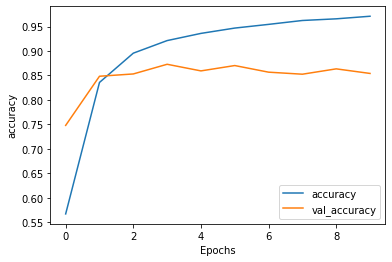

In [29]:
plot_graphs(history, 'accuracy')

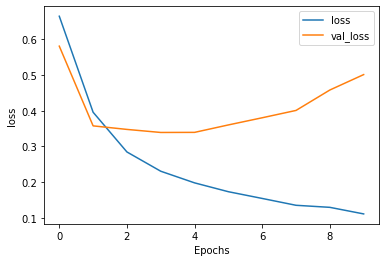

In [30]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
